# Paralelization for gradient-free optimizers: Differential Evolution
In this notebook, a more complex example is aimed. Here, a differential evolution optimization will be performed employing the vQPUs as accelerators of the quantum task of which the parameters are updated.

As in the rest of the examples, all the imports are done and the vQPUs are raised. After this, they are brought to the program workflow in form of `QPU` instances.

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import entropy, norm
from scipy.optimize import differential_evolution
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

sys.path.append(os.getenv("HOME"))

from cunqa import get_QPUs, qraise, qdrop
from cunqa.qpu import run 
from cunqa.mappers import QJobMapper, QPUCircuitMapper

family = qraise(10, "00:20:00", simulator = "Aer",  co_located = True)
qpus  = get_QPUs(co_located = True, family = family)

for q in qpus:
    print(f"QPU {q.id}, backend: {q.backend.name}, simulator: {q.backend.simulator}, version: {q.backend.version}.")

Requested QPUs with command:
	qraise -n 10 -t 00:20:00 --simulator=Aer --co-located
QPUs ready to work ✅
QPU 310390_4502_310390, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 310390_4503_310390, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 310390_4504_310390, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 310390_4505_310390, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 310390_4506_310390, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 310390_4507_310390, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 310390_4508_310390, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 310390_4509_310390, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 310390_4510_310390, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 310390_4511_310390, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.


In this example, the same ansatz, target distribution and distribution divergence measure is defined as in the parameters update feature example. 

In [2]:
def hardware_efficient_ansatz(num_qubits, num_layers):
    qc = QuantumCircuit(num_qubits)
    param_idx = 0
    for _ in range(num_layers):
        for qubit in range(num_qubits):
            phi = Parameter(f'phi_{param_idx}_{qubit}')
            lam = Parameter(f'lam_{param_idx}_{qubit}')
            qc.ry(phi, qubit)
            qc.rz(lam, qubit)
        param_idx += 1
        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)
    qc.measure_all()
    return qc

def target_distribution(num_qubits):
    # Define a normal distribution over the states
    num_states = 2 ** num_qubits
    states = np.arange(num_states)
    mean = num_states / 2
    std_dev = num_states / 4
    target_probs = norm.pdf(states, mean, std_dev)
    target_probs /= target_probs.sum()  # Normalize to make it a valid probability distribution
    target_dist = {format(i, f'0{num_qubits}b'): target_probs[i] for i in range(num_states)}
    return target_dist

def KL_divergence(counts, n_shots, target_dist):
    # Convert counts to probabilities
    pdf = pd.DataFrame.from_dict(counts, orient="index").reset_index()
    pdf.rename(columns={"index": "state", 0: "counts"}, inplace=True)
    pdf["probability"] = pdf["counts"] / n_shots
    
    # Create a dictionary for the obtained distribution
    obtained_dist = pdf.set_index("state")["probability"].to_dict()
    
    # Ensure all states are present in the obtained distribution
    for state in target_dist:
        if state not in obtained_dist:
            obtained_dist[state] = 0.0
    
    # Convert distributions to lists for KL divergence calculation
    target_probs = [target_dist[state] for state in sorted(target_dist)]
    obtained_probs = [obtained_dist[state] for state in sorted(obtained_dist)]
    
    # Calculate KL divergence
    kl_divergence = entropy(obtained_probs, target_probs)
    
    return kl_divergence

num_qubits = 6
num_layers = 3
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

pop=[np.random.uniform(-np.pi, np.pi, ansatz.num_parameters) for _ in range(ansatz.num_parameters)]
bounds=[(-np.pi,np.pi) for _ in range(ansatz.num_parameters)]

What changes is the cost function, that in this case will be the following.

In [3]:
def cost_function(result):
    target_dist = target_distribution(num_qubits)
    counts = result.counts
    
    return KL_divergence(counts, 1000, target_dist)

Now, similar to the previous example, a `make_callback` function is defined in order to generate a callback function tailored to the mapper employed.

In [4]:
def make_callback(mapper):
    i = 0
    pbar = tqdm(desc="Optimization", unit="iter")
    
    best_individual = []
    energies = []
    def callback(xk, convergence = 1e-8):
        nonlocal i
        best_individual.append(xk)
        energy = mapper(cost_function, [xk])[0]
        energies.append(energy)
        
        pbar.update(1)
        pbar.set_postfix(fx=f"{energy:.3e}")
        i += 1

    def close():
        pbar.close()

    return callback, close, energies

## QJobMapper
After all the previous steps, the optimization is ready to be performed. In this case, the mapper employed will be `QJobMapper`. This mapper takes a set of `QJobs` and uses the parameter update feature in each iteration.

In [5]:
init_qjobs = []
for i in range(1*ansatz.num_parameters):# we set pop=1 as the population size is pop*ansatz.num_parameters
    qpu = qpus[i%len(qpus)]# we select the qpu
    init_qjobs.append(run(ansatz.assign_parameters(np.zeros(ansatz.num_parameters)), qpu, shots=1000))

mapper = QJobMapper(init_qjobs)

callback1, close1, energies1 = make_callback(mapper)
result1 = differential_evolution(cost_function, 
                                bounds, 
                                maxiter = 1000, 
                                workers = mapper, 
                                updating = 'deferred',
                                strategy = 'best1bin', 
                                init = pop, 
                                polish = False, 
                                callback=callback1
                               )
close1()

Optimization: 0iter [00:00, ?iter/s]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 2iter [00:00,  4.38iter/s, fx=3.948e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 3iter [00:00,  7.67iter/s, fx=3.948e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 4iter [00:00,  7.76iter/s, fx=3.948e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 6iter [00:00,  8.86iter/s, fx=3.948e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 7iter [00:00,  8.86iter/s, fx=3.948e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 9iter [00:01,  9.39iter/s, fx=3.948e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 10iter [00:01,  9.77iter/s, fx=3.948e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 12iter [00:01,  9.97iter/s, fx=3.632e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 13iter [00:01,  9.97iter/s, fx=3.436e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 15iter [00:01, 10.13iter/s, fx=3.382e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 18iter [00:01, 10.14iter/s, fx=3.382e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 21iter [00:02, 10.24iter/s, fx=3.382e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 24iter [00:02, 10.36iter/s, fx=3.382e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 26iter [00:02, 10.24iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 29iter [00:02, 10.10iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 32iter [00:03, 10.34iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 35iter [00:03, 10.35iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 37iter [00:03, 10.30iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 40iter [00:04, 10.07iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 43iter [00:04, 10.14iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 46iter [00:04, 10.35iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 48iter [00:04, 10.44iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 51iter [00:05, 10.17iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 54iter [00:05, 10.32iter/s, fx=2.991e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 57iter [00:05, 10.30iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 59iter [00:05, 10.33iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 62iter [00:06, 10.18iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 65iter [00:06, 10.25iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 68iter [00:06, 10.40iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 70iter [00:06, 10.40iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 73iter [00:07, 10.20iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 76iter [00:07, 10.21iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 78iter [00:07,  9.92iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 80iter [00:07,  9.78iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 81iter [00:08,  9.70iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 83iter [00:08,  9.19iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 85iter [00:08,  9.27iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 87iter [00:08,  9.30iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 89iter [00:08,  9.36iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 91iter [00:09,  9.35iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 93iter [00:09,  9.40iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 95iter [00:09,  9.12iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 97iter [00:09,  9.30iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 99iter [00:10,  9.35iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 101iter [00:10,  9.43iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 103iter [00:10,  9.49iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 105iter [00:10,  8.95iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 107iter [00:10,  9.16iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 109iter [00:11,  9.31iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 111iter [00:11,  9.39iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 113iter [00:11,  9.39iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 115iter [00:11,  9.45iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 117iter [00:12,  9.04iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 119iter [00:12,  9.27iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 121iter [00:12,  9.39iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 123iter [00:12,  9.43iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 125iter [00:12,  9.46iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 127iter [00:13,  9.14iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 130iter [00:13,  9.83iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 133iter [00:13, 10.05iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 136iter [00:13, 10.29iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 139iter [00:14, 10.34iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 142iter [00:14, 11.56iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 145iter [00:14, 11.94iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 148iter [00:14, 12.52iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 151iter [00:15, 12.37iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 154iter [00:15, 12.71iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 157iter [00:15, 12.74iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 160iter [00:15, 12.54iter/s, fx=2.363e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 163iter [00:16, 12.81iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 166iter [00:16, 13.08iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 169iter [00:16, 13.05iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 172iter [00:16, 12.78iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 175iter [00:17, 12.89iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 178iter [00:17, 13.26iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 181iter [00:17, 13.36iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 184iter [00:17, 13.06iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 187iter [00:17, 13.04iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 190iter [00:18, 13.29iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 193iter [00:18, 13.40iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 196iter [00:18, 13.35iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 199iter [00:18, 13.39iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 202iter [00:19, 13.37iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 205iter [00:19, 13.42iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 208iter [00:19, 11.91iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 211iter [00:19, 11.44iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 214iter [00:20, 10.94iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 216iter [00:20, 10.60iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 219iter [00:20, 10.59iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 222iter [00:20, 10.62iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 225iter [00:21, 10.63iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 228iter [00:21, 10.46iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 230iter [00:21, 11.10iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 233iter [00:21, 11.62iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 236iter [00:22, 12.47iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 239iter [00:22, 12.74iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 242iter [00:22, 12.91iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 245iter [00:22, 12.88iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 248iter [00:22, 13.08iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 251iter [00:23, 12.93iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 254iter [00:23, 13.08iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 257iter [00:23, 13.19iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 260iter [00:23, 13.39iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 263iter [00:24, 13.22iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 266iter [00:24, 13.49iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 269iter [00:24, 13.62iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 272iter [00:24, 13.54iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 275iter [00:24, 13.68iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 278iter [00:25, 13.88iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 281iter [00:25, 13.82iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 284iter [00:25, 13.33iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 287iter [00:25, 13.14iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 290iter [00:26, 13.31iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 293iter [00:26, 13.25iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 296iter [00:26, 13.06iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 299iter [00:26, 13.29iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 302iter [00:27, 13.25iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 305iter [00:27, 13.33iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 308iter [00:27, 12.99iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 311iter [00:27, 13.15iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 314iter [00:27, 13.30iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 317iter [00:28, 13.23iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 320iter [00:28, 13.03iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 323iter [00:28, 13.06iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 326iter [00:28, 13.20iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 329iter [00:29, 12.59iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 331iter [00:29, 11.90iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 334iter [00:29, 11.68iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 337iter [00:29, 12.16iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 340iter [00:30, 11.78iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 342iter [00:30, 11.45iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 345iter [00:30, 11.15iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 348iter [00:30, 11.12iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 351iter [00:31, 11.36iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 354iter [00:31, 12.37iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 357iter [00:31, 12.41iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 360iter [00:31, 12.71iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 363iter [00:31, 12.46iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 366iter [00:32, 12.92iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 369iter [00:32, 13.15iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 372iter [00:32, 13.13iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 375iter [00:32, 13.17iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 378iter [00:33, 13.48iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 381iter [00:33, 13.37iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 384iter [00:33, 13.03iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 387iter [00:33, 13.27iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 390iter [00:33, 13.50iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 393iter [00:34, 13.36iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 396iter [00:34, 13.22iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 399iter [00:34, 13.38iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 402iter [00:34, 13.78iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 405iter [00:35, 13.87iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 408iter [00:35, 13.61iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 411iter [00:35, 13.72iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 414iter [00:35, 13.81iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 417iter [00:35, 13.83iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 420iter [00:36, 13.60iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 423iter [00:36, 13.61iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 426iter [00:36, 13.40iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 429iter [00:36, 12.99iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 432iter [00:37, 13.34iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 435iter [00:37, 13.35iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 438iter [00:37, 13.43iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 441iter [00:37, 13.22iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 444iter [00:37, 13.60iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 447iter [00:38, 13.65iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 450iter [00:38, 13.38iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 453iter [00:38, 13.46iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 456iter [00:38, 13.61iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 459iter [00:39, 13.69iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 462iter [00:39, 13.32iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 465iter [00:39, 13.48iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 468iter [00:39, 13.63iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 471iter [00:39, 13.63iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 474iter [00:40, 13.34iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 477iter [00:40, 13.46iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 480iter [00:40, 13.61iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 483iter [00:40, 13.55iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 486iter [00:41, 13.39iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 489iter [00:41, 13.54iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 492iter [00:41, 13.53iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 495iter [00:41, 13.50iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 498iter [00:41, 13.32iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 501iter [00:42, 13.38iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 504iter [00:42, 13.67iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 507iter [00:42, 13.41iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 510iter [00:42, 13.66iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 513iter [00:43, 13.77iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 516iter [00:43, 13.76iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 519iter [00:43, 13.18iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 522iter [00:43, 13.43iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 525iter [00:43, 13.54iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 528iter [00:44, 12.38iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 531iter [00:44, 12.74iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 534iter [00:44, 13.25iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 537iter [00:44, 13.29iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 540iter [00:45, 13.24iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 543iter [00:45, 13.38iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 546iter [00:45, 13.62iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 549iter [00:45, 13.64iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 552iter [00:46, 13.32iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 555iter [00:46, 13.44iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 558iter [00:46, 13.41iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 561iter [00:46, 13.22iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 564iter [00:46, 13.10iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 567iter [00:47, 13.12iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 570iter [00:47, 13.43iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 573iter [00:47, 13.43iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 576iter [00:47, 13.42iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 579iter [00:48, 13.42iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 582iter [00:48, 13.44iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 585iter [00:48, 13.09iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 588iter [00:48, 13.31iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 591iter [00:48, 13.21iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 594iter [00:49, 13.52iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 597iter [00:49, 13.18iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 600iter [00:49, 13.31iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 603iter [00:49, 13.37iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 606iter [00:50, 12.95iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 609iter [00:50, 12.99iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 612iter [00:50, 13.22iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 615iter [00:50, 13.30iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 618iter [00:50, 13.07iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 621iter [00:51, 13.23iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 624iter [00:51, 13.18iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 627iter [00:51, 13.30iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 630iter [00:51, 12.09iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 633iter [00:52, 12.49iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 636iter [00:52, 13.21iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 639iter [00:52, 13.45iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 642iter [00:52, 13.55iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 645iter [00:53, 13.65iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 648iter [00:53, 13.65iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 651iter [00:53, 13.61iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 654iter [00:53, 13.43iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 657iter [00:53, 13.63iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 660iter [00:54, 13.75iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 663iter [00:54, 13.42iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 666iter [00:54, 13.52iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 669iter [00:54, 13.62iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 672iter [00:55, 13.84iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 675iter [00:55, 13.45iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 678iter [00:55, 13.37iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 681iter [00:55, 13.32iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 684iter [00:55, 12.98iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 687iter [00:56, 13.17iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 690iter [00:56, 13.44iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 693iter [00:56, 13.33iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 696iter [00:56, 13.00iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 699iter [00:57, 13.16iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 702iter [00:57, 13.23iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 705iter [00:57, 13.15iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 708iter [00:57, 13.06iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 711iter [00:57, 13.14iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 714iter [00:58, 13.16iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 717iter [00:58, 13.10iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 720iter [00:58, 12.85iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 723iter [00:58, 12.88iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 726iter [00:59, 12.98iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 729iter [00:59, 12.97iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 732iter [00:59, 12.79iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 735iter [00:59, 12.92iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 738iter [01:00, 13.20iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 741iter [01:00, 12.98iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 744iter [01:00, 13.30iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 747iter [01:00, 13.40iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 750iter [01:00, 13.31iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 753iter [01:01, 13.00iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 756iter [01:01, 13.28iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 759iter [01:01, 13.15iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 762iter [01:01, 13.11iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 765iter [01:02, 12.74iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 768iter [01:02, 13.06iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 771iter [01:02, 13.13iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 774iter [01:02, 13.09iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 777iter [01:03, 13.13iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 780iter [01:03, 13.32iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 783iter [01:03, 13.52iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 786iter [01:03, 13.29iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 789iter [01:03, 13.46iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 792iter [01:04, 13.33iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 795iter [01:04, 13.31iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 798iter [01:04, 13.29iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 801iter [01:04, 13.17iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 804iter [01:05, 13.36iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 807iter [01:05, 13.35iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 810iter [01:05, 13.16iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 813iter [01:05, 13.15iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 816iter [01:05, 13.41iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 819iter [01:06, 13.02iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 822iter [01:06, 13.20iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 825iter [01:06, 13.22iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 828iter [01:06, 13.27iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 831iter [01:07, 12.84iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 834iter [01:07, 13.18iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 837iter [01:07, 13.22iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 840iter [01:07, 13.42iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 843iter [01:08, 13.03iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 846iter [01:08, 13.32iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 849iter [01:08, 13.45iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 852iter [01:08, 12.76iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 854iter [01:08, 11.84iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 857iter [01:09, 11.27iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 860iter [01:09, 12.26iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 863iter [01:09, 12.60iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 866iter [01:09, 12.84iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 869iter [01:10, 13.00iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 872iter [01:10, 13.37iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 875iter [01:10, 12.95iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 878iter [01:10, 13.33iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 881iter [01:11, 13.23iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 884iter [01:11, 13.21iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 887iter [01:11, 12.97iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 890iter [01:11, 13.25iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 893iter [01:11, 13.36iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 896iter [01:12, 13.02iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 899iter [01:12, 13.10iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 902iter [01:12, 13.23iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 905iter [01:12, 13.29iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 908iter [01:13, 12.98iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 911iter [01:13, 13.25iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 914iter [01:13, 13.40iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 917iter [01:13, 13.43iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 920iter [01:13, 13.11iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 923iter [01:14, 13.17iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 926iter [01:14, 13.33iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 929iter [01:14, 13.30iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 932iter [01:14, 13.27iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 935iter [01:15, 13.29iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 938iter [01:15, 13.46iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 941iter [01:15, 13.47iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 944iter [01:15, 13.31iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 947iter [01:15, 13.43iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 950iter [01:16, 13.74iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 953iter [01:16, 13.30iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 956iter [01:16, 13.35iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 959iter [01:16, 13.31iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 962iter [01:17, 13.30iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 965iter [01:17, 12.94iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 968iter [01:17, 13.09iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 971iter [01:17, 13.09iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 974iter [01:18, 12.87iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 977iter [01:18, 13.02iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 980iter [01:18, 13.01iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 983iter [01:18, 12.40iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 985iter [01:18, 11.78iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 988iter [01:19, 11.30iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 991iter [01:19, 11.84iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 994iter [01:19, 12.46iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 997iter [01:19, 12.65iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 1000iter [01:20, 12.48iter/s, fx=1.968e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfcf50>, <cunqa.qjob.QJob object at 0x7f0d00bfd410>, <cunqa.qjob.QJob object at 0x7f0d00bfd990>, <cunqa.qjob.QJob object at 0x7f0d00bfddd0>, <cunqa.qjob.QJob object at 0x7f0d00bfe250>, <cunqa.qjob.QJob object at 0x7f0d00bfe790>, <cunqa.qjob.QJob object at 0x7f0d00bfec90>, <cunqa.qjob.QJob object at 0x7f0d00bff210>, <cunqa.qjob.QJob object at 0x7f0d00be6a10>, <cunqa.qjob.QJob object at 0x7f0d00bfc8d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd510>, <cunqa.qjob.QJob object at 0x7f0d00bfe090>, <cunqa.qjob.QJob object at 0x7f0d00bfe990>, <cunqa.qjob.QJob object at 0x7f0d00bfe350>, <cunqa.qjob.QJob object at 0x7f0d00bfe750>, <cunqa.qjob.QJob object at 0x7f0d00bff950>, <cunqa.qjob.QJob object at 0x7f0d00bffed0>, <cunqa.qjob.QJob object at 0x7f0d00c04410>, <cunqa.qjob.QJob object at 0x7f0d00c049d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f50>, <cunqa.qjob.QJob object at 0x7f0d00c053d0>, <cunqa.qjob.QJob object at 0x7f0d00c05890>, <cunqa.qjob.QJob object at 0x7f

In [6]:
print(result1)

             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 0.1967627102828356
                   x: [ 9.516e-01  2.806e+00 ... -3.740e-01 -7.960e-01]
                 nit: 1000
                nfev: 36036
          population: [[ 9.516e-01  2.806e+00 ... -3.740e-01 -7.960e-01]
                       [ 1.734e+00 -8.594e-01 ... -1.441e+00 -1.770e+00]
                       ...
                       [ 1.357e+00 -1.193e+00 ... -3.200e-02  7.370e-01]
                       [ 8.011e-01  2.031e+00 ... -2.443e+00  2.711e-01]]
 population_energies: [ 1.968e-01  2.809e-01 ...  2.942e-01  2.800e-01]


## QPUCircuitMapper
In this case, instead of using the parameter update feature, it creates a circuit each time the mapper is called. But, as it can be seen, the employment of this mapper and the previous one is analogous.

In [7]:
mapper = QPUCircuitMapper(qpus, ansatz, shots=1000)

callback2, close2, energies2 = make_callback(mapper)
result2 = differential_evolution(cost_function, 
                                bounds, 
                                maxiter = 1000, 
                                workers = mapper, 
                                updating = 'deferred',
                                strategy = 'best1bin', 
                                init = pop, 
                                polish = False, 
                                callback=callback2
                               )
close2()

Optimization: 0iter [00:00, ?iter/s]

[<cunqa.qjob.QJob object at 0x7f0cfc2a0850>, <cunqa.qjob.QJob object at 0x7f0cfc28b290>, <cunqa.qjob.QJob object at 0x7f0cfc28bf90>, <cunqa.qjob.QJob object at 0x7f0d00bfc250>, <cunqa.qjob.QJob object at 0x7f0cfc252fd0>, <cunqa.qjob.QJob object at 0x7f0cfc252b50>, <cunqa.qjob.QJob object at 0x7f0cfc251850>, <cunqa.qjob.QJob object at 0x7f0d00c3a310>, <cunqa.qjob.QJob object at 0x7f0cfc2961d0>, <cunqa.qjob.QJob object at 0x7f0cfc297150>, <cunqa.qjob.QJob object at 0x7f0d00c48d90>, <cunqa.qjob.QJob object at 0x7f0d00c06f10>, <cunqa.qjob.QJob object at 0x7f0d00c32310>, <cunqa.qjob.QJob object at 0x7f0d00c32110>, <cunqa.qjob.QJob object at 0x7f0cfc27cd90>, <cunqa.qjob.QJob object at 0x7f0d00c46910>, <cunqa.qjob.QJob object at 0x7f0d00c458d0>, <cunqa.qjob.QJob object at 0x7f0d00c1a010>, <cunqa.qjob.QJob object at 0x7f0d00c197d0>, <cunqa.qjob.QJob object at 0x7f0d4412f910>, <cunqa.qjob.QJob object at 0x7f0cfc26dd90>, <cunqa.qjob.QJob object at 0x7f0cfc294d10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 1iter [00:00,  4.89iter/s, fx=3.693e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c1a290>, <cunqa.qjob.QJob object at 0x7f0d00be5ed0>, <cunqa.qjob.QJob object at 0x7f0cfc28af50>, <cunqa.qjob.QJob object at 0x7f0cfc288690>, <cunqa.qjob.QJob object at 0x7f0d00c3a990>, <cunqa.qjob.QJob object at 0x7f0d00be2610>, <cunqa.qjob.QJob object at 0x7f0d00c35b10>, <cunqa.qjob.QJob object at 0x7f0d00c35350>, <cunqa.qjob.QJob object at 0x7f0cfc27ef10>, <cunqa.qjob.QJob object at 0x7f0cfc27d410>, <cunqa.qjob.QJob object at 0x7f0cfc252d50>, <cunqa.qjob.QJob object at 0x7f0cfc252410>, <cunqa.qjob.QJob object at 0x7f0d00bb8110>, <cunqa.qjob.QJob object at 0x7f0cfc26d010>, <cunqa.qjob.QJob object at 0x7f0cfc26c150>, <cunqa.qjob.QJob object at 0x7f0cfc26d050>, <cunqa.qjob.QJob object at 0x7f0cfc2aded0>, <cunqa.qjob.QJob object at 0x7f0cfc2af610>, <cunqa.qjob.QJob object at 0x7f0cfc2afe10>, <cunqa.qjob.QJob object at 0x7f0cfc2ac250>, <cunqa.qjob.QJob object at 0x7f0cfc2add10>, <cunqa.qjob.QJob object at 0x7f0cfc2af910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 2iter [00:00,  6.88iter/s, fx=3.693e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c45b90>, <cunqa.qjob.QJob object at 0x7f0d00c4a690>, <cunqa.qjob.QJob object at 0x7f0d00c05050>, <cunqa.qjob.QJob object at 0x7f0cfc27b5d0>, <cunqa.qjob.QJob object at 0x7f0cfc259fd0>, <cunqa.qjob.QJob object at 0x7f0cfc255e10>, <cunqa.qjob.QJob object at 0x7f0cfc2555d0>, <cunqa.qjob.QJob object at 0x7f0cfc25c090>, <cunqa.qjob.QJob object at 0x7f0cfc249dd0>, <cunqa.qjob.QJob object at 0x7f0cfc249e50>, <cunqa.qjob.QJob object at 0x7f0d00c33850>, <cunqa.qjob.QJob object at 0x7f0cfc2a0890>, <cunqa.qjob.QJob object at 0x7f0cfc2a2a90>, <cunqa.qjob.QJob object at 0x7f0cfc273750>, <cunqa.qjob.QJob object at 0x7f0cfc2f9710>, <cunqa.qjob.QJob object at 0x7f0cfc2f9b90>, <cunqa.qjob.QJob object at 0x7f0cfc2fbbd0>, <cunqa.qjob.QJob object at 0x7f0cfc2fa8d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f9dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f8590>, <cunqa.qjob.QJob object at 0x7f0cfc2fa850>, <cunqa.qjob.QJob object at 0x7f0cfc2fb250>, <cunqa.qjob.QJob object at 0x7f

Optimization: 3iter [00:00,  7.59iter/s, fx=3.693e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfce10>, <cunqa.qjob.QJob object at 0x7f0cfc2ea590>, <cunqa.qjob.QJob object at 0x7f0cfc2e9f50>, <cunqa.qjob.QJob object at 0x7f0cfc2e8ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea890>, <cunqa.qjob.QJob object at 0x7f0cfc2ebad0>, <cunqa.qjob.QJob object at 0x7f0cfc2ebe50>, <cunqa.qjob.QJob object at 0x7f0cfc2e9a50>, <cunqa.qjob.QJob object at 0x7f0cfc2e9390>, <cunqa.qjob.QJob object at 0x7f0cfc2e8150>, <cunqa.qjob.QJob object at 0x7f0cfc2eb1d0>, <cunqa.qjob.QJob object at 0x7f0d00be79d0>, <cunqa.qjob.QJob object at 0x7f0d00be7550>, <cunqa.qjob.QJob object at 0x7f0cfc24c810>, <cunqa.qjob.QJob object at 0x7f0cfc24fe50>, <cunqa.qjob.QJob object at 0x7f0cfc24d290>, <cunqa.qjob.QJob object at 0x7f0cfc24dad0>, <cunqa.qjob.QJob object at 0x7f0cfc26d150>, <cunqa.qjob.QJob object at 0x7f0cfc26cb10>, <cunqa.qjob.QJob object at 0x7f0cfc27ff10>, <cunqa.qjob.QJob object at 0x7f0cfc27d210>, <cunqa.qjob.QJob object at 0x7f0cfc2527d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 4iter [00:00,  8.35iter/s, fx=3.693e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc300410>, <cunqa.qjob.QJob object at 0x7f0cfc3011d0>, <cunqa.qjob.QJob object at 0x7f0cfc300c90>, <cunqa.qjob.QJob object at 0x7f0cfc3022d0>, <cunqa.qjob.QJob object at 0x7f0cfc303410>, <cunqa.qjob.QJob object at 0x7f0cfc302850>, <cunqa.qjob.QJob object at 0x7f0cfc301050>, <cunqa.qjob.QJob object at 0x7f0cfc3016d0>, <cunqa.qjob.QJob object at 0x7f0d00be14d0>, <cunqa.qjob.QJob object at 0x7f0d00c46dd0>, <cunqa.qjob.QJob object at 0x7f0d00c45cd0>, <cunqa.qjob.QJob object at 0x7f0d00c452d0>, <cunqa.qjob.QJob object at 0x7f0d00c44090>, <cunqa.qjob.QJob object at 0x7f0cfc25e650>, <cunqa.qjob.QJob object at 0x7f0cfc25da50>, <cunqa.qjob.QJob object at 0x7f0cfc25b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc278f10>, <cunqa.qjob.QJob object at 0x7f0d00c04750>, <cunqa.qjob.QJob object at 0x7f0cfc2a2910>, <cunqa.qjob.QJob object at 0x7f0cfc2a2250>, <cunqa.qjob.QJob object at 0x7f0cfc2a0ed0>, <cunqa.qjob.QJob object at 0x7f0cfc249090>, <cunqa.qjob.QJob object at 0x7f

Optimization: 6iter [00:00,  9.25iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0d00e33c50>, <cunqa.qjob.QJob object at 0x7f0cfc290190>, <cunqa.qjob.QJob object at 0x7f0d00c35810>, <cunqa.qjob.QJob object at 0x7f0d00c35390>, <cunqa.qjob.QJob object at 0x7f0cfc312b50>, <cunqa.qjob.QJob object at 0x7f0cfc312750>, <cunqa.qjob.QJob object at 0x7f0cfc310750>, <cunqa.qjob.QJob object at 0x7f0cfc312f50>, <cunqa.qjob.QJob object at 0x7f0cfc312950>, <cunqa.qjob.QJob object at 0x7f0cfc310e10>, <cunqa.qjob.QJob object at 0x7f0cfc3121d0>, <cunqa.qjob.QJob object at 0x7f0cfc310b50>, <cunqa.qjob.QJob object at 0x7f0cfc311c10>, <cunqa.qjob.QJob object at 0x7f0cfc310cd0>, <cunqa.qjob.QJob object at 0x7f0cfc3131d0>, <cunqa.qjob.QJob object at 0x7f0cfc2fa790>, <cunqa.qjob.QJob object at 0x7f0cfc2fa950>, <cunqa.qjob.QJob object at 0x7f0cfc2f8f90>, <cunqa.qjob.QJob object at 0x7f0cfc2f81d0>, <cunqa.qjob.QJob object at 0x7f0cfc2fb790>, <cunqa.qjob.QJob object at 0x7f0cfc2f9210>, <cunqa.qjob.QJob object at 0x7f0cfc2fa8d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 7iter [00:00,  9.41iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc252090>, <cunqa.qjob.QJob object at 0x7f0d00c43ad0>, <cunqa.qjob.QJob object at 0x7f0cfc28b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc28b890>, <cunqa.qjob.QJob object at 0x7f0cfc289c10>, <cunqa.qjob.QJob object at 0x7f0cfc265c90>, <cunqa.qjob.QJob object at 0x7f0cfc267750>, <cunqa.qjob.QJob object at 0x7f0cfc2e8410>, <cunqa.qjob.QJob object at 0x7f0cfc2ea8d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eae50>, <cunqa.qjob.QJob object at 0x7f0cfc2ebe90>, <cunqa.qjob.QJob object at 0x7f0cfc2ebad0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb350>, <cunqa.qjob.QJob object at 0x7f0cfc2e9ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea650>, <cunqa.qjob.QJob object at 0x7f0cfc2e8a90>, <cunqa.qjob.QJob object at 0x7f0cfc2e8790>, <cunqa.qjob.QJob object at 0x7f0cfc2ebc10>, <cunqa.qjob.QJob object at 0x7f0cfc281b10>, <cunqa.qjob.QJob object at 0x7f0cfc2820d0>, <cunqa.qjob.QJob object at 0x7f0d00be7850>, <cunqa.qjob.QJob object at 0x7f0d00be5950>, <cunqa.qjob.QJob object at 0x7f

Optimization: 8iter [00:00,  9.30iter/s, fx=3.370e-01]

Optimization: 9iter [00:01,  9.45iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc287350>, <cunqa.qjob.QJob object at 0x7f0cfc25b250>, <cunqa.qjob.QJob object at 0x7f0cfc296dd0>, <cunqa.qjob.QJob object at 0x7f0cfc295810>, <cunqa.qjob.QJob object at 0x7f0cfc290890>, <cunqa.qjob.QJob object at 0x7f0cfc292110>, <cunqa.qjob.QJob object at 0x7f0d00c37210>, <cunqa.qjob.QJob object at 0x7f0d00c35250>, <cunqa.qjob.QJob object at 0x7f0d00c1bd10>, <cunqa.qjob.QJob object at 0x7f0d00c1b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc30b890>, <cunqa.qjob.QJob object at 0x7f0cfc309250>, <cunqa.qjob.QJob object at 0x7f0cfc309550>, <cunqa.qjob.QJob object at 0x7f0cfc30bad0>, <cunqa.qjob.QJob object at 0x7f0cfc30a2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc30b150>, <cunqa.qjob.QJob object at 0x7f0cfc30b050>, <cunqa.qjob.QJob object at 0x7f0cfc30b2d0>, <cunqa.qjob.QJob object at 0x7f0cfc308f10>, <cunqa.qjob.QJob object at 0x7f0cfc3083d0>, <cunqa.qjob.QJob object at 0x7f0d00c3b810>, <cunqa.qjob.QJob object at 0x7f

Optimization: 10iter [00:01,  9.45iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc311050>, <cunqa.qjob.QJob object at 0x7f0cfc311590>, <cunqa.qjob.QJob object at 0x7f0cfc312fd0>, <cunqa.qjob.QJob object at 0x7f0cfc3123d0>, <cunqa.qjob.QJob object at 0x7f0cfc311910>, <cunqa.qjob.QJob object at 0x7f0cfc313790>, <cunqa.qjob.QJob object at 0x7f0cfc310b90>, <cunqa.qjob.QJob object at 0x7f0cfc312f10>, <cunqa.qjob.QJob object at 0x7f0cfc313090>, <cunqa.qjob.QJob object at 0x7f0d00be1190>, <cunqa.qjob.QJob object at 0x7f0cfc27ba50>, <cunqa.qjob.QJob object at 0x7f0d00c49d90>, <cunqa.qjob.QJob object at 0x7f0d00c4be90>, <cunqa.qjob.QJob object at 0x7f0d00c4b1d0>, <cunqa.qjob.QJob object at 0x7f0d00c32c50>, <cunqa.qjob.QJob object at 0x7f0d00c31990>, <cunqa.qjob.QJob object at 0x7f0d00c323d0>, <cunqa.qjob.QJob object at 0x7f0d00c33350>, <cunqa.qjob.QJob object at 0x7f0cfc25f9d0>, <cunqa.qjob.QJob object at 0x7f0cfc25f490>, <cunqa.qjob.QJob object at 0x7f0cfc255dd0>, <cunqa.qjob.QJob object at 0x7f0cfc257850>, <cunqa.qjob.QJob object at 0x7f

Optimization: 12iter [00:01,  9.71iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2ee750>, <cunqa.qjob.QJob object at 0x7f0cfc2ec3d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef190>, <cunqa.qjob.QJob object at 0x7f0cfc2ed150>, <cunqa.qjob.QJob object at 0x7f0cfc2effd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ec1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eced0>, <cunqa.qjob.QJob object at 0x7f0cfc2ed290>, <cunqa.qjob.QJob object at 0x7f0cfc271c50>, <cunqa.qjob.QJob object at 0x7f0d01373c50>, <cunqa.qjob.QJob object at 0x7f0cfc259b90>, <cunqa.qjob.QJob object at 0x7f0cfc290210>, <cunqa.qjob.QJob object at 0x7f0cfc290850>, <cunqa.qjob.QJob object at 0x7f0cfc2933d0>, <cunqa.qjob.QJob object at 0x7f0d00c37a90>, <cunqa.qjob.QJob object at 0x7f0d00c35810>, <cunqa.qjob.QJob object at 0x7f0cfc28bd50>, <cunqa.qjob.QJob object at 0x7f0cfc289250>, <cunqa.qjob.QJob object at 0x7f0cfc28a510>, <cunqa.qjob.QJob object at 0x7f0cfc289090>, <cunqa.qjob.QJob object at 0x7f0cfc283fd0>, <cunqa.qjob.QJob object at 0x7f0d00c1b510>, <cunqa.qjob.QJob object at 0x7f

Optimization: 14iter [00:01,  9.56iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0d44151ad0>, <cunqa.qjob.QJob object at 0x7f0d00bfd590>, <cunqa.qjob.QJob object at 0x7f0d00bfce50>, <cunqa.qjob.QJob object at 0x7f0d00bfe210>, <cunqa.qjob.QJob object at 0x7f0cfc2491d0>, <cunqa.qjob.QJob object at 0x7f0cfc24a010>, <cunqa.qjob.QJob object at 0x7f0d00e037d0>, <cunqa.qjob.QJob object at 0x7f0cfc24f190>, <cunqa.qjob.QJob object at 0x7f0cfc24f450>, <cunqa.qjob.QJob object at 0x7f0cfc24cbd0>, <cunqa.qjob.QJob object at 0x7f0cfc24ecd0>, <cunqa.qjob.QJob object at 0x7f0d00c49f10>, <cunqa.qjob.QJob object at 0x7f0d00c4b890>, <cunqa.qjob.QJob object at 0x7f0d00c488d0>, <cunqa.qjob.QJob object at 0x7f0d00be1b50>, <cunqa.qjob.QJob object at 0x7f0d00be2310>, <cunqa.qjob.QJob object at 0x7f0cfc2f4c10>, <cunqa.qjob.QJob object at 0x7f0cfc2f7350>, <cunqa.qjob.QJob object at 0x7f0cfc2f4cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6350>, <cunqa.qjob.QJob object at 0x7f0cfc2f6290>, <cunqa.qjob.QJob object at 0x7f0cfc2f5cd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 15iter [00:01,  9.65iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c31750>, <cunqa.qjob.QJob object at 0x7f0d00be4f50>, <cunqa.qjob.QJob object at 0x7f0d00be59d0>, <cunqa.qjob.QJob object at 0x7f0d00be6d50>, <cunqa.qjob.QJob object at 0x7f0d00be7090>, <cunqa.qjob.QJob object at 0x7f0cfc25c090>, <cunqa.qjob.QJob object at 0x7f0cfc25c890>, <cunqa.qjob.QJob object at 0x7f0cfc250710>, <cunqa.qjob.QJob object at 0x7f0cfc250f10>, <cunqa.qjob.QJob object at 0x7f0cfc250150>, <cunqa.qjob.QJob object at 0x7f0d01373250>, <cunqa.qjob.QJob object at 0x7f0cfc283810>, <cunqa.qjob.QJob object at 0x7f0d00c45710>, <cunqa.qjob.QJob object at 0x7f0d00c45750>, <cunqa.qjob.QJob object at 0x7f0d00c46c90>, <cunqa.qjob.QJob object at 0x7f0d00c47b10>, <cunqa.qjob.QJob object at 0x7f0d00c41210>, <cunqa.qjob.QJob object at 0x7f0d00c42910>, <cunqa.qjob.QJob object at 0x7f0d00c422d0>, <cunqa.qjob.QJob object at 0x7f0d00c42d90>, <cunqa.qjob.QJob object at 0x7f0cfc259b50>, <cunqa.qjob.QJob object at 0x7f0d00c34c10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 17iter [00:01,  9.85iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc293650>, <cunqa.qjob.QJob object at 0x7f0cfc2e9150>, <cunqa.qjob.QJob object at 0x7f0cfc2ebad0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9550>, <cunqa.qjob.QJob object at 0x7f0cfc2ea410>, <cunqa.qjob.QJob object at 0x7f0cfc2e9810>, <cunqa.qjob.QJob object at 0x7f0cfc2e9a90>, <cunqa.qjob.QJob object at 0x7f0cfc2e9d50>, <cunqa.qjob.QJob object at 0x7f0cfc2ebf90>, <cunqa.qjob.QJob object at 0x7f0cfc2eab10>, <cunqa.qjob.QJob object at 0x7f0cfc2eb490>, <cunqa.qjob.QJob object at 0x7f0d00c38c90>, <cunqa.qjob.QJob object at 0x7f0d00c389d0>, <cunqa.qjob.QJob object at 0x7f0d00c3a6d0>, <cunqa.qjob.QJob object at 0x7f0d00b53ad0>, <cunqa.qjob.QJob object at 0x7f0cfc26da10>, <cunqa.qjob.QJob object at 0x7f0cfc26cfd0>, <cunqa.qjob.QJob object at 0x7f0cfc26d090>, <cunqa.qjob.QJob object at 0x7f0d00e03c50>, <cunqa.qjob.QJob object at 0x7f0cfc27b5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2adfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae7d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 18iter [00:01,  9.86iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c48510>, <cunqa.qjob.QJob object at 0x7f0d00c49390>, <cunqa.qjob.QJob object at 0x7f0cfc300c10>, <cunqa.qjob.QJob object at 0x7f0cfc302650>, <cunqa.qjob.QJob object at 0x7f0cfc301250>, <cunqa.qjob.QJob object at 0x7f0cfc301350>, <cunqa.qjob.QJob object at 0x7f0cfc301b90>, <cunqa.qjob.QJob object at 0x7f0cfc300490>, <cunqa.qjob.QJob object at 0x7f0cfc303590>, <cunqa.qjob.QJob object at 0x7f0cfc303e90>, <cunqa.qjob.QJob object at 0x7f0cfc303850>, <cunqa.qjob.QJob object at 0x7f0cfc302b50>, <cunqa.qjob.QJob object at 0x7f0cfc24ef90>, <cunqa.qjob.QJob object at 0x7f0cfc24e2d0>, <cunqa.qjob.QJob object at 0x7f0cfc24e610>, <cunqa.qjob.QJob object at 0x7f0cfc24e5d0>, <cunqa.qjob.QJob object at 0x7f0cfc24c510>, <cunqa.qjob.QJob object at 0x7f0cfc24bf50>, <cunqa.qjob.QJob object at 0x7f0cfc24ad50>, <cunqa.qjob.QJob object at 0x7f0cfc2eea90>, <cunqa.qjob.QJob object at 0x7f0cfc2ec950>, <cunqa.qjob.QJob object at 0x7f0cfc2ee490>, <cunqa.qjob.QJob object at 0x7f

Optimization: 19iter [00:02,  9.58iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc289650>, <cunqa.qjob.QJob object at 0x7f0cfc2887d0>, <cunqa.qjob.QJob object at 0x7f0cfc310950>, <cunqa.qjob.QJob object at 0x7f0cfc311110>, <cunqa.qjob.QJob object at 0x7f0cfc313fd0>, <cunqa.qjob.QJob object at 0x7f0cfc3120d0>, <cunqa.qjob.QJob object at 0x7f0cfc312cd0>, <cunqa.qjob.QJob object at 0x7f0cfc3131d0>, <cunqa.qjob.QJob object at 0x7f0cfc312b50>, <cunqa.qjob.QJob object at 0x7f0cfc311150>, <cunqa.qjob.QJob object at 0x7f0cfc310150>, <cunqa.qjob.QJob object at 0x7f0cfc312b90>, <cunqa.qjob.QJob object at 0x7f0cfc25e310>, <cunqa.qjob.QJob object at 0x7f0cfc25c790>, <cunqa.qjob.QJob object at 0x7f0cfc25f510>, <cunqa.qjob.QJob object at 0x7f0cfc30a310>, <cunqa.qjob.QJob object at 0x7f0cfc30aa10>, <cunqa.qjob.QJob object at 0x7f0cfc30b490>, <cunqa.qjob.QJob object at 0x7f0cfc30b190>, <cunqa.qjob.QJob object at 0x7f0cfc309210>, <cunqa.qjob.QJob object at 0x7f0cfc308b50>, <cunqa.qjob.QJob object at 0x7f0cfc30b090>, <cunqa.qjob.QJob object at 0x7f

Optimization: 20iter [00:02,  9.66iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c18910>, <cunqa.qjob.QJob object at 0x7f0cfc2a00d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a0490>, <cunqa.qjob.QJob object at 0x7f0cfc2a2a50>, <cunqa.qjob.QJob object at 0x7f0cfc2fa350>, <cunqa.qjob.QJob object at 0x7f0cfc2f9fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f85d0>, <cunqa.qjob.QJob object at 0x7f0cfc2fbb10>, <cunqa.qjob.QJob object at 0x7f0cfc2f8e50>, <cunqa.qjob.QJob object at 0x7f0cfc2f9990>, <cunqa.qjob.QJob object at 0x7f0cfc2fac10>, <cunqa.qjob.QJob object at 0x7f0cfc2f9950>, <cunqa.qjob.QJob object at 0x7f0cfc2f9690>, <cunqa.qjob.QJob object at 0x7f0cfc2f9750>, <cunqa.qjob.QJob object at 0x7f0cfc252610>, <cunqa.qjob.QJob object at 0x7f0cfc250610>, <cunqa.qjob.QJob object at 0x7f0cfc253710>, <cunqa.qjob.QJob object at 0x7f0cfc251f50>, <cunqa.qjob.QJob object at 0x7f0cfc286b90>, <cunqa.qjob.QJob object at 0x7f0cfc256390>, <cunqa.qjob.QJob object at 0x7f0cfc2567d0>, <cunqa.qjob.QJob object at 0x7f0cfc255dd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 21iter [00:02,  9.72iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be4c50>, <cunqa.qjob.QJob object at 0x7f0d00be7650>, <cunqa.qjob.QJob object at 0x7f0cfc2ed610>, <cunqa.qjob.QJob object at 0x7f0cfc2ede50>, <cunqa.qjob.QJob object at 0x7f0cfc2ef410>, <cunqa.qjob.QJob object at 0x7f0cfc2ee310>, <cunqa.qjob.QJob object at 0x7f0cfc2eea10>, <cunqa.qjob.QJob object at 0x7f0cfc2ed350>, <cunqa.qjob.QJob object at 0x7f0cfc2eeb10>, <cunqa.qjob.QJob object at 0x7f0cfc2ec610>, <cunqa.qjob.QJob object at 0x7f0cfc2efed0>, <cunqa.qjob.QJob object at 0x7f0cfc2ee5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2829d0>, <cunqa.qjob.QJob object at 0x7f0d00c4bc50>, <cunqa.qjob.QJob object at 0x7f0d00c4b290>, <cunqa.qjob.QJob object at 0x7f0d00c49cd0>, <cunqa.qjob.QJob object at 0x7f0cfc265910>, <cunqa.qjob.QJob object at 0x7f0cfc266110>, <cunqa.qjob.QJob object at 0x7f0d00be23d0>, <cunqa.qjob.QJob object at 0x7f0d00be2610>, <cunqa.qjob.QJob object at 0x7f0cfc25f390>, <cunqa.qjob.QJob object at 0x7f0cfc25e650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 22iter [00:02,  9.72iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc300110>, <cunqa.qjob.QJob object at 0x7f0cfc301210>, <cunqa.qjob.QJob object at 0x7f0cfc302c10>, <cunqa.qjob.QJob object at 0x7f0cfc302c50>, <cunqa.qjob.QJob object at 0x7f0cfc303610>, <cunqa.qjob.QJob object at 0x7f0cfc303c50>, <cunqa.qjob.QJob object at 0x7f0cfc300050>, <cunqa.qjob.QJob object at 0x7f0cfc302610>, <cunqa.qjob.QJob object at 0x7f0cfc303e90>, <cunqa.qjob.QJob object at 0x7f0cfc2e8d10>, <cunqa.qjob.QJob object at 0x7f0cfc2eac50>, <cunqa.qjob.QJob object at 0x7f0cfc2e9750>, <cunqa.qjob.QJob object at 0x7f0cfc2e98d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea710>, <cunqa.qjob.QJob object at 0x7f0cfc2ebcd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8b50>, <cunqa.qjob.QJob object at 0x7f0cfc2e9f10>, <cunqa.qjob.QJob object at 0x7f0cfc2eba50>, <cunqa.qjob.QJob object at 0x7f0cfc2e9390>, <cunqa.qjob.QJob object at 0x7f0d00c197d0>, <cunqa.qjob.QJob object at 0x7f0d01428b50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 23iter [00:02,  9.78iter/s, fx=3.370e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c38210>, <cunqa.qjob.QJob object at 0x7f0d00c3b7d0>, <cunqa.qjob.QJob object at 0x7f0d00c39bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2922d0>, <cunqa.qjob.QJob object at 0x7f0cfc292c10>, <cunqa.qjob.QJob object at 0x7f0cfc250410>, <cunqa.qjob.QJob object at 0x7f0cfc252410>, <cunqa.qjob.QJob object at 0x7f0cfc252610>, <cunqa.qjob.QJob object at 0x7f0cfc2f9610>, <cunqa.qjob.QJob object at 0x7f0cfc2fa110>, <cunqa.qjob.QJob object at 0x7f0cfc2fa250>, <cunqa.qjob.QJob object at 0x7f0cfc2fb390>, <cunqa.qjob.QJob object at 0x7f0cfc2fa710>, <cunqa.qjob.QJob object at 0x7f0cfc2fbe90>, <cunqa.qjob.QJob object at 0x7f0cfc2f9650>, <cunqa.qjob.QJob object at 0x7f0cfc2f9690>, <cunqa.qjob.QJob object at 0x7f0cfc2f90d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f8a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f9b10>, <cunqa.qjob.QJob object at 0x7f0d00bae150>, <cunqa.qjob.QJob object at 0x7f0cfc2aff90>, <cunqa.qjob.QJob object at 0x7f0cfc2acf10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 25iter [00:02,  9.39iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26db10>, <cunqa.qjob.QJob object at 0x7f0cfc312810>, <cunqa.qjob.QJob object at 0x7f0cfc3114d0>, <cunqa.qjob.QJob object at 0x7f0cfc311cd0>, <cunqa.qjob.QJob object at 0x7f0cfc310590>, <cunqa.qjob.QJob object at 0x7f0cfc310150>, <cunqa.qjob.QJob object at 0x7f0cfc312450>, <cunqa.qjob.QJob object at 0x7f0cfc3117d0>, <cunqa.qjob.QJob object at 0x7f0cfc312510>, <cunqa.qjob.QJob object at 0x7f0cfc3109d0>, <cunqa.qjob.QJob object at 0x7f0d00c35810>, <cunqa.qjob.QJob object at 0x7f0d00c36250>, <cunqa.qjob.QJob object at 0x7f0d00c34d10>, <cunqa.qjob.QJob object at 0x7f0cfc2e7350>, <cunqa.qjob.QJob object at 0x7f0cfc2e73d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2e4b50>, <cunqa.qjob.QJob object at 0x7f0cfc2e4c50>, <cunqa.qjob.QJob object at 0x7f0cfc2e4b10>, <cunqa.qjob.QJob object at 0x7f0cfc2e5710>, <cunqa.qjob.QJob object at 0x7f0cfc2e6910>, <cunqa.qjob.QJob object at 0x7f0cfc2e7650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 27iter [00:02,  9.68iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2ea210>, <cunqa.qjob.QJob object at 0x7f0cfc2ea290>, <cunqa.qjob.QJob object at 0x7f0cfc2ea790>, <cunqa.qjob.QJob object at 0x7f0cfc2eac90>, <cunqa.qjob.QJob object at 0x7f0cfc2ea2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e86d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea990>, <cunqa.qjob.QJob object at 0x7f0cfc2ea010>, <cunqa.qjob.QJob object at 0x7f0d00bfe210>, <cunqa.qjob.QJob object at 0x7f0d00bffe10>, <cunqa.qjob.QJob object at 0x7f0d00bfd710>, <cunqa.qjob.QJob object at 0x7f0d00bff310>, <cunqa.qjob.QJob object at 0x7f0cfc25fd10>, <cunqa.qjob.QJob object at 0x7f0d00c31510>, <cunqa.qjob.QJob object at 0x7f0d00c33b10>, <cunqa.qjob.QJob object at 0x7f0d00c30a50>, <cunqa.qjob.QJob object at 0x7f0d00c31950>, <cunqa.qjob.QJob object at 0x7f0d00c07710>, <cunqa.qjob.QJob object at 0x7f0d00c04150>, <cunqa.qjob.QJob object at 0x7f0cfc276190>, <cunqa.qjob.QJob object at 0x7f0cfc2ec850>, <cunqa.qjob.QJob object at 0x7f0cfc2eca90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 28iter [00:02,  9.71iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc300950>, <cunqa.qjob.QJob object at 0x7f0cfc302890>, <cunqa.qjob.QJob object at 0x7f0cfc300dd0>, <cunqa.qjob.QJob object at 0x7f0cfc301490>, <cunqa.qjob.QJob object at 0x7f0cfc302e50>, <cunqa.qjob.QJob object at 0x7f0cfc302610>, <cunqa.qjob.QJob object at 0x7f0cfc302190>, <cunqa.qjob.QJob object at 0x7f0cfc3018d0>, <cunqa.qjob.QJob object at 0x7f0cfc3013d0>, <cunqa.qjob.QJob object at 0x7f0cfc255d50>, <cunqa.qjob.QJob object at 0x7f0cfc256a50>, <cunqa.qjob.QJob object at 0x7f0cfc254690>, <cunqa.qjob.QJob object at 0x7f0cfc30ba90>, <cunqa.qjob.QJob object at 0x7f0cfc3084d0>, <cunqa.qjob.QJob object at 0x7f0cfc30a610>, <cunqa.qjob.QJob object at 0x7f0cfc30a710>, <cunqa.qjob.QJob object at 0x7f0cfc30af50>, <cunqa.qjob.QJob object at 0x7f0cfc308190>, <cunqa.qjob.QJob object at 0x7f0cfc30b010>, <cunqa.qjob.QJob object at 0x7f0cfc308dd0>, <cunqa.qjob.QJob object at 0x7f0cfc309d10>, <cunqa.qjob.QJob object at 0x7f0cfc309610>, <cunqa.qjob.QJob object at 0x7f

Optimization: 30iter [00:03,  9.50iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc286310>, <cunqa.qjob.QJob object at 0x7f0cfc2816d0>, <cunqa.qjob.QJob object at 0x7f0d01373c50>, <cunqa.qjob.QJob object at 0x7f0d00be1910>, <cunqa.qjob.QJob object at 0x7f0d00bfe210>, <cunqa.qjob.QJob object at 0x7f0d00bfc2d0>, <cunqa.qjob.QJob object at 0x7f0d00bff110>, <cunqa.qjob.QJob object at 0x7f0d00bfd090>, <cunqa.qjob.QJob object at 0x7f0cfc310110>, <cunqa.qjob.QJob object at 0x7f0cfc313850>, <cunqa.qjob.QJob object at 0x7f0cfc3136d0>, <cunqa.qjob.QJob object at 0x7f0cfc311cd0>, <cunqa.qjob.QJob object at 0x7f0cfc3114d0>, <cunqa.qjob.QJob object at 0x7f0cfc3125d0>, <cunqa.qjob.QJob object at 0x7f0cfc310490>, <cunqa.qjob.QJob object at 0x7f0cfc311050>, <cunqa.qjob.QJob object at 0x7f0cfc311450>, <cunqa.qjob.QJob object at 0x7f0cfc310b90>, <cunqa.qjob.QJob object at 0x7f0cfc311c90>, <cunqa.qjob.QJob object at 0x7f0d00c325d0>, <cunqa.qjob.QJob object at 0x7f0d00c30f50>, <cunqa.qjob.QJob object at 0x7f0d00c32a90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 32iter [00:03,  9.80iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0d4412f710>, <cunqa.qjob.QJob object at 0x7f0d00b53ad0>, <cunqa.qjob.QJob object at 0x7f0cfc248c10>, <cunqa.qjob.QJob object at 0x7f0cfc249dd0>, <cunqa.qjob.QJob object at 0x7f0d00c34750>, <cunqa.qjob.QJob object at 0x7f0cfc26d090>, <cunqa.qjob.QJob object at 0x7f0cfc26e010>, <cunqa.qjob.QJob object at 0x7f0cfc26cdd0>, <cunqa.qjob.QJob object at 0x7f0cfc252150>, <cunqa.qjob.QJob object at 0x7f0cfc250d90>, <cunqa.qjob.QJob object at 0x7f0cfc252810>, <cunqa.qjob.QJob object at 0x7f0cfc2ee390>, <cunqa.qjob.QJob object at 0x7f0cfc2efe90>, <cunqa.qjob.QJob object at 0x7f0cfc2eec90>, <cunqa.qjob.QJob object at 0x7f0cfc2ed5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef790>, <cunqa.qjob.QJob object at 0x7f0cfc2ede50>, <cunqa.qjob.QJob object at 0x7f0cfc2efbd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef110>, <cunqa.qjob.QJob object at 0x7f0cfc2ef750>, <cunqa.qjob.QJob object at 0x7f0cfc2ef9d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eca10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 33iter [00:03,  9.81iter/s, fx=2.902e-01]

Optimization: 34iter [00:03,  9.81iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e6c50>, <cunqa.qjob.QJob object at 0x7f0cfc2e7810>, <cunqa.qjob.QJob object at 0x7f0cfc2e5790>, <cunqa.qjob.QJob object at 0x7f0cfc2e5d50>, <cunqa.qjob.QJob object at 0x7f0cfc2e7710>, <cunqa.qjob.QJob object at 0x7f0cfc2e7390>, <cunqa.qjob.QJob object at 0x7f0cfc24ff10>, <cunqa.qjob.QJob object at 0x7f0cfc24c0d0>, <cunqa.qjob.QJob object at 0x7f0cfc24c990>, <cunqa.qjob.QJob object at 0x7f0cfc24fb10>, <cunqa.qjob.QJob object at 0x7f0d00c3b590>, <cunqa.qjob.QJob object at 0x7f0d00c3ac50>, <cunqa.qjob.QJob object at 0x7f0d00c39550>, <cunqa.qjob.QJob object at 0x7f0d00c3a3d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a0250>, <cunqa.qjob.QJob object at 0x7f0cfc2a2d10>, <cunqa.qjob.QJob object at 0x7f0cfc2a29d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1a10>, <cunqa.qjob.QJob object at 0x7f0cfc27fb50>, <cunqa.qjob.QJob object at 0x7f0cfc27df50>, <cunqa.qjob.QJob object at 0x7f0cfc2891d0>, <cunqa.qjob.QJob object at 0x7f0cfc288550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 35iter [00:03,  9.64iter/s, fx=2.902e-01]

Optimization: 37iter [00:03,  9.83iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc282e10>, <cunqa.qjob.QJob object at 0x7f0cfc2edfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2eef50>, <cunqa.qjob.QJob object at 0x7f0cfc2eda10>, <cunqa.qjob.QJob object at 0x7f0cfc2ec450>, <cunqa.qjob.QJob object at 0x7f0cfc2ed610>, <cunqa.qjob.QJob object at 0x7f0cfc2ecad0>, <cunqa.qjob.QJob object at 0x7f0cfc2efc90>, <cunqa.qjob.QJob object at 0x7f0cfc2ed2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2edf90>, <cunqa.qjob.QJob object at 0x7f0d00c48fd0>, <cunqa.qjob.QJob object at 0x7f0d00c4bb10>, <cunqa.qjob.QJob object at 0x7f0d00c49b10>, <cunqa.qjob.QJob object at 0x7f0d00bfd310>, <cunqa.qjob.QJob object at 0x7f0d00bffb90>, <cunqa.qjob.QJob object at 0x7f0d00bfc5d0>, <cunqa.qjob.QJob object at 0x7f0d00bfc2d0>, <cunqa.qjob.QJob object at 0x7f0cfc303010>, <cunqa.qjob.QJob object at 0x7f0cfc303fd0>, <cunqa.qjob.QJob object at 0x7f0cfc301e90>, <cunqa.qjob.QJob object at 0x7f0cfc301750>, <cunqa.qjob.QJob object at 0x7f0cfc300290>, <cunqa.qjob.QJob object at 0x7f

Optimization: 39iter [00:04,  9.94iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0d4413e310>, <cunqa.qjob.QJob object at 0x7f0d00c46dd0>, <cunqa.qjob.QJob object at 0x7f0d00c45cd0>, <cunqa.qjob.QJob object at 0x7f0d00c45890>, <cunqa.qjob.QJob object at 0x7f0d00c47f10>, <cunqa.qjob.QJob object at 0x7f0cfc250410>, <cunqa.qjob.QJob object at 0x7f0cfc253a50>, <cunqa.qjob.QJob object at 0x7f0d00c18b50>, <cunqa.qjob.QJob object at 0x7f0d00c19950>, <cunqa.qjob.QJob object at 0x7f0cfc3116d0>, <cunqa.qjob.QJob object at 0x7f0cfc312e50>, <cunqa.qjob.QJob object at 0x7f0cfc313750>, <cunqa.qjob.QJob object at 0x7f0cfc313590>, <cunqa.qjob.QJob object at 0x7f0cfc312710>, <cunqa.qjob.QJob object at 0x7f0cfc310610>, <cunqa.qjob.QJob object at 0x7f0cfc312310>, <cunqa.qjob.QJob object at 0x7f0cfc311e10>, <cunqa.qjob.QJob object at 0x7f0cfc310c50>, <cunqa.qjob.QJob object at 0x7f0cfc312110>, <cunqa.qjob.QJob object at 0x7f0cfc313850>, <cunqa.qjob.QJob object at 0x7f0cfc292c10>, <cunqa.qjob.QJob object at 0x7f0cfc292150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 41iter [00:04,  9.64iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24aed0>, <cunqa.qjob.QJob object at 0x7f0d00c34e10>, <cunqa.qjob.QJob object at 0x7f0d00c34190>, <cunqa.qjob.QJob object at 0x7f0d00be7650>, <cunqa.qjob.QJob object at 0x7f0d00be6d10>, <cunqa.qjob.QJob object at 0x7f0d00be58d0>, <cunqa.qjob.QJob object at 0x7f0d00be7ed0>, <cunqa.qjob.QJob object at 0x7f0cfc27b390>, <cunqa.qjob.QJob object at 0x7f0cfc24e2d0>, <cunqa.qjob.QJob object at 0x7f0cfc24c990>, <cunqa.qjob.QJob object at 0x7f0cfc24e250>, <cunqa.qjob.QJob object at 0x7f0cfc24d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc284910>, <cunqa.qjob.QJob object at 0x7f0cfc284f10>, <cunqa.qjob.QJob object at 0x7f0cfc296b10>, <cunqa.qjob.QJob object at 0x7f0cfc2963d0>, <cunqa.qjob.QJob object at 0x7f0cfc297550>, <cunqa.qjob.QJob object at 0x7f0cfc25a9d0>, <cunqa.qjob.QJob object at 0x7f0cfc259850>, <cunqa.qjob.QJob object at 0x7f0cfc2f40d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7b90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5a90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 43iter [00:04,  9.65iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c46c10>, <cunqa.qjob.QJob object at 0x7f0d00c43750>, <cunqa.qjob.QJob object at 0x7f0d00c409d0>, <cunqa.qjob.QJob object at 0x7f0d00c3b2d0>, <cunqa.qjob.QJob object at 0x7f0d00c397d0>, <cunqa.qjob.QJob object at 0x7f0d00c39350>, <cunqa.qjob.QJob object at 0x7f0cfc313a50>, <cunqa.qjob.QJob object at 0x7f0cfc313910>, <cunqa.qjob.QJob object at 0x7f0cfc313550>, <cunqa.qjob.QJob object at 0x7f0cfc311410>, <cunqa.qjob.QJob object at 0x7f0cfc3109d0>, <cunqa.qjob.QJob object at 0x7f0cfc311bd0>, <cunqa.qjob.QJob object at 0x7f0cfc311710>, <cunqa.qjob.QJob object at 0x7f0cfc312150>, <cunqa.qjob.QJob object at 0x7f0cfc310d90>, <cunqa.qjob.QJob object at 0x7f0cfc311890>, <cunqa.qjob.QJob object at 0x7f0cfc310050>, <cunqa.qjob.QJob object at 0x7f0d00c49950>, <cunqa.qjob.QJob object at 0x7f0d00c49090>, <cunqa.qjob.QJob object at 0x7f0d00c32290>, <cunqa.qjob.QJob object at 0x7f0d00c32210>, <cunqa.qjob.QJob object at 0x7f0d00c33f10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 46iter [00:04,  9.57iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c37cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7490>, <cunqa.qjob.QJob object at 0x7f0cfc2f48d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6010>, <cunqa.qjob.QJob object at 0x7f0cfc2f6ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6c90>, <cunqa.qjob.QJob object at 0x7f0cfc2f6310>, <cunqa.qjob.QJob object at 0x7f0cfc2f5690>, <cunqa.qjob.QJob object at 0x7f0cfc2f7810>, <cunqa.qjob.QJob object at 0x7f0cfc2f6950>, <cunqa.qjob.QJob object at 0x7f0cfc2f4a50>, <cunqa.qjob.QJob object at 0x7f0cfc309310>, <cunqa.qjob.QJob object at 0x7f0cfc309a50>, <cunqa.qjob.QJob object at 0x7f0cfc308cd0>, <cunqa.qjob.QJob object at 0x7f0cfc309050>, <cunqa.qjob.QJob object at 0x7f0cfc30a690>, <cunqa.qjob.QJob object at 0x7f0cfc30a410>, <cunqa.qjob.QJob object at 0x7f0cfc30b610>, <cunqa.qjob.QJob object at 0x7f0cfc30b7d0>, <cunqa.qjob.QJob object at 0x7f0cfc308ad0>, <cunqa.qjob.QJob object at 0x7f0cfc3092d0>, <cunqa.qjob.QJob object at 0x7f0cfc308d90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 49iter [00:05,  9.76iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc302010>, <cunqa.qjob.QJob object at 0x7f0cfc303850>, <cunqa.qjob.QJob object at 0x7f0cfc300ad0>, <cunqa.qjob.QJob object at 0x7f0cfc3035d0>, <cunqa.qjob.QJob object at 0x7f0cfc301bd0>, <cunqa.qjob.QJob object at 0x7f0cfc302850>, <cunqa.qjob.QJob object at 0x7f0cfc301b10>, <cunqa.qjob.QJob object at 0x7f0cfc303a50>, <cunqa.qjob.QJob object at 0x7f0cfc2ed7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef450>, <cunqa.qjob.QJob object at 0x7f0cfc2ed310>, <cunqa.qjob.QJob object at 0x7f0cfc2ec250>, <cunqa.qjob.QJob object at 0x7f0cfc2eccd0>, <cunqa.qjob.QJob object at 0x7f0cfc2eff50>, <cunqa.qjob.QJob object at 0x7f0cfc2ecd50>, <cunqa.qjob.QJob object at 0x7f0cfc2ee550>, <cunqa.qjob.QJob object at 0x7f0cfc2ec910>, <cunqa.qjob.QJob object at 0x7f0cfc2ef790>, <cunqa.qjob.QJob object at 0x7f0d00bdb2d0>, <cunqa.qjob.QJob object at 0x7f0d00c07a10>, <cunqa.qjob.QJob object at 0x7f0d00c05dd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 51iter [00:05,  9.37iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0d07eb8b10>, <cunqa.qjob.QJob object at 0x7f0cfc310b50>, <cunqa.qjob.QJob object at 0x7f0cfc313690>, <cunqa.qjob.QJob object at 0x7f0cfc310690>, <cunqa.qjob.QJob object at 0x7f0cfc310f90>, <cunqa.qjob.QJob object at 0x7f0cfc311550>, <cunqa.qjob.QJob object at 0x7f0cfc311d10>, <cunqa.qjob.QJob object at 0x7f0cfc313290>, <cunqa.qjob.QJob object at 0x7f0cfc313d50>, <cunqa.qjob.QJob object at 0x7f0cfc27df90>, <cunqa.qjob.QJob object at 0x7f0cfc27f410>, <cunqa.qjob.QJob object at 0x7f0d00be2310>, <cunqa.qjob.QJob object at 0x7f0cfc267950>, <cunqa.qjob.QJob object at 0x7f0cfc265610>, <cunqa.qjob.QJob object at 0x7f0cfc2a1c10>, <cunqa.qjob.QJob object at 0x7f0cfc2a1a10>, <cunqa.qjob.QJob object at 0x7f0cfc2a0890>, <cunqa.qjob.QJob object at 0x7f0cfc2a2350>, <cunqa.qjob.QJob object at 0x7f0cfc251650>, <cunqa.qjob.QJob object at 0x7f0cfc253f90>, <cunqa.qjob.QJob object at 0x7f0cfc252a90>, <cunqa.qjob.QJob object at 0x7f0d44159150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 53iter [00:05,  9.44iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be7f90>, <cunqa.qjob.QJob object at 0x7f0d00be5810>, <cunqa.qjob.QJob object at 0x7f0d00be7d90>, <cunqa.qjob.QJob object at 0x7f0cfc2542d0>, <cunqa.qjob.QJob object at 0x7f0cfc256a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f78d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f50d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4490>, <cunqa.qjob.QJob object at 0x7f0cfc2f63d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6790>, <cunqa.qjob.QJob object at 0x7f0cfc2f7450>, <cunqa.qjob.QJob object at 0x7f0cfc2f6c90>, <cunqa.qjob.QJob object at 0x7f0cfc2f6390>, <cunqa.qjob.QJob object at 0x7f0d1c1a2b90>, <cunqa.qjob.QJob object at 0x7f0d00c45190>, <cunqa.qjob.QJob object at 0x7f0d00c460d0>, <cunqa.qjob.QJob object at 0x7f0d00c47b10>, <cunqa.qjob.QJob object at 0x7f0cfc27b950>, <cunqa.qjob.QJob object at 0x7f0cfc2904d0>, <cunqa.qjob.QJob object at 0x7f0cfc290410>, <cunqa.qjob.QJob object at 0x7f

Optimization: 55iter [00:05,  9.70iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a0650>, <cunqa.qjob.QJob object at 0x7f0cfc2a29d0>, <cunqa.qjob.QJob object at 0x7f0d00c36e50>, <cunqa.qjob.QJob object at 0x7f0d00c34390>, <cunqa.qjob.QJob object at 0x7f0cfc2514d0>, <cunqa.qjob.QJob object at 0x7f0cfc251d50>, <cunqa.qjob.QJob object at 0x7f0cfc253410>, <cunqa.qjob.QJob object at 0x7f0d00bdb2d0>, <cunqa.qjob.QJob object at 0x7f0cfc24e9d0>, <cunqa.qjob.QJob object at 0x7f0cfc24d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc24c8d0>, <cunqa.qjob.QJob object at 0x7f0cfc24c350>, <cunqa.qjob.QJob object at 0x7f0d00bfffd0>, <cunqa.qjob.QJob object at 0x7f0d00bff050>, <cunqa.qjob.QJob object at 0x7f0d00bfd850>, <cunqa.qjob.QJob object at 0x7f0d00c4bad0>, <cunqa.qjob.QJob object at 0x7f0d00c48d50>, <cunqa.qjob.QJob object at 0x7f0d00c48910>, <cunqa.qjob.QJob object at 0x7f0d4413ed90>, <cunqa.qjob.QJob object at 0x7f0cfc296750>, <cunqa.qjob.QJob object at 0x7f0cfc297010>, <cunqa.qjob.QJob object at 0x7f0cfc2965d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 58iter [00:06,  9.59iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c1bf50>, <cunqa.qjob.QJob object at 0x7f0d00c04bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2af4d0>, <cunqa.qjob.QJob object at 0x7f0cfc2afd50>, <cunqa.qjob.QJob object at 0x7f0cfc2ac710>, <cunqa.qjob.QJob object at 0x7f0cfc2aec50>, <cunqa.qjob.QJob object at 0x7f0cfc2ac110>, <cunqa.qjob.QJob object at 0x7f0cfc2ad7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2af690>, <cunqa.qjob.QJob object at 0x7f0d00c40b50>, <cunqa.qjob.QJob object at 0x7f0d00c42910>, <cunqa.qjob.QJob object at 0x7f0d00c42a90>, <cunqa.qjob.QJob object at 0x7f0d00be26d0>, <cunqa.qjob.QJob object at 0x7f0d00be1390>, <cunqa.qjob.QJob object at 0x7f0cfc2e7810>, <cunqa.qjob.QJob object at 0x7f0cfc2e5950>, <cunqa.qjob.QJob object at 0x7f0cfc2e73d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e7690>, <cunqa.qjob.QJob object at 0x7f0cfc2e4c90>, <cunqa.qjob.QJob object at 0x7f0cfc2e6550>, <cunqa.qjob.QJob object at 0x7f0cfc2e7290>, <cunqa.qjob.QJob object at 0x7f0cfc2e6ed0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 60iter [00:06,  9.75iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c38e90>, <cunqa.qjob.QJob object at 0x7f0d00c3a0d0>, <cunqa.qjob.QJob object at 0x7f0d085e2250>, <cunqa.qjob.QJob object at 0x7f0cfc24ad50>, <cunqa.qjob.QJob object at 0x7f0cfc249510>, <cunqa.qjob.QJob object at 0x7f0cfc2f7bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5890>, <cunqa.qjob.QJob object at 0x7f0cfc2f4250>, <cunqa.qjob.QJob object at 0x7f0cfc2f7f10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4f50>, <cunqa.qjob.QJob object at 0x7f0cfc2f6310>, <cunqa.qjob.QJob object at 0x7f0cfc2f7250>, <cunqa.qjob.QJob object at 0x7f0cfc2f5f90>, <cunqa.qjob.QJob object at 0x7f0cfc2f56d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5090>, <cunqa.qjob.QJob object at 0x7f0cfc24c0d0>, <cunqa.qjob.QJob object at 0x7f0cfc24c250>, <cunqa.qjob.QJob object at 0x7f0cfc24e290>, <cunqa.qjob.QJob object at 0x7f0cfc24ccd0>, <cunqa.qjob.QJob object at 0x7f0cfc24d290>, <cunqa.qjob.QJob object at 0x7f0d00db4050>, <cunqa.qjob.QJob object at 0x7f0cfc258850>, <cunqa.qjob.QJob object at 0x7f

Optimization: 62iter [00:06,  9.57iter/s, fx=2.902e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc276690>, <cunqa.qjob.QJob object at 0x7f0d00baf950>, <cunqa.qjob.QJob object at 0x7f0d00c36510>, <cunqa.qjob.QJob object at 0x7f0d00c36010>, <cunqa.qjob.QJob object at 0x7f0cfc250e50>, <cunqa.qjob.QJob object at 0x7f0cfc252090>, <cunqa.qjob.QJob object at 0x7f0cfc28b710>, <cunqa.qjob.QJob object at 0x7f0cfc28aed0>, <cunqa.qjob.QJob object at 0x7f0cfc289910>, <cunqa.qjob.QJob object at 0x7f0cfc2891d0>, <cunqa.qjob.QJob object at 0x7f0cfc3128d0>, <cunqa.qjob.QJob object at 0x7f0cfc313c10>, <cunqa.qjob.QJob object at 0x7f0cfc313090>, <cunqa.qjob.QJob object at 0x7f0cfc3126d0>, <cunqa.qjob.QJob object at 0x7f0cfc310f10>, <cunqa.qjob.QJob object at 0x7f0cfc3117d0>, <cunqa.qjob.QJob object at 0x7f0cfc313190>, <cunqa.qjob.QJob object at 0x7f0cfc310290>, <cunqa.qjob.QJob object at 0x7f0cfc3124d0>, <cunqa.qjob.QJob object at 0x7f0cfc313d50>, <cunqa.qjob.QJob object at 0x7f0cfc312790>, <cunqa.qjob.QJob object at 0x7f0d00be52d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 64iter [00:06,  9.61iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c1b910>, <cunqa.qjob.QJob object at 0x7f0cfc26dc50>, <cunqa.qjob.QJob object at 0x7f0cfc2a1d50>, <cunqa.qjob.QJob object at 0x7f0cfc2a29d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2cd0>, <cunqa.qjob.QJob object at 0x7f0cfc25b1d0>, <cunqa.qjob.QJob object at 0x7f0d00c324d0>, <cunqa.qjob.QJob object at 0x7f0d00c31950>, <cunqa.qjob.QJob object at 0x7f0d00c33550>, <cunqa.qjob.QJob object at 0x7f0d00c33c90>, <cunqa.qjob.QJob object at 0x7f0d00c425d0>, <cunqa.qjob.QJob object at 0x7f0d00c40e10>, <cunqa.qjob.QJob object at 0x7f0d00c40dd0>, <cunqa.qjob.QJob object at 0x7f0cfc24e450>, <cunqa.qjob.QJob object at 0x7f0cfc24d610>, <cunqa.qjob.QJob object at 0x7f0cfc24e5d0>, <cunqa.qjob.QJob object at 0x7f0cfc24ca90>, <cunqa.qjob.QJob object at 0x7f0d00e03890>, <cunqa.qjob.QJob object at 0x7f0cfc2ebb10>, <cunqa.qjob.QJob object at 0x7f0cfc2ebb50>, <cunqa.qjob.QJob object at 0x7f0cfc2e9c90>, <cunqa.qjob.QJob object at 0x7f0cfc2ea710>, <cunqa.qjob.QJob object at 0x7f

Optimization: 67iter [00:07,  9.61iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc312a50>, <cunqa.qjob.QJob object at 0x7f0cfc3136d0>, <cunqa.qjob.QJob object at 0x7f0cfc310a10>, <cunqa.qjob.QJob object at 0x7f0cfc313d50>, <cunqa.qjob.QJob object at 0x7f0cfc313e50>, <cunqa.qjob.QJob object at 0x7f0cfc312290>, <cunqa.qjob.QJob object at 0x7f0cfc313890>, <cunqa.qjob.QJob object at 0x7f0cfc310b50>, <cunqa.qjob.QJob object at 0x7f0cfc310550>, <cunqa.qjob.QJob object at 0x7f0d00c36510>, <cunqa.qjob.QJob object at 0x7f0d00c34e10>, <cunqa.qjob.QJob object at 0x7f0d00c360d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4610>, <cunqa.qjob.QJob object at 0x7f0cfc2f7750>, <cunqa.qjob.QJob object at 0x7f0cfc2f7890>, <cunqa.qjob.QJob object at 0x7f0cfc2f45d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f49d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6790>, <cunqa.qjob.QJob object at 0x7f0cfc2f4090>, <cunqa.qjob.QJob object at 0x7f0cfc2f7510>, <cunqa.qjob.QJob object at 0x7f0cfc2f7cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4450>, <cunqa.qjob.QJob object at 0x7f

Optimization: 69iter [00:07,  9.70iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd4dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2769d0>, <cunqa.qjob.QJob object at 0x7f0d00bc4e50>, <cunqa.qjob.QJob object at 0x7f0cfc25b250>, <cunqa.qjob.QJob object at 0x7f0cfc315e90>, <cunqa.qjob.QJob object at 0x7f0cfc3160d0>, <cunqa.qjob.QJob object at 0x7f0cfc315910>, <cunqa.qjob.QJob object at 0x7f0cfc317dd0>, <cunqa.qjob.QJob object at 0x7f0cfc316dd0>, <cunqa.qjob.QJob object at 0x7f0cfc315110>, <cunqa.qjob.QJob object at 0x7f0cfc314f50>, <cunqa.qjob.QJob object at 0x7f0cfc315e50>, <cunqa.qjob.QJob object at 0x7f0cfc315990>, <cunqa.qjob.QJob object at 0x7f0cfc317750>, <cunqa.qjob.QJob object at 0x7f0d44153ad0>, <cunqa.qjob.QJob object at 0x7f0d00be1990>, <cunqa.qjob.QJob object at 0x7f0cfc2ee450>, <cunqa.qjob.QJob object at 0x7f0cfc2ec890>, <cunqa.qjob.QJob object at 0x7f0cfc2ec210>, <cunqa.qjob.QJob object at 0x7f0cfc2ef450>, <cunqa.qjob.QJob object at 0x7f0cfc2ed4d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef810>, <cunqa.qjob.QJob object at 0x7f

Optimization: 71iter [00:07,  9.79iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0d0145c350>, <cunqa.qjob.QJob object at 0x7f0cfc27edd0>, <cunqa.qjob.QJob object at 0x7f0d00be5d10>, <cunqa.qjob.QJob object at 0x7f0d00be76d0>, <cunqa.qjob.QJob object at 0x7f0d00be6fd0>, <cunqa.qjob.QJob object at 0x7f0d00be6350>, <cunqa.qjob.QJob object at 0x7f0cfc295610>, <cunqa.qjob.QJob object at 0x7f0cfc2948d0>, <cunqa.qjob.QJob object at 0x7f0cfc295a90>, <cunqa.qjob.QJob object at 0x7f0cfc303dd0>, <cunqa.qjob.QJob object at 0x7f0cfc301090>, <cunqa.qjob.QJob object at 0x7f0cfc300310>, <cunqa.qjob.QJob object at 0x7f0cfc302410>, <cunqa.qjob.QJob object at 0x7f0cfc300a50>, <cunqa.qjob.QJob object at 0x7f0cfc300dd0>, <cunqa.qjob.QJob object at 0x7f0cfc3035d0>, <cunqa.qjob.QJob object at 0x7f0cfc302c90>, <cunqa.qjob.QJob object at 0x7f0cfc300d50>, <cunqa.qjob.QJob object at 0x7f0cfc302b50>, <cunqa.qjob.QJob object at 0x7f0cfc303810>, <cunqa.qjob.QJob object at 0x7f0cfc286d90>, <cunqa.qjob.QJob object at 0x7f0d00c32110>, <cunqa.qjob.QJob object at 0x7f

Optimization: 73iter [00:07,  9.47iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a0090>, <cunqa.qjob.QJob object at 0x7f0cfc2a3c10>, <cunqa.qjob.QJob object at 0x7f0cfc2e6c10>, <cunqa.qjob.QJob object at 0x7f0cfc2e5590>, <cunqa.qjob.QJob object at 0x7f0cfc2e5810>, <cunqa.qjob.QJob object at 0x7f0cfc2e7a90>, <cunqa.qjob.QJob object at 0x7f0cfc2e4b90>, <cunqa.qjob.QJob object at 0x7f0cfc2e4e50>, <cunqa.qjob.QJob object at 0x7f0cfc2e6a90>, <cunqa.qjob.QJob object at 0x7f0cfc2e62d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5b10>, <cunqa.qjob.QJob object at 0x7f0cfc283ed0>, <cunqa.qjob.QJob object at 0x7f0cfc291a50>, <cunqa.qjob.QJob object at 0x7f0cfc290e50>, <cunqa.qjob.QJob object at 0x7f0d00bdb810>, <cunqa.qjob.QJob object at 0x7f0d1c1a2bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2570d0>, <cunqa.qjob.QJob object at 0x7f0cfc255750>, <cunqa.qjob.QJob object at 0x7f0d00bfdbd0>, <cunqa.qjob.QJob object at 0x7f0d00bfd250>, <cunqa.qjob.QJob object at 0x7f0d00bfd850>, <cunqa.qjob.QJob object at 0x7f0d00bfc1d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 76iter [00:07,  9.81iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc295810>, <cunqa.qjob.QJob object at 0x7f0cfc2ad7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ad590>, <cunqa.qjob.QJob object at 0x7f0cfc2adc10>, <cunqa.qjob.QJob object at 0x7f0cfc2ad450>, <cunqa.qjob.QJob object at 0x7f0cfc2aebd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ad3d0>, <cunqa.qjob.QJob object at 0x7f0cfc2af790>, <cunqa.qjob.QJob object at 0x7f0cfc2ace90>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4950>, <cunqa.qjob.QJob object at 0x7f0cfc2f7bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4310>, <cunqa.qjob.QJob object at 0x7f0cfc2f5290>, <cunqa.qjob.QJob object at 0x7f0cfc2f5090>, <cunqa.qjob.QJob object at 0x7f0cfc2f4fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5390>, <cunqa.qjob.QJob object at 0x7f0cfc2f5990>, <cunqa.qjob.QJob object at 0x7f0cfc24ccd0>, <cunqa.qjob.QJob object at 0x7f0cfc24e850>, <cunqa.qjob.QJob object at 0x7f0cfc24e010>, <cunqa.qjob.QJob object at 0x7f

Optimization: 78iter [00:08,  9.64iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc257390>, <cunqa.qjob.QJob object at 0x7f0d00c39290>, <cunqa.qjob.QJob object at 0x7f0d00c39f10>, <cunqa.qjob.QJob object at 0x7f0d00c386d0>, <cunqa.qjob.QJob object at 0x7f0cfc2932d0>, <cunqa.qjob.QJob object at 0x7f0cfc291a10>, <cunqa.qjob.QJob object at 0x7f0d00c36150>, <cunqa.qjob.QJob object at 0x7f0d00c36010>, <cunqa.qjob.QJob object at 0x7f0d00c34e90>, <cunqa.qjob.QJob object at 0x7f0d015e88d0>, <cunqa.qjob.QJob object at 0x7f0cfc316250>, <cunqa.qjob.QJob object at 0x7f0cfc3142d0>, <cunqa.qjob.QJob object at 0x7f0cfc317f90>, <cunqa.qjob.QJob object at 0x7f0cfc315b10>, <cunqa.qjob.QJob object at 0x7f0cfc3170d0>, <cunqa.qjob.QJob object at 0x7f0cfc3177d0>, <cunqa.qjob.QJob object at 0x7f0cfc317050>, <cunqa.qjob.QJob object at 0x7f0cfc314c50>, <cunqa.qjob.QJob object at 0x7f0cfc317490>, <cunqa.qjob.QJob object at 0x7f0cfc316690>, <cunqa.qjob.QJob object at 0x7f0cfc315dd0>, <cunqa.qjob.QJob object at 0x7f0d00c193d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 81iter [00:08,  9.83iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2acbd0>, <cunqa.qjob.QJob object at 0x7f0cfc2af990>, <cunqa.qjob.QJob object at 0x7f0cfc2ad690>, <cunqa.qjob.QJob object at 0x7f0cfc2ae890>, <cunqa.qjob.QJob object at 0x7f0cfc2ad490>, <cunqa.qjob.QJob object at 0x7f0cfc2ac0d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb850>, <cunqa.qjob.QJob object at 0x7f0cfc2e8750>, <cunqa.qjob.QJob object at 0x7f0cfc2eba50>, <cunqa.qjob.QJob object at 0x7f0cfc2e9550>, <cunqa.qjob.QJob object at 0x7f0cfc2e8c10>, <cunqa.qjob.QJob object at 0x7f0cfc2e82d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8450>, <cunqa.qjob.QJob object at 0x7f0cfc2eb2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9410>, <cunqa.qjob.QJob object at 0x7f0cfc2e9290>, <cunqa.qjob.QJob object at 0x7f0cfc2eaf90>, <cunqa.qjob.QJob object at 0x7f0cfc259e50>, <cunqa.qjob.QJob object at 0x7f0cfc25da50>, <cunqa.qjob.QJob object at 0x7f0cfc25c710>, <cunqa.qjob.QJob object at 0x7f0cfc248410>, <cunqa.qjob.QJob object at 0x7f0cfc24b910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 83iter [00:08,  8.38iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0d01373c10>, <cunqa.qjob.QJob object at 0x7f0cfc31b650>, <cunqa.qjob.QJob object at 0x7f0cfc31b190>, <cunqa.qjob.QJob object at 0x7f0cfc319290>, <cunqa.qjob.QJob object at 0x7f0cfc318a90>, <cunqa.qjob.QJob object at 0x7f0cfc3185d0>, <cunqa.qjob.QJob object at 0x7f0cfc31bc10>, <cunqa.qjob.QJob object at 0x7f0cfc31b050>, <cunqa.qjob.QJob object at 0x7f0cfc31a6d0>, <cunqa.qjob.QJob object at 0x7f0cfc31b1d0>, <cunqa.qjob.QJob object at 0x7f0cfc295610>, <cunqa.qjob.QJob object at 0x7f0cfc294690>, <cunqa.qjob.QJob object at 0x7f0cfc296e10>, <cunqa.qjob.QJob object at 0x7f0d00c4b0d0>, <cunqa.qjob.QJob object at 0x7f0d00c48dd0>, <cunqa.qjob.QJob object at 0x7f0d00c43f90>, <cunqa.qjob.QJob object at 0x7f0d00c42e50>, <cunqa.qjob.QJob object at 0x7f0d00c42d90>, <cunqa.qjob.QJob object at 0x7f0cfc276810>, <cunqa.qjob.QJob object at 0x7f0cfc303f10>, <cunqa.qjob.QJob object at 0x7f0cfc302550>, <cunqa.qjob.QJob object at 0x7f0cfc301f10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 85iter [00:08,  8.19iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc254190>, <cunqa.qjob.QJob object at 0x7f0cfc256390>, <cunqa.qjob.QJob object at 0x7f0d00be7a50>, <cunqa.qjob.QJob object at 0x7f0d00be5d10>, <cunqa.qjob.QJob object at 0x7f0d00be7490>, <cunqa.qjob.QJob object at 0x7f0cfc2937d0>, <cunqa.qjob.QJob object at 0x7f0cfc291a90>, <cunqa.qjob.QJob object at 0x7f0cfc290190>, <cunqa.qjob.QJob object at 0x7f0cfc259e50>, <cunqa.qjob.QJob object at 0x7f0d00bc4ed0>, <cunqa.qjob.QJob object at 0x7f0cfc25e190>, <cunqa.qjob.QJob object at 0x7f0cfc2e9150>, <cunqa.qjob.QJob object at 0x7f0cfc2e9550>, <cunqa.qjob.QJob object at 0x7f0cfc2ebdd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb150>, <cunqa.qjob.QJob object at 0x7f0cfc2e8550>, <cunqa.qjob.QJob object at 0x7f0cfc2eba90>, <cunqa.qjob.QJob object at 0x7f0cfc2eb090>, <cunqa.qjob.QJob object at 0x7f0cfc2ebb90>, <cunqa.qjob.QJob object at 0x7f0cfc2ea710>, <cunqa.qjob.QJob object at 0x7f0cfc2ebad0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 87iter [00:09,  8.97iter/s, fx=2.816e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfc410>, <cunqa.qjob.QJob object at 0x7f0d00bfea90>, <cunqa.qjob.QJob object at 0x7f0cfc3179d0>, <cunqa.qjob.QJob object at 0x7f0cfc317050>, <cunqa.qjob.QJob object at 0x7f0cfc317710>, <cunqa.qjob.QJob object at 0x7f0cfc315390>, <cunqa.qjob.QJob object at 0x7f0cfc316190>, <cunqa.qjob.QJob object at 0x7f0cfc317190>, <cunqa.qjob.QJob object at 0x7f0cfc316290>, <cunqa.qjob.QJob object at 0x7f0cfc317b90>, <cunqa.qjob.QJob object at 0x7f0cfc315d50>, <cunqa.qjob.QJob object at 0x7f0cfc316910>, <cunqa.qjob.QJob object at 0x7f0d00c3a210>, <cunqa.qjob.QJob object at 0x7f0d00c38b90>, <cunqa.qjob.QJob object at 0x7f0d00c39dd0>, <cunqa.qjob.QJob object at 0x7f0d00c48d90>, <cunqa.qjob.QJob object at 0x7f0d00c49090>, <cunqa.qjob.QJob object at 0x7f0d00c496d0>, <cunqa.qjob.QJob object at 0x7f0cfc300cd0>, <cunqa.qjob.QJob object at 0x7f0cfc301a90>, <cunqa.qjob.QJob object at 0x7f0cfc3026d0>, <cunqa.qjob.QJob object at 0x7f0cfc303410>, <cunqa.qjob.QJob object at 0x7f

Optimization: 90iter [00:09,  9.49iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24cd50>, <cunqa.qjob.QJob object at 0x7f0cfc252d90>, <cunqa.qjob.QJob object at 0x7f0cfc250210>, <cunqa.qjob.QJob object at 0x7f0cfc2527d0>, <cunqa.qjob.QJob object at 0x7f0d00be22d0>, <cunqa.qjob.QJob object at 0x7f0cfc267990>, <cunqa.qjob.QJob object at 0x7f0cfc278810>, <cunqa.qjob.QJob object at 0x7f0cfc276190>, <cunqa.qjob.QJob object at 0x7f0cfc283810>, <cunqa.qjob.QJob object at 0x7f0d00c34bd0>, <cunqa.qjob.QJob object at 0x7f0d00c36450>, <cunqa.qjob.QJob object at 0x7f0d00c35710>, <cunqa.qjob.QJob object at 0x7f0d00c06150>, <cunqa.qjob.QJob object at 0x7f0d00c04f90>, <cunqa.qjob.QJob object at 0x7f0cfc2aec90>, <cunqa.qjob.QJob object at 0x7f0cfc2af150>, <cunqa.qjob.QJob object at 0x7f0cfc2ad690>, <cunqa.qjob.QJob object at 0x7f0cfc2aef90>, <cunqa.qjob.QJob object at 0x7f0cfc2ae2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac190>, <cunqa.qjob.QJob object at 0x7f0cfc2adf90>, <cunqa.qjob.QJob object at 0x7f0cfc2ae450>, <cunqa.qjob.QJob object at 0x7f

Optimization: 92iter [00:09,  9.57iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a1310>, <cunqa.qjob.QJob object at 0x7f0d00c42a90>, <cunqa.qjob.QJob object at 0x7f0d00c42750>, <cunqa.qjob.QJob object at 0x7f0cfc2ebfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8050>, <cunqa.qjob.QJob object at 0x7f0cfc2ea850>, <cunqa.qjob.QJob object at 0x7f0cfc2ebf50>, <cunqa.qjob.QJob object at 0x7f0cfc2eb590>, <cunqa.qjob.QJob object at 0x7f0cfc2e8c90>, <cunqa.qjob.QJob object at 0x7f0cfc2eb310>, <cunqa.qjob.QJob object at 0x7f0cfc2e8a90>, <cunqa.qjob.QJob object at 0x7f0cfc2e8dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea950>, <cunqa.qjob.QJob object at 0x7f0d00bfd210>, <cunqa.qjob.QJob object at 0x7f0d00bffd10>, <cunqa.qjob.QJob object at 0x7f0d00bfd7d0>, <cunqa.qjob.QJob object at 0x7f0cfc303690>, <cunqa.qjob.QJob object at 0x7f0cfc301d90>, <cunqa.qjob.QJob object at 0x7f0cfc300550>, <cunqa.qjob.QJob object at 0x7f0cfc301bd0>, <cunqa.qjob.QJob object at 0x7f0cfc3012d0>, <cunqa.qjob.QJob object at 0x7f0cfc302dd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 94iter [00:09,  9.31iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27b390>, <cunqa.qjob.QJob object at 0x7f0d00e03d50>, <cunqa.qjob.QJob object at 0x7f0cfc288310>, <cunqa.qjob.QJob object at 0x7f0cfc28b710>, <cunqa.qjob.QJob object at 0x7f0cfc288fd0>, <cunqa.qjob.QJob object at 0x7f0cfc267010>, <cunqa.qjob.QJob object at 0x7f0cfc323250>, <cunqa.qjob.QJob object at 0x7f0cfc321690>, <cunqa.qjob.QJob object at 0x7f0cfc321bd0>, <cunqa.qjob.QJob object at 0x7f0cfc321190>, <cunqa.qjob.QJob object at 0x7f0cfc320190>, <cunqa.qjob.QJob object at 0x7f0cfc322d10>, <cunqa.qjob.QJob object at 0x7f0cfc321c90>, <cunqa.qjob.QJob object at 0x7f0cfc3219d0>, <cunqa.qjob.QJob object at 0x7f0cfc3238d0>, <cunqa.qjob.QJob object at 0x7f0cfc322450>, <cunqa.qjob.QJob object at 0x7f0cfc322c10>, <cunqa.qjob.QJob object at 0x7f0d00c49f10>, <cunqa.qjob.QJob object at 0x7f0d00c4b350>, <cunqa.qjob.QJob object at 0x7f0d00c4b210>, <cunqa.qjob.QJob object at 0x7f0cfc282d90>, <cunqa.qjob.QJob object at 0x7f0d4413fe10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 96iter [00:10,  9.55iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be1d90>, <cunqa.qjob.QJob object at 0x7f0cfc2a3c10>, <cunqa.qjob.QJob object at 0x7f0cfc2a0250>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f90>, <cunqa.qjob.QJob object at 0x7f0cfc2e5b10>, <cunqa.qjob.QJob object at 0x7f0cfc2e5390>, <cunqa.qjob.QJob object at 0x7f0cfc2e5210>, <cunqa.qjob.QJob object at 0x7f0cfc2e5d50>, <cunqa.qjob.QJob object at 0x7f0cfc2e7890>, <cunqa.qjob.QJob object at 0x7f0cfc2e6a10>, <cunqa.qjob.QJob object at 0x7f0cfc2e64d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5f50>, <cunqa.qjob.QJob object at 0x7f0cfc2e6690>, <cunqa.qjob.QJob object at 0x7f0d00c425d0>, <cunqa.qjob.QJob object at 0x7f0d00c43750>, <cunqa.qjob.QJob object at 0x7f0d00c43e50>, <cunqa.qjob.QJob object at 0x7f0cfc293c50>, <cunqa.qjob.QJob object at 0x7f0cfc290190>, <cunqa.qjob.QJob object at 0x7f0cfc291250>, <cunqa.qjob.QJob object at 0x7f0d00bfde10>, <cunqa.qjob.QJob object at 0x7f0d00bfe150>, <cunqa.qjob.QJob object at 0x7f0d00bff710>, <cunqa.qjob.QJob object at 0x7f

Optimization: 98iter [00:10,  9.42iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26d310>, <cunqa.qjob.QJob object at 0x7f0d00be0090>, <cunqa.qjob.QJob object at 0x7f0cfc286dd0>, <cunqa.qjob.QJob object at 0x7f0cfc257010>, <cunqa.qjob.QJob object at 0x7f0cfc254a90>, <cunqa.qjob.QJob object at 0x7f0cfc279890>, <cunqa.qjob.QJob object at 0x7f0cfc2e8cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea410>, <cunqa.qjob.QJob object at 0x7f0cfc2e8a50>, <cunqa.qjob.QJob object at 0x7f0cfc2ea850>, <cunqa.qjob.QJob object at 0x7f0cfc2ea650>, <cunqa.qjob.QJob object at 0x7f0cfc2eac10>, <cunqa.qjob.QJob object at 0x7f0cfc2ea710>, <cunqa.qjob.QJob object at 0x7f0cfc2e9390>, <cunqa.qjob.QJob object at 0x7f0cfc2e98d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8490>, <cunqa.qjob.QJob object at 0x7f0cfc2e9c10>, <cunqa.qjob.QJob object at 0x7f0d00c3aad0>, <cunqa.qjob.QJob object at 0x7f0d00c3a910>, <cunqa.qjob.QJob object at 0x7f0d00c3bd90>, <cunqa.qjob.QJob object at 0x7f0d00c3aa10>, <cunqa.qjob.QJob object at 0x7f0cfc293f10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 101iter [00:10,  9.75iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc294350>, <cunqa.qjob.QJob object at 0x7f0cfc2820d0>, <cunqa.qjob.QJob object at 0x7f0d00bff3d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd250>, <cunqa.qjob.QJob object at 0x7f0cfc267fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5d50>, <cunqa.qjob.QJob object at 0x7f0cfc2e5950>, <cunqa.qjob.QJob object at 0x7f0cfc2e56d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e4f50>, <cunqa.qjob.QJob object at 0x7f0cfc2e5e50>, <cunqa.qjob.QJob object at 0x7f0cfc2e4e50>, <cunqa.qjob.QJob object at 0x7f0cfc2e4a50>, <cunqa.qjob.QJob object at 0x7f0cfc2e5c90>, <cunqa.qjob.QJob object at 0x7f0cfc2e6f90>, <cunqa.qjob.QJob object at 0x7f0cfc2e7590>, <cunqa.qjob.QJob object at 0x7f0d00c446d0>, <cunqa.qjob.QJob object at 0x7f0d00c45cd0>, <cunqa.qjob.QJob object at 0x7f0d00c469d0>, <cunqa.qjob.QJob object at 0x7f0cfc302d50>, <cunqa.qjob.QJob object at 0x7f0cfc3039d0>, <cunqa.qjob.QJob object at 0x7f0cfc300950>, <cunqa.qjob.QJob object at 0x7f0cfc300e90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 103iter [00:10,  9.83iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d44122c90>, <cunqa.qjob.QJob object at 0x7f0cfc2e8250>, <cunqa.qjob.QJob object at 0x7f0cfc2eb950>, <cunqa.qjob.QJob object at 0x7f0cfc2ead50>, <cunqa.qjob.QJob object at 0x7f0cfc2eb710>, <cunqa.qjob.QJob object at 0x7f0cfc2eb490>, <cunqa.qjob.QJob object at 0x7f0cfc2ea010>, <cunqa.qjob.QJob object at 0x7f0cfc2ea790>, <cunqa.qjob.QJob object at 0x7f0cfc2ebdd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8c10>, <cunqa.qjob.QJob object at 0x7f0cfc2ea7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2937d0>, <cunqa.qjob.QJob object at 0x7f0cfc292190>, <cunqa.qjob.QJob object at 0x7f0d085a8a90>, <cunqa.qjob.QJob object at 0x7f0cfc2a1fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2a00d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2650>, <cunqa.qjob.QJob object at 0x7f0cfc2a3310>, <cunqa.qjob.QJob object at 0x7f0d00c42650>, <cunqa.qjob.QJob object at 0x7f0d00c40850>, <cunqa.qjob.QJob object at 0x7f0d00c42b90>, <cunqa.qjob.QJob object at 0x7f0cfc26cf50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 105iter [00:11,  9.45iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc303490>, <cunqa.qjob.QJob object at 0x7f0cfc302cd0>, <cunqa.qjob.QJob object at 0x7f0cfc3002d0>, <cunqa.qjob.QJob object at 0x7f0cfc302c90>, <cunqa.qjob.QJob object at 0x7f0cfc301010>, <cunqa.qjob.QJob object at 0x7f0cfc300a10>, <cunqa.qjob.QJob object at 0x7f0cfc301990>, <cunqa.qjob.QJob object at 0x7f0cfc303950>, <cunqa.qjob.QJob object at 0x7f0cfc3026d0>, <cunqa.qjob.QJob object at 0x7f0cfc2829d0>, <cunqa.qjob.QJob object at 0x7f0cfc31c710>, <cunqa.qjob.QJob object at 0x7f0cfc31f390>, <cunqa.qjob.QJob object at 0x7f0cfc31eb90>, <cunqa.qjob.QJob object at 0x7f0cfc31fbd0>, <cunqa.qjob.QJob object at 0x7f0cfc31fe90>, <cunqa.qjob.QJob object at 0x7f0cfc31dad0>, <cunqa.qjob.QJob object at 0x7f0cfc31f890>, <cunqa.qjob.QJob object at 0x7f0cfc31e310>, <cunqa.qjob.QJob object at 0x7f0cfc31ed50>, <cunqa.qjob.QJob object at 0x7f0cfc31e290>, <cunqa.qjob.QJob object at 0x7f0cfc31cad0>, <cunqa.qjob.QJob object at 0x7f0cfc2e6850>, <cunqa.qjob.QJob object at 0x7f

Optimization: 107iter [00:11,  9.76iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc286750>, <cunqa.qjob.QJob object at 0x7f0d00c36d90>, <cunqa.qjob.QJob object at 0x7f0d00c37990>, <cunqa.qjob.QJob object at 0x7f0d00c3a890>, <cunqa.qjob.QJob object at 0x7f0d00c389d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a0bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2650>, <cunqa.qjob.QJob object at 0x7f0cfc2a32d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a0810>, <cunqa.qjob.QJob object at 0x7f0cfc256e90>, <cunqa.qjob.QJob object at 0x7f0cfc254110>, <cunqa.qjob.QJob object at 0x7f0cfc257090>, <cunqa.qjob.QJob object at 0x7f0cfc308150>, <cunqa.qjob.QJob object at 0x7f0cfc3095d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ab10>, <cunqa.qjob.QJob object at 0x7f0cfc30b6d0>, <cunqa.qjob.QJob object at 0x7f0cfc309b50>, <cunqa.qjob.QJob object at 0x7f0cfc308450>, <cunqa.qjob.QJob object at 0x7f0cfc309f10>, <cunqa.qjob.QJob object at 0x7f0cfc30be90>, <cunqa.qjob.QJob object at 0x7f0cfc30b850>, <cunqa.qjob.QJob object at 0x7f0cfc30a110>, <cunqa.qjob.QJob object at 0x7f

Optimization: 110iter [00:11,  9.39iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2eed50>, <cunqa.qjob.QJob object at 0x7f0cfc2ecd50>, <cunqa.qjob.QJob object at 0x7f0cfc2eef90>, <cunqa.qjob.QJob object at 0x7f0cfc2ec390>, <cunqa.qjob.QJob object at 0x7f0cfc2ef290>, <cunqa.qjob.QJob object at 0x7f0cfc2ed190>, <cunqa.qjob.QJob object at 0x7f0cfc2ee410>, <cunqa.qjob.QJob object at 0x7f0cfc27ded0>, <cunqa.qjob.QJob object at 0x7f0cfc265910>, <cunqa.qjob.QJob object at 0x7f0cfc264210>, <cunqa.qjob.QJob object at 0x7f0cfc26d150>, <cunqa.qjob.QJob object at 0x7f0cfc26ce50>, <cunqa.qjob.QJob object at 0x7f0cfc253110>, <cunqa.qjob.QJob object at 0x7f0cfc251090>, <cunqa.qjob.QJob object at 0x7f0cfc2510d0>, <cunqa.qjob.QJob object at 0x7f0cfc27ac50>, <cunqa.qjob.QJob object at 0x7f0d4413fe10>, <cunqa.qjob.QJob object at 0x7f0cfc24fb90>, <cunqa.qjob.QJob object at 0x7f0cfc24e7d0>, <cunqa.qjob.QJob object at 0x7f0cfc24ea10>, <cunqa.qjob.QJob object at 0x7f0d00be4fd0>, <cunqa.qjob.QJob object at 0x7f0d00be52d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 113iter [00:11,  9.79iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e9310>, <cunqa.qjob.QJob object at 0x7f0cfc2ea950>, <cunqa.qjob.QJob object at 0x7f0cfc2ebf90>, <cunqa.qjob.QJob object at 0x7f0cfc2ea590>, <cunqa.qjob.QJob object at 0x7f0cfc2eb010>, <cunqa.qjob.QJob object at 0x7f0cfc2ea490>, <cunqa.qjob.QJob object at 0x7f0cfc2ebad0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea810>, <cunqa.qjob.QJob object at 0x7f0d00c44510>, <cunqa.qjob.QJob object at 0x7f0d00c45b50>, <cunqa.qjob.QJob object at 0x7f0d00c45d10>, <cunqa.qjob.QJob object at 0x7f0d00c47910>, <cunqa.qjob.QJob object at 0x7f0cfc25d7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5b90>, <cunqa.qjob.QJob object at 0x7f0cfc2f4a10>, <cunqa.qjob.QJob object at 0x7f0cfc2f6410>, <cunqa.qjob.QJob object at 0x7f0cfc2f78d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6690>, <cunqa.qjob.QJob object at 0x7f0cfc2f6110>, <cunqa.qjob.QJob object at 0x7f0cfc2f6a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 115iter [00:12,  9.60iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e6610>, <cunqa.qjob.QJob object at 0x7f0cfc2e5350>, <cunqa.qjob.QJob object at 0x7f0cfc2e5950>, <cunqa.qjob.QJob object at 0x7f0cfc2e54d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e6150>, <cunqa.qjob.QJob object at 0x7f0cfc2e5d50>, <cunqa.qjob.QJob object at 0x7f0cfc2e63d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e6490>, <cunqa.qjob.QJob object at 0x7f0d00e00790>, <cunqa.qjob.QJob object at 0x7f0d01373050>, <cunqa.qjob.QJob object at 0x7f0cfc24ab90>, <cunqa.qjob.QJob object at 0x7f0cfc24a390>, <cunqa.qjob.QJob object at 0x7f0cfc248b50>, <cunqa.qjob.QJob object at 0x7f0cfc311590>, <cunqa.qjob.QJob object at 0x7f0cfc311a10>, <cunqa.qjob.QJob object at 0x7f0cfc312550>, <cunqa.qjob.QJob object at 0x7f0cfc311390>, <cunqa.qjob.QJob object at 0x7f0cfc312d90>, <cunqa.qjob.QJob object at 0x7f0cfc313110>, <cunqa.qjob.QJob object at 0x7f0cfc312d50>, <cunqa.qjob.QJob object at 0x7f0cfc311850>, <cunqa.qjob.QJob object at 0x7f0cfc310490>, <cunqa.qjob.QJob object at 0x7f

Optimization: 118iter [00:12,  9.98iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d013f26d0>, <cunqa.qjob.QJob object at 0x7f0cfc252a90>, <cunqa.qjob.QJob object at 0x7f0cfc252cd0>, <cunqa.qjob.QJob object at 0x7f0cfc320a90>, <cunqa.qjob.QJob object at 0x7f0cfc323d10>, <cunqa.qjob.QJob object at 0x7f0cfc320450>, <cunqa.qjob.QJob object at 0x7f0cfc321510>, <cunqa.qjob.QJob object at 0x7f0cfc321910>, <cunqa.qjob.QJob object at 0x7f0cfc323910>, <cunqa.qjob.QJob object at 0x7f0cfc322f90>, <cunqa.qjob.QJob object at 0x7f0cfc321dd0>, <cunqa.qjob.QJob object at 0x7f0cfc321750>, <cunqa.qjob.QJob object at 0x7f0cfc3238d0>, <cunqa.qjob.QJob object at 0x7f0d00c42910>, <cunqa.qjob.QJob object at 0x7f0d00c40650>, <cunqa.qjob.QJob object at 0x7f0d00c41ad0>, <cunqa.qjob.QJob object at 0x7f0d00c35d50>, <cunqa.qjob.QJob object at 0x7f0d00c36310>, <cunqa.qjob.QJob object at 0x7f0cfc2ac890>, <cunqa.qjob.QJob object at 0x7f0cfc2afb90>, <cunqa.qjob.QJob object at 0x7f0cfc2ad390>, <cunqa.qjob.QJob object at 0x7f0cfc2ae450>, <cunqa.qjob.QJob object at 0x7f

Optimization: 120iter [00:12,  9.75iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bdb190>, <cunqa.qjob.QJob object at 0x7f0cfc264250>, <cunqa.qjob.QJob object at 0x7f0d440e3fd0>, <cunqa.qjob.QJob object at 0x7f0cfc283350>, <cunqa.qjob.QJob object at 0x7f0cfc24ef90>, <cunqa.qjob.QJob object at 0x7f0cfc24c710>, <cunqa.qjob.QJob object at 0x7f0cfc24e2d0>, <cunqa.qjob.QJob object at 0x7f0cfc24d110>, <cunqa.qjob.QJob object at 0x7f0d00c32c50>, <cunqa.qjob.QJob object at 0x7f0d00c30210>, <cunqa.qjob.QJob object at 0x7f0d00c33c90>, <cunqa.qjob.QJob object at 0x7f0cfc25fd10>, <cunqa.qjob.QJob object at 0x7f0d085a8a50>, <cunqa.qjob.QJob object at 0x7f0cfc256750>, <cunqa.qjob.QJob object at 0x7f0cfc255210>, <cunqa.qjob.QJob object at 0x7f0cfc258850>, <cunqa.qjob.QJob object at 0x7f0cfc303e50>, <cunqa.qjob.QJob object at 0x7f0cfc301150>, <cunqa.qjob.QJob object at 0x7f0cfc301110>, <cunqa.qjob.QJob object at 0x7f0cfc301b10>, <cunqa.qjob.QJob object at 0x7f0cfc300890>, <cunqa.qjob.QJob object at 0x7f0cfc3036d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 122iter [00:12,  9.92iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2ed050>, <cunqa.qjob.QJob object at 0x7f0cfc2ee510>, <cunqa.qjob.QJob object at 0x7f0cfc2ef490>, <cunqa.qjob.QJob object at 0x7f0cfc2ed490>, <cunqa.qjob.QJob object at 0x7f0cfc2eea50>, <cunqa.qjob.QJob object at 0x7f0cfc2ed950>, <cunqa.qjob.QJob object at 0x7f0d00c46f10>, <cunqa.qjob.QJob object at 0x7f0d00c47cd0>, <cunqa.qjob.QJob object at 0x7f0d00c46ed0>, <cunqa.qjob.QJob object at 0x7f0d00c46610>, <cunqa.qjob.QJob object at 0x7f0cfc297610>, <cunqa.qjob.QJob object at 0x7f0cfc295550>, <cunqa.qjob.QJob object at 0x7f0cfc297290>, <cunqa.qjob.QJob object at 0x7f0cfc251490>, <cunqa.qjob.QJob object at 0x7f0cfc2527d0>, <cunqa.qjob.QJob object at 0x7f0cfc252410>, <cunqa.qjob.QJob object at 0x7f0d00c40f90>, <cunqa.qjob.QJob object at 0x7f0d00c40b50>, <cunqa.qjob.QJob object at 0x7f0d00c40290>, <cunqa.qjob.QJob object at 0x7f0d00c34d90>, <cunqa.qjob.QJob object at 0x7f0d00c37b10>, <cunqa.qjob.QJob object at 0x7f0d00c36850>, <cunqa.qjob.QJob object at 0x7f

Optimization: 124iter [00:12, 10.05iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25ed90>, <cunqa.qjob.QJob object at 0x7f0cfc25a9d0>, <cunqa.qjob.QJob object at 0x7f0cfc267c50>, <cunqa.qjob.QJob object at 0x7f0cfc285610>, <cunqa.qjob.QJob object at 0x7f0cfc27e410>, <cunqa.qjob.QJob object at 0x7f0d00bc4050>, <cunqa.qjob.QJob object at 0x7f0cfc291590>, <cunqa.qjob.QJob object at 0x7f0cfc293690>, <cunqa.qjob.QJob object at 0x7f0cfc272850>, <cunqa.qjob.QJob object at 0x7f0d00bfd390>, <cunqa.qjob.QJob object at 0x7f0d00bffb90>, <cunqa.qjob.QJob object at 0x7f0d00bfc950>, <cunqa.qjob.QJob object at 0x7f0d00c18910>, <cunqa.qjob.QJob object at 0x7f0cfc2e8dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2eba50>, <cunqa.qjob.QJob object at 0x7f0cfc2e8cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e94d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9e10>, <cunqa.qjob.QJob object at 0x7f0cfc2e86d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb150>, <cunqa.qjob.QJob object at 0x7f0cfc2e8350>, <cunqa.qjob.QJob object at 0x7f0cfc2e9710>, <cunqa.qjob.QJob object at 0x7f

Optimization: 127iter [00:13,  9.85iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc295550>, <cunqa.qjob.QJob object at 0x7f0cfc2948d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4c50>, <cunqa.qjob.QJob object at 0x7f0cfc2f6650>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7950>, <cunqa.qjob.QJob object at 0x7f0cfc2f7890>, <cunqa.qjob.QJob object at 0x7f0cfc2f4c90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5f50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4990>, <cunqa.qjob.QJob object at 0x7f0cfc2f6b50>, <cunqa.qjob.QJob object at 0x7f0cfc3104d0>, <cunqa.qjob.QJob object at 0x7f0cfc310910>, <cunqa.qjob.QJob object at 0x7f0cfc310d90>, <cunqa.qjob.QJob object at 0x7f0cfc310ed0>, <cunqa.qjob.QJob object at 0x7f0cfc311ad0>, <cunqa.qjob.QJob object at 0x7f0cfc313d90>, <cunqa.qjob.QJob object at 0x7f0cfc312f90>, <cunqa.qjob.QJob object at 0x7f0cfc313710>, <cunqa.qjob.QJob object at 0x7f0cfc311050>, <cunqa.qjob.QJob object at 0x7f0cfc288a50>, <cunqa.qjob.QJob object at 0x7f0cfc288190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 129iter [00:13,  9.95iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c42210>, <cunqa.qjob.QJob object at 0x7f0cfc267890>, <cunqa.qjob.QJob object at 0x7f0cfc266450>, <cunqa.qjob.QJob object at 0x7f0cfc27cd50>, <cunqa.qjob.QJob object at 0x7f0cfc3000d0>, <cunqa.qjob.QJob object at 0x7f0cfc3037d0>, <cunqa.qjob.QJob object at 0x7f0cfc302d90>, <cunqa.qjob.QJob object at 0x7f0cfc3030d0>, <cunqa.qjob.QJob object at 0x7f0cfc3003d0>, <cunqa.qjob.QJob object at 0x7f0cfc301990>, <cunqa.qjob.QJob object at 0x7f0cfc301010>, <cunqa.qjob.QJob object at 0x7f0cfc302a90>, <cunqa.qjob.QJob object at 0x7f0cfc303cd0>, <cunqa.qjob.QJob object at 0x7f0cfc300ad0>, <cunqa.qjob.QJob object at 0x7f0d00bffb90>, <cunqa.qjob.QJob object at 0x7f0d00bfdd10>, <cunqa.qjob.QJob object at 0x7f0d00bfd290>, <cunqa.qjob.QJob object at 0x7f0cfc25f4d0>, <cunqa.qjob.QJob object at 0x7f0cfc27b6d0>, <cunqa.qjob.QJob object at 0x7f0cfc284f10>, <cunqa.qjob.QJob object at 0x7f0cfc271c50>, <cunqa.qjob.QJob object at 0x7f0d00c18b10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 131iter [00:13,  8.98iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc318390>, <cunqa.qjob.QJob object at 0x7f0cfc319610>, <cunqa.qjob.QJob object at 0x7f0cfc318a10>, <cunqa.qjob.QJob object at 0x7f0cfc31b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc318350>, <cunqa.qjob.QJob object at 0x7f0cfc31bc90>, <cunqa.qjob.QJob object at 0x7f0cfc24ea10>, <cunqa.qjob.QJob object at 0x7f0cfc24e9d0>, <cunqa.qjob.QJob object at 0x7f0cfc24ff50>, <cunqa.qjob.QJob object at 0x7f0d00c41d50>, <cunqa.qjob.QJob object at 0x7f0d00c42910>, <cunqa.qjob.QJob object at 0x7f0d00c42650>, <cunqa.qjob.QJob object at 0x7f0cfc25ca90>, <cunqa.qjob.QJob object at 0x7f0d00e00850>, <cunqa.qjob.QJob object at 0x7f0cfc267390>, <cunqa.qjob.QJob object at 0x7f0cfc266510>, <cunqa.qjob.QJob object at 0x7f0cfc27eb10>, <cunqa.qjob.QJob object at 0x7f0d013fd450>, <cunqa.qjob.QJob object at 0x7f0cfc2ad0d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2af890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 133iter [00:14,  8.04iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bdb190>, <cunqa.qjob.QJob object at 0x7f0d00c30c90>, <cunqa.qjob.QJob object at 0x7f0d00c33850>, <cunqa.qjob.QJob object at 0x7f0d00c32a90>, <cunqa.qjob.QJob object at 0x7f0cfc311650>, <cunqa.qjob.QJob object at 0x7f0cfc310b10>, <cunqa.qjob.QJob object at 0x7f0cfc313d90>, <cunqa.qjob.QJob object at 0x7f0cfc311b90>, <cunqa.qjob.QJob object at 0x7f0cfc311d50>, <cunqa.qjob.QJob object at 0x7f0cfc310d90>, <cunqa.qjob.QJob object at 0x7f0cfc312050>, <cunqa.qjob.QJob object at 0x7f0cfc312e10>, <cunqa.qjob.QJob object at 0x7f0d00c37a10>, <cunqa.qjob.QJob object at 0x7f0d00c359d0>, <cunqa.qjob.QJob object at 0x7f0d00c36190>, <cunqa.qjob.QJob object at 0x7f0cfc24b390>, <cunqa.qjob.QJob object at 0x7f0cfc24a090>, <cunqa.qjob.QJob object at 0x7f0cfc28aa10>, <cunqa.qjob.QJob object at 0x7f0cfc28a910>, <cunqa.qjob.QJob object at 0x7f0cfc2887d0>, <cunqa.qjob.QJob object at 0x7f0cfc314450>, <cunqa.qjob.QJob object at 0x7f0cfc3173d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 135iter [00:14,  7.48iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc266110>, <cunqa.qjob.QJob object at 0x7f0cfc27df90>, <cunqa.qjob.QJob object at 0x7f0cfc293690>, <cunqa.qjob.QJob object at 0x7f0cfc293550>, <cunqa.qjob.QJob object at 0x7f0d00c43f90>, <cunqa.qjob.QJob object at 0x7f0d00c43f50>, <cunqa.qjob.QJob object at 0x7f0d00c42510>, <cunqa.qjob.QJob object at 0x7f0cfc3230d0>, <cunqa.qjob.QJob object at 0x7f0cfc321490>, <cunqa.qjob.QJob object at 0x7f0cfc320e50>, <cunqa.qjob.QJob object at 0x7f0cfc320190>, <cunqa.qjob.QJob object at 0x7f0cfc321310>, <cunqa.qjob.QJob object at 0x7f0cfc322b10>, <cunqa.qjob.QJob object at 0x7f0cfc320090>, <cunqa.qjob.QJob object at 0x7f0cfc322e10>, <cunqa.qjob.QJob object at 0x7f0cfc321910>, <cunqa.qjob.QJob object at 0x7f0cfc320d10>, <cunqa.qjob.QJob object at 0x7f0cfc3218d0>, <cunqa.qjob.QJob object at 0x7f0d00e00690>, <cunqa.qjob.QJob object at 0x7f0cfc284cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2849d0>, <cunqa.qjob.QJob object at 0x7f0cfc2afad0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 136iter [00:14,  7.02iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c05d50>, <cunqa.qjob.QJob object at 0x7f0d00be5590>, <cunqa.qjob.QJob object at 0x7f0d00be5910>, <cunqa.qjob.QJob object at 0x7f0d00be5e50>, <cunqa.qjob.QJob object at 0x7f0cfc27b950>, <cunqa.qjob.QJob object at 0x7f0d00bfcc10>, <cunqa.qjob.QJob object at 0x7f0d00bfc390>, <cunqa.qjob.QJob object at 0x7f0d00bfd650>, <cunqa.qjob.QJob object at 0x7f0d00bdb190>, <cunqa.qjob.QJob object at 0x7f0cfc327190>, <cunqa.qjob.QJob object at 0x7f0cfc327cd0>, <cunqa.qjob.QJob object at 0x7f0cfc325ed0>, <cunqa.qjob.QJob object at 0x7f0cfc326f90>, <cunqa.qjob.QJob object at 0x7f0cfc324ad0>, <cunqa.qjob.QJob object at 0x7f0cfc325a10>, <cunqa.qjob.QJob object at 0x7f0cfc325150>, <cunqa.qjob.QJob object at 0x7f0cfc324d10>, <cunqa.qjob.QJob object at 0x7f0cfc326290>, <cunqa.qjob.QJob object at 0x7f0cfc324c10>, <cunqa.qjob.QJob object at 0x7f0d00c33f10>, <cunqa.qjob.QJob object at 0x7f0d00c32150>, <cunqa.qjob.QJob object at 0x7f0d00c33d50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 138iter [00:14,  6.97iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e6f10>, <cunqa.qjob.QJob object at 0x7f0cfc2e7590>, <cunqa.qjob.QJob object at 0x7f0cfc2e6350>, <cunqa.qjob.QJob object at 0x7f0cfc2e7790>, <cunqa.qjob.QJob object at 0x7f0cfc2e6410>, <cunqa.qjob.QJob object at 0x7f0cfc300c10>, <cunqa.qjob.QJob object at 0x7f0cfc303350>, <cunqa.qjob.QJob object at 0x7f0cfc302590>, <cunqa.qjob.QJob object at 0x7f0cfc302e10>, <cunqa.qjob.QJob object at 0x7f0cfc301a10>, <cunqa.qjob.QJob object at 0x7f0cfc303ad0>, <cunqa.qjob.QJob object at 0x7f0cfc300790>, <cunqa.qjob.QJob object at 0x7f0cfc301990>, <cunqa.qjob.QJob object at 0x7f0cfc303bd0>, <cunqa.qjob.QJob object at 0x7f0cfc301cd0>, <cunqa.qjob.QJob object at 0x7f0cfc319350>, <cunqa.qjob.QJob object at 0x7f0cfc31bc10>, <cunqa.qjob.QJob object at 0x7f0cfc31a590>, <cunqa.qjob.QJob object at 0x7f0cfc31b250>, <cunqa.qjob.QJob object at 0x7f0cfc31ae50>, <cunqa.qjob.QJob object at 0x7f0cfc31b550>, <cunqa.qjob.QJob object at 0x7f0cfc319010>, <cunqa.qjob.QJob object at 0x7f

Optimization: 140iter [00:15,  6.92iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be6ad0>, <cunqa.qjob.QJob object at 0x7f0d00be6d10>, <cunqa.qjob.QJob object at 0x7f0d00be5090>, <cunqa.qjob.QJob object at 0x7f0d00be7ad0>, <cunqa.qjob.QJob object at 0x7f0d00c316d0>, <cunqa.qjob.QJob object at 0x7f0d00c32d10>, <cunqa.qjob.QJob object at 0x7f0d00bfc350>, <cunqa.qjob.QJob object at 0x7f0d00bfc2d0>, <cunqa.qjob.QJob object at 0x7f0d00bfc050>, <cunqa.qjob.QJob object at 0x7f0d00bfd390>, <cunqa.qjob.QJob object at 0x7f0d4413e310>, <cunqa.qjob.QJob object at 0x7f0cfc2ec290>, <cunqa.qjob.QJob object at 0x7f0cfc2ec510>, <cunqa.qjob.QJob object at 0x7f0cfc2ecf50>, <cunqa.qjob.QJob object at 0x7f0cfc2ef350>, <cunqa.qjob.QJob object at 0x7f0cfc2ed7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eff10>, <cunqa.qjob.QJob object at 0x7f0cfc2ec350>, <cunqa.qjob.QJob object at 0x7f0cfc2ed990>, <cunqa.qjob.QJob object at 0x7f0cfc2eda10>, <cunqa.qjob.QJob object at 0x7f0cfc2ed3d0>, <cunqa.qjob.QJob object at 0x7f0cfc275550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 141iter [00:15,  6.64iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a3310>, <cunqa.qjob.QJob object at 0x7f0cfc2a1d50>, <cunqa.qjob.QJob object at 0x7f0d00c39450>, <cunqa.qjob.QJob object at 0x7f0d00c38210>, <cunqa.qjob.QJob object at 0x7f0d00c38ed0>, <cunqa.qjob.QJob object at 0x7f0d00c35d10>, <cunqa.qjob.QJob object at 0x7f0d00c34750>, <cunqa.qjob.QJob object at 0x7f0d00c35250>, <cunqa.qjob.QJob object at 0x7f0cfc315110>, <cunqa.qjob.QJob object at 0x7f0cfc316c90>, <cunqa.qjob.QJob object at 0x7f0cfc315450>, <cunqa.qjob.QJob object at 0x7f0cfc316a50>, <cunqa.qjob.QJob object at 0x7f0cfc317550>, <cunqa.qjob.QJob object at 0x7f0cfc317290>, <cunqa.qjob.QJob object at 0x7f0cfc317650>, <cunqa.qjob.QJob object at 0x7f0cfc314dd0>, <cunqa.qjob.QJob object at 0x7f0cfc317ad0>, <cunqa.qjob.QJob object at 0x7f0cfc3161d0>, <cunqa.qjob.QJob object at 0x7f0cfc315b10>, <cunqa.qjob.QJob object at 0x7f0cfc2f7d50>, <cunqa.qjob.QJob object at 0x7f0cfc2f6250>, <cunqa.qjob.QJob object at 0x7f0cfc2f7890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 143iter [00:15,  6.76iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc30af50>, <cunqa.qjob.QJob object at 0x7f0cfc3096d0>, <cunqa.qjob.QJob object at 0x7f0cfc309f10>, <cunqa.qjob.QJob object at 0x7f0cfc3083d0>, <cunqa.qjob.QJob object at 0x7f0cfc309490>, <cunqa.qjob.QJob object at 0x7f0cfc30a890>, <cunqa.qjob.QJob object at 0x7f0cfc309950>, <cunqa.qjob.QJob object at 0x7f0cfc308150>, <cunqa.qjob.QJob object at 0x7f0cfc292310>, <cunqa.qjob.QJob object at 0x7f0cfc292fd0>, <cunqa.qjob.QJob object at 0x7f0d015e88d0>, <cunqa.qjob.QJob object at 0x7f0d00c40290>, <cunqa.qjob.QJob object at 0x7f0d00c409d0>, <cunqa.qjob.QJob object at 0x7f0d00c41550>, <cunqa.qjob.QJob object at 0x7f0cfc27ed90>, <cunqa.qjob.QJob object at 0x7f0cfc27b6d0>, <cunqa.qjob.QJob object at 0x7f0d00c18810>, <cunqa.qjob.QJob object at 0x7f0d00c19390>, <cunqa.qjob.QJob object at 0x7f0cfc313950>, <cunqa.qjob.QJob object at 0x7f0cfc311a50>, <cunqa.qjob.QJob object at 0x7f0cfc310f10>, <cunqa.qjob.QJob object at 0x7f0cfc3136d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 145iter [00:15,  6.85iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c3b750>, <cunqa.qjob.QJob object at 0x7f0cfc2f5010>, <cunqa.qjob.QJob object at 0x7f0cfc2f4810>, <cunqa.qjob.QJob object at 0x7f0cfc2f4050>, <cunqa.qjob.QJob object at 0x7f0cfc2f73d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5f10>, <cunqa.qjob.QJob object at 0x7f0cfc2f6550>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b10>, <cunqa.qjob.QJob object at 0x7f0d00c47450>, <cunqa.qjob.QJob object at 0x7f0d00c45cd0>, <cunqa.qjob.QJob object at 0x7f0d00c449d0>, <cunqa.qjob.QJob object at 0x7f0d00c47b10>, <cunqa.qjob.QJob object at 0x7f0cfc303a90>, <cunqa.qjob.QJob object at 0x7f0cfc301710>, <cunqa.qjob.QJob object at 0x7f0cfc301890>, <cunqa.qjob.QJob object at 0x7f0cfc301850>, <cunqa.qjob.QJob object at 0x7f0cfc302890>, <cunqa.qjob.QJob object at 0x7f0cfc301110>, <cunqa.qjob.QJob object at 0x7f0cfc3021d0>, <cunqa.qjob.QJob object at 0x7f0cfc303810>, <cunqa.qjob.QJob object at 0x7f0cfc302110>, <cunqa.qjob.QJob object at 0x7f0cfc301f90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 147iter [00:16,  7.56iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d44122790>, <cunqa.qjob.QJob object at 0x7f0d00c1a4d0>, <cunqa.qjob.QJob object at 0x7f0d00c190d0>, <cunqa.qjob.QJob object at 0x7f0cfc323850>, <cunqa.qjob.QJob object at 0x7f0cfc322390>, <cunqa.qjob.QJob object at 0x7f0cfc323510>, <cunqa.qjob.QJob object at 0x7f0cfc320890>, <cunqa.qjob.QJob object at 0x7f0cfc322d90>, <cunqa.qjob.QJob object at 0x7f0cfc322810>, <cunqa.qjob.QJob object at 0x7f0cfc321590>, <cunqa.qjob.QJob object at 0x7f0cfc323ad0>, <cunqa.qjob.QJob object at 0x7f0cfc323190>, <cunqa.qjob.QJob object at 0x7f0cfc248190>, <cunqa.qjob.QJob object at 0x7f0cfc249210>, <cunqa.qjob.QJob object at 0x7f0cfc249050>, <cunqa.qjob.QJob object at 0x7f0d00c40f50>, <cunqa.qjob.QJob object at 0x7f0d00c409d0>, <cunqa.qjob.QJob object at 0x7f0d00c41790>, <cunqa.qjob.QJob object at 0x7f0cfc3115d0>, <cunqa.qjob.QJob object at 0x7f0cfc310290>, <cunqa.qjob.QJob object at 0x7f0cfc313c50>, <cunqa.qjob.QJob object at 0x7f0cfc312310>, <cunqa.qjob.QJob object at 0x7f

Optimization: 150iter [00:16,  8.83iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c38410>, <cunqa.qjob.QJob object at 0x7f0d00c3ac50>, <cunqa.qjob.QJob object at 0x7f0cfc2a0ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1510>, <cunqa.qjob.QJob object at 0x7f0cfc2a2150>, <cunqa.qjob.QJob object at 0x7f0cfc2a1890>, <cunqa.qjob.QJob object at 0x7f0cfc283ed0>, <cunqa.qjob.QJob object at 0x7f0cfc25eb50>, <cunqa.qjob.QJob object at 0x7f0cfc31a750>, <cunqa.qjob.QJob object at 0x7f0cfc31b990>, <cunqa.qjob.QJob object at 0x7f0cfc319110>, <cunqa.qjob.QJob object at 0x7f0cfc319510>, <cunqa.qjob.QJob object at 0x7f0cfc31bdd0>, <cunqa.qjob.QJob object at 0x7f0cfc318f50>, <cunqa.qjob.QJob object at 0x7f0cfc31ae50>, <cunqa.qjob.QJob object at 0x7f0cfc31b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc318950>, <cunqa.qjob.QJob object at 0x7f0d00bda5d0>, <cunqa.qjob.QJob object at 0x7f0d441525d0>, <cunqa.qjob.QJob object at 0x7f0cfc266cd0>, <cunqa.qjob.QJob object at 0x7f0cfc266d90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5690>, <cunqa.qjob.QJob object at 0x7f

Optimization: 152iter [00:16,  8.95iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e8c90>, <cunqa.qjob.QJob object at 0x7f0cfc2ea350>, <cunqa.qjob.QJob object at 0x7f0cfc2e85d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8850>, <cunqa.qjob.QJob object at 0x7f0cfc2eacd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ebd10>, <cunqa.qjob.QJob object at 0x7f0d015e93d0>, <cunqa.qjob.QJob object at 0x7f0d00be1e10>, <cunqa.qjob.QJob object at 0x7f0d00be6050>, <cunqa.qjob.QJob object at 0x7f0d00be6fd0>, <cunqa.qjob.QJob object at 0x7f0d00be6dd0>, <cunqa.qjob.QJob object at 0x7f0d00be70d0>, <cunqa.qjob.QJob object at 0x7f0cfc24be50>, <cunqa.qjob.QJob object at 0x7f0cfc249210>, <cunqa.qjob.QJob object at 0x7f0cfc249590>, <cunqa.qjob.QJob object at 0x7f0cfc297650>, <cunqa.qjob.QJob object at 0x7f0cfc294550>, <cunqa.qjob.QJob object at 0x7f0cfc295150>, <cunqa.qjob.QJob object at 0x7f0cfc257850>, <cunqa.qjob.QJob object at 0x7f0cfc256a50>, <cunqa.qjob.QJob object at 0x7f0cfc255d50>, <cunqa.qjob.QJob object at 0x7f0cfc300790>, <cunqa.qjob.QJob object at 0x7f

Optimization: 154iter [00:16,  9.17iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bc5910>, <cunqa.qjob.QJob object at 0x7f0d00c074d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4f10>, <cunqa.qjob.QJob object at 0x7f0cfc2f64d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5750>, <cunqa.qjob.QJob object at 0x7f0cfc2f6510>, <cunqa.qjob.QJob object at 0x7f0cfc2f6c10>, <cunqa.qjob.QJob object at 0x7f0cfc2f7610>, <cunqa.qjob.QJob object at 0x7f0cfc2f6550>, <cunqa.qjob.QJob object at 0x7f0cfc2f5f50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7d50>, <cunqa.qjob.QJob object at 0x7f0cfc271910>, <cunqa.qjob.QJob object at 0x7f0d00c35250>, <cunqa.qjob.QJob object at 0x7f0d00c35c10>, <cunqa.qjob.QJob object at 0x7f0d00c34c10>, <cunqa.qjob.QJob object at 0x7f0d00bd8b10>, <cunqa.qjob.QJob object at 0x7f0cfc27ac50>, <cunqa.qjob.QJob object at 0x7f0cfc2ed410>, <cunqa.qjob.QJob object at 0x7f0cfc2ed790>, <cunqa.qjob.QJob object at 0x7f0cfc2eddd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ecf50>, <cunqa.qjob.QJob object at 0x7f0cfc2efb90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 157iter [00:17,  9.14iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d07f02350>, <cunqa.qjob.QJob object at 0x7f0d00c426d0>, <cunqa.qjob.QJob object at 0x7f0d00c40150>, <cunqa.qjob.QJob object at 0x7f0cfc300b90>, <cunqa.qjob.QJob object at 0x7f0cfc303910>, <cunqa.qjob.QJob object at 0x7f0cfc300bd0>, <cunqa.qjob.QJob object at 0x7f0cfc3021d0>, <cunqa.qjob.QJob object at 0x7f0cfc301990>, <cunqa.qjob.QJob object at 0x7f0cfc303390>, <cunqa.qjob.QJob object at 0x7f0cfc302210>, <cunqa.qjob.QJob object at 0x7f0cfc303c10>, <cunqa.qjob.QJob object at 0x7f0cfc301010>, <cunqa.qjob.QJob object at 0x7f0cfc302410>, <cunqa.qjob.QJob object at 0x7f0cfc252d50>, <cunqa.qjob.QJob object at 0x7f0cfc252410>, <cunqa.qjob.QJob object at 0x7f0cfc2534d0>, <cunqa.qjob.QJob object at 0x7f0cfc282490>, <cunqa.qjob.QJob object at 0x7f0cfc294650>, <cunqa.qjob.QJob object at 0x7f0cfc297ad0>, <cunqa.qjob.QJob object at 0x7f0cfc294b50>, <cunqa.qjob.QJob object at 0x7f0cfc248a90>, <cunqa.qjob.QJob object at 0x7f0cfc24aa10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 159iter [00:17,  9.25iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc316710>, <cunqa.qjob.QJob object at 0x7f0cfc317390>, <cunqa.qjob.QJob object at 0x7f0cfc314910>, <cunqa.qjob.QJob object at 0x7f0cfc315910>, <cunqa.qjob.QJob object at 0x7f0cfc316150>, <cunqa.qjob.QJob object at 0x7f0cfc3171d0>, <cunqa.qjob.QJob object at 0x7f0cfc317210>, <cunqa.qjob.QJob object at 0x7f0cfc27df90>, <cunqa.qjob.QJob object at 0x7f0cfc2a3210>, <cunqa.qjob.QJob object at 0x7f0cfc2a26d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2450>, <cunqa.qjob.QJob object at 0x7f0cfc2a2f50>, <cunqa.qjob.QJob object at 0x7f0cfc2a0f50>, <cunqa.qjob.QJob object at 0x7f0cfc2547d0>, <cunqa.qjob.QJob object at 0x7f0cfc257810>, <cunqa.qjob.QJob object at 0x7f0d00c04b90>, <cunqa.qjob.QJob object at 0x7f0d00c05750>, <cunqa.qjob.QJob object at 0x7f0d00e02650>, <cunqa.qjob.QJob object at 0x7f0cfc27bcd0>, <cunqa.qjob.QJob object at 0x7f0cfc25b250>, <cunqa.qjob.QJob object at 0x7f0d00baed90>, <cunqa.qjob.QJob object at 0x7f0d00c18910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 161iter [00:17,  9.64iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc30bb90>, <cunqa.qjob.QJob object at 0x7f0cfc308e50>, <cunqa.qjob.QJob object at 0x7f0cfc30bf50>, <cunqa.qjob.QJob object at 0x7f0cfc30a1d0>, <cunqa.qjob.QJob object at 0x7f0cfc30a750>, <cunqa.qjob.QJob object at 0x7f0cfc30af50>, <cunqa.qjob.QJob object at 0x7f0cfc308bd0>, <cunqa.qjob.QJob object at 0x7f0cfc3084d0>, <cunqa.qjob.QJob object at 0x7f0d1c1a2d10>, <cunqa.qjob.QJob object at 0x7f0cfc2ecd10>, <cunqa.qjob.QJob object at 0x7f0cfc2ee450>, <cunqa.qjob.QJob object at 0x7f0cfc2edfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ec950>, <cunqa.qjob.QJob object at 0x7f0cfc2ecb50>, <cunqa.qjob.QJob object at 0x7f0cfc2efd10>, <cunqa.qjob.QJob object at 0x7f0cfc2ecd90>, <cunqa.qjob.QJob object at 0x7f0cfc2ec510>, <cunqa.qjob.QJob object at 0x7f0cfc2eee10>, <cunqa.qjob.QJob object at 0x7f0cfc3100d0>, <cunqa.qjob.QJob object at 0x7f0cfc312910>, <cunqa.qjob.QJob object at 0x7f0cfc310ed0>, <cunqa.qjob.QJob object at 0x7f0cfc311cd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 164iter [00:17,  9.62iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c34190>, <cunqa.qjob.QJob object at 0x7f0cfc26e1d0>, <cunqa.qjob.QJob object at 0x7f0cfc31ba10>, <cunqa.qjob.QJob object at 0x7f0cfc3196d0>, <cunqa.qjob.QJob object at 0x7f0cfc31b510>, <cunqa.qjob.QJob object at 0x7f0cfc31a3d0>, <cunqa.qjob.QJob object at 0x7f0cfc31a750>, <cunqa.qjob.QJob object at 0x7f0cfc318750>, <cunqa.qjob.QJob object at 0x7f0cfc31a190>, <cunqa.qjob.QJob object at 0x7f0cfc319a90>, <cunqa.qjob.QJob object at 0x7f0cfc318350>, <cunqa.qjob.QJob object at 0x7f0cfc278810>, <cunqa.qjob.QJob object at 0x7f0cfc24e250>, <cunqa.qjob.QJob object at 0x7f0cfc24c710>, <cunqa.qjob.QJob object at 0x7f0cfc24e090>, <cunqa.qjob.QJob object at 0x7f0cfc2ac190>, <cunqa.qjob.QJob object at 0x7f0cfc2ae650>, <cunqa.qjob.QJob object at 0x7f0cfc2af010>, <cunqa.qjob.QJob object at 0x7f0cfc2aca10>, <cunqa.qjob.QJob object at 0x7f0cfc2acc50>, <cunqa.qjob.QJob object at 0x7f0cfc2aeb50>, <cunqa.qjob.QJob object at 0x7f0cfc2ac110>, <cunqa.qjob.QJob object at 0x7f

Optimization: 166iter [00:18,  9.72iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc284cd0>, <cunqa.qjob.QJob object at 0x7f0d00c38cd0>, <cunqa.qjob.QJob object at 0x7f0d00c3ae90>, <cunqa.qjob.QJob object at 0x7f0cfc249e50>, <cunqa.qjob.QJob object at 0x7f0cfc249390>, <cunqa.qjob.QJob object at 0x7f0cfc25b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ed450>, <cunqa.qjob.QJob object at 0x7f0cfc2ec190>, <cunqa.qjob.QJob object at 0x7f0cfc2ed290>, <cunqa.qjob.QJob object at 0x7f0cfc2ef8d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ed9d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ee4d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eed10>, <cunqa.qjob.QJob object at 0x7f0cfc2ee790>, <cunqa.qjob.QJob object at 0x7f0cfc2edf10>, <cunqa.qjob.QJob object at 0x7f0cfc290210>, <cunqa.qjob.QJob object at 0x7f0cfc292e90>, <cunqa.qjob.QJob object at 0x7f0cfc2906d0>, <cunqa.qjob.QJob object at 0x7f0d00e00790>, <cunqa.qjob.QJob object at 0x7f0d441525d0>, <cunqa.qjob.QJob object at 0x7f0d00c19d10>, <cunqa.qjob.QJob object at 0x7f0d00be59d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 168iter [00:18,  9.54iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc28ba90>, <cunqa.qjob.QJob object at 0x7f0cfc30c0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30eb90>, <cunqa.qjob.QJob object at 0x7f0cfc30d350>, <cunqa.qjob.QJob object at 0x7f0cfc30d990>, <cunqa.qjob.QJob object at 0x7f0cfc30ff10>, <cunqa.qjob.QJob object at 0x7f0cfc30fb10>, <cunqa.qjob.QJob object at 0x7f0cfc30c690>, <cunqa.qjob.QJob object at 0x7f0cfc30d490>, <cunqa.qjob.QJob object at 0x7f0cfc30ccd0>, <cunqa.qjob.QJob object at 0x7f0cfc297b50>, <cunqa.qjob.QJob object at 0x7f0cfc294f10>, <cunqa.qjob.QJob object at 0x7f0cfc297610>, <cunqa.qjob.QJob object at 0x7f0cfc2a3c90>, <cunqa.qjob.QJob object at 0x7f0cfc2a3a50>, <cunqa.qjob.QJob object at 0x7f0cfc2a3f50>, <cunqa.qjob.QJob object at 0x7f0cfc2a2a90>, <cunqa.qjob.QJob object at 0x7f0cfc2a1c10>, <cunqa.qjob.QJob object at 0x7f0cfc25c7d0>, <cunqa.qjob.QJob object at 0x7f0cfc287050>, <cunqa.qjob.QJob object at 0x7f0d44150f90>, <cunqa.qjob.QJob object at 0x7f0d00be22d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 171iter [00:18,  9.71iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc292690>, <cunqa.qjob.QJob object at 0x7f0d00c063d0>, <cunqa.qjob.QJob object at 0x7f0cfc323790>, <cunqa.qjob.QJob object at 0x7f0cfc322650>, <cunqa.qjob.QJob object at 0x7f0cfc320410>, <cunqa.qjob.QJob object at 0x7f0cfc320f10>, <cunqa.qjob.QJob object at 0x7f0cfc321350>, <cunqa.qjob.QJob object at 0x7f0cfc320950>, <cunqa.qjob.QJob object at 0x7f0cfc323a10>, <cunqa.qjob.QJob object at 0x7f0cfc320c50>, <cunqa.qjob.QJob object at 0x7f0cfc3205d0>, <cunqa.qjob.QJob object at 0x7f0cfc3135d0>, <cunqa.qjob.QJob object at 0x7f0cfc3113d0>, <cunqa.qjob.QJob object at 0x7f0cfc311650>, <cunqa.qjob.QJob object at 0x7f0cfc3110d0>, <cunqa.qjob.QJob object at 0x7f0cfc311550>, <cunqa.qjob.QJob object at 0x7f0cfc312690>, <cunqa.qjob.QJob object at 0x7f0cfc310850>, <cunqa.qjob.QJob object at 0x7f0cfc312490>, <cunqa.qjob.QJob object at 0x7f0cfc310410>, <cunqa.qjob.QJob object at 0x7f0cfc311c50>, <cunqa.qjob.QJob object at 0x7f0cfc24ff10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 173iter [00:18,  9.15iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25b1d0>, <cunqa.qjob.QJob object at 0x7f0cfc3165d0>, <cunqa.qjob.QJob object at 0x7f0cfc3146d0>, <cunqa.qjob.QJob object at 0x7f0cfc315d10>, <cunqa.qjob.QJob object at 0x7f0cfc3156d0>, <cunqa.qjob.QJob object at 0x7f0cfc3149d0>, <cunqa.qjob.QJob object at 0x7f0cfc316dd0>, <cunqa.qjob.QJob object at 0x7f0cfc317690>, <cunqa.qjob.QJob object at 0x7f0cfc314690>, <cunqa.qjob.QJob object at 0x7f0cfc317490>, <cunqa.qjob.QJob object at 0x7f0cfc316b10>, <cunqa.qjob.QJob object at 0x7f0cfc282810>, <cunqa.qjob.QJob object at 0x7f0d00be5290>, <cunqa.qjob.QJob object at 0x7f0d00be6150>, <cunqa.qjob.QJob object at 0x7f0d00be5750>, <cunqa.qjob.QJob object at 0x7f0d00be54d0>, <cunqa.qjob.QJob object at 0x7f0d00be5e50>, <cunqa.qjob.QJob object at 0x7f0cfc275810>, <cunqa.qjob.QJob object at 0x7f0cfc249210>, <cunqa.qjob.QJob object at 0x7f0cfc248950>, <cunqa.qjob.QJob object at 0x7f0cfc24b150>, <cunqa.qjob.QJob object at 0x7f0cfc2f6710>, <cunqa.qjob.QJob object at 0x7f

Optimization: 175iter [00:19,  9.47iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0d0147d450>, <cunqa.qjob.QJob object at 0x7f0cfc320d90>, <cunqa.qjob.QJob object at 0x7f0cfc323390>, <cunqa.qjob.QJob object at 0x7f0cfc3227d0>, <cunqa.qjob.QJob object at 0x7f0cfc321150>, <cunqa.qjob.QJob object at 0x7f0cfc320150>, <cunqa.qjob.QJob object at 0x7f0cfc323150>, <cunqa.qjob.QJob object at 0x7f0cfc321d10>, <cunqa.qjob.QJob object at 0x7f0cfc320850>, <cunqa.qjob.QJob object at 0x7f0cfc255990>, <cunqa.qjob.QJob object at 0x7f0cfc255dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2546d0>, <cunqa.qjob.QJob object at 0x7f0d00c397d0>, <cunqa.qjob.QJob object at 0x7f0d00c39550>, <cunqa.qjob.QJob object at 0x7f0d00c3b890>, <cunqa.qjob.QJob object at 0x7f0d00c3a910>, <cunqa.qjob.QJob object at 0x7f0cfc312390>, <cunqa.qjob.QJob object at 0x7f0cfc312090>, <cunqa.qjob.QJob object at 0x7f0cfc312c10>, <cunqa.qjob.QJob object at 0x7f0cfc313bd0>, <cunqa.qjob.QJob object at 0x7f0cfc3115d0>, <cunqa.qjob.QJob object at 0x7f0cfc312410>, <cunqa.qjob.QJob object at 0x7f

Optimization: 178iter [00:19,  9.32iter/s, fx=2.521e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc30fa50>, <cunqa.qjob.QJob object at 0x7f0cfc30c310>, <cunqa.qjob.QJob object at 0x7f0cfc30eb10>, <cunqa.qjob.QJob object at 0x7f0cfc30c4d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ce50>, <cunqa.qjob.QJob object at 0x7f0cfc30e090>, <cunqa.qjob.QJob object at 0x7f0cfc30f110>, <cunqa.qjob.QJob object at 0x7f0cfc30e6d0>, <cunqa.qjob.QJob object at 0x7f0d00c35d50>, <cunqa.qjob.QJob object at 0x7f0d00c35b90>, <cunqa.qjob.QJob object at 0x7f0d00c370d0>, <cunqa.qjob.QJob object at 0x7f0d00bda3d0>, <cunqa.qjob.QJob object at 0x7f0d00be1290>, <cunqa.qjob.QJob object at 0x7f0d00baec10>, <cunqa.qjob.QJob object at 0x7f0cfc259e50>, <cunqa.qjob.QJob object at 0x7f0cfc2ec910>, <cunqa.qjob.QJob object at 0x7f0cfc2ef750>, <cunqa.qjob.QJob object at 0x7f0cfc2ed510>, <cunqa.qjob.QJob object at 0x7f0cfc2ec950>, <cunqa.qjob.QJob object at 0x7f0cfc2ef890>, <cunqa.qjob.QJob object at 0x7f0cfc2edb90>, <cunqa.qjob.QJob object at 0x7f0cfc2ece90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 180iter [00:19,  9.53iter/s, fx=2.429e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2ea110>, <cunqa.qjob.QJob object at 0x7f0cfc2e9550>, <cunqa.qjob.QJob object at 0x7f0cfc2ebb90>, <cunqa.qjob.QJob object at 0x7f0cfc2ea950>, <cunqa.qjob.QJob object at 0x7f0cfc2eab50>, <cunqa.qjob.QJob object at 0x7f0cfc2e9210>, <cunqa.qjob.QJob object at 0x7f0cfc2e8f50>, <cunqa.qjob.QJob object at 0x7f0cfc24d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc24e010>, <cunqa.qjob.QJob object at 0x7f0cfc24ded0>, <cunqa.qjob.QJob object at 0x7f0cfc24d250>, <cunqa.qjob.QJob object at 0x7f0d00c31950>, <cunqa.qjob.QJob object at 0x7f0d00c32a90>, <cunqa.qjob.QJob object at 0x7f0d00c30d10>, <cunqa.qjob.QJob object at 0x7f0d00c30210>, <cunqa.qjob.QJob object at 0x7f0cfc3230d0>, <cunqa.qjob.QJob object at 0x7f0cfc323610>, <cunqa.qjob.QJob object at 0x7f0cfc323190>, <cunqa.qjob.QJob object at 0x7f0cfc322710>, <cunqa.qjob.QJob object at 0x7f0cfc322950>, <cunqa.qjob.QJob object at 0x7f0cfc3229d0>, <cunqa.qjob.QJob object at 0x7f0cfc323ed0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 182iter [00:19,  8.91iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2ec610>, <cunqa.qjob.QJob object at 0x7f0cfc2ef910>, <cunqa.qjob.QJob object at 0x7f0cfc2ee190>, <cunqa.qjob.QJob object at 0x7f0cfc2ee690>, <cunqa.qjob.QJob object at 0x7f0cfc2eeed0>, <cunqa.qjob.QJob object at 0x7f0cfc2eff50>, <cunqa.qjob.QJob object at 0x7f0cfc286810>, <cunqa.qjob.QJob object at 0x7f0cfc287590>, <cunqa.qjob.QJob object at 0x7f0d00bfd650>, <cunqa.qjob.QJob object at 0x7f0d00bfd150>, <cunqa.qjob.QJob object at 0x7f0d00bfc950>, <cunqa.qjob.QJob object at 0x7f0cfc28b4d0>, <cunqa.qjob.QJob object at 0x7f0cfc28b410>, <cunqa.qjob.QJob object at 0x7f0cfc289650>, <cunqa.qjob.QJob object at 0x7f0cfc2f4790>, <cunqa.qjob.QJob object at 0x7f0cfc2f7110>, <cunqa.qjob.QJob object at 0x7f0cfc2f4c50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4190>, <cunqa.qjob.QJob object at 0x7f0cfc2f7010>, <cunqa.qjob.QJob object at 0x7f0cfc2f5fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4090>, <cunqa.qjob.QJob object at 0x7f

Optimization: 184iter [00:20,  7.96iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c33bd0>, <cunqa.qjob.QJob object at 0x7f0cfc291750>, <cunqa.qjob.QJob object at 0x7f0cfc267890>, <cunqa.qjob.QJob object at 0x7f0cfc265990>, <cunqa.qjob.QJob object at 0x7f0cfc254f90>, <cunqa.qjob.QJob object at 0x7f0cfc257410>, <cunqa.qjob.QJob object at 0x7f0cfc325750>, <cunqa.qjob.QJob object at 0x7f0cfc325f50>, <cunqa.qjob.QJob object at 0x7f0cfc324750>, <cunqa.qjob.QJob object at 0x7f0cfc324410>, <cunqa.qjob.QJob object at 0x7f0cfc327f50>, <cunqa.qjob.QJob object at 0x7f0cfc3267d0>, <cunqa.qjob.QJob object at 0x7f0cfc327c10>, <cunqa.qjob.QJob object at 0x7f0cfc326610>, <cunqa.qjob.QJob object at 0x7f0cfc325050>, <cunqa.qjob.QJob object at 0x7f0d00c4b0d0>, <cunqa.qjob.QJob object at 0x7f0d00c48650>, <cunqa.qjob.QJob object at 0x7f0d00c49b50>, <cunqa.qjob.QJob object at 0x7f0cfc26e910>, <cunqa.qjob.QJob object at 0x7f0cfc26d110>, <cunqa.qjob.QJob object at 0x7f0d00bc6490>, <cunqa.qjob.QJob object at 0x7f0d00c1b910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 186iter [00:20,  7.77iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc288490>, <cunqa.qjob.QJob object at 0x7f0cfc28b4d0>, <cunqa.qjob.QJob object at 0x7f0cfc318a10>, <cunqa.qjob.QJob object at 0x7f0cfc318e10>, <cunqa.qjob.QJob object at 0x7f0cfc31a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc31be90>, <cunqa.qjob.QJob object at 0x7f0cfc3182d0>, <cunqa.qjob.QJob object at 0x7f0cfc319950>, <cunqa.qjob.QJob object at 0x7f0cfc31b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc319590>, <cunqa.qjob.QJob object at 0x7f0d00c46ed0>, <cunqa.qjob.QJob object at 0x7f0d00c46410>, <cunqa.qjob.QJob object at 0x7f0d00c47790>, <cunqa.qjob.QJob object at 0x7f0d00c47150>, <cunqa.qjob.QJob object at 0x7f0cfc301c90>, <cunqa.qjob.QJob object at 0x7f0cfc302590>, <cunqa.qjob.QJob object at 0x7f0cfc303890>, <cunqa.qjob.QJob object at 0x7f0cfc301610>, <cunqa.qjob.QJob object at 0x7f0cfc301010>, <cunqa.qjob.QJob object at 0x7f0cfc301d90>, <cunqa.qjob.QJob object at 0x7f0cfc301650>, <cunqa.qjob.QJob object at 0x7f0cfc300ad0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 188iter [00:20,  7.72iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27ae10>, <cunqa.qjob.QJob object at 0x7f0cfc326950>, <cunqa.qjob.QJob object at 0x7f0cfc325810>, <cunqa.qjob.QJob object at 0x7f0cfc3264d0>, <cunqa.qjob.QJob object at 0x7f0cfc325490>, <cunqa.qjob.QJob object at 0x7f0cfc325790>, <cunqa.qjob.QJob object at 0x7f0cfc327550>, <cunqa.qjob.QJob object at 0x7f0cfc325ed0>, <cunqa.qjob.QJob object at 0x7f0cfc325e50>, <cunqa.qjob.QJob object at 0x7f0cfc321ed0>, <cunqa.qjob.QJob object at 0x7f0cfc322cd0>, <cunqa.qjob.QJob object at 0x7f0cfc320210>, <cunqa.qjob.QJob object at 0x7f0cfc322c50>, <cunqa.qjob.QJob object at 0x7f0cfc322990>, <cunqa.qjob.QJob object at 0x7f0cfc322150>, <cunqa.qjob.QJob object at 0x7f0cfc321950>, <cunqa.qjob.QJob object at 0x7f0cfc320f50>, <cunqa.qjob.QJob object at 0x7f0cfc320190>, <cunqa.qjob.QJob object at 0x7f0cfc322010>, <cunqa.qjob.QJob object at 0x7f0cfc311310>, <cunqa.qjob.QJob object at 0x7f0cfc3115d0>, <cunqa.qjob.QJob object at 0x7f0cfc310e10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 190iter [00:20,  7.41iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc287050>, <cunqa.qjob.QJob object at 0x7f0cfc28bd50>, <cunqa.qjob.QJob object at 0x7f0cfc28a110>, <cunqa.qjob.QJob object at 0x7f0cfc2f4610>, <cunqa.qjob.QJob object at 0x7f0cfc2f4290>, <cunqa.qjob.QJob object at 0x7f0cfc2f5590>, <cunqa.qjob.QJob object at 0x7f0cfc2f5d50>, <cunqa.qjob.QJob object at 0x7f0cfc2f59d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7290>, <cunqa.qjob.QJob object at 0x7f0cfc2f61d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5850>, <cunqa.qjob.QJob object at 0x7f0cfc2f4a10>, <cunqa.qjob.QJob object at 0x7f0d00e012d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5b50>, <cunqa.qjob.QJob object at 0x7f0cfc2e6c10>, <cunqa.qjob.QJob object at 0x7f0cfc2e63d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e79d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e4c50>, <cunqa.qjob.QJob object at 0x7f0cfc2e7050>, <cunqa.qjob.QJob object at 0x7f0cfc2e7b90>, <cunqa.qjob.QJob object at 0x7f0cfc2e7350>, <cunqa.qjob.QJob object at 0x7f0cfc25a9d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 192iter [00:21,  7.51iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d01428b50>, <cunqa.qjob.QJob object at 0x7f0d00c06ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2760d0>, <cunqa.qjob.QJob object at 0x7f0cfc295d90>, <cunqa.qjob.QJob object at 0x7f0cfc297150>, <cunqa.qjob.QJob object at 0x7f0d00c35490>, <cunqa.qjob.QJob object at 0x7f0d00c34bd0>, <cunqa.qjob.QJob object at 0x7f0d00c34e90>, <cunqa.qjob.QJob object at 0x7f0cfc2aef90>, <cunqa.qjob.QJob object at 0x7f0cfc2aead0>, <cunqa.qjob.QJob object at 0x7f0cfc2add50>, <cunqa.qjob.QJob object at 0x7f0cfc2af450>, <cunqa.qjob.QJob object at 0x7f0cfc2afa90>, <cunqa.qjob.QJob object at 0x7f0cfc2afbd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae910>, <cunqa.qjob.QJob object at 0x7f0cfc2af590>, <cunqa.qjob.QJob object at 0x7f0cfc2af510>, <cunqa.qjob.QJob object at 0x7f0d00be5250>, <cunqa.qjob.QJob object at 0x7f0d00be6550>, <cunqa.qjob.QJob object at 0x7f0d00be54d0>, <cunqa.qjob.QJob object at 0x7f0d00be77d0>, <cunqa.qjob.QJob object at 0x7f0d00baec10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 194iter [00:21,  7.07iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c32750>, <cunqa.qjob.QJob object at 0x7f0d00c33810>, <cunqa.qjob.QJob object at 0x7f0cfc2a1990>, <cunqa.qjob.QJob object at 0x7f0cfc2a1e90>, <cunqa.qjob.QJob object at 0x7f0cfc2a0890>, <cunqa.qjob.QJob object at 0x7f0cfc2f42d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6890>, <cunqa.qjob.QJob object at 0x7f0cfc2f64d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7450>, <cunqa.qjob.QJob object at 0x7f0cfc2f7ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5e10>, <cunqa.qjob.QJob object at 0x7f0cfc2f59d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7990>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4410>, <cunqa.qjob.QJob object at 0x7f0cfc2f7fd0>, <cunqa.qjob.QJob object at 0x7f0cfc28b410>, <cunqa.qjob.QJob object at 0x7f0cfc28b190>, <cunqa.qjob.QJob object at 0x7f0cfc28ac50>, <cunqa.qjob.QJob object at 0x7f0cfc265b90>, <cunqa.qjob.QJob object at 0x7f0cfc267890>, <cunqa.qjob.QJob object at 0x7f0cfc2e6910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 195iter [00:21,  7.12iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc253710>, <cunqa.qjob.QJob object at 0x7f0cfc323090>, <cunqa.qjob.QJob object at 0x7f0cfc323c90>, <cunqa.qjob.QJob object at 0x7f0cfc320210>, <cunqa.qjob.QJob object at 0x7f0cfc3238d0>, <cunqa.qjob.QJob object at 0x7f0cfc323250>, <cunqa.qjob.QJob object at 0x7f0cfc321250>, <cunqa.qjob.QJob object at 0x7f0cfc322ad0>, <cunqa.qjob.QJob object at 0x7f0cfc321d50>, <cunqa.qjob.QJob object at 0x7f0cfc321150>, <cunqa.qjob.QJob object at 0x7f0cfc318e50>, <cunqa.qjob.QJob object at 0x7f0cfc31a150>, <cunqa.qjob.QJob object at 0x7f0cfc31bd10>, <cunqa.qjob.QJob object at 0x7f0cfc318290>, <cunqa.qjob.QJob object at 0x7f0cfc31af10>, <cunqa.qjob.QJob object at 0x7f0cfc318e90>, <cunqa.qjob.QJob object at 0x7f0cfc318b50>, <cunqa.qjob.QJob object at 0x7f0cfc31ab90>, <cunqa.qjob.QJob object at 0x7f0cfc319ed0>, <cunqa.qjob.QJob object at 0x7f0cfc31bdd0>, <cunqa.qjob.QJob object at 0x7f0d00c4a250>, <cunqa.qjob.QJob object at 0x7f0d00c48910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 197iter [00:21,  7.20iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2af890>, <cunqa.qjob.QJob object at 0x7f0cfc2aeed0>, <cunqa.qjob.QJob object at 0x7f0cfc2adfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ad0d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef390>, <cunqa.qjob.QJob object at 0x7f0cfc2ef950>, <cunqa.qjob.QJob object at 0x7f0cfc2ee710>, <cunqa.qjob.QJob object at 0x7f0cfc2ec650>, <cunqa.qjob.QJob object at 0x7f0cfc2ee4d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eefd0>, <cunqa.qjob.QJob object at 0x7f0cfc2edbd0>, <cunqa.qjob.QJob object at 0x7f0cfc2efa50>, <cunqa.qjob.QJob object at 0x7f0cfc26d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc26ddd0>, <cunqa.qjob.QJob object at 0x7f0cfc26dc50>, <cunqa.qjob.QJob object at 0x7f0d00c47950>, <cunqa.qjob.QJob object at 0x7f0d00c46f10>, <cunqa.qjob.QJob object at 0x7f0d00c47450>, <cunqa.qjob.QJob object at 0x7f0cfc259390>, <cunqa.qjob.QJob object at 0x7f0cfc24b390>, <cunqa.qjob.QJob object at 0x7f

Optimization: 199iter [00:22,  6.97iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc308e10>, <cunqa.qjob.QJob object at 0x7f0cfc30a490>, <cunqa.qjob.QJob object at 0x7f0cfc309050>, <cunqa.qjob.QJob object at 0x7f0cfc30bed0>, <cunqa.qjob.QJob object at 0x7f0cfc308650>, <cunqa.qjob.QJob object at 0x7f0cfc309e10>, <cunqa.qjob.QJob object at 0x7f0cfc309810>, <cunqa.qjob.QJob object at 0x7f0cfc27e410>, <cunqa.qjob.QJob object at 0x7f0cfc283fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2815d0>, <cunqa.qjob.QJob object at 0x7f0cfc276190>, <cunqa.qjob.QJob object at 0x7f0cfc250210>, <cunqa.qjob.QJob object at 0x7f0cfc251e10>, <cunqa.qjob.QJob object at 0x7f0cfc252990>, <cunqa.qjob.QJob object at 0x7f0cfc250110>, <cunqa.qjob.QJob object at 0x7f0cfc31a710>, <cunqa.qjob.QJob object at 0x7f0cfc319710>, <cunqa.qjob.QJob object at 0x7f0cfc31b690>, <cunqa.qjob.QJob object at 0x7f0cfc31b790>, <cunqa.qjob.QJob object at 0x7f0cfc319f90>, <cunqa.qjob.QJob object at 0x7f0cfc319590>, <cunqa.qjob.QJob object at 0x7f0cfc319550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 200iter [00:22,  6.97iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc312450>, <cunqa.qjob.QJob object at 0x7f0cfc310d50>, <cunqa.qjob.QJob object at 0x7f0cfc3117d0>, <cunqa.qjob.QJob object at 0x7f0cfc312410>, <cunqa.qjob.QJob object at 0x7f0cfc313710>, <cunqa.qjob.QJob object at 0x7f0d00c49b50>, <cunqa.qjob.QJob object at 0x7f0d00c49a10>, <cunqa.qjob.QJob object at 0x7f0d00c49b10>, <cunqa.qjob.QJob object at 0x7f0d00c34310>, <cunqa.qjob.QJob object at 0x7f0d00c35d10>, <cunqa.qjob.QJob object at 0x7f0cfc30cd90>, <cunqa.qjob.QJob object at 0x7f0cfc30e210>, <cunqa.qjob.QJob object at 0x7f0cfc30e5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30e990>, <cunqa.qjob.QJob object at 0x7f0cfc30f110>, <cunqa.qjob.QJob object at 0x7f0cfc30e950>, <cunqa.qjob.QJob object at 0x7f0cfc30f590>, <cunqa.qjob.QJob object at 0x7f0cfc30f610>, <cunqa.qjob.QJob object at 0x7f0cfc30d7d0>, <cunqa.qjob.QJob object at 0x7f0cfc30fa50>, <cunqa.qjob.QJob object at 0x7f0cfc30ec90>, <cunqa.qjob.QJob object at 0x7f0cfc2963d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 202iter [00:22,  7.15iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be7650>, <cunqa.qjob.QJob object at 0x7f0d00be7690>, <cunqa.qjob.QJob object at 0x7f0d00be6e10>, <cunqa.qjob.QJob object at 0x7f0d00be5dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2496d0>, <cunqa.qjob.QJob object at 0x7f0cfc249f10>, <cunqa.qjob.QJob object at 0x7f0cfc250210>, <cunqa.qjob.QJob object at 0x7f0cfc253e50>, <cunqa.qjob.QJob object at 0x7f0cfc250f10>, <cunqa.qjob.QJob object at 0x7f0d00bb8750>, <cunqa.qjob.QJob object at 0x7f0d00c43f50>, <cunqa.qjob.QJob object at 0x7f0d00c43990>, <cunqa.qjob.QJob object at 0x7f0cfc2f5590>, <cunqa.qjob.QJob object at 0x7f0cfc2f6fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7790>, <cunqa.qjob.QJob object at 0x7f0cfc2f6190>, <cunqa.qjob.QJob object at 0x7f0cfc2f5dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5050>, <cunqa.qjob.QJob object at 0x7f0cfc2f7390>, <cunqa.qjob.QJob object at 0x7f0cfc2f7990>, <cunqa.qjob.QJob object at 0x7f0cfc2f4dd0>, <cunqa.qjob.QJob object at 0x7f0cfc28ac90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 204iter [00:22,  7.04iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc303450>, <cunqa.qjob.QJob object at 0x7f0cfc303bd0>, <cunqa.qjob.QJob object at 0x7f0cfc3036d0>, <cunqa.qjob.QJob object at 0x7f0cfc300ed0>, <cunqa.qjob.QJob object at 0x7f0cfc303610>, <cunqa.qjob.QJob object at 0x7f0cfc302850>, <cunqa.qjob.QJob object at 0x7f0cfc301ed0>, <cunqa.qjob.QJob object at 0x7f0d00c44090>, <cunqa.qjob.QJob object at 0x7f0d00c47150>, <cunqa.qjob.QJob object at 0x7f0d00c45cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ece90>, <cunqa.qjob.QJob object at 0x7f0cfc2ef350>, <cunqa.qjob.QJob object at 0x7f0cfc2ec550>, <cunqa.qjob.QJob object at 0x7f0cfc2ecd50>, <cunqa.qjob.QJob object at 0x7f0cfc2ed510>, <cunqa.qjob.QJob object at 0x7f0cfc2ed290>, <cunqa.qjob.QJob object at 0x7f0cfc2edc10>, <cunqa.qjob.QJob object at 0x7f0cfc2eca10>, <cunqa.qjob.QJob object at 0x7f0cfc2eefd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef110>, <cunqa.qjob.QJob object at 0x7f0cfc265210>, <cunqa.qjob.QJob object at 0x7f0cfc26d190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 206iter [00:23,  7.33iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e50d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5210>, <cunqa.qjob.QJob object at 0x7f0cfc2e6b10>, <cunqa.qjob.QJob object at 0x7f0cfc2e78d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e7d10>, <cunqa.qjob.QJob object at 0x7f0cfc31b090>, <cunqa.qjob.QJob object at 0x7f0cfc318c50>, <cunqa.qjob.QJob object at 0x7f0cfc319550>, <cunqa.qjob.QJob object at 0x7f0cfc319710>, <cunqa.qjob.QJob object at 0x7f0cfc3183d0>, <cunqa.qjob.QJob object at 0x7f0cfc31b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc31b250>, <cunqa.qjob.QJob object at 0x7f0cfc318810>, <cunqa.qjob.QJob object at 0x7f0cfc319d50>, <cunqa.qjob.QJob object at 0x7f0cfc31ab90>, <cunqa.qjob.QJob object at 0x7f0d00c353d0>, <cunqa.qjob.QJob object at 0x7f0d00c36e50>, <cunqa.qjob.QJob object at 0x7f0d015e8710>, <cunqa.qjob.QJob object at 0x7f0d00be54d0>, <cunqa.qjob.QJob object at 0x7f0d00be5390>, <cunqa.qjob.QJob object at 0x7f0d00be7f10>, <cunqa.qjob.QJob object at 0x7f0d00be6210>, <cunqa.qjob.QJob object at 0x7f

Optimization: 208iter [00:23,  7.47iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24d8d0>, <cunqa.qjob.QJob object at 0x7f0cfc24ff50>, <cunqa.qjob.QJob object at 0x7f0d00bd5310>, <cunqa.qjob.QJob object at 0x7f0cfc2ed610>, <cunqa.qjob.QJob object at 0x7f0cfc2ec4d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef350>, <cunqa.qjob.QJob object at 0x7f0cfc2ed050>, <cunqa.qjob.QJob object at 0x7f0cfc2edc90>, <cunqa.qjob.QJob object at 0x7f0cfc2efd50>, <cunqa.qjob.QJob object at 0x7f0cfc2ec410>, <cunqa.qjob.QJob object at 0x7f0d4413e310>, <cunqa.qjob.QJob object at 0x7f0cfc303490>, <cunqa.qjob.QJob object at 0x7f0cfc302c50>, <cunqa.qjob.QJob object at 0x7f0cfc301f50>, <cunqa.qjob.QJob object at 0x7f0cfc302810>, <cunqa.qjob.QJob object at 0x7f0cfc302550>, <cunqa.qjob.QJob object at 0x7f0cfc3019d0>, <cunqa.qjob.QJob object at 0x7f0cfc303850>, <cunqa.qjob.QJob object at 0x7f0cfc3038d0>, <cunqa.qjob.QJob object at 0x7f0cfc303510>, <cunqa.qjob.QJob object at 0x7f0cfc300290>, <cunqa.qjob.QJob object at 0x7f0d00c41ad0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 210iter [00:23,  8.04iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc324c90>, <cunqa.qjob.QJob object at 0x7f0cfc325c10>, <cunqa.qjob.QJob object at 0x7f0cfc324a50>, <cunqa.qjob.QJob object at 0x7f0cfc325590>, <cunqa.qjob.QJob object at 0x7f0cfc324fd0>, <cunqa.qjob.QJob object at 0x7f0d00c374d0>, <cunqa.qjob.QJob object at 0x7f0d00c37510>, <cunqa.qjob.QJob object at 0x7f0cfc27dc50>, <cunqa.qjob.QJob object at 0x7f0cfc318d90>, <cunqa.qjob.QJob object at 0x7f0cfc31aed0>, <cunqa.qjob.QJob object at 0x7f0cfc31bb90>, <cunqa.qjob.QJob object at 0x7f0cfc318690>, <cunqa.qjob.QJob object at 0x7f0cfc3186d0>, <cunqa.qjob.QJob object at 0x7f0cfc31acd0>, <cunqa.qjob.QJob object at 0x7f0cfc31a790>, <cunqa.qjob.QJob object at 0x7f0cfc319210>, <cunqa.qjob.QJob object at 0x7f0cfc31a650>, <cunqa.qjob.QJob object at 0x7f0cfc3194d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9ad0>, <cunqa.qjob.QJob object at 0x7f0cfc25d010>, <cunqa.qjob.QJob object at 0x7f0cfc2a2d90>, <cunqa.qjob.QJob object at 0x7f0cfc2a17d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 213iter [00:23,  9.13iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c3aad0>, <cunqa.qjob.QJob object at 0x7f0cfc289790>, <cunqa.qjob.QJob object at 0x7f0cfc28b4d0>, <cunqa.qjob.QJob object at 0x7f0cfc26c210>, <cunqa.qjob.QJob object at 0x7f0cfc26ca10>, <cunqa.qjob.QJob object at 0x7f0d00c19610>, <cunqa.qjob.QJob object at 0x7f0cfc284cd0>, <cunqa.qjob.QJob object at 0x7f0cfc284b50>, <cunqa.qjob.QJob object at 0x7f0cfc24a450>, <cunqa.qjob.QJob object at 0x7f0cfc2496d0>, <cunqa.qjob.QJob object at 0x7f0cfc27b6d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb510>, <cunqa.qjob.QJob object at 0x7f0cfc2e9fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e96d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8950>, <cunqa.qjob.QJob object at 0x7f0cfc2e9b90>, <cunqa.qjob.QJob object at 0x7f0cfc2eb410>, <cunqa.qjob.QJob object at 0x7f0cfc2ead50>, <cunqa.qjob.QJob object at 0x7f0cfc25bf10>, <cunqa.qjob.QJob object at 0x7f0cfc283ed0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 215iter [00:24,  9.03iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a3050>, <cunqa.qjob.QJob object at 0x7f0d4412f910>, <cunqa.qjob.QJob object at 0x7f0cfc2f5450>, <cunqa.qjob.QJob object at 0x7f0cfc2f5f90>, <cunqa.qjob.QJob object at 0x7f0cfc2f6a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f72d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4490>, <cunqa.qjob.QJob object at 0x7f0cfc2f7650>, <cunqa.qjob.QJob object at 0x7f0cfc2f46d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f68d0>, <cunqa.qjob.QJob object at 0x7f0d00bfdd10>, <cunqa.qjob.QJob object at 0x7f0d00bfe390>, <cunqa.qjob.QJob object at 0x7f0d00bfcf90>, <cunqa.qjob.QJob object at 0x7f0cfc253dd0>, <cunqa.qjob.QJob object at 0x7f0cfc253a50>, <cunqa.qjob.QJob object at 0x7f0cfc253110>, <cunqa.qjob.QJob object at 0x7f0cfc2517d0>, <cunqa.qjob.QJob object at 0x7f0cfc319ed0>, <cunqa.qjob.QJob object at 0x7f0cfc31be50>, <cunqa.qjob.QJob object at 0x7f0cfc318190>, <cunqa.qjob.QJob object at 0x7f0cfc319cd0>, <cunqa.qjob.QJob object at 0x7f0cfc318d90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 217iter [00:24,  9.49iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be6d10>, <cunqa.qjob.QJob object at 0x7f0d00be6090>, <cunqa.qjob.QJob object at 0x7f0cfc24a090>, <cunqa.qjob.QJob object at 0x7f0cfc24a690>, <cunqa.qjob.QJob object at 0x7f0cfc249510>, <cunqa.qjob.QJob object at 0x7f0cfc321bd0>, <cunqa.qjob.QJob object at 0x7f0cfc322bd0>, <cunqa.qjob.QJob object at 0x7f0cfc321f90>, <cunqa.qjob.QJob object at 0x7f0cfc321fd0>, <cunqa.qjob.QJob object at 0x7f0cfc320390>, <cunqa.qjob.QJob object at 0x7f0cfc320cd0>, <cunqa.qjob.QJob object at 0x7f0cfc322dd0>, <cunqa.qjob.QJob object at 0x7f0cfc3211d0>, <cunqa.qjob.QJob object at 0x7f0cfc322f90>, <cunqa.qjob.QJob object at 0x7f0cfc323350>, <cunqa.qjob.QJob object at 0x7f0d00c412d0>, <cunqa.qjob.QJob object at 0x7f0d00c42f90>, <cunqa.qjob.QJob object at 0x7f0cfc28b0d0>, <cunqa.qjob.QJob object at 0x7f0cfc289350>, <cunqa.qjob.QJob object at 0x7f0cfc288e10>, <cunqa.qjob.QJob object at 0x7f0d00c1b590>, <cunqa.qjob.QJob object at 0x7f0cfc3246d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 219iter [00:24,  9.76iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bba310>, <cunqa.qjob.QJob object at 0x7f0cfc290410>, <cunqa.qjob.QJob object at 0x7f0cfc312010>, <cunqa.qjob.QJob object at 0x7f0cfc313d90>, <cunqa.qjob.QJob object at 0x7f0cfc3121d0>, <cunqa.qjob.QJob object at 0x7f0cfc312fd0>, <cunqa.qjob.QJob object at 0x7f0cfc310850>, <cunqa.qjob.QJob object at 0x7f0cfc313190>, <cunqa.qjob.QJob object at 0x7f0cfc311410>, <cunqa.qjob.QJob object at 0x7f0cfc310510>, <cunqa.qjob.QJob object at 0x7f0d00c3a0d0>, <cunqa.qjob.QJob object at 0x7f0d00c39a10>, <cunqa.qjob.QJob object at 0x7f0d00c39550>, <cunqa.qjob.QJob object at 0x7f0d00baec10>, <cunqa.qjob.QJob object at 0x7f0cfc3038d0>, <cunqa.qjob.QJob object at 0x7f0cfc303a90>, <cunqa.qjob.QJob object at 0x7f0cfc303ad0>, <cunqa.qjob.QJob object at 0x7f0cfc300990>, <cunqa.qjob.QJob object at 0x7f0cfc300410>, <cunqa.qjob.QJob object at 0x7f0cfc302b10>, <cunqa.qjob.QJob object at 0x7f0cfc301450>, <cunqa.qjob.QJob object at 0x7f0cfc301b50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 222iter [00:24,  9.68iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25d410>, <cunqa.qjob.QJob object at 0x7f0d00c43990>, <cunqa.qjob.QJob object at 0x7f0cfc287990>, <cunqa.qjob.QJob object at 0x7f0d00be1cd0>, <cunqa.qjob.QJob object at 0x7f0cfc314fd0>, <cunqa.qjob.QJob object at 0x7f0cfc314810>, <cunqa.qjob.QJob object at 0x7f0cfc315090>, <cunqa.qjob.QJob object at 0x7f0cfc3173d0>, <cunqa.qjob.QJob object at 0x7f0cfc314e10>, <cunqa.qjob.QJob object at 0x7f0cfc316250>, <cunqa.qjob.QJob object at 0x7f0cfc317f10>, <cunqa.qjob.QJob object at 0x7f0cfc317210>, <cunqa.qjob.QJob object at 0x7f0cfc317e90>, <cunqa.qjob.QJob object at 0x7f0cfc315450>, <cunqa.qjob.QJob object at 0x7f0cfc266110>, <cunqa.qjob.QJob object at 0x7f0d00db41d0>, <cunqa.qjob.QJob object at 0x7f0d00c46350>, <cunqa.qjob.QJob object at 0x7f0d00c46f10>, <cunqa.qjob.QJob object at 0x7f0d00c47910>, <cunqa.qjob.QJob object at 0x7f0cfc2a1910>, <cunqa.qjob.QJob object at 0x7f0cfc2a3d90>, <cunqa.qjob.QJob object at 0x7f0cfc2a0b10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 224iter [00:25,  9.74iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c1bf50>, <cunqa.qjob.QJob object at 0x7f0d00c39710>, <cunqa.qjob.QJob object at 0x7f0d00c391d0>, <cunqa.qjob.QJob object at 0x7f0d00c36190>, <cunqa.qjob.QJob object at 0x7f0d00c35d50>, <cunqa.qjob.QJob object at 0x7f0cfc24c710>, <cunqa.qjob.QJob object at 0x7f0cfc24d8d0>, <cunqa.qjob.QJob object at 0x7f0cfc24fb90>, <cunqa.qjob.QJob object at 0x7f0cfc24ce50>, <cunqa.qjob.QJob object at 0x7f0cfc2e9310>, <cunqa.qjob.QJob object at 0x7f0cfc2e81d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb350>, <cunqa.qjob.QJob object at 0x7f0cfc2ea650>, <cunqa.qjob.QJob object at 0x7f0cfc2e8910>, <cunqa.qjob.QJob object at 0x7f0cfc2ebb10>, <cunqa.qjob.QJob object at 0x7f0cfc2eabd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9350>, <cunqa.qjob.QJob object at 0x7f0cfc2e8e50>, <cunqa.qjob.QJob object at 0x7f0cfc2eb190>, <cunqa.qjob.QJob object at 0x7f0cfc26e690>, <cunqa.qjob.QJob object at 0x7f0cfc26f090>, <cunqa.qjob.QJob object at 0x7f0cfc30bd90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 226iter [00:25,  9.32iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c05750>, <cunqa.qjob.QJob object at 0x7f0d00c31110>, <cunqa.qjob.QJob object at 0x7f0d00c30c90>, <cunqa.qjob.QJob object at 0x7f0d00c32990>, <cunqa.qjob.QJob object at 0x7f0cfc276590>, <cunqa.qjob.QJob object at 0x7f0d00bfc5d0>, <cunqa.qjob.QJob object at 0x7f0d00bfce10>, <cunqa.qjob.QJob object at 0x7f0cfc254d50>, <cunqa.qjob.QJob object at 0x7f0cfc257b50>, <cunqa.qjob.QJob object at 0x7f0cfc254e10>, <cunqa.qjob.QJob object at 0x7f0cfc281ed0>, <cunqa.qjob.QJob object at 0x7f0d00be58d0>, <cunqa.qjob.QJob object at 0x7f0d00be6d50>, <cunqa.qjob.QJob object at 0x7f0d00be6590>, <cunqa.qjob.QJob object at 0x7f0d00be7310>, <cunqa.qjob.QJob object at 0x7f0d00be5210>, <cunqa.qjob.QJob object at 0x7f0d00c40b50>, <cunqa.qjob.QJob object at 0x7f0d00c40ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2968d0>, <cunqa.qjob.QJob object at 0x7f0cfc295e10>, <cunqa.qjob.QJob object at 0x7f0cfc294b50>, <cunqa.qjob.QJob object at 0x7f0d00c1a6d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 228iter [00:25,  9.50iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e5710>, <cunqa.qjob.QJob object at 0x7f0cfc2e7bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e6d50>, <cunqa.qjob.QJob object at 0x7f0cfc2e7d10>, <cunqa.qjob.QJob object at 0x7f0cfc2e44d0>, <cunqa.qjob.QJob object at 0x7f0d00c3b5d0>, <cunqa.qjob.QJob object at 0x7f0d00c3b2d0>, <cunqa.qjob.QJob object at 0x7f0d00c38ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7610>, <cunqa.qjob.QJob object at 0x7f0cfc2f7950>, <cunqa.qjob.QJob object at 0x7f0cfc2f5cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6350>, <cunqa.qjob.QJob object at 0x7f0cfc2f5610>, <cunqa.qjob.QJob object at 0x7f0cfc2f62d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f7b10>, <cunqa.qjob.QJob object at 0x7f0cfc2f6790>, <cunqa.qjob.QJob object at 0x7f0cfc2f6150>, <cunqa.qjob.QJob object at 0x7f0cfc30dc10>, <cunqa.qjob.QJob object at 0x7f0cfc30f490>, <cunqa.qjob.QJob object at 0x7f0cfc30d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30cc10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 230iter [00:25,  9.55iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d44122c90>, <cunqa.qjob.QJob object at 0x7f0d00c32c50>, <cunqa.qjob.QJob object at 0x7f0d00c33890>, <cunqa.qjob.QJob object at 0x7f0cfc296550>, <cunqa.qjob.QJob object at 0x7f0cfc2944d0>, <cunqa.qjob.QJob object at 0x7f0cfc296dd0>, <cunqa.qjob.QJob object at 0x7f0d00bff250>, <cunqa.qjob.QJob object at 0x7f0d00bfd290>, <cunqa.qjob.QJob object at 0x7f0d00bfd310>, <cunqa.qjob.QJob object at 0x7f0cfc277410>, <cunqa.qjob.QJob object at 0x7f0cfc282fd0>, <cunqa.qjob.QJob object at 0x7f0cfc325a50>, <cunqa.qjob.QJob object at 0x7f0cfc325710>, <cunqa.qjob.QJob object at 0x7f0cfc3247d0>, <cunqa.qjob.QJob object at 0x7f0cfc326590>, <cunqa.qjob.QJob object at 0x7f0cfc326550>, <cunqa.qjob.QJob object at 0x7f0cfc327bd0>, <cunqa.qjob.QJob object at 0x7f0cfc324f50>, <cunqa.qjob.QJob object at 0x7f0cfc327f90>, <cunqa.qjob.QJob object at 0x7f0cfc326e50>, <cunqa.qjob.QJob object at 0x7f0cfc324bd0>, <cunqa.qjob.QJob object at 0x7f0d00badfd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 232iter [00:25,  9.48iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c44610>, <cunqa.qjob.QJob object at 0x7f0d00c46610>, <cunqa.qjob.QJob object at 0x7f0d00c35d10>, <cunqa.qjob.QJob object at 0x7f0d00c34d90>, <cunqa.qjob.QJob object at 0x7f0cfc30ae10>, <cunqa.qjob.QJob object at 0x7f0cfc309b50>, <cunqa.qjob.QJob object at 0x7f0cfc309ad0>, <cunqa.qjob.QJob object at 0x7f0cfc308510>, <cunqa.qjob.QJob object at 0x7f0cfc30a110>, <cunqa.qjob.QJob object at 0x7f0cfc30b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc308d10>, <cunqa.qjob.QJob object at 0x7f0cfc30af90>, <cunqa.qjob.QJob object at 0x7f0cfc30b910>, <cunqa.qjob.QJob object at 0x7f0cfc3081d0>, <cunqa.qjob.QJob object at 0x7f0cfc30a5d0>, <cunqa.qjob.QJob object at 0x7f0cfc24f0d0>, <cunqa.qjob.QJob object at 0x7f0cfc24cc50>, <cunqa.qjob.QJob object at 0x7f0cfc24fc90>, <cunqa.qjob.QJob object at 0x7f0cfc24ecd0>, <cunqa.qjob.QJob object at 0x7f0cfc27df90>, <cunqa.qjob.QJob object at 0x7f0d00be5090>, <cunqa.qjob.QJob object at 0x7f0d00be7650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 235iter [00:26,  9.65iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfd950>, <cunqa.qjob.QJob object at 0x7f0d01373490>, <cunqa.qjob.QJob object at 0x7f0cfc282e10>, <cunqa.qjob.QJob object at 0x7f0d00c31110>, <cunqa.qjob.QJob object at 0x7f0d00c31050>, <cunqa.qjob.QJob object at 0x7f0cfc2873d0>, <cunqa.qjob.QJob object at 0x7f0cfc2871d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eab90>, <cunqa.qjob.QJob object at 0x7f0cfc2eae90>, <cunqa.qjob.QJob object at 0x7f0cfc2e8b50>, <cunqa.qjob.QJob object at 0x7f0cfc2ebcd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ebc90>, <cunqa.qjob.QJob object at 0x7f0cfc2eb1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9690>, <cunqa.qjob.QJob object at 0x7f0cfc2eb5d0>, <cunqa.qjob.QJob object at 0x7f0cfc254790>, <cunqa.qjob.QJob object at 0x7f0cfc2543d0>, <cunqa.qjob.QJob object at 0x7f0cfc254b90>, <cunqa.qjob.QJob object at 0x7f0d00c05dd0>, <cunqa.qjob.QJob object at 0x7f0d00c06150>, <cunqa.qjob.QJob object at 0x7f0d00c04790>, <cunqa.qjob.QJob object at 0x7f

Optimization: 237iter [00:26,  9.34iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c46e10>, <cunqa.qjob.QJob object at 0x7f0cfc2a2090>, <cunqa.qjob.QJob object at 0x7f0cfc2a2150>, <cunqa.qjob.QJob object at 0x7f0cfc2a2690>, <cunqa.qjob.QJob object at 0x7f0cfc24b910>, <cunqa.qjob.QJob object at 0x7f0cfc248c90>, <cunqa.qjob.QJob object at 0x7f0cfc2ec2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef790>, <cunqa.qjob.QJob object at 0x7f0cfc2ecf50>, <cunqa.qjob.QJob object at 0x7f0cfc2ed7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ee250>, <cunqa.qjob.QJob object at 0x7f0cfc2efc10>, <cunqa.qjob.QJob object at 0x7f0cfc2ef650>, <cunqa.qjob.QJob object at 0x7f0cfc2ece10>, <cunqa.qjob.QJob object at 0x7f0cfc2ec510>, <cunqa.qjob.QJob object at 0x7f0cfc309290>, <cunqa.qjob.QJob object at 0x7f0cfc30bc10>, <cunqa.qjob.QJob object at 0x7f0cfc308210>, <cunqa.qjob.QJob object at 0x7f0cfc30a210>, <cunqa.qjob.QJob object at 0x7f0cfc30bd90>, <cunqa.qjob.QJob object at 0x7f0cfc308e90>, <cunqa.qjob.QJob object at 0x7f0cfc309210>, <cunqa.qjob.QJob object at 0x7f

Optimization: 239iter [00:26,  9.45iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc293090>, <cunqa.qjob.QJob object at 0x7f0cfc297b50>, <cunqa.qjob.QJob object at 0x7f0cfc2961d0>, <cunqa.qjob.QJob object at 0x7f0cfc255fd0>, <cunqa.qjob.QJob object at 0x7f0cfc254210>, <cunqa.qjob.QJob object at 0x7f0d00c05dd0>, <cunqa.qjob.QJob object at 0x7f0d00c04990>, <cunqa.qjob.QJob object at 0x7f0d00c18690>, <cunqa.qjob.QJob object at 0x7f0d00c353d0>, <cunqa.qjob.QJob object at 0x7f0d00c36510>, <cunqa.qjob.QJob object at 0x7f0d00c35350>, <cunqa.qjob.QJob object at 0x7f0d00e03fd0>, <cunqa.qjob.QJob object at 0x7f0cfc24e610>, <cunqa.qjob.QJob object at 0x7f0cfc24f750>, <cunqa.qjob.QJob object at 0x7f0cfc24fb90>, <cunqa.qjob.QJob object at 0x7f0cfc267890>, <cunqa.qjob.QJob object at 0x7f0cfc265610>, <cunqa.qjob.QJob object at 0x7f0cfc275810>, <cunqa.qjob.QJob object at 0x7f0cfc301510>, <cunqa.qjob.QJob object at 0x7f0cfc300250>, <cunqa.qjob.QJob object at 0x7f0cfc3036d0>, <cunqa.qjob.QJob object at 0x7f0cfc303190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 241iter [00:26,  9.62iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc326bd0>, <cunqa.qjob.QJob object at 0x7f0cfc3279d0>, <cunqa.qjob.QJob object at 0x7f0cfc324a90>, <cunqa.qjob.QJob object at 0x7f0cfc326d50>, <cunqa.qjob.QJob object at 0x7f0cfc327e90>, <cunqa.qjob.QJob object at 0x7f0cfc327110>, <cunqa.qjob.QJob object at 0x7f0cfc325b50>, <cunqa.qjob.QJob object at 0x7f0cfc325bd0>, <cunqa.qjob.QJob object at 0x7f0cfc288690>, <cunqa.qjob.QJob object at 0x7f0cfc288e10>, <cunqa.qjob.QJob object at 0x7f0cfc28bd50>, <cunqa.qjob.QJob object at 0x7f0cfc27bcd0>, <cunqa.qjob.QJob object at 0x7f0cfc272850>, <cunqa.qjob.QJob object at 0x7f0cfc285610>, <cunqa.qjob.QJob object at 0x7f0cfc318990>, <cunqa.qjob.QJob object at 0x7f0cfc31bb90>, <cunqa.qjob.QJob object at 0x7f0cfc31bf10>, <cunqa.qjob.QJob object at 0x7f0cfc319750>, <cunqa.qjob.QJob object at 0x7f0cfc319cd0>, <cunqa.qjob.QJob object at 0x7f0cfc31b050>, <cunqa.qjob.QJob object at 0x7f0cfc318d50>, <cunqa.qjob.QJob object at 0x7f0cfc319010>, <cunqa.qjob.QJob object at 0x7f

Optimization: 243iter [00:27,  9.38iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc30ee50>, <cunqa.qjob.QJob object at 0x7f0cfc30c250>, <cunqa.qjob.QJob object at 0x7f0cfc30ca90>, <cunqa.qjob.QJob object at 0x7f0cfc30f410>, <cunqa.qjob.QJob object at 0x7f0cfc30e6d0>, <cunqa.qjob.QJob object at 0x7f0cfc30d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30e4d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e4090>, <cunqa.qjob.QJob object at 0x7f0cfc2e5b10>, <cunqa.qjob.QJob object at 0x7f0cfc2e57d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5210>, <cunqa.qjob.QJob object at 0x7f0cfc2e5750>, <cunqa.qjob.QJob object at 0x7f0cfc2e7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2e4610>, <cunqa.qjob.QJob object at 0x7f0cfc2e5490>, <cunqa.qjob.QJob object at 0x7f0cfc290850>, <cunqa.qjob.QJob object at 0x7f0cfc290a90>, <cunqa.qjob.QJob object at 0x7f0cfc2acad0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae550>, <cunqa.qjob.QJob object at 0x7f0cfc2af790>, <cunqa.qjob.QJob object at 0x7f0cfc2aee50>, <cunqa.qjob.QJob object at 0x7f0cfc2af3d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 246iter [00:27,  9.74iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc30a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30b410>, <cunqa.qjob.QJob object at 0x7f0cfc309690>, <cunqa.qjob.QJob object at 0x7f0cfc30a390>, <cunqa.qjob.QJob object at 0x7f0cfc3090d0>, <cunqa.qjob.QJob object at 0x7f0cfc30b750>, <cunqa.qjob.QJob object at 0x7f0cfc2f6b50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7f90>, <cunqa.qjob.QJob object at 0x7f0cfc2f53d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4d10>, <cunqa.qjob.QJob object at 0x7f0cfc2f5dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4c50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b50>, <cunqa.qjob.QJob object at 0x7f0cfc2f61d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5190>, <cunqa.qjob.QJob object at 0x7f0cfc2f4910>, <cunqa.qjob.QJob object at 0x7f0cfc2e9ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8790>, <cunqa.qjob.QJob object at 0x7f0cfc2eadd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9e90>, <cunqa.qjob.QJob object at 0x7f0cfc2e8ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb410>, <cunqa.qjob.QJob object at 0x7f

Optimization: 248iter [00:27,  9.22iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc328750>, <cunqa.qjob.QJob object at 0x7f0cfc32b590>, <cunqa.qjob.QJob object at 0x7f0cfc32be50>, <cunqa.qjob.QJob object at 0x7f0cfc32b490>, <cunqa.qjob.QJob object at 0x7f0cfc329090>, <cunqa.qjob.QJob object at 0x7f0cfc32ad50>, <cunqa.qjob.QJob object at 0x7f0cfc32b890>, <cunqa.qjob.QJob object at 0x7f0cfc32aad0>, <cunqa.qjob.QJob object at 0x7f0cfc32a350>, <cunqa.qjob.QJob object at 0x7f0cfc287990>, <cunqa.qjob.QJob object at 0x7f0d00bfe550>, <cunqa.qjob.QJob object at 0x7f0d00bff0d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd390>, <cunqa.qjob.QJob object at 0x7f0cfc275390>, <cunqa.qjob.QJob object at 0x7f0cfc26c610>, <cunqa.qjob.QJob object at 0x7f0cfc26d750>, <cunqa.qjob.QJob object at 0x7f0cfc291150>, <cunqa.qjob.QJob object at 0x7f0cfc292950>, <cunqa.qjob.QJob object at 0x7f0cfc290790>, <cunqa.qjob.QJob object at 0x7f0d00be7a90>, <cunqa.qjob.QJob object at 0x7f0d00be7690>, <cunqa.qjob.QJob object at 0x7f0d00be70d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 251iter [00:27,  9.72iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc28b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc303710>, <cunqa.qjob.QJob object at 0x7f0cfc300a90>, <cunqa.qjob.QJob object at 0x7f0cfc300f50>, <cunqa.qjob.QJob object at 0x7f0cfc303550>, <cunqa.qjob.QJob object at 0x7f0cfc302750>, <cunqa.qjob.QJob object at 0x7f0cfc301750>, <cunqa.qjob.QJob object at 0x7f0d00e00650>, <cunqa.qjob.QJob object at 0x7f0cfc24d910>, <cunqa.qjob.QJob object at 0x7f0cfc24fc90>, <cunqa.qjob.QJob object at 0x7f0cfc24ce90>, <cunqa.qjob.QJob object at 0x7f0cfc24ce50>, <cunqa.qjob.QJob object at 0x7f0d00c31050>, <cunqa.qjob.QJob object at 0x7f0d00c31bd0>, <cunqa.qjob.QJob object at 0x7f0d00c31a50>, <cunqa.qjob.QJob object at 0x7f0d00c48890>, <cunqa.qjob.QJob object at 0x7f0d00c4ac90>, <cunqa.qjob.QJob object at 0x7f0d00c4bad0>, <cunqa.qjob.QJob object at 0x7f0cfc282fd0>, <cunqa.qjob.QJob object at 0x7f0cfc252ad0>, <cunqa.qjob.QJob object at 0x7f0cfc253990>, <cunqa.qjob.QJob object at 0x7f0cfc250610>, <cunqa.qjob.QJob object at 0x7f

Optimization: 253iter [00:28,  9.64iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c409d0>, <cunqa.qjob.QJob object at 0x7f0cfc265990>, <cunqa.qjob.QJob object at 0x7f0cfc30f0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30d7d0>, <cunqa.qjob.QJob object at 0x7f0cfc30fb50>, <cunqa.qjob.QJob object at 0x7f0cfc30d450>, <cunqa.qjob.QJob object at 0x7f0cfc30d3d0>, <cunqa.qjob.QJob object at 0x7f0cfc30db50>, <cunqa.qjob.QJob object at 0x7f0cfc30f450>, <cunqa.qjob.QJob object at 0x7f0cfc30e450>, <cunqa.qjob.QJob object at 0x7f0cfc30ef90>, <cunqa.qjob.QJob object at 0x7f0cfc30e490>, <cunqa.qjob.QJob object at 0x7f0d00c05350>, <cunqa.qjob.QJob object at 0x7f0d00c04750>, <cunqa.qjob.QJob object at 0x7f0d4413edd0>, <cunqa.qjob.QJob object at 0x7f0cfc31bad0>, <cunqa.qjob.QJob object at 0x7f0cfc319e90>, <cunqa.qjob.QJob object at 0x7f0cfc318810>, <cunqa.qjob.QJob object at 0x7f0cfc31bd10>, <cunqa.qjob.QJob object at 0x7f0cfc3187d0>, <cunqa.qjob.QJob object at 0x7f0cfc31bf10>, <cunqa.qjob.QJob object at 0x7f0cfc318210>, <cunqa.qjob.QJob object at 0x7f

Optimization: 256iter [00:28,  9.88iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc294510>, <cunqa.qjob.QJob object at 0x7f0cfc303050>, <cunqa.qjob.QJob object at 0x7f0cfc3010d0>, <cunqa.qjob.QJob object at 0x7f0cfc3039d0>, <cunqa.qjob.QJob object at 0x7f0cfc303dd0>, <cunqa.qjob.QJob object at 0x7f0cfc300a90>, <cunqa.qjob.QJob object at 0x7f0cfc303950>, <cunqa.qjob.QJob object at 0x7f0cfc3023d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6f10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4e50>, <cunqa.qjob.QJob object at 0x7f0cfc2f5010>, <cunqa.qjob.QJob object at 0x7f0cfc2f5950>, <cunqa.qjob.QJob object at 0x7f0cfc2f4a10>, <cunqa.qjob.QJob object at 0x7f0cfc2f5c10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b90>, <cunqa.qjob.QJob object at 0x7f0cfc2f6390>, <cunqa.qjob.QJob object at 0x7f0cfc2f43d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6590>, <cunqa.qjob.QJob object at 0x7f0d00e03cd0>, <cunqa.qjob.QJob object at 0x7f0cfc25ed90>, <cunqa.qjob.QJob object at 0x7f0d00c39e90>, <cunqa.qjob.QJob object at 0x7f0d00c39110>, <cunqa.qjob.QJob object at 0x7f

Optimization: 258iter [00:28,  9.72iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bdb010>, <cunqa.qjob.QJob object at 0x7f0cfc2e7b90>, <cunqa.qjob.QJob object at 0x7f0cfc2e4810>, <cunqa.qjob.QJob object at 0x7f0cfc2e6550>, <cunqa.qjob.QJob object at 0x7f0cfc2e5d50>, <cunqa.qjob.QJob object at 0x7f0cfc2e4dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e7890>, <cunqa.qjob.QJob object at 0x7f0cfc2e4410>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f10>, <cunqa.qjob.QJob object at 0x7f0cfc2a21d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1e90>, <cunqa.qjob.QJob object at 0x7f0cfc2a3c90>, <cunqa.qjob.QJob object at 0x7f0d00c353d0>, <cunqa.qjob.QJob object at 0x7f0d00c37a90>, <cunqa.qjob.QJob object at 0x7f0d00be17d0>, <cunqa.qjob.QJob object at 0x7f0cfc27cd90>, <cunqa.qjob.QJob object at 0x7f0cfc27e610>, <cunqa.qjob.QJob object at 0x7f0cfc292fd0>, <cunqa.qjob.QJob object at 0x7f0cfc290190>, <cunqa.qjob.QJob object at 0x7f0cfc310390>, <cunqa.qjob.QJob object at 0x7f0cfc310450>, <cunqa.qjob.QJob object at 0x7f0cfc313050>, <cunqa.qjob.QJob object at 0x7f

Optimization: 260iter [00:28,  9.75iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bc5a10>, <cunqa.qjob.QJob object at 0x7f0d00c3b5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6a10>, <cunqa.qjob.QJob object at 0x7f0cfc2f6450>, <cunqa.qjob.QJob object at 0x7f0cfc2f42d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5010>, <cunqa.qjob.QJob object at 0x7f0cfc2f4c50>, <cunqa.qjob.QJob object at 0x7f0cfc2f5810>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5690>, <cunqa.qjob.QJob object at 0x7f0cfc329bd0>, <cunqa.qjob.QJob object at 0x7f0cfc32ac50>, <cunqa.qjob.QJob object at 0x7f0cfc32b090>, <cunqa.qjob.QJob object at 0x7f0cfc328850>, <cunqa.qjob.QJob object at 0x7f0cfc32bed0>, <cunqa.qjob.QJob object at 0x7f0cfc329390>, <cunqa.qjob.QJob object at 0x7f0cfc32b150>, <cunqa.qjob.QJob object at 0x7f0cfc328510>, <cunqa.qjob.QJob object at 0x7f0cfc3280d0>, <cunqa.qjob.QJob object at 0x7f0cfc32b590>, <cunqa.qjob.QJob object at 0x7f0cfc32b010>, <cunqa.qjob.QJob object at 0x7f

Optimization: 262iter [00:29,  9.49iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2894d0>, <cunqa.qjob.QJob object at 0x7f0cfc303390>, <cunqa.qjob.QJob object at 0x7f0cfc302510>, <cunqa.qjob.QJob object at 0x7f0cfc302190>, <cunqa.qjob.QJob object at 0x7f0cfc300810>, <cunqa.qjob.QJob object at 0x7f0cfc3027d0>, <cunqa.qjob.QJob object at 0x7f0cfc300250>, <cunqa.qjob.QJob object at 0x7f0cfc3024d0>, <cunqa.qjob.QJob object at 0x7f0d00bace50>, <cunqa.qjob.QJob object at 0x7f0cfc25d490>, <cunqa.qjob.QJob object at 0x7f0cfc259850>, <cunqa.qjob.QJob object at 0x7f0cfc30a450>, <cunqa.qjob.QJob object at 0x7f0cfc30a610>, <cunqa.qjob.QJob object at 0x7f0cfc30a150>, <cunqa.qjob.QJob object at 0x7f0cfc309a90>, <cunqa.qjob.QJob object at 0x7f0cfc30a8d0>, <cunqa.qjob.QJob object at 0x7f0cfc308210>, <cunqa.qjob.QJob object at 0x7f0cfc308110>, <cunqa.qjob.QJob object at 0x7f0cfc30ad90>, <cunqa.qjob.QJob object at 0x7f0cfc30b6d0>, <cunqa.qjob.QJob object at 0x7f0cfc30b510>, <cunqa.qjob.QJob object at 0x7f0d00bc4ed0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 264iter [00:29,  8.41iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e7dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e7910>, <cunqa.qjob.QJob object at 0x7f0cfc2e74d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e6b10>, <cunqa.qjob.QJob object at 0x7f0cfc2e6810>, <cunqa.qjob.QJob object at 0x7f0cfc276190>, <cunqa.qjob.QJob object at 0x7f0cfc27e110>, <cunqa.qjob.QJob object at 0x7f0cfc290890>, <cunqa.qjob.QJob object at 0x7f0cfc292950>, <cunqa.qjob.QJob object at 0x7f0cfc290e90>, <cunqa.qjob.QJob object at 0x7f0d00be6550>, <cunqa.qjob.QJob object at 0x7f0d00be6390>, <cunqa.qjob.QJob object at 0x7f0d00be7f90>, <cunqa.qjob.QJob object at 0x7f0d00be51d0>, <cunqa.qjob.QJob object at 0x7f0cfc31a350>, <cunqa.qjob.QJob object at 0x7f0cfc318150>, <cunqa.qjob.QJob object at 0x7f0cfc318e90>, <cunqa.qjob.QJob object at 0x7f0cfc31a990>, <cunqa.qjob.QJob object at 0x7f0cfc31b290>, <cunqa.qjob.QJob object at 0x7f0cfc31b8d0>, <cunqa.qjob.QJob object at 0x7f0cfc31aad0>, <cunqa.qjob.QJob object at 0x7f0cfc31b550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 266iter [00:29,  8.03iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc265b90>, <cunqa.qjob.QJob object at 0x7f0d00c31590>, <cunqa.qjob.QJob object at 0x7f0d00c32750>, <cunqa.qjob.QJob object at 0x7f0d00c3a790>, <cunqa.qjob.QJob object at 0x7f0d00c3a190>, <cunqa.qjob.QJob object at 0x7f0cfc281bd0>, <cunqa.qjob.QJob object at 0x7f0cfc26e010>, <cunqa.qjob.QJob object at 0x7f0cfc26d210>, <cunqa.qjob.QJob object at 0x7f0cfc26d510>, <cunqa.qjob.QJob object at 0x7f0cfc28a050>, <cunqa.qjob.QJob object at 0x7f0cfc28ba90>, <cunqa.qjob.QJob object at 0x7f0cfc28aed0>, <cunqa.qjob.QJob object at 0x7f0d01373450>, <cunqa.qjob.QJob object at 0x7f0cfc253650>, <cunqa.qjob.QJob object at 0x7f0cfc251550>, <cunqa.qjob.QJob object at 0x7f0cfc251ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2943d0>, <cunqa.qjob.QJob object at 0x7f0cfc2967d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef990>, <cunqa.qjob.QJob object at 0x7f0cfc2ee890>, <cunqa.qjob.QJob object at 0x7f0cfc2ed790>, <cunqa.qjob.QJob object at 0x7f0cfc2ec4d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 268iter [00:29,  7.53iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc276e10>, <cunqa.qjob.QJob object at 0x7f0cfc287a90>, <cunqa.qjob.QJob object at 0x7f0cfc293090>, <cunqa.qjob.QJob object at 0x7f0cfc292550>, <cunqa.qjob.QJob object at 0x7f0cfc31a9d0>, <cunqa.qjob.QJob object at 0x7f0cfc31b290>, <cunqa.qjob.QJob object at 0x7f0cfc31a110>, <cunqa.qjob.QJob object at 0x7f0cfc31ac50>, <cunqa.qjob.QJob object at 0x7f0cfc31ad10>, <cunqa.qjob.QJob object at 0x7f0cfc319410>, <cunqa.qjob.QJob object at 0x7f0cfc318fd0>, <cunqa.qjob.QJob object at 0x7f0cfc249590>, <cunqa.qjob.QJob object at 0x7f0cfc2496d0>, <cunqa.qjob.QJob object at 0x7f0cfc256c10>, <cunqa.qjob.QJob object at 0x7f0cfc257410>, <cunqa.qjob.QJob object at 0x7f0cfc257090>, <cunqa.qjob.QJob object at 0x7f0cfc2e7510>, <cunqa.qjob.QJob object at 0x7f0cfc2e5ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2e4150>, <cunqa.qjob.QJob object at 0x7f0cfc2e51d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5150>, <cunqa.qjob.QJob object at 0x7f0cfc2e4250>, <cunqa.qjob.QJob object at 0x7f

Optimization: 270iter [00:30,  7.58iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d1c1a2bd0>, <cunqa.qjob.QJob object at 0x7f0cfc24d010>, <cunqa.qjob.QJob object at 0x7f0cfc24ea90>, <cunqa.qjob.QJob object at 0x7f0cfc24f0d0>, <cunqa.qjob.QJob object at 0x7f0cfc297f10>, <cunqa.qjob.QJob object at 0x7f0cfc296d10>, <cunqa.qjob.QJob object at 0x7f0cfc26f090>, <cunqa.qjob.QJob object at 0x7f0cfc26e010>, <cunqa.qjob.QJob object at 0x7f0cfc26d490>, <cunqa.qjob.QJob object at 0x7f0cfc2a1150>, <cunqa.qjob.QJob object at 0x7f0cfc2a26d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1710>, <cunqa.qjob.QJob object at 0x7f0cfc2a19d0>, <cunqa.qjob.QJob object at 0x7f0d00e00850>, <cunqa.qjob.QJob object at 0x7f0cfc250610>, <cunqa.qjob.QJob object at 0x7f0cfc252f90>, <cunqa.qjob.QJob object at 0x7f0cfc253a10>, <cunqa.qjob.QJob object at 0x7f0cfc25b010>, <cunqa.qjob.QJob object at 0x7f0cfc3106d0>, <cunqa.qjob.QJob object at 0x7f0cfc311f90>, <cunqa.qjob.QJob object at 0x7f0cfc313750>, <cunqa.qjob.QJob object at 0x7f0cfc310310>, <cunqa.qjob.QJob object at 0x7f

Optimization: 272iter [00:30,  7.59iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc293e10>, <cunqa.qjob.QJob object at 0x7f0d00c354d0>, <cunqa.qjob.QJob object at 0x7f0d00c35390>, <cunqa.qjob.QJob object at 0x7f0d00be4f50>, <cunqa.qjob.QJob object at 0x7f0d00be7550>, <cunqa.qjob.QJob object at 0x7f0d00be7490>, <cunqa.qjob.QJob object at 0x7f0d00c4abd0>, <cunqa.qjob.QJob object at 0x7f0d00c4b290>, <cunqa.qjob.QJob object at 0x7f0d00c48690>, <cunqa.qjob.QJob object at 0x7f0cfc288790>, <cunqa.qjob.QJob object at 0x7f0cfc289f90>, <cunqa.qjob.QJob object at 0x7f0cfc289790>, <cunqa.qjob.QJob object at 0x7f0cfc301910>, <cunqa.qjob.QJob object at 0x7f0cfc302510>, <cunqa.qjob.QJob object at 0x7f0cfc301810>, <cunqa.qjob.QJob object at 0x7f0cfc300d10>, <cunqa.qjob.QJob object at 0x7f0cfc302550>, <cunqa.qjob.QJob object at 0x7f0cfc301cd0>, <cunqa.qjob.QJob object at 0x7f0cfc3010d0>, <cunqa.qjob.QJob object at 0x7f0cfc300b90>, <cunqa.qjob.QJob object at 0x7f0cfc302090>, <cunqa.qjob.QJob object at 0x7f0cfc273750>, <cunqa.qjob.QJob object at 0x7f

Optimization: 274iter [00:30,  7.38iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc255210>, <cunqa.qjob.QJob object at 0x7f0cfc2a0350>, <cunqa.qjob.QJob object at 0x7f0cfc2a0250>, <cunqa.qjob.QJob object at 0x7f0cfc2a0850>, <cunqa.qjob.QJob object at 0x7f0cfc253e50>, <cunqa.qjob.QJob object at 0x7f0cfc253650>, <cunqa.qjob.QJob object at 0x7f0cfc30bdd0>, <cunqa.qjob.QJob object at 0x7f0cfc308bd0>, <cunqa.qjob.QJob object at 0x7f0cfc30b510>, <cunqa.qjob.QJob object at 0x7f0cfc309e50>, <cunqa.qjob.QJob object at 0x7f0cfc309490>, <cunqa.qjob.QJob object at 0x7f0cfc30ad10>, <cunqa.qjob.QJob object at 0x7f0cfc309fd0>, <cunqa.qjob.QJob object at 0x7f0cfc3090d0>, <cunqa.qjob.QJob object at 0x7f0cfc30af90>, <cunqa.qjob.QJob object at 0x7f0cfc309550>, <cunqa.qjob.QJob object at 0x7f0cfc267890>, <cunqa.qjob.QJob object at 0x7f0d00c3b090>, <cunqa.qjob.QJob object at 0x7f0d00c39c50>, <cunqa.qjob.QJob object at 0x7f0d00c38e50>, <cunqa.qjob.QJob object at 0x7f0cfc2f69d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6050>, <cunqa.qjob.QJob object at 0x7f

Optimization: 276iter [00:30,  7.52iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc318750>, <cunqa.qjob.QJob object at 0x7f0cfc318890>, <cunqa.qjob.QJob object at 0x7f0cfc319510>, <cunqa.qjob.QJob object at 0x7f0cfc319a90>, <cunqa.qjob.QJob object at 0x7f0cfc31bd10>, <cunqa.qjob.QJob object at 0x7f0cfc28ac50>, <cunqa.qjob.QJob object at 0x7f0cfc288e10>, <cunqa.qjob.QJob object at 0x7f0cfc28aad0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea510>, <cunqa.qjob.QJob object at 0x7f0cfc2ebd10>, <cunqa.qjob.QJob object at 0x7f0cfc2ea550>, <cunqa.qjob.QJob object at 0x7f0cfc2ea410>, <cunqa.qjob.QJob object at 0x7f0cfc2eb2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ebc10>, <cunqa.qjob.QJob object at 0x7f0cfc2e85d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e95d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea690>, <cunqa.qjob.QJob object at 0x7f0d00be2590>, <cunqa.qjob.QJob object at 0x7f0cfc3008d0>, <cunqa.qjob.QJob object at 0x7f0cfc303610>, <cunqa.qjob.QJob object at 0x7f0cfc300190>, <cunqa.qjob.QJob object at 0x7f0cfc300fd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 278iter [00:31,  7.64iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc251e10>, <cunqa.qjob.QJob object at 0x7f0cfc251750>, <cunqa.qjob.QJob object at 0x7f0cfc3240d0>, <cunqa.qjob.QJob object at 0x7f0cfc325590>, <cunqa.qjob.QJob object at 0x7f0cfc3254d0>, <cunqa.qjob.QJob object at 0x7f0cfc324790>, <cunqa.qjob.QJob object at 0x7f0cfc325e90>, <cunqa.qjob.QJob object at 0x7f0cfc3260d0>, <cunqa.qjob.QJob object at 0x7f0cfc324c50>, <cunqa.qjob.QJob object at 0x7f0cfc326350>, <cunqa.qjob.QJob object at 0x7f0cfc324950>, <cunqa.qjob.QJob object at 0x7f0cfc328150>, <cunqa.qjob.QJob object at 0x7f0cfc328a90>, <cunqa.qjob.QJob object at 0x7f0cfc32a9d0>, <cunqa.qjob.QJob object at 0x7f0cfc32a8d0>, <cunqa.qjob.QJob object at 0x7f0cfc328690>, <cunqa.qjob.QJob object at 0x7f0cfc328950>, <cunqa.qjob.QJob object at 0x7f0cfc32a4d0>, <cunqa.qjob.QJob object at 0x7f0cfc32b890>, <cunqa.qjob.QJob object at 0x7f0cfc328ed0>, <cunqa.qjob.QJob object at 0x7f0cfc328790>, <cunqa.qjob.QJob object at 0x7f0cfc32a950>, <cunqa.qjob.QJob object at 0x7f

Optimization: 280iter [00:31,  8.55iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27df50>, <cunqa.qjob.QJob object at 0x7f0cfc30e410>, <cunqa.qjob.QJob object at 0x7f0cfc30e290>, <cunqa.qjob.QJob object at 0x7f0cfc30cb10>, <cunqa.qjob.QJob object at 0x7f0cfc30dc10>, <cunqa.qjob.QJob object at 0x7f0cfc30dcd0>, <cunqa.qjob.QJob object at 0x7f0cfc30ef50>, <cunqa.qjob.QJob object at 0x7f0cfc30c150>, <cunqa.qjob.QJob object at 0x7f0cfc30f390>, <cunqa.qjob.QJob object at 0x7f0cfc288a50>, <cunqa.qjob.QJob object at 0x7f0cfc289410>, <cunqa.qjob.QJob object at 0x7f0cfc28b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc249f10>, <cunqa.qjob.QJob object at 0x7f0cfc249dd0>, <cunqa.qjob.QJob object at 0x7f0d00c43c90>, <cunqa.qjob.QJob object at 0x7f0d00c42dd0>, <cunqa.qjob.QJob object at 0x7f0d00c40f50>, <cunqa.qjob.QJob object at 0x7f0d00bfd210>, <cunqa.qjob.QJob object at 0x7f0d00bfdbd0>, <cunqa.qjob.QJob object at 0x7f0d00bfdd50>, <cunqa.qjob.QJob object at 0x7f0cfc2815d0>, <cunqa.qjob.QJob object at 0x7f0cfc282550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 283iter [00:31,  9.35iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c47910>, <cunqa.qjob.QJob object at 0x7f0cfc295610>, <cunqa.qjob.QJob object at 0x7f0cfc32bbd0>, <cunqa.qjob.QJob object at 0x7f0cfc32a2d0>, <cunqa.qjob.QJob object at 0x7f0cfc329550>, <cunqa.qjob.QJob object at 0x7f0cfc328cd0>, <cunqa.qjob.QJob object at 0x7f0cfc329310>, <cunqa.qjob.QJob object at 0x7f0cfc32a290>, <cunqa.qjob.QJob object at 0x7f0cfc32ac90>, <cunqa.qjob.QJob object at 0x7f0cfc32be10>, <cunqa.qjob.QJob object at 0x7f0cfc32bed0>, <cunqa.qjob.QJob object at 0x7f0cfc329490>, <cunqa.qjob.QJob object at 0x7f0cfc259850>, <cunqa.qjob.QJob object at 0x7f0cfc255fd0>, <cunqa.qjob.QJob object at 0x7f0cfc256950>, <cunqa.qjob.QJob object at 0x7f0cfc2551d0>, <cunqa.qjob.QJob object at 0x7f0cfc315b10>, <cunqa.qjob.QJob object at 0x7f0cfc3171d0>, <cunqa.qjob.QJob object at 0x7f0cfc317290>, <cunqa.qjob.QJob object at 0x7f0cfc314950>, <cunqa.qjob.QJob object at 0x7f0cfc3145d0>, <cunqa.qjob.QJob object at 0x7f0cfc314550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 285iter [00:31,  9.20iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc308d50>, <cunqa.qjob.QJob object at 0x7f0cfc308450>, <cunqa.qjob.QJob object at 0x7f0cfc308c50>, <cunqa.qjob.QJob object at 0x7f0cfc309790>, <cunqa.qjob.QJob object at 0x7f0cfc309d90>, <cunqa.qjob.QJob object at 0x7f0cfc309510>, <cunqa.qjob.QJob object at 0x7f0cfc24a490>, <cunqa.qjob.QJob object at 0x7f0cfc24a3d0>, <cunqa.qjob.QJob object at 0x7f0d00be2250>, <cunqa.qjob.QJob object at 0x7f0cfc2ebc50>, <cunqa.qjob.QJob object at 0x7f0cfc2eb450>, <cunqa.qjob.QJob object at 0x7f0cfc2eb2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea850>, <cunqa.qjob.QJob object at 0x7f0cfc2e8b10>, <cunqa.qjob.QJob object at 0x7f0cfc2ea310>, <cunqa.qjob.QJob object at 0x7f0cfc2eaad0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8110>, <cunqa.qjob.QJob object at 0x7f0cfc2ea250>, <cunqa.qjob.QJob object at 0x7f0cfc289350>, <cunqa.qjob.QJob object at 0x7f0cfc28ae50>, <cunqa.qjob.QJob object at 0x7f0cfc28b210>, <cunqa.qjob.QJob object at 0x7f0d00c384d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 288iter [00:32,  9.47iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be5590>, <cunqa.qjob.QJob object at 0x7f0cfc251ad0>, <cunqa.qjob.QJob object at 0x7f0cfc250b50>, <cunqa.qjob.QJob object at 0x7f0cfc312050>, <cunqa.qjob.QJob object at 0x7f0cfc310450>, <cunqa.qjob.QJob object at 0x7f0cfc3125d0>, <cunqa.qjob.QJob object at 0x7f0cfc313b50>, <cunqa.qjob.QJob object at 0x7f0cfc313e10>, <cunqa.qjob.QJob object at 0x7f0cfc313410>, <cunqa.qjob.QJob object at 0x7f0cfc312510>, <cunqa.qjob.QJob object at 0x7f0cfc310bd0>, <cunqa.qjob.QJob object at 0x7f0cfc3106d0>, <cunqa.qjob.QJob object at 0x7f0cfc292190>, <cunqa.qjob.QJob object at 0x7f0cfc290890>, <cunqa.qjob.QJob object at 0x7f0cfc2f70d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6910>, <cunqa.qjob.QJob object at 0x7f0cfc2f69d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6410>, <cunqa.qjob.QJob object at 0x7f0cfc2f5850>, <cunqa.qjob.QJob object at 0x7f0cfc2f59d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7910>, <cunqa.qjob.QJob object at 0x7f0cfc2f7650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 290iter [00:32,  9.37iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00baf110>, <cunqa.qjob.QJob object at 0x7f0cfc265b90>, <cunqa.qjob.QJob object at 0x7f0cfc26dcd0>, <cunqa.qjob.QJob object at 0x7f0cfc26d150>, <cunqa.qjob.QJob object at 0x7f0cfc309410>, <cunqa.qjob.QJob object at 0x7f0cfc309510>, <cunqa.qjob.QJob object at 0x7f0cfc30b110>, <cunqa.qjob.QJob object at 0x7f0cfc30b190>, <cunqa.qjob.QJob object at 0x7f0cfc308490>, <cunqa.qjob.QJob object at 0x7f0cfc30af50>, <cunqa.qjob.QJob object at 0x7f0cfc309ed0>, <cunqa.qjob.QJob object at 0x7f0cfc30be50>, <cunqa.qjob.QJob object at 0x7f0cfc30bf10>, <cunqa.qjob.QJob object at 0x7f0cfc308410>, <cunqa.qjob.QJob object at 0x7f0cfc27f550>, <cunqa.qjob.QJob object at 0x7f0cfc24d610>, <cunqa.qjob.QJob object at 0x7f0cfc24f190>, <cunqa.qjob.QJob object at 0x7f0cfc24d910>, <cunqa.qjob.QJob object at 0x7f0cfc256a50>, <cunqa.qjob.QJob object at 0x7f0cfc254cd0>, <cunqa.qjob.QJob object at 0x7f0cfc254b90>, <cunqa.qjob.QJob object at 0x7f0d00c37510>, <cunqa.qjob.QJob object at 0x7f

Optimization: 293iter [00:32,  9.86iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c193d0>, <cunqa.qjob.QJob object at 0x7f0cfc317850>, <cunqa.qjob.QJob object at 0x7f0cfc316290>, <cunqa.qjob.QJob object at 0x7f0cfc316e50>, <cunqa.qjob.QJob object at 0x7f0cfc317190>, <cunqa.qjob.QJob object at 0x7f0cfc317e10>, <cunqa.qjob.QJob object at 0x7f0cfc3169d0>, <cunqa.qjob.QJob object at 0x7f0cfc3154d0>, <cunqa.qjob.QJob object at 0x7f0cfc3172d0>, <cunqa.qjob.QJob object at 0x7f0cfc314490>, <cunqa.qjob.QJob object at 0x7f0cfc312010>, <cunqa.qjob.QJob object at 0x7f0cfc311e90>, <cunqa.qjob.QJob object at 0x7f0cfc310910>, <cunqa.qjob.QJob object at 0x7f0cfc312dd0>, <cunqa.qjob.QJob object at 0x7f0cfc310510>, <cunqa.qjob.QJob object at 0x7f0cfc312d50>, <cunqa.qjob.QJob object at 0x7f0cfc312290>, <cunqa.qjob.QJob object at 0x7f0cfc310bd0>, <cunqa.qjob.QJob object at 0x7f0cfc310b50>, <cunqa.qjob.QJob object at 0x7f0d00c066d0>, <cunqa.qjob.QJob object at 0x7f0d00c05350>, <cunqa.qjob.QJob object at 0x7f0cfc2e6ad0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 295iter [00:32,  9.68iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d4413d2d0>, <cunqa.qjob.QJob object at 0x7f0d00c42c50>, <cunqa.qjob.QJob object at 0x7f0cfc2ec790>, <cunqa.qjob.QJob object at 0x7f0cfc2ec6d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ed6d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef890>, <cunqa.qjob.QJob object at 0x7f0cfc2edf90>, <cunqa.qjob.QJob object at 0x7f0cfc2eee50>, <cunqa.qjob.QJob object at 0x7f0cfc2ed9d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ec5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a06d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a0c10>, <cunqa.qjob.QJob object at 0x7f0cfc2a2990>, <cunqa.qjob.QJob object at 0x7f0cfc2a2010>, <cunqa.qjob.QJob object at 0x7f0d00badfd0>, <cunqa.qjob.QJob object at 0x7f0cfc24ccd0>, <cunqa.qjob.QJob object at 0x7f0cfc24d890>, <cunqa.qjob.QJob object at 0x7f0cfc24c0d0>, <cunqa.qjob.QJob object at 0x7f0cfc24ff10>, <cunqa.qjob.QJob object at 0x7f0cfc3226d0>, <cunqa.qjob.QJob object at 0x7f0cfc320c90>, <cunqa.qjob.QJob object at 0x7f0cfc320890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 297iter [00:33,  9.81iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc28a610>, <cunqa.qjob.QJob object at 0x7f0cfc288510>, <cunqa.qjob.QJob object at 0x7f0d00be70d0>, <cunqa.qjob.QJob object at 0x7f0d00be5ad0>, <cunqa.qjob.QJob object at 0x7f0d00be7750>, <cunqa.qjob.QJob object at 0x7f0cfc251550>, <cunqa.qjob.QJob object at 0x7f0cfc251490>, <cunqa.qjob.QJob object at 0x7f0cfc250b90>, <cunqa.qjob.QJob object at 0x7f0cfc25da50>, <cunqa.qjob.QJob object at 0x7f0d00e037d0>, <cunqa.qjob.QJob object at 0x7f0cfc311410>, <cunqa.qjob.QJob object at 0x7f0cfc313fd0>, <cunqa.qjob.QJob object at 0x7f0cfc310090>, <cunqa.qjob.QJob object at 0x7f0cfc313690>, <cunqa.qjob.QJob object at 0x7f0cfc313ad0>, <cunqa.qjob.QJob object at 0x7f0cfc313110>, <cunqa.qjob.QJob object at 0x7f0cfc310910>, <cunqa.qjob.QJob object at 0x7f0cfc311f10>, <cunqa.qjob.QJob object at 0x7f0cfc313e10>, <cunqa.qjob.QJob object at 0x7f0cfc313890>, <cunqa.qjob.QJob object at 0x7f0cfc32a5d0>, <cunqa.qjob.QJob object at 0x7f0cfc32b650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 299iter [00:33,  9.92iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc30ab10>, <cunqa.qjob.QJob object at 0x7f0cfc309d90>, <cunqa.qjob.QJob object at 0x7f0cfc30a490>, <cunqa.qjob.QJob object at 0x7f0cfc308fd0>, <cunqa.qjob.QJob object at 0x7f0cfc309650>, <cunqa.qjob.QJob object at 0x7f0d00bae190>, <cunqa.qjob.QJob object at 0x7f0cfc24eb50>, <cunqa.qjob.QJob object at 0x7f0cfc24ce50>, <cunqa.qjob.QJob object at 0x7f0cfc24e650>, <cunqa.qjob.QJob object at 0x7f0cfc24fc90>, <cunqa.qjob.QJob object at 0x7f0cfc2a2d90>, <cunqa.qjob.QJob object at 0x7f0cfc2a03d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1910>, <cunqa.qjob.QJob object at 0x7f0cfc2a3d90>, <cunqa.qjob.QJob object at 0x7f0cfc276810>, <cunqa.qjob.QJob object at 0x7f0cfc2e4110>, <cunqa.qjob.QJob object at 0x7f0cfc2e4710>, <cunqa.qjob.QJob object at 0x7f0cfc2e4990>, <cunqa.qjob.QJob object at 0x7f0cfc2e4450>, <cunqa.qjob.QJob object at 0x7f0cfc2e6a50>, <cunqa.qjob.QJob object at 0x7f0cfc2e4c50>, <cunqa.qjob.QJob object at 0x7f0cfc30efd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 302iter [00:33,  9.86iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c36c50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4750>, <cunqa.qjob.QJob object at 0x7f0cfc2f4f90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5250>, <cunqa.qjob.QJob object at 0x7f0cfc2f66d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f63d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5690>, <cunqa.qjob.QJob object at 0x7f0cfc2f76d0>, <cunqa.qjob.QJob object at 0x7f0d00be1e10>, <cunqa.qjob.QJob object at 0x7f0d1c1a2b90>, <cunqa.qjob.QJob object at 0x7f0cfc3297d0>, <cunqa.qjob.QJob object at 0x7f0cfc329a50>, <cunqa.qjob.QJob object at 0x7f0cfc329390>, <cunqa.qjob.QJob object at 0x7f0cfc32bb10>, <cunqa.qjob.QJob object at 0x7f0cfc32be10>, <cunqa.qjob.QJob object at 0x7f0cfc32b710>, <cunqa.qjob.QJob object at 0x7f0cfc3296d0>, <cunqa.qjob.QJob object at 0x7f0cfc32b250>, <cunqa.qjob.QJob object at 0x7f0cfc328090>, <cunqa.qjob.QJob object at 0x7f0cfc32af10>, <cunqa.qjob.QJob object at 0x7f0cfc3291d0>, <cunqa.qjob.QJob object at 0x7f0cfc322650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 304iter [00:33,  9.89iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c31750>, <cunqa.qjob.QJob object at 0x7f0d00c4a250>, <cunqa.qjob.QJob object at 0x7f0d00baed90>, <cunqa.qjob.QJob object at 0x7f0cfc297610>, <cunqa.qjob.QJob object at 0x7f0cfc296d10>, <cunqa.qjob.QJob object at 0x7f0cfc276e10>, <cunqa.qjob.QJob object at 0x7f0cfc2ec350>, <cunqa.qjob.QJob object at 0x7f0cfc2eeb90>, <cunqa.qjob.QJob object at 0x7f0cfc2ee810>, <cunqa.qjob.QJob object at 0x7f0cfc2efd10>, <cunqa.qjob.QJob object at 0x7f0cfc2edfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ed010>, <cunqa.qjob.QJob object at 0x7f0cfc2ee7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef750>, <cunqa.qjob.QJob object at 0x7f0cfc30d910>, <cunqa.qjob.QJob object at 0x7f0cfc30fdd0>, <cunqa.qjob.QJob object at 0x7f0cfc30f290>, <cunqa.qjob.QJob object at 0x7f0cfc30d890>, <cunqa.qjob.QJob object at 0x7f0cfc30e2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f1d0>, <cunqa.qjob.QJob object at 0x7f0cfc30db10>, <cunqa.qjob.QJob object at 0x7f0cfc30cd50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 307iter [00:34,  9.76iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00df2c10>, <cunqa.qjob.QJob object at 0x7f0d00c44910>, <cunqa.qjob.QJob object at 0x7f0d00c47a10>, <cunqa.qjob.QJob object at 0x7f0d00c449d0>, <cunqa.qjob.QJob object at 0x7f0cfc308350>, <cunqa.qjob.QJob object at 0x7f0cfc30a510>, <cunqa.qjob.QJob object at 0x7f0cfc308110>, <cunqa.qjob.QJob object at 0x7f0cfc30a090>, <cunqa.qjob.QJob object at 0x7f0cfc309dd0>, <cunqa.qjob.QJob object at 0x7f0cfc30a190>, <cunqa.qjob.QJob object at 0x7f0cfc308a50>, <cunqa.qjob.QJob object at 0x7f0cfc30a610>, <cunqa.qjob.QJob object at 0x7f0cfc30ae90>, <cunqa.qjob.QJob object at 0x7f0cfc309a90>, <cunqa.qjob.QJob object at 0x7f0cfc301890>, <cunqa.qjob.QJob object at 0x7f0cfc300610>, <cunqa.qjob.QJob object at 0x7f0cfc301290>, <cunqa.qjob.QJob object at 0x7f0cfc301e10>, <cunqa.qjob.QJob object at 0x7f0cfc302910>, <cunqa.qjob.QJob object at 0x7f0cfc300e50>, <cunqa.qjob.QJob object at 0x7f0cfc301610>, <cunqa.qjob.QJob object at 0x7f0cfc3003d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 309iter [00:34,  9.85iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d01373450>, <cunqa.qjob.QJob object at 0x7f0cfc24c710>, <cunqa.qjob.QJob object at 0x7f0cfc24f210>, <cunqa.qjob.QJob object at 0x7f0cfc287990>, <cunqa.qjob.QJob object at 0x7f0d00e008d0>, <cunqa.qjob.QJob object at 0x7f0d00c34d10>, <cunqa.qjob.QJob object at 0x7f0d00c374d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef910>, <cunqa.qjob.QJob object at 0x7f0cfc2edcd0>, <cunqa.qjob.QJob object at 0x7f0cfc2edc10>, <cunqa.qjob.QJob object at 0x7f0cfc2ed250>, <cunqa.qjob.QJob object at 0x7f0cfc2ec910>, <cunqa.qjob.QJob object at 0x7f0cfc2edc50>, <cunqa.qjob.QJob object at 0x7f0cfc2ef1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef790>, <cunqa.qjob.QJob object at 0x7f0cfc2ece90>, <cunqa.qjob.QJob object at 0x7f0cfc28ba90>, <cunqa.qjob.QJob object at 0x7f0cfc28bf10>, <cunqa.qjob.QJob object at 0x7f0cfc251090>, <cunqa.qjob.QJob object at 0x7f0cfc251c90>, <cunqa.qjob.QJob object at 0x7f0cfc251750>, <cunqa.qjob.QJob object at 0x7f0cfc31b5d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 311iter [00:34,  9.46iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d015e93d0>, <cunqa.qjob.QJob object at 0x7f0d00c32110>, <cunqa.qjob.QJob object at 0x7f0d00c30c10>, <cunqa.qjob.QJob object at 0x7f0cfc321f90>, <cunqa.qjob.QJob object at 0x7f0cfc3216d0>, <cunqa.qjob.QJob object at 0x7f0cfc322ad0>, <cunqa.qjob.QJob object at 0x7f0cfc320fd0>, <cunqa.qjob.QJob object at 0x7f0cfc323410>, <cunqa.qjob.QJob object at 0x7f0cfc3228d0>, <cunqa.qjob.QJob object at 0x7f0cfc3221d0>, <cunqa.qjob.QJob object at 0x7f0cfc321a90>, <cunqa.qjob.QJob object at 0x7f0cfc323a10>, <cunqa.qjob.QJob object at 0x7f0cfc2add50>, <cunqa.qjob.QJob object at 0x7f0cfc2af5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2af9d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac710>, <cunqa.qjob.QJob object at 0x7f0cfc2ad7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae110>, <cunqa.qjob.QJob object at 0x7f0cfc2ae210>, <cunqa.qjob.QJob object at 0x7f0cfc2ac590>, <cunqa.qjob.QJob object at 0x7f0cfc2aef10>, <cunqa.qjob.QJob object at 0x7f0cfc2e9550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 313iter [00:34,  9.66iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d01249bd0>, <cunqa.qjob.QJob object at 0x7f0cfc312310>, <cunqa.qjob.QJob object at 0x7f0cfc310350>, <cunqa.qjob.QJob object at 0x7f0cfc311c50>, <cunqa.qjob.QJob object at 0x7f0cfc310e90>, <cunqa.qjob.QJob object at 0x7f0cfc3133d0>, <cunqa.qjob.QJob object at 0x7f0cfc310bd0>, <cunqa.qjob.QJob object at 0x7f0cfc313550>, <cunqa.qjob.QJob object at 0x7f0cfc31b650>, <cunqa.qjob.QJob object at 0x7f0cfc31ae90>, <cunqa.qjob.QJob object at 0x7f0cfc318a90>, <cunqa.qjob.QJob object at 0x7f0cfc318dd0>, <cunqa.qjob.QJob object at 0x7f0cfc318110>, <cunqa.qjob.QJob object at 0x7f0cfc319550>, <cunqa.qjob.QJob object at 0x7f0cfc3182d0>, <cunqa.qjob.QJob object at 0x7f0cfc31a990>, <cunqa.qjob.QJob object at 0x7f0cfc257950>, <cunqa.qjob.QJob object at 0x7f0cfc256e90>, <cunqa.qjob.QJob object at 0x7f0cfc257090>, <cunqa.qjob.QJob object at 0x7f0d00bfc2d0>, <cunqa.qjob.QJob object at 0x7f0d00bfc250>, <cunqa.qjob.QJob object at 0x7f0d00bfc050>, <cunqa.qjob.QJob object at 0x7f

Optimization: 316iter [00:35,  9.56iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc287c90>, <cunqa.qjob.QJob object at 0x7f0d00c06650>, <cunqa.qjob.QJob object at 0x7f0cfc2af090>, <cunqa.qjob.QJob object at 0x7f0cfc2aeb90>, <cunqa.qjob.QJob object at 0x7f0cfc2affd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac910>, <cunqa.qjob.QJob object at 0x7f0cfc2ae450>, <cunqa.qjob.QJob object at 0x7f0cfc2ac750>, <cunqa.qjob.QJob object at 0x7f0cfc2aea10>, <cunqa.qjob.QJob object at 0x7f0cfc2ae690>, <cunqa.qjob.QJob object at 0x7f0cfc2ea710>, <cunqa.qjob.QJob object at 0x7f0cfc2ea1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9350>, <cunqa.qjob.QJob object at 0x7f0cfc2e8910>, <cunqa.qjob.QJob object at 0x7f0cfc2eb110>, <cunqa.qjob.QJob object at 0x7f0cfc2e9090>, <cunqa.qjob.QJob object at 0x7f0cfc2e9610>, <cunqa.qjob.QJob object at 0x7f0cfc2eb2d0>, <cunqa.qjob.QJob object at 0x7f0cfc265b90>, <cunqa.qjob.QJob object at 0x7f0cfc266c90>, <cunqa.qjob.QJob object at 0x7f0d00be7ed0>, <cunqa.qjob.QJob object at 0x7f0d00be6e90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 318iter [00:35,  9.61iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26d810>, <cunqa.qjob.QJob object at 0x7f0cfc271910>, <cunqa.qjob.QJob object at 0x7f0cfc255dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2543d0>, <cunqa.qjob.QJob object at 0x7f0cfc28a410>, <cunqa.qjob.QJob object at 0x7f0cfc318e90>, <cunqa.qjob.QJob object at 0x7f0cfc3192d0>, <cunqa.qjob.QJob object at 0x7f0cfc318510>, <cunqa.qjob.QJob object at 0x7f0cfc31a990>, <cunqa.qjob.QJob object at 0x7f0cfc318a90>, <cunqa.qjob.QJob object at 0x7f0cfc3195d0>, <cunqa.qjob.QJob object at 0x7f0cfc31a010>, <cunqa.qjob.QJob object at 0x7f0cfc31a510>, <cunqa.qjob.QJob object at 0x7f0cfc3196d0>, <cunqa.qjob.QJob object at 0x7f0d00c42c50>, <cunqa.qjob.QJob object at 0x7f0cfc27ac50>, <cunqa.qjob.QJob object at 0x7f0cfc2e7690>, <cunqa.qjob.QJob object at 0x7f0cfc2e5750>, <cunqa.qjob.QJob object at 0x7f0cfc2e6410>, <cunqa.qjob.QJob object at 0x7f0cfc2e4290>, <cunqa.qjob.QJob object at 0x7f0cfc2e4a50>, <cunqa.qjob.QJob object at 0x7f0cfc2e79d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 320iter [00:35,  9.74iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be1f90>, <cunqa.qjob.QJob object at 0x7f0d00c34310>, <cunqa.qjob.QJob object at 0x7f0cfc290710>, <cunqa.qjob.QJob object at 0x7f0cfc291b10>, <cunqa.qjob.QJob object at 0x7f0cfc2a00d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2650>, <cunqa.qjob.QJob object at 0x7f0cfc2a1c10>, <cunqa.qjob.QJob object at 0x7f0cfc24fc10>, <cunqa.qjob.QJob object at 0x7f0cfc24da90>, <cunqa.qjob.QJob object at 0x7f0cfc24f810>, <cunqa.qjob.QJob object at 0x7f0cfc3148d0>, <cunqa.qjob.QJob object at 0x7f0cfc316490>, <cunqa.qjob.QJob object at 0x7f0cfc316ed0>, <cunqa.qjob.QJob object at 0x7f0cfc316910>, <cunqa.qjob.QJob object at 0x7f0cfc317710>, <cunqa.qjob.QJob object at 0x7f0cfc314210>, <cunqa.qjob.QJob object at 0x7f0cfc316e50>, <cunqa.qjob.QJob object at 0x7f0cfc3158d0>, <cunqa.qjob.QJob object at 0x7f0cfc316b10>, <cunqa.qjob.QJob object at 0x7f0cfc315210>, <cunqa.qjob.QJob object at 0x7f0cfc316710>, <cunqa.qjob.QJob object at 0x7f0d00c31f50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 323iter [00:35,  9.80iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc30c850>, <cunqa.qjob.QJob object at 0x7f0cfc30c4d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ef90>, <cunqa.qjob.QJob object at 0x7f0cfc30cf10>, <cunqa.qjob.QJob object at 0x7f0cfc30ec90>, <cunqa.qjob.QJob object at 0x7f0cfc30ced0>, <cunqa.qjob.QJob object at 0x7f0cfc256110>, <cunqa.qjob.QJob object at 0x7f0cfc257790>, <cunqa.qjob.QJob object at 0x7f0cfc257090>, <cunqa.qjob.QJob object at 0x7f0d00c47e10>, <cunqa.qjob.QJob object at 0x7f0d00c47350>, <cunqa.qjob.QJob object at 0x7f0d00c44810>, <cunqa.qjob.QJob object at 0x7f0d015e8710>, <cunqa.qjob.QJob object at 0x7f0cfc26e090>, <cunqa.qjob.QJob object at 0x7f0cfc26d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc300d10>, <cunqa.qjob.QJob object at 0x7f0cfc302c90>, <cunqa.qjob.QJob object at 0x7f0cfc300c50>, <cunqa.qjob.QJob object at 0x7f0cfc302350>, <cunqa.qjob.QJob object at 0x7f0cfc302150>, <cunqa.qjob.QJob object at 0x7f0cfc300710>, <cunqa.qjob.QJob object at 0x7f0cfc301750>, <cunqa.qjob.QJob object at 0x7f

Optimization: 325iter [00:35, 10.07iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00df2c10>, <cunqa.qjob.QJob object at 0x7f0cfc24d8d0>, <cunqa.qjob.QJob object at 0x7f0cfc24ea10>, <cunqa.qjob.QJob object at 0x7f0d00c32590>, <cunqa.qjob.QJob object at 0x7f0d00c33f90>, <cunqa.qjob.QJob object at 0x7f0cfc317d90>, <cunqa.qjob.QJob object at 0x7f0cfc315c10>, <cunqa.qjob.QJob object at 0x7f0cfc317c10>, <cunqa.qjob.QJob object at 0x7f0cfc316b90>, <cunqa.qjob.QJob object at 0x7f0cfc314ad0>, <cunqa.qjob.QJob object at 0x7f0cfc314d90>, <cunqa.qjob.QJob object at 0x7f0cfc316e50>, <cunqa.qjob.QJob object at 0x7f0cfc317250>, <cunqa.qjob.QJob object at 0x7f0cfc316190>, <cunqa.qjob.QJob object at 0x7f0cfc315090>, <cunqa.qjob.QJob object at 0x7f0cfc28a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc28bf90>, <cunqa.qjob.QJob object at 0x7f0cfc273c90>, <cunqa.qjob.QJob object at 0x7f0cfc25b9d0>, <cunqa.qjob.QJob object at 0x7f0d00e01390>, <cunqa.qjob.QJob object at 0x7f0d00c06290>, <cunqa.qjob.QJob object at 0x7f0d00c48450>, <cunqa.qjob.QJob object at 0x7f

Optimization: 327iter [00:36,  9.71iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d015e88d0>, <cunqa.qjob.QJob object at 0x7f0d00be1910>, <cunqa.qjob.QJob object at 0x7f0cfc301650>, <cunqa.qjob.QJob object at 0x7f0cfc300690>, <cunqa.qjob.QJob object at 0x7f0cfc3022d0>, <cunqa.qjob.QJob object at 0x7f0cfc301910>, <cunqa.qjob.QJob object at 0x7f0cfc302610>, <cunqa.qjob.QJob object at 0x7f0cfc303950>, <cunqa.qjob.QJob object at 0x7f0cfc300710>, <cunqa.qjob.QJob object at 0x7f0d00c3b090>, <cunqa.qjob.QJob object at 0x7f0d00c3bcd0>, <cunqa.qjob.QJob object at 0x7f0d00c389d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a3850>, <cunqa.qjob.QJob object at 0x7f0cfc2a3210>, <cunqa.qjob.QJob object at 0x7f0cfc2a0ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f10>, <cunqa.qjob.QJob object at 0x7f0d00c46010>, <cunqa.qjob.QJob object at 0x7f0d00c46ed0>, <cunqa.qjob.QJob object at 0x7f0d00c45d50>, <cunqa.qjob.QJob object at 0x7f0d00bb9550>, <cunqa.qjob.QJob object at 0x7f0cfc319050>, <cunqa.qjob.QJob object at 0x7f0cfc31a050>, <cunqa.qjob.QJob object at 0x7f

Optimization: 330iter [00:36,  9.90iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc283e90>, <cunqa.qjob.QJob object at 0x7f0cfc2873d0>, <cunqa.qjob.QJob object at 0x7f0cfc2587d0>, <cunqa.qjob.QJob object at 0x7f0cfc315f50>, <cunqa.qjob.QJob object at 0x7f0cfc3140d0>, <cunqa.qjob.QJob object at 0x7f0cfc316910>, <cunqa.qjob.QJob object at 0x7f0cfc316410>, <cunqa.qjob.QJob object at 0x7f0cfc315f10>, <cunqa.qjob.QJob object at 0x7f0cfc315990>, <cunqa.qjob.QJob object at 0x7f0cfc316010>, <cunqa.qjob.QJob object at 0x7f0cfc317f50>, <cunqa.qjob.QJob object at 0x7f0cfc315850>, <cunqa.qjob.QJob object at 0x7f0d4413d750>, <cunqa.qjob.QJob object at 0x7f0cfc2510d0>, <cunqa.qjob.QJob object at 0x7f0cfc250610>, <cunqa.qjob.QJob object at 0x7f0cfc2e49d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e4150>, <cunqa.qjob.QJob object at 0x7f0cfc2e5210>, <cunqa.qjob.QJob object at 0x7f0cfc2e7cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e6f10>, <cunqa.qjob.QJob object at 0x7f0cfc2e5b50>, <cunqa.qjob.QJob object at 0x7f0cfc2e5410>, <cunqa.qjob.QJob object at 0x7f

Optimization: 332iter [00:36,  9.46iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c38590>, <cunqa.qjob.QJob object at 0x7f0d00bfde10>, <cunqa.qjob.QJob object at 0x7f0d00bff0d0>, <cunqa.qjob.QJob object at 0x7f0d00bd95d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a3910>, <cunqa.qjob.QJob object at 0x7f0cfc2a1990>, <cunqa.qjob.QJob object at 0x7f0cfc2a0ad0>, <cunqa.qjob.QJob object at 0x7f0cfc27b950>, <cunqa.qjob.QJob object at 0x7f0cfc27fad0>, <cunqa.qjob.QJob object at 0x7f0d00c45d10>, <cunqa.qjob.QJob object at 0x7f0d00c47350>, <cunqa.qjob.QJob object at 0x7f0d00c469d0>, <cunqa.qjob.QJob object at 0x7f0d00e03d50>, <cunqa.qjob.QJob object at 0x7f0cfc318090>, <cunqa.qjob.QJob object at 0x7f0cfc318250>, <cunqa.qjob.QJob object at 0x7f0cfc31b290>, <cunqa.qjob.QJob object at 0x7f0cfc3190d0>, <cunqa.qjob.QJob object at 0x7f0cfc318d10>, <cunqa.qjob.QJob object at 0x7f0cfc31af10>, <cunqa.qjob.QJob object at 0x7f0cfc319250>, <cunqa.qjob.QJob object at 0x7f0cfc31ba90>, <cunqa.qjob.QJob object at 0x7f0cfc290a90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 334iter [00:36,  9.54iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c40550>, <cunqa.qjob.QJob object at 0x7f0cfc250650>, <cunqa.qjob.QJob object at 0x7f0cfc251f90>, <cunqa.qjob.QJob object at 0x7f0cfc2e5e50>, <cunqa.qjob.QJob object at 0x7f0cfc2e7a90>, <cunqa.qjob.QJob object at 0x7f0cfc2e6a50>, <cunqa.qjob.QJob object at 0x7f0cfc2e56d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5210>, <cunqa.qjob.QJob object at 0x7f0cfc2e7d10>, <cunqa.qjob.QJob object at 0x7f0cfc313c50>, <cunqa.qjob.QJob object at 0x7f0cfc313bd0>, <cunqa.qjob.QJob object at 0x7f0cfc310e50>, <cunqa.qjob.QJob object at 0x7f0cfc311f50>, <cunqa.qjob.QJob object at 0x7f0cfc312c10>, <cunqa.qjob.QJob object at 0x7f0cfc312150>, <cunqa.qjob.QJob object at 0x7f0cfc311290>, <cunqa.qjob.QJob object at 0x7f0cfc312010>, <cunqa.qjob.QJob object at 0x7f0cfc312090>, <cunqa.qjob.QJob object at 0x7f0d00c359d0>, <cunqa.qjob.QJob object at 0x7f0d00c37250>, <cunqa.qjob.QJob object at 0x7f0cfc26e710>, <cunqa.qjob.QJob object at 0x7f0cfc26dc50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 336iter [00:37,  9.73iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d4413d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c1d0>, <cunqa.qjob.QJob object at 0x7f0cfc30cb90>, <cunqa.qjob.QJob object at 0x7f0cfc30d690>, <cunqa.qjob.QJob object at 0x7f0cfc30d010>, <cunqa.qjob.QJob object at 0x7f0cfc30c810>, <cunqa.qjob.QJob object at 0x7f0cfc30ea50>, <cunqa.qjob.QJob object at 0x7f0cfc30e4d0>, <cunqa.qjob.QJob object at 0x7f0cfc321ad0>, <cunqa.qjob.QJob object at 0x7f0cfc321750>, <cunqa.qjob.QJob object at 0x7f0cfc322790>, <cunqa.qjob.QJob object at 0x7f0cfc322d90>, <cunqa.qjob.QJob object at 0x7f0cfc321350>, <cunqa.qjob.QJob object at 0x7f0cfc323250>, <cunqa.qjob.QJob object at 0x7f0cfc320190>, <cunqa.qjob.QJob object at 0x7f0cfc3204d0>, <cunqa.qjob.QJob object at 0x7f0cfc322190>, <cunqa.qjob.QJob object at 0x7f0cfc320810>, <cunqa.qjob.QJob object at 0x7f0cfc2ada90>, <cunqa.qjob.QJob object at 0x7f0cfc2afb10>, <cunqa.qjob.QJob object at 0x7f0cfc2ae690>, <cunqa.qjob.QJob object at 0x7f0cfc2aef50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 338iter [00:37,  9.53iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc273c90>, <cunqa.qjob.QJob object at 0x7f0d00be7490>, <cunqa.qjob.QJob object at 0x7f0d00be7190>, <cunqa.qjob.QJob object at 0x7f0cfc2e5610>, <cunqa.qjob.QJob object at 0x7f0cfc2e5d90>, <cunqa.qjob.QJob object at 0x7f0cfc2e6750>, <cunqa.qjob.QJob object at 0x7f0cfc2e64d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e7490>, <cunqa.qjob.QJob object at 0x7f0cfc2e5a50>, <cunqa.qjob.QJob object at 0x7f0cfc324210>, <cunqa.qjob.QJob object at 0x7f0cfc325090>, <cunqa.qjob.QJob object at 0x7f0cfc326450>, <cunqa.qjob.QJob object at 0x7f0cfc327110>, <cunqa.qjob.QJob object at 0x7f0cfc327750>, <cunqa.qjob.QJob object at 0x7f0cfc326b10>, <cunqa.qjob.QJob object at 0x7f0cfc325ed0>, <cunqa.qjob.QJob object at 0x7f0cfc324510>, <cunqa.qjob.QJob object at 0x7f0cfc325050>, <cunqa.qjob.QJob object at 0x7f0cfc3254d0>, <cunqa.qjob.QJob object at 0x7f0cfc26de90>, <cunqa.qjob.QJob object at 0x7f0cfc26c110>, <cunqa.qjob.QJob object at 0x7f0cfc24b910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 341iter [00:37,  9.77iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc264fd0>, <cunqa.qjob.QJob object at 0x7f0d00bd8750>, <cunqa.qjob.QJob object at 0x7f0d00c35710>, <cunqa.qjob.QJob object at 0x7f0d00c379d0>, <cunqa.qjob.QJob object at 0x7f0cfc285390>, <cunqa.qjob.QJob object at 0x7f0d00c32a90>, <cunqa.qjob.QJob object at 0x7f0d00c30450>, <cunqa.qjob.QJob object at 0x7f0d00c32990>, <cunqa.qjob.QJob object at 0x7f0cfc293e50>, <cunqa.qjob.QJob object at 0x7f0cfc275650>, <cunqa.qjob.QJob object at 0x7f0cfc27b310>, <cunqa.qjob.QJob object at 0x7f0cfc320650>, <cunqa.qjob.QJob object at 0x7f0cfc320e50>, <cunqa.qjob.QJob object at 0x7f0cfc322e10>, <cunqa.qjob.QJob object at 0x7f0cfc322510>, <cunqa.qjob.QJob object at 0x7f0cfc321dd0>, <cunqa.qjob.QJob object at 0x7f0cfc320f50>, <cunqa.qjob.QJob object at 0x7f0cfc321c50>, <cunqa.qjob.QJob object at 0x7f0cfc3207d0>, <cunqa.qjob.QJob object at 0x7f0cfc322c50>, <cunqa.qjob.QJob object at 0x7f0cfc3223d0>, <cunqa.qjob.QJob object at 0x7f0cfc318fd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 343iter [00:37,  9.64iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d00db4050>, <cunqa.qjob.QJob object at 0x7f0cfc27f050>, <cunqa.qjob.QJob object at 0x7f0cfc289910>, <cunqa.qjob.QJob object at 0x7f0cfc2e9c10>, <cunqa.qjob.QJob object at 0x7f0cfc2ea450>, <cunqa.qjob.QJob object at 0x7f0cfc2e9b90>, <cunqa.qjob.QJob object at 0x7f0cfc2e8bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea3d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9750>, <cunqa.qjob.QJob object at 0x7f0cfc2ebf90>, <cunqa.qjob.QJob object at 0x7f0cfc2ead50>, <cunqa.qjob.QJob object at 0x7f0d00c39790>, <cunqa.qjob.QJob object at 0x7f0d00c3bc50>, <cunqa.qjob.QJob object at 0x7f0d00c3a6d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f63d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f72d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f47d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4450>, <cunqa.qjob.QJob object at 0x7f0cfc2f5e10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4090>, <cunqa.qjob.QJob object at 0x7f0cfc2f4890>, <cunqa.qjob.QJob object at 0x7f0cfc2f5f90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 346iter [00:38,  9.71iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d01372dd0>, <cunqa.qjob.QJob object at 0x7f0d00be2310>, <cunqa.qjob.QJob object at 0x7f0cfc250b50>, <cunqa.qjob.QJob object at 0x7f0cfc252a90>, <cunqa.qjob.QJob object at 0x7f0cfc2ae790>, <cunqa.qjob.QJob object at 0x7f0cfc2adc50>, <cunqa.qjob.QJob object at 0x7f0cfc2af6d0>, <cunqa.qjob.QJob object at 0x7f0cfc2acad0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac690>, <cunqa.qjob.QJob object at 0x7f0cfc2ace10>, <cunqa.qjob.QJob object at 0x7f0cfc2af990>, <cunqa.qjob.QJob object at 0x7f0cfc2acd50>, <cunqa.qjob.QJob object at 0x7f0d00c34e90>, <cunqa.qjob.QJob object at 0x7f0d00c353d0>, <cunqa.qjob.QJob object at 0x7f0d00c35390>, <cunqa.qjob.QJob object at 0x7f0d00baed90>, <cunqa.qjob.QJob object at 0x7f0cfc30c790>, <cunqa.qjob.QJob object at 0x7f0cfc30cf90>, <cunqa.qjob.QJob object at 0x7f0cfc30f9d0>, <cunqa.qjob.QJob object at 0x7f0cfc30cbd0>, <cunqa.qjob.QJob object at 0x7f0cfc30e810>, <cunqa.qjob.QJob object at 0x7f0cfc30f190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 348iter [00:38,  9.21iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc320710>, <cunqa.qjob.QJob object at 0x7f0cfc3221d0>, <cunqa.qjob.QJob object at 0x7f0cfc320c50>, <cunqa.qjob.QJob object at 0x7f0cfc323990>, <cunqa.qjob.QJob object at 0x7f0cfc320350>, <cunqa.qjob.QJob object at 0x7f0cfc321a50>, <cunqa.qjob.QJob object at 0x7f0cfc3200d0>, <cunqa.qjob.QJob object at 0x7f0cfc33aa50>, <cunqa.qjob.QJob object at 0x7f0cfc3389d0>, <cunqa.qjob.QJob object at 0x7f0cfc33be90>, <cunqa.qjob.QJob object at 0x7f0cfc33b550>, <cunqa.qjob.QJob object at 0x7f0cfc33bfd0>, <cunqa.qjob.QJob object at 0x7f0cfc33a790>, <cunqa.qjob.QJob object at 0x7f0cfc3384d0>, <cunqa.qjob.QJob object at 0x7f0cfc338690>, <cunqa.qjob.QJob object at 0x7f0cfc339010>, <cunqa.qjob.QJob object at 0x7f0cfc339650>, <cunqa.qjob.QJob object at 0x7f0cfc3397d0>, <cunqa.qjob.QJob object at 0x7f0cfc27f190>, <cunqa.qjob.QJob object at 0x7f0cfc27d210>, <cunqa.qjob.QJob object at 0x7f0cfc2ea150>, <cunqa.qjob.QJob object at 0x7f0cfc2e8cd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 351iter [00:38,  9.63iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d01373c50>, <cunqa.qjob.QJob object at 0x7f0d00c34750>, <cunqa.qjob.QJob object at 0x7f0d00c36f50>, <cunqa.qjob.QJob object at 0x7f0cfc316250>, <cunqa.qjob.QJob object at 0x7f0cfc317b10>, <cunqa.qjob.QJob object at 0x7f0cfc317dd0>, <cunqa.qjob.QJob object at 0x7f0cfc314290>, <cunqa.qjob.QJob object at 0x7f0cfc314690>, <cunqa.qjob.QJob object at 0x7f0cfc3163d0>, <cunqa.qjob.QJob object at 0x7f0cfc3169d0>, <cunqa.qjob.QJob object at 0x7f0cfc317710>, <cunqa.qjob.QJob object at 0x7f0cfc314610>, <cunqa.qjob.QJob object at 0x7f0d00c47c50>, <cunqa.qjob.QJob object at 0x7f0d00c445d0>, <cunqa.qjob.QJob object at 0x7f0d00c46990>, <cunqa.qjob.QJob object at 0x7f0cfc25b2d0>, <cunqa.qjob.QJob object at 0x7f0cfc26d750>, <cunqa.qjob.QJob object at 0x7f0cfc26e090>, <cunqa.qjob.QJob object at 0x7f0cfc26e410>, <cunqa.qjob.QJob object at 0x7f0cfc249ed0>, <cunqa.qjob.QJob object at 0x7f0cfc248f90>, <cunqa.qjob.QJob object at 0x7f0d00bffe10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 353iter [00:38,  9.22iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d44151390>, <cunqa.qjob.QJob object at 0x7f0cfc30ce90>, <cunqa.qjob.QJob object at 0x7f0cfc30e310>, <cunqa.qjob.QJob object at 0x7f0cfc30d6d0>, <cunqa.qjob.QJob object at 0x7f0cfc30d650>, <cunqa.qjob.QJob object at 0x7f0cfc30c1d0>, <cunqa.qjob.QJob object at 0x7f0cfc30d9d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f190>, <cunqa.qjob.QJob object at 0x7f0cfc30c490>, <cunqa.qjob.QJob object at 0x7f0d00c41ad0>, <cunqa.qjob.QJob object at 0x7f0cfc301b50>, <cunqa.qjob.QJob object at 0x7f0cfc3008d0>, <cunqa.qjob.QJob object at 0x7f0cfc302890>, <cunqa.qjob.QJob object at 0x7f0cfc301b10>, <cunqa.qjob.QJob object at 0x7f0cfc300590>, <cunqa.qjob.QJob object at 0x7f0cfc301f90>, <cunqa.qjob.QJob object at 0x7f0cfc303a10>, <cunqa.qjob.QJob object at 0x7f0cfc300e10>, <cunqa.qjob.QJob object at 0x7f0cfc3025d0>, <cunqa.qjob.QJob object at 0x7f0cfc2af090>, <cunqa.qjob.QJob object at 0x7f0cfc2ae6d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac690>, <cunqa.qjob.QJob object at 0x7f

Optimization: 355iter [00:39,  9.35iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d07f02490>, <cunqa.qjob.QJob object at 0x7f0cfc317ed0>, <cunqa.qjob.QJob object at 0x7f0cfc317c90>, <cunqa.qjob.QJob object at 0x7f0cfc317e10>, <cunqa.qjob.QJob object at 0x7f0cfc316990>, <cunqa.qjob.QJob object at 0x7f0cfc314790>, <cunqa.qjob.QJob object at 0x7f0cfc3143d0>, <cunqa.qjob.QJob object at 0x7f0cfc3165d0>, <cunqa.qjob.QJob object at 0x7f0cfc3148d0>, <cunqa.qjob.QJob object at 0x7f0d00e00690>, <cunqa.qjob.QJob object at 0x7f0d00c47e90>, <cunqa.qjob.QJob object at 0x7f0d00c47dd0>, <cunqa.qjob.QJob object at 0x7f0d00c458d0>, <cunqa.qjob.QJob object at 0x7f0cfc26d510>, <cunqa.qjob.QJob object at 0x7f0cfc26d190>, <cunqa.qjob.QJob object at 0x7f0cfc26d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc259e10>, <cunqa.qjob.QJob object at 0x7f0d00c36450>, <cunqa.qjob.QJob object at 0x7f0d00c35b10>, <cunqa.qjob.QJob object at 0x7f0d00c354d0>, <cunqa.qjob.QJob object at 0x7f0cfc288e10>, <cunqa.qjob.QJob object at 0x7f0cfc289450>, <cunqa.qjob.QJob object at 0x7f

Optimization: 357iter [00:39,  9.64iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e6cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e6410>, <cunqa.qjob.QJob object at 0x7f0cfc2e51d0>, <cunqa.qjob.QJob object at 0x7f0cfc294d90>, <cunqa.qjob.QJob object at 0x7f0cfc297490>, <cunqa.qjob.QJob object at 0x7f0cfc287850>, <cunqa.qjob.QJob object at 0x7f0cfc2ef110>, <cunqa.qjob.QJob object at 0x7f0cfc2efa50>, <cunqa.qjob.QJob object at 0x7f0cfc2ecb90>, <cunqa.qjob.QJob object at 0x7f0cfc2ed9d0>, <cunqa.qjob.QJob object at 0x7f0cfc2efcd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ee250>, <cunqa.qjob.QJob object at 0x7f0cfc2ecfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2effd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ee7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5e90>, <cunqa.qjob.QJob object at 0x7f0cfc2f6610>, <cunqa.qjob.QJob object at 0x7f0cfc2f5650>, <cunqa.qjob.QJob object at 0x7f0cfc2f4e90>, <cunqa.qjob.QJob object at 0x7f0cfc2f6590>, <cunqa.qjob.QJob object at 0x7f0cfc2f5150>, <cunqa.qjob.QJob object at 0x7f0cfc2f4ed0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 360iter [00:39,  9.66iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc3141d0>, <cunqa.qjob.QJob object at 0x7f0cfc314090>, <cunqa.qjob.QJob object at 0x7f0cfc316950>, <cunqa.qjob.QJob object at 0x7f0cfc3151d0>, <cunqa.qjob.QJob object at 0x7f0cfc317d90>, <cunqa.qjob.QJob object at 0x7f0cfc314290>, <cunqa.qjob.QJob object at 0x7f0cfc3175d0>, <cunqa.qjob.QJob object at 0x7f0d00c19390>, <cunqa.qjob.QJob object at 0x7f0d00be1290>, <cunqa.qjob.QJob object at 0x7f0d00be14d0>, <cunqa.qjob.QJob object at 0x7f0cfc27b310>, <cunqa.qjob.QJob object at 0x7f0d00bfdf90>, <cunqa.qjob.QJob object at 0x7f0d00bff150>, <cunqa.qjob.QJob object at 0x7f0d00bfdc90>, <cunqa.qjob.QJob object at 0x7f0cfc282fd0>, <cunqa.qjob.QJob object at 0x7f0cfc327690>, <cunqa.qjob.QJob object at 0x7f0cfc326690>, <cunqa.qjob.QJob object at 0x7f0cfc325a90>, <cunqa.qjob.QJob object at 0x7f0cfc3270d0>, <cunqa.qjob.QJob object at 0x7f0cfc324c10>, <cunqa.qjob.QJob object at 0x7f0cfc325e10>, <cunqa.qjob.QJob object at 0x7f0cfc327150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 362iter [00:39,  9.85iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2f58d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f66d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6f10>, <cunqa.qjob.QJob object at 0x7f0cfc2f5590>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b50>, <cunqa.qjob.QJob object at 0x7f0cfc2f6b90>, <cunqa.qjob.QJob object at 0x7f0d1c1a2a10>, <cunqa.qjob.QJob object at 0x7f0cfc251490>, <cunqa.qjob.QJob object at 0x7f0cfc252a90>, <cunqa.qjob.QJob object at 0x7f0cfc252f90>, <cunqa.qjob.QJob object at 0x7f0cfc2ec190>, <cunqa.qjob.QJob object at 0x7f0cfc2eced0>, <cunqa.qjob.QJob object at 0x7f0cfc2ede10>, <cunqa.qjob.QJob object at 0x7f0cfc2ec410>, <cunqa.qjob.QJob object at 0x7f0cfc2eea50>, <cunqa.qjob.QJob object at 0x7f0cfc2ef750>, <cunqa.qjob.QJob object at 0x7f0cfc2edfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ec850>, <cunqa.qjob.QJob object at 0x7f0cfc2eef50>, <cunqa.qjob.QJob object at 0x7f0cfc26c110>, <cunqa.qjob.QJob object at 0x7f0cfc26da10>, <cunqa.qjob.QJob object at 0x7f0d00e00990>, <cunqa.qjob.QJob object at 0x7f

Optimization: 364iter [00:40,  9.45iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0d01372c50>, <cunqa.qjob.QJob object at 0x7f0cfc2a3910>, <cunqa.qjob.QJob object at 0x7f0cfc2a1990>, <cunqa.qjob.QJob object at 0x7f0cfc27b990>, <cunqa.qjob.QJob object at 0x7f0d00bff350>, <cunqa.qjob.QJob object at 0x7f0d00bfd650>, <cunqa.qjob.QJob object at 0x7f0d00bfde10>, <cunqa.qjob.QJob object at 0x7f0d00c40e10>, <cunqa.qjob.QJob object at 0x7f0d00c42a90>, <cunqa.qjob.QJob object at 0x7f0cfc25b9d0>, <cunqa.qjob.QJob object at 0x7f0d00c31590>, <cunqa.qjob.QJob object at 0x7f0d00c339d0>, <cunqa.qjob.QJob object at 0x7f0d00c31e90>, <cunqa.qjob.QJob object at 0x7f0cfc3152d0>, <cunqa.qjob.QJob object at 0x7f0cfc315810>, <cunqa.qjob.QJob object at 0x7f0cfc317fd0>, <cunqa.qjob.QJob object at 0x7f0cfc317910>, <cunqa.qjob.QJob object at 0x7f0cfc314790>, <cunqa.qjob.QJob object at 0x7f0cfc315910>, <cunqa.qjob.QJob object at 0x7f0cfc317450>, <cunqa.qjob.QJob object at 0x7f0cfc314c10>, <cunqa.qjob.QJob object at 0x7f0cfc315c90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 366iter [00:40,  9.64iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc33bf90>, <cunqa.qjob.QJob object at 0x7f0cfc338b10>, <cunqa.qjob.QJob object at 0x7f0cfc33a590>, <cunqa.qjob.QJob object at 0x7f0cfc338a90>, <cunqa.qjob.QJob object at 0x7f0cfc338510>, <cunqa.qjob.QJob object at 0x7f0cfc339d10>, <cunqa.qjob.QJob object at 0x7f0cfc33a510>, <cunqa.qjob.QJob object at 0x7f0cfc339a10>, <cunqa.qjob.QJob object at 0x7f0cfc339cd0>, <cunqa.qjob.QJob object at 0x7f0cfc320050>, <cunqa.qjob.QJob object at 0x7f0cfc323fd0>, <cunqa.qjob.QJob object at 0x7f0cfc323210>, <cunqa.qjob.QJob object at 0x7f0cfc323e90>, <cunqa.qjob.QJob object at 0x7f0cfc323f10>, <cunqa.qjob.QJob object at 0x7f0cfc322710>, <cunqa.qjob.QJob object at 0x7f0cfc323610>, <cunqa.qjob.QJob object at 0x7f0cfc3204d0>, <cunqa.qjob.QJob object at 0x7f0cfc323d90>, <cunqa.qjob.QJob object at 0x7f0cfc296b10>, <cunqa.qjob.QJob object at 0x7f0cfc296350>, <cunqa.qjob.QJob object at 0x7f0cfc297810>, <cunqa.qjob.QJob object at 0x7f0cfc293650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 369iter [00:40,  8.92iter/s, fx=2.368e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2f6750>, <cunqa.qjob.QJob object at 0x7f0cfc2f6a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f5f90>, <cunqa.qjob.QJob object at 0x7f0cfc2f6710>, <cunqa.qjob.QJob object at 0x7f0cfc2f46d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5b10>, <cunqa.qjob.QJob object at 0x7f0cfc2f47d0>, <cunqa.qjob.QJob object at 0x7f0cfc259010>, <cunqa.qjob.QJob object at 0x7f0d00bffe10>, <cunqa.qjob.QJob object at 0x7f0d00bfc2d0>, <cunqa.qjob.QJob object at 0x7f0d00bfdb50>, <cunqa.qjob.QJob object at 0x7f0d00c31ad0>, <cunqa.qjob.QJob object at 0x7f0d00c33790>, <cunqa.qjob.QJob object at 0x7f0d00c32410>, <cunqa.qjob.QJob object at 0x7f0d00c40ad0>, <cunqa.qjob.QJob object at 0x7f0d00c41890>, <cunqa.qjob.QJob object at 0x7f0d00c4b710>, <cunqa.qjob.QJob object at 0x7f0d00c4be90>, <cunqa.qjob.QJob object at 0x7f0cfc327510>, <cunqa.qjob.QJob object at 0x7f0cfc325a50>, <cunqa.qjob.QJob object at 0x7f0cfc3242d0>, <cunqa.qjob.QJob object at 0x7f0cfc3257d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 371iter [00:40,  9.15iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e8350>, <cunqa.qjob.QJob object at 0x7f0cfc2eb2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8590>, <cunqa.qjob.QJob object at 0x7f0cfc2e94d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eaa90>, <cunqa.qjob.QJob object at 0x7f0cfc2eb950>, <cunqa.qjob.QJob object at 0x7f0cfc2e4ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2e7c90>, <cunqa.qjob.QJob object at 0x7f0cfc2e7950>, <cunqa.qjob.QJob object at 0x7f0cfc2e4cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5a10>, <cunqa.qjob.QJob object at 0x7f0cfc2e6b90>, <cunqa.qjob.QJob object at 0x7f0cfc2a1990>, <cunqa.qjob.QJob object at 0x7f0cfc2a2a90>, <cunqa.qjob.QJob object at 0x7f0cfc2a3d90>, <cunqa.qjob.QJob object at 0x7f0cfc2a1510>, <cunqa.qjob.QJob object at 0x7f0d00c44f50>, <cunqa.qjob.QJob object at 0x7f0d00c44ad0>, <cunqa.qjob.QJob object at 0x7f0d00c46350>, <cunqa.qjob.QJob object at 0x7f0cfc2add50>, <cunqa.qjob.QJob object at 0x7f0cfc2af590>, <cunqa.qjob.QJob object at 0x7f0cfc2ae050>, <cunqa.qjob.QJob object at 0x7f

Optimization: 373iter [00:41,  9.42iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c37d10>, <cunqa.qjob.QJob object at 0x7f0d00bdb190>, <cunqa.qjob.QJob object at 0x7f0d00c39dd0>, <cunqa.qjob.QJob object at 0x7f0d00c3af10>, <cunqa.qjob.QJob object at 0x7f0d00be6590>, <cunqa.qjob.QJob object at 0x7f0d00be5110>, <cunqa.qjob.QJob object at 0x7f0d00be6dd0>, <cunqa.qjob.QJob object at 0x7f0d00be4f10>, <cunqa.qjob.QJob object at 0x7f0cfc339c10>, <cunqa.qjob.QJob object at 0x7f0cfc339690>, <cunqa.qjob.QJob object at 0x7f0cfc338ed0>, <cunqa.qjob.QJob object at 0x7f0cfc338b50>, <cunqa.qjob.QJob object at 0x7f0cfc338310>, <cunqa.qjob.QJob object at 0x7f0cfc33b950>, <cunqa.qjob.QJob object at 0x7f0cfc3394d0>, <cunqa.qjob.QJob object at 0x7f0cfc339090>, <cunqa.qjob.QJob object at 0x7f0cfc3385d0>, <cunqa.qjob.QJob object at 0x7f0cfc338950>, <cunqa.qjob.QJob object at 0x7f0cfc33ab90>, <cunqa.qjob.QJob object at 0x7f0d00c1b910>, <cunqa.qjob.QJob object at 0x7f0cfc2551d0>, <cunqa.qjob.QJob object at 0x7f0cfc256a50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 375iter [00:41,  9.22iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25b1d0>, <cunqa.qjob.QJob object at 0x7f0cfc31af90>, <cunqa.qjob.QJob object at 0x7f0cfc318050>, <cunqa.qjob.QJob object at 0x7f0cfc31bf50>, <cunqa.qjob.QJob object at 0x7f0cfc31a350>, <cunqa.qjob.QJob object at 0x7f0cfc31a210>, <cunqa.qjob.QJob object at 0x7f0cfc318110>, <cunqa.qjob.QJob object at 0x7f0cfc2e4610>, <cunqa.qjob.QJob object at 0x7f0cfc2e6690>, <cunqa.qjob.QJob object at 0x7f0cfc2e6810>, <cunqa.qjob.QJob object at 0x7f0cfc2e7050>, <cunqa.qjob.QJob object at 0x7f0cfc2e78d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e7f90>, <cunqa.qjob.QJob object at 0x7f0d00bc4ed0>, <cunqa.qjob.QJob object at 0x7f0d00c43990>, <cunqa.qjob.QJob object at 0x7f0d00c426d0>, <cunqa.qjob.QJob object at 0x7f0cfc301150>, <cunqa.qjob.QJob object at 0x7f0cfc302150>, <cunqa.qjob.QJob object at 0x7f0cfc300b90>, <cunqa.qjob.QJob object at 0x7f0cfc302590>, <cunqa.qjob.QJob object at 0x7f0cfc303850>, <cunqa.qjob.QJob object at 0x7f0cfc301b90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 377iter [00:41,  8.49iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c39d10>, <cunqa.qjob.QJob object at 0x7f0d01372b50>, <cunqa.qjob.QJob object at 0x7f0cfc33b450>, <cunqa.qjob.QJob object at 0x7f0cfc339e10>, <cunqa.qjob.QJob object at 0x7f0cfc33b590>, <cunqa.qjob.QJob object at 0x7f0cfc338ed0>, <cunqa.qjob.QJob object at 0x7f0cfc33aad0>, <cunqa.qjob.QJob object at 0x7f0cfc338dd0>, <cunqa.qjob.QJob object at 0x7f0cfc339e50>, <cunqa.qjob.QJob object at 0x7f0cfc339a90>, <cunqa.qjob.QJob object at 0x7f0cfc338150>, <cunqa.qjob.QJob object at 0x7f0cfc3397d0>, <cunqa.qjob.QJob object at 0x7f0cfc27ded0>, <cunqa.qjob.QJob object at 0x7f0d00be1e10>, <cunqa.qjob.QJob object at 0x7f0cfc2e8110>, <cunqa.qjob.QJob object at 0x7f0cfc2ea250>, <cunqa.qjob.QJob object at 0x7f0cfc2ead10>, <cunqa.qjob.QJob object at 0x7f0cfc2ea750>, <cunqa.qjob.QJob object at 0x7f0cfc2ea950>, <cunqa.qjob.QJob object at 0x7f0cfc2e8c90>, <cunqa.qjob.QJob object at 0x7f0cfc2eb390>, <cunqa.qjob.QJob object at 0x7f0cfc2ea3d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 379iter [00:41,  8.04iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c05050>, <cunqa.qjob.QJob object at 0x7f0cfc2e6810>, <cunqa.qjob.QJob object at 0x7f0cfc2e45d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5590>, <cunqa.qjob.QJob object at 0x7f0cfc2e6850>, <cunqa.qjob.QJob object at 0x7f0cfc291a50>, <cunqa.qjob.QJob object at 0x7f0cfc293690>, <cunqa.qjob.QJob object at 0x7f0d00c43950>, <cunqa.qjob.QJob object at 0x7f0d00c42a90>, <cunqa.qjob.QJob object at 0x7f0d00c49e50>, <cunqa.qjob.QJob object at 0x7f0d00c4b290>, <cunqa.qjob.QJob object at 0x7f0cfc301550>, <cunqa.qjob.QJob object at 0x7f0cfc301090>, <cunqa.qjob.QJob object at 0x7f0cfc301890>, <cunqa.qjob.QJob object at 0x7f0cfc302e10>, <cunqa.qjob.QJob object at 0x7f0cfc3030d0>, <cunqa.qjob.QJob object at 0x7f0cfc303a90>, <cunqa.qjob.QJob object at 0x7f0cfc301e10>, <cunqa.qjob.QJob object at 0x7f0cfc3009d0>, <cunqa.qjob.QJob object at 0x7f0d00bc5550>, <cunqa.qjob.QJob object at 0x7f0cfc26dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc26dd90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 381iter [00:42,  7.57iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc1527d0>, <cunqa.qjob.QJob object at 0x7f0cfc153fd0>, <cunqa.qjob.QJob object at 0x7f0cfc150ad0>, <cunqa.qjob.QJob object at 0x7f0cfc150f90>, <cunqa.qjob.QJob object at 0x7f0cfc150b90>, <cunqa.qjob.QJob object at 0x7f0cfc150fd0>, <cunqa.qjob.QJob object at 0x7f0cfc153210>, <cunqa.qjob.QJob object at 0x7f0cfc1525d0>, <cunqa.qjob.QJob object at 0x7f0cfc151610>, <cunqa.qjob.QJob object at 0x7f0d00c36750>, <cunqa.qjob.QJob object at 0x7f0d00c379d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f890>, <cunqa.qjob.QJob object at 0x7f0cfc30fdd0>, <cunqa.qjob.QJob object at 0x7f0cfc30ef10>, <cunqa.qjob.QJob object at 0x7f0cfc30efd0>, <cunqa.qjob.QJob object at 0x7f0cfc30f2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ced0>, <cunqa.qjob.QJob object at 0x7f0cfc30fd50>, <cunqa.qjob.QJob object at 0x7f0cfc30db90>, <cunqa.qjob.QJob object at 0x7f0cfc30cf90>, <cunqa.qjob.QJob object at 0x7f0cfc30c550>, <cunqa.qjob.QJob object at 0x7f0cfc267590>, <cunqa.qjob.QJob object at 0x7f

Optimization: 383iter [00:42,  7.60iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c05510>, <cunqa.qjob.QJob object at 0x7f0cfc248b50>, <cunqa.qjob.QJob object at 0x7f0cfc292690>, <cunqa.qjob.QJob object at 0x7f0d00c43c90>, <cunqa.qjob.QJob object at 0x7f0cfc2e7590>, <cunqa.qjob.QJob object at 0x7f0cfc2e4810>, <cunqa.qjob.QJob object at 0x7f0cfc2e47d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e4110>, <cunqa.qjob.QJob object at 0x7f0cfc2e4c50>, <cunqa.qjob.QJob object at 0x7f0cfc2e4790>, <cunqa.qjob.QJob object at 0x7f0d00c49b10>, <cunqa.qjob.QJob object at 0x7f0d00c4b710>, <cunqa.qjob.QJob object at 0x7f0cfc289010>, <cunqa.qjob.QJob object at 0x7f0cfc28aad0>, <cunqa.qjob.QJob object at 0x7f0cfc28b190>, <cunqa.qjob.QJob object at 0x7f0cfc301890>, <cunqa.qjob.QJob object at 0x7f0cfc303350>, <cunqa.qjob.QJob object at 0x7f0cfc3001d0>, <cunqa.qjob.QJob object at 0x7f0cfc301b50>, <cunqa.qjob.QJob object at 0x7f0cfc303a90>, <cunqa.qjob.QJob object at 0x7f0cfc303090>, <cunqa.qjob.QJob object at 0x7f0cfc3002d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 385iter [00:42,  7.34iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc267fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2af310>, <cunqa.qjob.QJob object at 0x7f0cfc2aedd0>, <cunqa.qjob.QJob object at 0x7f0cfc2afdd0>, <cunqa.qjob.QJob object at 0x7f0cfc2add10>, <cunqa.qjob.QJob object at 0x7f0cfc2ac310>, <cunqa.qjob.QJob object at 0x7f0cfc2aeb50>, <cunqa.qjob.QJob object at 0x7f0cfc319c10>, <cunqa.qjob.QJob object at 0x7f0cfc318850>, <cunqa.qjob.QJob object at 0x7f0cfc31b850>, <cunqa.qjob.QJob object at 0x7f0cfc31ab90>, <cunqa.qjob.QJob object at 0x7f0cfc319090>, <cunqa.qjob.QJob object at 0x7f0cfc319b10>, <cunqa.qjob.QJob object at 0x7f0cfc31a710>, <cunqa.qjob.QJob object at 0x7f0cfc318a10>, <cunqa.qjob.QJob object at 0x7f0cfc2e92d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8650>, <cunqa.qjob.QJob object at 0x7f0cfc2ea410>, <cunqa.qjob.QJob object at 0x7f0cfc2e9e90>, <cunqa.qjob.QJob object at 0x7f0cfc2ead10>, <cunqa.qjob.QJob object at 0x7f0cfc2e8710>, <cunqa.qjob.QJob object at 0x7f

Optimization: 387iter [00:42,  7.53iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc321ad0>, <cunqa.qjob.QJob object at 0x7f0cfc323a90>, <cunqa.qjob.QJob object at 0x7f0cfc322090>, <cunqa.qjob.QJob object at 0x7f0cfc323b50>, <cunqa.qjob.QJob object at 0x7f0cfc322010>, <cunqa.qjob.QJob object at 0x7f0cfc321510>, <cunqa.qjob.QJob object at 0x7f0cfc293750>, <cunqa.qjob.QJob object at 0x7f0cfc290690>, <cunqa.qjob.QJob object at 0x7f0cfc248c90>, <cunqa.qjob.QJob object at 0x7f0cfc24be90>, <cunqa.qjob.QJob object at 0x7f0d00c49c90>, <cunqa.qjob.QJob object at 0x7f0d00c4ab50>, <cunqa.qjob.QJob object at 0x7f0cfc308850>, <cunqa.qjob.QJob object at 0x7f0cfc30be90>, <cunqa.qjob.QJob object at 0x7f0cfc30a550>, <cunqa.qjob.QJob object at 0x7f0cfc30b210>, <cunqa.qjob.QJob object at 0x7f0cfc3082d0>, <cunqa.qjob.QJob object at 0x7f0cfc30a710>, <cunqa.qjob.QJob object at 0x7f0cfc30ab90>, <cunqa.qjob.QJob object at 0x7f0cfc309410>, <cunqa.qjob.QJob object at 0x7f0cfc308410>, <cunqa.qjob.QJob object at 0x7f0cfc30b9d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 389iter [00:43,  7.61iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc273b10>, <cunqa.qjob.QJob object at 0x7f0d00c33790>, <cunqa.qjob.QJob object at 0x7f0d00c30ad0>, <cunqa.qjob.QJob object at 0x7f0cfc150e90>, <cunqa.qjob.QJob object at 0x7f0cfc153dd0>, <cunqa.qjob.QJob object at 0x7f0cfc152e90>, <cunqa.qjob.QJob object at 0x7f0cfc153a10>, <cunqa.qjob.QJob object at 0x7f0cfc153410>, <cunqa.qjob.QJob object at 0x7f0cfc151590>, <cunqa.qjob.QJob object at 0x7f0cfc153cd0>, <cunqa.qjob.QJob object at 0x7f0cfc1530d0>, <cunqa.qjob.QJob object at 0x7f0cfc151610>, <cunqa.qjob.QJob object at 0x7f0cfc153290>, <cunqa.qjob.QJob object at 0x7f0cfc151490>, <cunqa.qjob.QJob object at 0x7f0cfc3241d0>, <cunqa.qjob.QJob object at 0x7f0cfc326a50>, <cunqa.qjob.QJob object at 0x7f0cfc326b10>, <cunqa.qjob.QJob object at 0x7f0cfc324810>, <cunqa.qjob.QJob object at 0x7f0cfc324ad0>, <cunqa.qjob.QJob object at 0x7f0cfc327250>, <cunqa.qjob.QJob object at 0x7f0cfc327390>, <cunqa.qjob.QJob object at 0x7f0cfc327110>, <cunqa.qjob.QJob object at 0x7f

Optimization: 391iter [00:43,  7.37iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c42b90>, <cunqa.qjob.QJob object at 0x7f0cfc248950>, <cunqa.qjob.QJob object at 0x7f0cfc290f10>, <cunqa.qjob.QJob object at 0x7f0cfc291250>, <cunqa.qjob.QJob object at 0x7f0cfc253e50>, <cunqa.qjob.QJob object at 0x7f0cfc251090>, <cunqa.qjob.QJob object at 0x7f0cfc27e010>, <cunqa.qjob.QJob object at 0x7f0cfc2ae3d0>, <cunqa.qjob.QJob object at 0x7f0cfc2afe10>, <cunqa.qjob.QJob object at 0x7f0cfc2aed90>, <cunqa.qjob.QJob object at 0x7f0cfc2aeb90>, <cunqa.qjob.QJob object at 0x7f0cfc2ae690>, <cunqa.qjob.QJob object at 0x7f0cfc2ae490>, <cunqa.qjob.QJob object at 0x7f0cfc2ad910>, <cunqa.qjob.QJob object at 0x7f0cfc2af610>, <cunqa.qjob.QJob object at 0x7f0d00c4bcd0>, <cunqa.qjob.QJob object at 0x7f0d00c48690>, <cunqa.qjob.QJob object at 0x7f0d00bdb2d0>, <cunqa.qjob.QJob object at 0x7f0cfc259fd0>, <cunqa.qjob.QJob object at 0x7f0cfc276190>, <cunqa.qjob.QJob object at 0x7f0cfc282550>, <cunqa.qjob.QJob object at 0x7f0cfc308f10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 393iter [00:43,  7.29iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a2690>, <cunqa.qjob.QJob object at 0x7f0cfc2a0550>, <cunqa.qjob.QJob object at 0x7f0cfc256c10>, <cunqa.qjob.QJob object at 0x7f0cfc254b90>, <cunqa.qjob.QJob object at 0x7f0d00c321d0>, <cunqa.qjob.QJob object at 0x7f0d00c301d0>, <cunqa.qjob.QJob object at 0x7f0cfc318dd0>, <cunqa.qjob.QJob object at 0x7f0cfc318910>, <cunqa.qjob.QJob object at 0x7f0cfc31b590>, <cunqa.qjob.QJob object at 0x7f0cfc319690>, <cunqa.qjob.QJob object at 0x7f0cfc318e10>, <cunqa.qjob.QJob object at 0x7f0cfc3198d0>, <cunqa.qjob.QJob object at 0x7f0cfc319bd0>, <cunqa.qjob.QJob object at 0x7f0cfc318e90>, <cunqa.qjob.QJob object at 0x7f0cfc2f46d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4e10>, <cunqa.qjob.QJob object at 0x7f0cfc2f6f10>, <cunqa.qjob.QJob object at 0x7f0cfc2f5cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6390>, <cunqa.qjob.QJob object at 0x7f0cfc2f4550>, <cunqa.qjob.QJob object at 0x7f0cfc2f5110>, <cunqa.qjob.QJob object at 0x7f0cfc2f43d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 395iter [00:43,  7.62iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c3a910>, <cunqa.qjob.QJob object at 0x7f0d00c38710>, <cunqa.qjob.QJob object at 0x7f0cfc2ef550>, <cunqa.qjob.QJob object at 0x7f0cfc2eed10>, <cunqa.qjob.QJob object at 0x7f0cfc2edcd0>, <cunqa.qjob.QJob object at 0x7f0cfc2effd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ec0d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ef0d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ede10>, <cunqa.qjob.QJob object at 0x7f0cfc2ef850>, <cunqa.qjob.QJob object at 0x7f0d00c48bd0>, <cunqa.qjob.QJob object at 0x7f0d00c48650>, <cunqa.qjob.QJob object at 0x7f0d00bdae50>, <cunqa.qjob.QJob object at 0x7f0cfc27fe10>, <cunqa.qjob.QJob object at 0x7f0cfc2503d0>, <cunqa.qjob.QJob object at 0x7f0cfc250110>, <cunqa.qjob.QJob object at 0x7f0cfc2534d0>, <cunqa.qjob.QJob object at 0x7f0cfc259010>, <cunqa.qjob.QJob object at 0x7f0cfc2aded0>, <cunqa.qjob.QJob object at 0x7f0cfc2acc90>, <cunqa.qjob.QJob object at 0x7f0cfc2ae7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2af710>, <cunqa.qjob.QJob object at 0x7f

Optimization: 397iter [00:44,  8.32iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25d490>, <cunqa.qjob.QJob object at 0x7f0cfc2a1250>, <cunqa.qjob.QJob object at 0x7f0cfc2a13d0>, <cunqa.qjob.QJob object at 0x7f0d01372c50>, <cunqa.qjob.QJob object at 0x7f0cfc318750>, <cunqa.qjob.QJob object at 0x7f0cfc319750>, <cunqa.qjob.QJob object at 0x7f0cfc31af10>, <cunqa.qjob.QJob object at 0x7f0cfc3196d0>, <cunqa.qjob.QJob object at 0x7f0cfc31bb10>, <cunqa.qjob.QJob object at 0x7f0cfc318250>, <cunqa.qjob.QJob object at 0x7f0cfc31a110>, <cunqa.qjob.QJob object at 0x7f0cfc319190>, <cunqa.qjob.QJob object at 0x7f0cfc26d8d0>, <cunqa.qjob.QJob object at 0x7f0cfc26d050>, <cunqa.qjob.QJob object at 0x7f0d44158950>, <cunqa.qjob.QJob object at 0x7f0cfc266e50>, <cunqa.qjob.QJob object at 0x7f0cfc323510>, <cunqa.qjob.QJob object at 0x7f0cfc322850>, <cunqa.qjob.QJob object at 0x7f0cfc320cd0>, <cunqa.qjob.QJob object at 0x7f0cfc322310>, <cunqa.qjob.QJob object at 0x7f0cfc322ad0>, <cunqa.qjob.QJob object at 0x7f0cfc321350>, <cunqa.qjob.QJob object at 0x7f

Optimization: 399iter [00:44,  9.02iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c47dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2aef90>, <cunqa.qjob.QJob object at 0x7f0cfc2ac6d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ad4d0>, <cunqa.qjob.QJob object at 0x7f0cfc2affd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae7d0>, <cunqa.qjob.QJob object at 0x7f0d00c185d0>, <cunqa.qjob.QJob object at 0x7f0d1c1a2b50>, <cunqa.qjob.QJob object at 0x7f0d00c41ad0>, <cunqa.qjob.QJob object at 0x7f0cfc30afd0>, <cunqa.qjob.QJob object at 0x7f0cfc308390>, <cunqa.qjob.QJob object at 0x7f0cfc308a90>, <cunqa.qjob.QJob object at 0x7f0cfc308810>, <cunqa.qjob.QJob object at 0x7f0cfc30b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc30b810>, <cunqa.qjob.QJob object at 0x7f0cfc309ed0>, <cunqa.qjob.QJob object at 0x7f0cfc309d90>, <cunqa.qjob.QJob object at 0x7f0cfc308a10>, <cunqa.qjob.QJob object at 0x7f0cfc309090>, <cunqa.qjob.QJob object at 0x7f0d00c36750>, <cunqa.qjob.QJob object at 0x7f0d00c34750>, <cunqa.qjob.QJob object at 0x7f0d00bffb10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 402iter [00:44,  9.18iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c30d10>, <cunqa.qjob.QJob object at 0x7f0cfc287850>, <cunqa.qjob.QJob object at 0x7f0cfc2e9cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9b90>, <cunqa.qjob.QJob object at 0x7f0cfc2ea090>, <cunqa.qjob.QJob object at 0x7f0cfc2e9690>, <cunqa.qjob.QJob object at 0x7f0cfc2eaf10>, <cunqa.qjob.QJob object at 0x7f0cfc2ea690>, <cunqa.qjob.QJob object at 0x7f0cfc25c090>, <cunqa.qjob.QJob object at 0x7f0cfc2547d0>, <cunqa.qjob.QJob object at 0x7f0cfc254cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2549d0>, <cunqa.qjob.QJob object at 0x7f0cfc267fd0>, <cunqa.qjob.QJob object at 0x7f0d00bd4910>, <cunqa.qjob.QJob object at 0x7f0cfc275650>, <cunqa.qjob.QJob object at 0x7f0d00c077d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a3c10>, <cunqa.qjob.QJob object at 0x7f0cfc2a3d90>, <cunqa.qjob.QJob object at 0x7f0cfc2a0c10>, <cunqa.qjob.QJob object at 0x7f0d0be33350>, <cunqa.qjob.QJob object at 0x7f0cfc253110>, <cunqa.qjob.QJob object at 0x7f

Optimization: 405iter [00:44,  9.66iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c308d0>, <cunqa.qjob.QJob object at 0x7f0cfc282c90>, <cunqa.qjob.QJob object at 0x7f0cfc315a50>, <cunqa.qjob.QJob object at 0x7f0cfc316710>, <cunqa.qjob.QJob object at 0x7f0cfc315e90>, <cunqa.qjob.QJob object at 0x7f0cfc314750>, <cunqa.qjob.QJob object at 0x7f0cfc314090>, <cunqa.qjob.QJob object at 0x7f0cfc315150>, <cunqa.qjob.QJob object at 0x7f0cfc3168d0>, <cunqa.qjob.QJob object at 0x7f0cfc33a650>, <cunqa.qjob.QJob object at 0x7f0cfc338090>, <cunqa.qjob.QJob object at 0x7f0cfc33ac10>, <cunqa.qjob.QJob object at 0x7f0cfc33ab50>, <cunqa.qjob.QJob object at 0x7f0cfc33bc10>, <cunqa.qjob.QJob object at 0x7f0cfc33a2d0>, <cunqa.qjob.QJob object at 0x7f0cfc338ed0>, <cunqa.qjob.QJob object at 0x7f0cfc338950>, <cunqa.qjob.QJob object at 0x7f0cfc339710>, <cunqa.qjob.QJob object at 0x7f0cfc339ed0>, <cunqa.qjob.QJob object at 0x7f0cfc338510>, <cunqa.qjob.QJob object at 0x7f0cfc25ed90>, <cunqa.qjob.QJob object at 0x7f0cfc2eb390>, <cunqa.qjob.QJob object at 0x7f

Optimization: 407iter [00:45,  9.43iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26d350>, <cunqa.qjob.QJob object at 0x7f0cfc322610>, <cunqa.qjob.QJob object at 0x7f0cfc322550>, <cunqa.qjob.QJob object at 0x7f0cfc321ad0>, <cunqa.qjob.QJob object at 0x7f0cfc320fd0>, <cunqa.qjob.QJob object at 0x7f0cfc320710>, <cunqa.qjob.QJob object at 0x7f0cfc323150>, <cunqa.qjob.QJob object at 0x7f0cfc3208d0>, <cunqa.qjob.QJob object at 0x7f0cfc322990>, <cunqa.qjob.QJob object at 0x7f0cfc251650>, <cunqa.qjob.QJob object at 0x7f0cfc253d90>, <cunqa.qjob.QJob object at 0x7f0cfc28ae50>, <cunqa.qjob.QJob object at 0x7f0cfc288510>, <cunqa.qjob.QJob object at 0x7f0cfc31a1d0>, <cunqa.qjob.QJob object at 0x7f0cfc31b110>, <cunqa.qjob.QJob object at 0x7f0cfc319fd0>, <cunqa.qjob.QJob object at 0x7f0cfc3194d0>, <cunqa.qjob.QJob object at 0x7f0cfc31a010>, <cunqa.qjob.QJob object at 0x7f0cfc31a110>, <cunqa.qjob.QJob object at 0x7f0cfc31bd10>, <cunqa.qjob.QJob object at 0x7f0cfc287c90>, <cunqa.qjob.QJob object at 0x7f0cfc324b10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 409iter [00:45,  9.62iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2906d0>, <cunqa.qjob.QJob object at 0x7f0cfc24b690>, <cunqa.qjob.QJob object at 0x7f0cfc24b790>, <cunqa.qjob.QJob object at 0x7f0cfc267390>, <cunqa.qjob.QJob object at 0x7f0d44150c10>, <cunqa.qjob.QJob object at 0x7f0d00c4b010>, <cunqa.qjob.QJob object at 0x7f0d00c4bb10>, <cunqa.qjob.QJob object at 0x7f0cfc308210>, <cunqa.qjob.QJob object at 0x7f0cfc30b090>, <cunqa.qjob.QJob object at 0x7f0cfc30a510>, <cunqa.qjob.QJob object at 0x7f0cfc309d50>, <cunqa.qjob.QJob object at 0x7f0cfc30b410>, <cunqa.qjob.QJob object at 0x7f0cfc308350>, <cunqa.qjob.QJob object at 0x7f0cfc309e50>, <cunqa.qjob.QJob object at 0x7f0cfc308a50>, <cunqa.qjob.QJob object at 0x7f0cfc30a350>, <cunqa.qjob.QJob object at 0x7f0cfc28a050>, <cunqa.qjob.QJob object at 0x7f0cfc289010>, <cunqa.qjob.QJob object at 0x7f0cfc28a910>, <cunqa.qjob.QJob object at 0x7f0cfc3233d0>, <cunqa.qjob.QJob object at 0x7f0cfc322110>, <cunqa.qjob.QJob object at 0x7f0cfc323150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 411iter [00:45,  9.38iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2e56d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e7f50>, <cunqa.qjob.QJob object at 0x7f0cfc2e60d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5e50>, <cunqa.qjob.QJob object at 0x7f0cfc2e7050>, <cunqa.qjob.QJob object at 0x7f0d00c35c10>, <cunqa.qjob.QJob object at 0x7f0d00c37250>, <cunqa.qjob.QJob object at 0x7f0d00c35e90>, <cunqa.qjob.QJob object at 0x7f0d00be5090>, <cunqa.qjob.QJob object at 0x7f0d00be7790>, <cunqa.qjob.QJob object at 0x7f0d00be6150>, <cunqa.qjob.QJob object at 0x7f0cfc24c510>, <cunqa.qjob.QJob object at 0x7f0cfc24c0d0>, <cunqa.qjob.QJob object at 0x7f0cfc24ff50>, <cunqa.qjob.QJob object at 0x7f0d00bfced0>, <cunqa.qjob.QJob object at 0x7f0d00bfe590>, <cunqa.qjob.QJob object at 0x7f0d00bfc5d0>, <cunqa.qjob.QJob object at 0x7f0d00c3a0d0>, <cunqa.qjob.QJob object at 0x7f0d00c3b590>, <cunqa.qjob.QJob object at 0x7f0d00c3bd90>, <cunqa.qjob.QJob object at 0x7f0cfc294250>, <cunqa.qjob.QJob object at 0x7f0cfc296150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 414iter [00:45,  9.59iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc289910>, <cunqa.qjob.QJob object at 0x7f0cfc289990>, <cunqa.qjob.QJob object at 0x7f0cfc292950>, <cunqa.qjob.QJob object at 0x7f0cfc2904d0>, <cunqa.qjob.QJob object at 0x7f0cfc2873d0>, <cunqa.qjob.QJob object at 0x7f0cfc309ad0>, <cunqa.qjob.QJob object at 0x7f0cfc308c10>, <cunqa.qjob.QJob object at 0x7f0cfc308950>, <cunqa.qjob.QJob object at 0x7f0cfc309e90>, <cunqa.qjob.QJob object at 0x7f0cfc30a090>, <cunqa.qjob.QJob object at 0x7f0cfc308dd0>, <cunqa.qjob.QJob object at 0x7f0cfc3084d0>, <cunqa.qjob.QJob object at 0x7f0cfc30a750>, <cunqa.qjob.QJob object at 0x7f0cfc309fd0>, <cunqa.qjob.QJob object at 0x7f0cfc14d690>, <cunqa.qjob.QJob object at 0x7f0cfc14cf10>, <cunqa.qjob.QJob object at 0x7f0cfc14e350>, <cunqa.qjob.QJob object at 0x7f0cfc14cb90>, <cunqa.qjob.QJob object at 0x7f0cfc14c990>, <cunqa.qjob.QJob object at 0x7f0cfc14c6d0>, <cunqa.qjob.QJob object at 0x7f0cfc14ea90>, <cunqa.qjob.QJob object at 0x7f0cfc14d750>, <cunqa.qjob.QJob object at 0x7f

Optimization: 416iter [00:46,  9.75iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d015e8750>, <cunqa.qjob.QJob object at 0x7f0d00bfce10>, <cunqa.qjob.QJob object at 0x7f0d00bfe590>, <cunqa.qjob.QJob object at 0x7f0d00be6450>, <cunqa.qjob.QJob object at 0x7f0d00be4fd0>, <cunqa.qjob.QJob object at 0x7f0d00be7650>, <cunqa.qjob.QJob object at 0x7f0cfc25fe90>, <cunqa.qjob.QJob object at 0x7f0cfc26d590>, <cunqa.qjob.QJob object at 0x7f0cfc26d150>, <cunqa.qjob.QJob object at 0x7f0cfc26d0d0>, <cunqa.qjob.QJob object at 0x7f0d00c077d0>, <cunqa.qjob.QJob object at 0x7f0d00c05450>, <cunqa.qjob.QJob object at 0x7f0cfc319f10>, <cunqa.qjob.QJob object at 0x7f0cfc31bc50>, <cunqa.qjob.QJob object at 0x7f0cfc319350>, <cunqa.qjob.QJob object at 0x7f0cfc31aad0>, <cunqa.qjob.QJob object at 0x7f0cfc31a7d0>, <cunqa.qjob.QJob object at 0x7f0cfc31b410>, <cunqa.qjob.QJob object at 0x7f0cfc31b850>, <cunqa.qjob.QJob object at 0x7f0cfc2e8090>, <cunqa.qjob.QJob object at 0x7f0cfc2ea610>, <cunqa.qjob.QJob object at 0x7f0cfc2ea190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 418iter [00:46,  9.60iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00badfd0>, <cunqa.qjob.QJob object at 0x7f0cfc323f10>, <cunqa.qjob.QJob object at 0x7f0cfc323f50>, <cunqa.qjob.QJob object at 0x7f0cfc323910>, <cunqa.qjob.QJob object at 0x7f0cfc323b10>, <cunqa.qjob.QJob object at 0x7f0cfc322050>, <cunqa.qjob.QJob object at 0x7f0cfc320e90>, <cunqa.qjob.QJob object at 0x7f0cfc323d90>, <cunqa.qjob.QJob object at 0x7f0cfc289d50>, <cunqa.qjob.QJob object at 0x7f0cfc28a110>, <cunqa.qjob.QJob object at 0x7f0cfc252610>, <cunqa.qjob.QJob object at 0x7f0cfc251f50>, <cunqa.qjob.QJob object at 0x7f0cfc252410>, <cunqa.qjob.QJob object at 0x7f0cfc2efc50>, <cunqa.qjob.QJob object at 0x7f0cfc2eee10>, <cunqa.qjob.QJob object at 0x7f0cfc2ecbd0>, <cunqa.qjob.QJob object at 0x7f0cfc2eda50>, <cunqa.qjob.QJob object at 0x7f0cfc2ed7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eead0>, <cunqa.qjob.QJob object at 0x7f0cfc2edd90>, <cunqa.qjob.QJob object at 0x7f0cfc2eeed0>, <cunqa.qjob.QJob object at 0x7f0cfc2eedd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 421iter [00:46, 10.00iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a0090>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f10>, <cunqa.qjob.QJob object at 0x7f0cfc24d010>, <cunqa.qjob.QJob object at 0x7f0cfc24e410>, <cunqa.qjob.QJob object at 0x7f0cfc24c490>, <cunqa.qjob.QJob object at 0x7f0cfc249590>, <cunqa.qjob.QJob object at 0x7f0cfc24bf50>, <cunqa.qjob.QJob object at 0x7f0cfc311a10>, <cunqa.qjob.QJob object at 0x7f0cfc310f10>, <cunqa.qjob.QJob object at 0x7f0cfc312590>, <cunqa.qjob.QJob object at 0x7f0cfc313150>, <cunqa.qjob.QJob object at 0x7f0cfc313590>, <cunqa.qjob.QJob object at 0x7f0cfc3114d0>, <cunqa.qjob.QJob object at 0x7f0cfc313990>, <cunqa.qjob.QJob object at 0x7f0cfc310190>, <cunqa.qjob.QJob object at 0x7f0cfc311f10>, <cunqa.qjob.QJob object at 0x7f0cfc287590>, <cunqa.qjob.QJob object at 0x7f0d00c39a10>, <cunqa.qjob.QJob object at 0x7f0d00c3ba90>, <cunqa.qjob.QJob object at 0x7f0d00c38c90>, <cunqa.qjob.QJob object at 0x7f0cfc2583d0>, <cunqa.qjob.QJob object at 0x7f0d00bdae50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 423iter [00:46,  9.74iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d44122c90>, <cunqa.qjob.QJob object at 0x7f0d00c40650>, <cunqa.qjob.QJob object at 0x7f0cfc2e6810>, <cunqa.qjob.QJob object at 0x7f0cfc2e70d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e4290>, <cunqa.qjob.QJob object at 0x7f0cfc2e60d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e4990>, <cunqa.qjob.QJob object at 0x7f0cfc2e7cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f50d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5790>, <cunqa.qjob.QJob object at 0x7f0cfc2f6050>, <cunqa.qjob.QJob object at 0x7f0cfc2f4a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f62d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4550>, <cunqa.qjob.QJob object at 0x7f0cfc2f5950>, <cunqa.qjob.QJob object at 0x7f0cfc2f6fd0>, <cunqa.qjob.QJob object at 0x7f0d00c06390>, <cunqa.qjob.QJob object at 0x7f0d00be1f50>, <cunqa.qjob.QJob object at 0x7f0cfc254a90>, <cunqa.qjob.QJob object at 0x7f0cfc255cd0>, <cunqa.qjob.QJob object at 0x7f0cfc25da50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 426iter [00:47, 10.02iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc310490>, <cunqa.qjob.QJob object at 0x7f0cfc310510>, <cunqa.qjob.QJob object at 0x7f0cfc313bd0>, <cunqa.qjob.QJob object at 0x7f0cfc313750>, <cunqa.qjob.QJob object at 0x7f0cfc311f10>, <cunqa.qjob.QJob object at 0x7f0cfc3107d0>, <cunqa.qjob.QJob object at 0x7f0d00c45190>, <cunqa.qjob.QJob object at 0x7f0d00c46f10>, <cunqa.qjob.QJob object at 0x7f0cfc297bd0>, <cunqa.qjob.QJob object at 0x7f0cfc294250>, <cunqa.qjob.QJob object at 0x7f0cfc296850>, <cunqa.qjob.QJob object at 0x7f0cfc284dd0>, <cunqa.qjob.QJob object at 0x7f0d00c38d90>, <cunqa.qjob.QJob object at 0x7f0d00c3b5d0>, <cunqa.qjob.QJob object at 0x7f0d00c381d0>, <cunqa.qjob.QJob object at 0x7f0cfc2512d0>, <cunqa.qjob.QJob object at 0x7f0cfc250e50>, <cunqa.qjob.QJob object at 0x7f0cfc251490>, <cunqa.qjob.QJob object at 0x7f0cfc303e50>, <cunqa.qjob.QJob object at 0x7f0cfc300c90>, <cunqa.qjob.QJob object at 0x7f0cfc300dd0>, <cunqa.qjob.QJob object at 0x7f0cfc301650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 428iter [00:47,  9.76iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00badfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2990>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f10>, <cunqa.qjob.QJob object at 0x7f0cfc26f3d0>, <cunqa.qjob.QJob object at 0x7f0cfc26d050>, <cunqa.qjob.QJob object at 0x7f0cfc319b10>, <cunqa.qjob.QJob object at 0x7f0cfc319c50>, <cunqa.qjob.QJob object at 0x7f0cfc31bf10>, <cunqa.qjob.QJob object at 0x7f0cfc3189d0>, <cunqa.qjob.QJob object at 0x7f0cfc31ae50>, <cunqa.qjob.QJob object at 0x7f0cfc318e10>, <cunqa.qjob.QJob object at 0x7f0cfc2edb90>, <cunqa.qjob.QJob object at 0x7f0cfc2ed050>, <cunqa.qjob.QJob object at 0x7f0cfc2ef110>, <cunqa.qjob.QJob object at 0x7f0cfc2ecfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2eccd0>, <cunqa.qjob.QJob object at 0x7f0cfc2edc50>, <cunqa.qjob.QJob object at 0x7f0cfc2ef890>, <cunqa.qjob.QJob object at 0x7f0cfc2ede50>, <cunqa.qjob.QJob object at 0x7f0cfc2ec050>, <cunqa.qjob.QJob object at 0x7f0cfc316d90>, <cunqa.qjob.QJob object at 0x7f0cfc316290>, <cunqa.qjob.QJob object at 0x7f

Optimization: 431iter [00:47, 10.03iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be1e10>, <cunqa.qjob.QJob object at 0x7f0cfc254b90>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b50>, <cunqa.qjob.QJob object at 0x7f0cfc2f6e90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5f50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7d10>, <cunqa.qjob.QJob object at 0x7f0cfc2f6910>, <cunqa.qjob.QJob object at 0x7f0cfc2f6d90>, <cunqa.qjob.QJob object at 0x7f0cfc2f42d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6fd0>, <cunqa.qjob.QJob object at 0x7f0d00c41150>, <cunqa.qjob.QJob object at 0x7f0d00c43190>, <cunqa.qjob.QJob object at 0x7f0d00db4190>, <cunqa.qjob.QJob object at 0x7f0cfc30c210>, <cunqa.qjob.QJob object at 0x7f0cfc30d890>, <cunqa.qjob.QJob object at 0x7f0cfc30cdd0>, <cunqa.qjob.QJob object at 0x7f0cfc30d910>, <cunqa.qjob.QJob object at 0x7f0cfc30e350>, <cunqa.qjob.QJob object at 0x7f0cfc30d5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c410>, <cunqa.qjob.QJob object at 0x7f0cfc30f010>, <cunqa.qjob.QJob object at 0x7f0cfc30fc50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 432iter [00:47,  9.76iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc283fd0>, <cunqa.qjob.QJob object at 0x7f0d00c349d0>, <cunqa.qjob.QJob object at 0x7f0cfc3389d0>, <cunqa.qjob.QJob object at 0x7f0cfc33a950>, <cunqa.qjob.QJob object at 0x7f0cfc339390>, <cunqa.qjob.QJob object at 0x7f0cfc339fd0>, <cunqa.qjob.QJob object at 0x7f0cfc33b0d0>, <cunqa.qjob.QJob object at 0x7f0cfc338d50>, <cunqa.qjob.QJob object at 0x7f0cfc339c10>, <cunqa.qjob.QJob object at 0x7f0cfc33bc10>, <cunqa.qjob.QJob object at 0x7f0cfc339650>, <cunqa.qjob.QJob object at 0x7f0cfc33b750>, <cunqa.qjob.QJob object at 0x7f0cfc259850>, <cunqa.qjob.QJob object at 0x7f0cfc292110>, <cunqa.qjob.QJob object at 0x7f0cfc293f10>, <cunqa.qjob.QJob object at 0x7f0d00bda0d0>, <cunqa.qjob.QJob object at 0x7f0d00e03d50>, <cunqa.qjob.QJob object at 0x7f0d00be6bd0>, <cunqa.qjob.QJob object at 0x7f0d00be4fd0>, <cunqa.qjob.QJob object at 0x7f0d00be7850>, <cunqa.qjob.QJob object at 0x7f0d00be6150>, <cunqa.qjob.QJob object at 0x7f0cfc266990>, <cunqa.qjob.QJob object at 0x7f

Optimization: 434iter [00:48,  8.54iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26d010>, <cunqa.qjob.QJob object at 0x7f0d00bff990>, <cunqa.qjob.QJob object at 0x7f0d00bfd6d0>, <cunqa.qjob.QJob object at 0x7f0d00bfc390>, <cunqa.qjob.QJob object at 0x7f0d00be14d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8390>, <cunqa.qjob.QJob object at 0x7f0cfc2e9f90>, <cunqa.qjob.QJob object at 0x7f0cfc2eb090>, <cunqa.qjob.QJob object at 0x7f0cfc2eae90>, <cunqa.qjob.QJob object at 0x7f0cfc2e8590>, <cunqa.qjob.QJob object at 0x7f0cfc2ea390>, <cunqa.qjob.QJob object at 0x7f0cfc2eb4d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb050>, <cunqa.qjob.QJob object at 0x7f0cfc253410>, <cunqa.qjob.QJob object at 0x7f0cfc252ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f5750>, <cunqa.qjob.QJob object at 0x7f0cfc2f40d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4910>, <cunqa.qjob.QJob object at 0x7f0cfc2f7450>, <cunqa.qjob.QJob object at 0x7f0cfc2f4a10>, <cunqa.qjob.QJob object at 0x7f0cfc2f7950>, <cunqa.qjob.QJob object at 0x7f

Optimization: 436iter [00:48,  8.13iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd5310>, <cunqa.qjob.QJob object at 0x7f0cfc254a90>, <cunqa.qjob.QJob object at 0x7f0cfc256750>, <cunqa.qjob.QJob object at 0x7f0cfc282c90>, <cunqa.qjob.QJob object at 0x7f0cfc30dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc30f350>, <cunqa.qjob.QJob object at 0x7f0cfc30f790>, <cunqa.qjob.QJob object at 0x7f0cfc30e5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30cc50>, <cunqa.qjob.QJob object at 0x7f0cfc30d890>, <cunqa.qjob.QJob object at 0x7f0cfc30f690>, <cunqa.qjob.QJob object at 0x7f0cfc30d850>, <cunqa.qjob.QJob object at 0x7f0d00c354d0>, <cunqa.qjob.QJob object at 0x7f0d00c35e90>, <cunqa.qjob.QJob object at 0x7f0cfc2e5f50>, <cunqa.qjob.QJob object at 0x7f0cfc2e5ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2e7a90>, <cunqa.qjob.QJob object at 0x7f0cfc2e6250>, <cunqa.qjob.QJob object at 0x7f0cfc2e7d50>, <cunqa.qjob.QJob object at 0x7f0cfc2e4ad0>, <cunqa.qjob.QJob object at 0x7f0cfc31b250>, <cunqa.qjob.QJob object at 0x7f0cfc31b690>, <cunqa.qjob.QJob object at 0x7f

Optimization: 438iter [00:48,  7.57iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc248650>, <cunqa.qjob.QJob object at 0x7f0d00bfc050>, <cunqa.qjob.QJob object at 0x7f0cfc315090>, <cunqa.qjob.QJob object at 0x7f0cfc316ed0>, <cunqa.qjob.QJob object at 0x7f0cfc3143d0>, <cunqa.qjob.QJob object at 0x7f0cfc3179d0>, <cunqa.qjob.QJob object at 0x7f0cfc315250>, <cunqa.qjob.QJob object at 0x7f0cfc315b10>, <cunqa.qjob.QJob object at 0x7f0cfc316790>, <cunqa.qjob.QJob object at 0x7f0cfc315a50>, <cunqa.qjob.QJob object at 0x7f0d00e03c10>, <cunqa.qjob.QJob object at 0x7f0cfc26dc50>, <cunqa.qjob.QJob object at 0x7f0cfc26e690>, <cunqa.qjob.QJob object at 0x7f0cfc253990>, <cunqa.qjob.QJob object at 0x7f0cfc250650>, <cunqa.qjob.QJob object at 0x7f0cfc250610>, <cunqa.qjob.QJob object at 0x7f0cfc2a3e90>, <cunqa.qjob.QJob object at 0x7f0cfc2a0d10>, <cunqa.qjob.QJob object at 0x7f0cfc2a0050>, <cunqa.qjob.QJob object at 0x7f0cfc2a2790>, <cunqa.qjob.QJob object at 0x7f0cfc302010>, <cunqa.qjob.QJob object at 0x7f0cfc300710>, <cunqa.qjob.QJob object at 0x7f

Optimization: 440iter [00:48,  7.49iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d4412de10>, <cunqa.qjob.QJob object at 0x7f0d00c321d0>, <cunqa.qjob.QJob object at 0x7f0d00c31a50>, <cunqa.qjob.QJob object at 0x7f0cfc276690>, <cunqa.qjob.QJob object at 0x7f0d00c3b190>, <cunqa.qjob.QJob object at 0x7f0d00c39050>, <cunqa.qjob.QJob object at 0x7f0cfc30c250>, <cunqa.qjob.QJob object at 0x7f0cfc30c410>, <cunqa.qjob.QJob object at 0x7f0cfc30e7d0>, <cunqa.qjob.QJob object at 0x7f0cfc30d0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30fd90>, <cunqa.qjob.QJob object at 0x7f0cfc30ccd0>, <cunqa.qjob.QJob object at 0x7f0cfc30f010>, <cunqa.qjob.QJob object at 0x7f0cfc30f210>, <cunqa.qjob.QJob object at 0x7f0cfc30f6d0>, <cunqa.qjob.QJob object at 0x7f0cfc31aa90>, <cunqa.qjob.QJob object at 0x7f0cfc319ed0>, <cunqa.qjob.QJob object at 0x7f0cfc319050>, <cunqa.qjob.QJob object at 0x7f0cfc319c50>, <cunqa.qjob.QJob object at 0x7f0cfc31bc90>, <cunqa.qjob.QJob object at 0x7f0cfc318e10>, <cunqa.qjob.QJob object at 0x7f0cfc31b210>, <cunqa.qjob.QJob object at 0x7f

Optimization: 442iter [00:49,  7.21iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfd290>, <cunqa.qjob.QJob object at 0x7f0d00bfd090>, <cunqa.qjob.QJob object at 0x7f0cfc251e10>, <cunqa.qjob.QJob object at 0x7f0cfc250d50>, <cunqa.qjob.QJob object at 0x7f0cfc26db10>, <cunqa.qjob.QJob object at 0x7f0cfc2820d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a0ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2a00d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a0890>, <cunqa.qjob.QJob object at 0x7f0cfc2a3f50>, <cunqa.qjob.QJob object at 0x7f0cfc258d10>, <cunqa.qjob.QJob object at 0x7f0cfc28b890>, <cunqa.qjob.QJob object at 0x7f0cfc28b0d0>, <cunqa.qjob.QJob object at 0x7f0cfc324550>, <cunqa.qjob.QJob object at 0x7f0cfc324b90>, <cunqa.qjob.QJob object at 0x7f0cfc324690>, <cunqa.qjob.QJob object at 0x7f0cfc325310>, <cunqa.qjob.QJob object at 0x7f0cfc326b10>, <cunqa.qjob.QJob object at 0x7f0cfc3279d0>, <cunqa.qjob.QJob object at 0x7f0cfc325290>, <cunqa.qjob.QJob object at 0x7f0cfc3274d0>, <cunqa.qjob.QJob object at 0x7f0cfc326390>, <cunqa.qjob.QJob object at 0x7f

Optimization: 444iter [00:49,  6.88iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2967d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c990>, <cunqa.qjob.QJob object at 0x7f0cfc30f890>, <cunqa.qjob.QJob object at 0x7f0cfc30f0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ced0>, <cunqa.qjob.QJob object at 0x7f0cfc30f110>, <cunqa.qjob.QJob object at 0x7f0cfc30f590>, <cunqa.qjob.QJob object at 0x7f0cfc30d310>, <cunqa.qjob.QJob object at 0x7f0cfc30d250>, <cunqa.qjob.QJob object at 0x7f0d00c46410>, <cunqa.qjob.QJob object at 0x7f0d00c44190>, <cunqa.qjob.QJob object at 0x7f0d00c44dd0>, <cunqa.qjob.QJob object at 0x7f0d00be6090>, <cunqa.qjob.QJob object at 0x7f0d00be7710>, <cunqa.qjob.QJob object at 0x7f0d00be7ed0>, <cunqa.qjob.QJob object at 0x7f0cfc3399d0>, <cunqa.qjob.QJob object at 0x7f0cfc339f90>, <cunqa.qjob.QJob object at 0x7f0cfc33a690>, <cunqa.qjob.QJob object at 0x7f0cfc339850>, <cunqa.qjob.QJob object at 0x7f0cfc339110>, <cunqa.qjob.QJob object at 0x7f0cfc338090>, <cunqa.qjob.QJob object at 0x7f0cfc33bbd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 446iter [00:49,  6.98iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a3a50>, <cunqa.qjob.QJob object at 0x7f0cfc2a2d90>, <cunqa.qjob.QJob object at 0x7f0cfc14eb90>, <cunqa.qjob.QJob object at 0x7f0cfc14c290>, <cunqa.qjob.QJob object at 0x7f0cfc14d790>, <cunqa.qjob.QJob object at 0x7f0cfc14c110>, <cunqa.qjob.QJob object at 0x7f0cfc14df50>, <cunqa.qjob.QJob object at 0x7f0cfc14ce90>, <cunqa.qjob.QJob object at 0x7f0cfc14dd90>, <cunqa.qjob.QJob object at 0x7f0cfc14cd50>, <cunqa.qjob.QJob object at 0x7f0cfc14e550>, <cunqa.qjob.QJob object at 0x7f0d00bfce10>, <cunqa.qjob.QJob object at 0x7f0d00bfce50>, <cunqa.qjob.QJob object at 0x7f0d00bfe390>, <cunqa.qjob.QJob object at 0x7f0d44153ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2eb8d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8650>, <cunqa.qjob.QJob object at 0x7f0cfc2e8550>, <cunqa.qjob.QJob object at 0x7f0cfc2e9210>, <cunqa.qjob.QJob object at 0x7f0cfc2eb2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9690>, <cunqa.qjob.QJob object at 0x7f0cfc2ebd50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 448iter [00:50,  6.96iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24e610>, <cunqa.qjob.QJob object at 0x7f0d00c06390>, <cunqa.qjob.QJob object at 0x7f0d00be6a50>, <cunqa.qjob.QJob object at 0x7f0d00be5f10>, <cunqa.qjob.QJob object at 0x7f0d00be4f50>, <cunqa.qjob.QJob object at 0x7f0d00c49b10>, <cunqa.qjob.QJob object at 0x7f0d00c496d0>, <cunqa.qjob.QJob object at 0x7f0cfc271d10>, <cunqa.qjob.QJob object at 0x7f0cfc2ef450>, <cunqa.qjob.QJob object at 0x7f0cfc2ef250>, <cunqa.qjob.QJob object at 0x7f0cfc2ed150>, <cunqa.qjob.QJob object at 0x7f0cfc2ef490>, <cunqa.qjob.QJob object at 0x7f0cfc2ee050>, <cunqa.qjob.QJob object at 0x7f0cfc2ecb50>, <cunqa.qjob.QJob object at 0x7f0cfc2ec750>, <cunqa.qjob.QJob object at 0x7f0cfc2ee810>, <cunqa.qjob.QJob object at 0x7f0cfc25f4d0>, <cunqa.qjob.QJob object at 0x7f0cfc26ddd0>, <cunqa.qjob.QJob object at 0x7f0cfc26d0d0>, <cunqa.qjob.QJob object at 0x7f0cfc26f890>, <cunqa.qjob.QJob object at 0x7f0cfc316fd0>, <cunqa.qjob.QJob object at 0x7f0cfc315c50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 449iter [00:50,  6.61iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc293f10>, <cunqa.qjob.QJob object at 0x7f0cfc3121d0>, <cunqa.qjob.QJob object at 0x7f0cfc311210>, <cunqa.qjob.QJob object at 0x7f0cfc310650>, <cunqa.qjob.QJob object at 0x7f0cfc311790>, <cunqa.qjob.QJob object at 0x7f0cfc310110>, <cunqa.qjob.QJob object at 0x7f0cfc310150>, <cunqa.qjob.QJob object at 0x7f0cfc312190>, <cunqa.qjob.QJob object at 0x7f0d00e00650>, <cunqa.qjob.QJob object at 0x7f0cfc31a050>, <cunqa.qjob.QJob object at 0x7f0cfc31a110>, <cunqa.qjob.QJob object at 0x7f0cfc318b50>, <cunqa.qjob.QJob object at 0x7f0cfc31ba50>, <cunqa.qjob.QJob object at 0x7f0cfc319310>, <cunqa.qjob.QJob object at 0x7f0cfc319b10>, <cunqa.qjob.QJob object at 0x7f0cfc31b8d0>, <cunqa.qjob.QJob object at 0x7f0cfc265b90>, <cunqa.qjob.QJob object at 0x7f0cfc3035d0>, <cunqa.qjob.QJob object at 0x7f0cfc301910>, <cunqa.qjob.QJob object at 0x7f0cfc300710>, <cunqa.qjob.QJob object at 0x7f0cfc300f10>, <cunqa.qjob.QJob object at 0x7f0cfc3028d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 451iter [00:50,  6.79iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d08e50ed0>, <cunqa.qjob.QJob object at 0x7f0d00c39d10>, <cunqa.qjob.QJob object at 0x7f0d00c38ad0>, <cunqa.qjob.QJob object at 0x7f0cfc30f7d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c4d0>, <cunqa.qjob.QJob object at 0x7f0cfc30e490>, <cunqa.qjob.QJob object at 0x7f0cfc30f0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ec10>, <cunqa.qjob.QJob object at 0x7f0cfc30cf10>, <cunqa.qjob.QJob object at 0x7f0cfc30d950>, <cunqa.qjob.QJob object at 0x7f0cfc30cad0>, <cunqa.qjob.QJob object at 0x7f0d44151ad0>, <cunqa.qjob.QJob object at 0x7f0cfc25b1d0>, <cunqa.qjob.QJob object at 0x7f0cfc14a410>, <cunqa.qjob.QJob object at 0x7f0cfc1481d0>, <cunqa.qjob.QJob object at 0x7f0cfc149150>, <cunqa.qjob.QJob object at 0x7f0cfc14ac50>, <cunqa.qjob.QJob object at 0x7f0cfc14b850>, <cunqa.qjob.QJob object at 0x7f0cfc14ad50>, <cunqa.qjob.QJob object at 0x7f0cfc149a10>, <cunqa.qjob.QJob object at 0x7f0cfc1483d0>, <cunqa.qjob.QJob object at 0x7f0cfc148390>, <cunqa.qjob.QJob object at 0x7f

Optimization: 453iter [00:50,  6.88iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfde90>, <cunqa.qjob.QJob object at 0x7f0cfc293410>, <cunqa.qjob.QJob object at 0x7f0cfc290e90>, <cunqa.qjob.QJob object at 0x7f0d00c43a10>, <cunqa.qjob.QJob object at 0x7f0d00be6090>, <cunqa.qjob.QJob object at 0x7f0d00be6e50>, <cunqa.qjob.QJob object at 0x7f0d00be5150>, <cunqa.qjob.QJob object at 0x7f0d00bb9610>, <cunqa.qjob.QJob object at 0x7f0cfc265790>, <cunqa.qjob.QJob object at 0x7f0cfc2aef50>, <cunqa.qjob.QJob object at 0x7f0cfc2aded0>, <cunqa.qjob.QJob object at 0x7f0cfc2af0d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ad810>, <cunqa.qjob.QJob object at 0x7f0cfc2af950>, <cunqa.qjob.QJob object at 0x7f0cfc2ae310>, <cunqa.qjob.QJob object at 0x7f0cfc2af790>, <cunqa.qjob.QJob object at 0x7f0d00c45490>, <cunqa.qjob.QJob object at 0x7f0d00c47150>, <cunqa.qjob.QJob object at 0x7f0d00c44910>, <cunqa.qjob.QJob object at 0x7f0cfc31a7d0>, <cunqa.qjob.QJob object at 0x7f0cfc318150>, <cunqa.qjob.QJob object at 0x7f0cfc318550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 454iter [00:50,  6.64iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc300690>, <cunqa.qjob.QJob object at 0x7f0cfc3023d0>, <cunqa.qjob.QJob object at 0x7f0cfc300950>, <cunqa.qjob.QJob object at 0x7f0cfc300290>, <cunqa.qjob.QJob object at 0x7f0cfc302510>, <cunqa.qjob.QJob object at 0x7f0cfc2570d0>, <cunqa.qjob.QJob object at 0x7f0cfc255210>, <cunqa.qjob.QJob object at 0x7f0cfc2f6110>, <cunqa.qjob.QJob object at 0x7f0cfc2f4e10>, <cunqa.qjob.QJob object at 0x7f0cfc2f5e90>, <cunqa.qjob.QJob object at 0x7f0cfc2f7b50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7e90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5510>, <cunqa.qjob.QJob object at 0x7f0cfc2f7c90>, <cunqa.qjob.QJob object at 0x7f0cfc2f6d10>, <cunqa.qjob.QJob object at 0x7f0cfc2f7f50>, <cunqa.qjob.QJob object at 0x7f0d00c3bb10>, <cunqa.qjob.QJob object at 0x7f0d00c3a350>, <cunqa.qjob.QJob object at 0x7f0d00c3aa10>, <cunqa.qjob.QJob object at 0x7f0cfc2a28d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2450>, <cunqa.qjob.QJob object at 0x7f0cfc2a00d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 456iter [00:51,  6.92iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00e03c50>, <cunqa.qjob.QJob object at 0x7f0cfc30c210>, <cunqa.qjob.QJob object at 0x7f0cfc30f810>, <cunqa.qjob.QJob object at 0x7f0cfc30ec10>, <cunqa.qjob.QJob object at 0x7f0cfc30d410>, <cunqa.qjob.QJob object at 0x7f0cfc30cb10>, <cunqa.qjob.QJob object at 0x7f0cfc30f650>, <cunqa.qjob.QJob object at 0x7f0cfc30ed90>, <cunqa.qjob.QJob object at 0x7f0cfc2967d0>, <cunqa.qjob.QJob object at 0x7f0cfc294b50>, <cunqa.qjob.QJob object at 0x7f0cfc320810>, <cunqa.qjob.QJob object at 0x7f0cfc323ad0>, <cunqa.qjob.QJob object at 0x7f0cfc3221d0>, <cunqa.qjob.QJob object at 0x7f0cfc320f50>, <cunqa.qjob.QJob object at 0x7f0cfc320910>, <cunqa.qjob.QJob object at 0x7f0cfc3230d0>, <cunqa.qjob.QJob object at 0x7f0cfc321e90>, <cunqa.qjob.QJob object at 0x7f0cfc323210>, <cunqa.qjob.QJob object at 0x7f0cfc321910>, <cunqa.qjob.QJob object at 0x7f0cfc266c90>, <cunqa.qjob.QJob object at 0x7f0cfc265210>, <cunqa.qjob.QJob object at 0x7f0cfc290410>, <cunqa.qjob.QJob object at 0x7f

Optimization: 458iter [00:51,  7.38iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c38210>, <cunqa.qjob.QJob object at 0x7f0d00c33b50>, <cunqa.qjob.QJob object at 0x7f0d00c30bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2a3f50>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f10>, <cunqa.qjob.QJob object at 0x7f0cfc254690>, <cunqa.qjob.QJob object at 0x7f0cfc2546d0>, <cunqa.qjob.QJob object at 0x7f0cfc254210>, <cunqa.qjob.QJob object at 0x7f0cfc14f050>, <cunqa.qjob.QJob object at 0x7f0cfc14c590>, <cunqa.qjob.QJob object at 0x7f0cfc14f810>, <cunqa.qjob.QJob object at 0x7f0cfc14f8d0>, <cunqa.qjob.QJob object at 0x7f0cfc14c550>, <cunqa.qjob.QJob object at 0x7f0cfc14ec90>, <cunqa.qjob.QJob object at 0x7f0cfc14c050>, <cunqa.qjob.QJob object at 0x7f0cfc14dd10>, <cunqa.qjob.QJob object at 0x7f0cfc14fc50>, <cunqa.qjob.QJob object at 0x7f0cfc14f410>, <cunqa.qjob.QJob object at 0x7f0cfc327090>, <cunqa.qjob.QJob object at 0x7f0cfc325090>, <cunqa.qjob.QJob object at 0x7f0cfc325ad0>, <cunqa.qjob.QJob object at 0x7f0cfc3242d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 460iter [00:51,  7.35iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc316d10>, <cunqa.qjob.QJob object at 0x7f0cfc314510>, <cunqa.qjob.QJob object at 0x7f0cfc3147d0>, <cunqa.qjob.QJob object at 0x7f0cfc317d90>, <cunqa.qjob.QJob object at 0x7f0cfc3141d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4810>, <cunqa.qjob.QJob object at 0x7f0cfc2f6390>, <cunqa.qjob.QJob object at 0x7f0cfc2f6b10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4790>, <cunqa.qjob.QJob object at 0x7f0cfc2f42d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5690>, <cunqa.qjob.QJob object at 0x7f0cfc2f6150>, <cunqa.qjob.QJob object at 0x7f0cfc2f7410>, <cunqa.qjob.QJob object at 0x7f0cfc2f4dd0>, <cunqa.qjob.QJob object at 0x7f0cfc30c050>, <cunqa.qjob.QJob object at 0x7f0cfc30c590>, <cunqa.qjob.QJob object at 0x7f0cfc30e390>, <cunqa.qjob.QJob object at 0x7f0cfc30d7d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f790>, <cunqa.qjob.QJob object at 0x7f0cfc30c850>, <cunqa.qjob.QJob object at 0x7f0cfc30d310>, <cunqa.qjob.QJob object at 0x7f0cfc30c3d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 462iter [00:51,  7.50iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c39dd0>, <cunqa.qjob.QJob object at 0x7f0d00c3a790>, <cunqa.qjob.QJob object at 0x7f0d00bfd950>, <cunqa.qjob.QJob object at 0x7f0d00bfce50>, <cunqa.qjob.QJob object at 0x7f0d00be62d0>, <cunqa.qjob.QJob object at 0x7f0d00be6e90>, <cunqa.qjob.QJob object at 0x7f0d00be6410>, <cunqa.qjob.QJob object at 0x7f0cfc255d50>, <cunqa.qjob.QJob object at 0x7f0cfc254210>, <cunqa.qjob.QJob object at 0x7f0cfc254b50>, <cunqa.qjob.QJob object at 0x7f0cfc2a0bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2a13d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a3f50>, <cunqa.qjob.QJob object at 0x7f0cfc14e510>, <cunqa.qjob.QJob object at 0x7f0cfc14d0d0>, <cunqa.qjob.QJob object at 0x7f0cfc14dd50>, <cunqa.qjob.QJob object at 0x7f0cfc14e2d0>, <cunqa.qjob.QJob object at 0x7f0cfc14db10>, <cunqa.qjob.QJob object at 0x7f0cfc14fb10>, <cunqa.qjob.QJob object at 0x7f0cfc14d090>, <cunqa.qjob.QJob object at 0x7f0cfc14d510>, <cunqa.qjob.QJob object at 0x7f0cfc14c890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 464iter [00:52,  7.23iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c19390>, <cunqa.qjob.QJob object at 0x7f0cfc2f5bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4190>, <cunqa.qjob.QJob object at 0x7f0cfc2f6650>, <cunqa.qjob.QJob object at 0x7f0cfc2f6a10>, <cunqa.qjob.QJob object at 0x7f0cfc2f7490>, <cunqa.qjob.QJob object at 0x7f0cfc2f7550>, <cunqa.qjob.QJob object at 0x7f0cfc2f4810>, <cunqa.qjob.QJob object at 0x7f0cfc2f4410>, <cunqa.qjob.QJob object at 0x7f0cfc2aff10>, <cunqa.qjob.QJob object at 0x7f0cfc2ae590>, <cunqa.qjob.QJob object at 0x7f0cfc2ae050>, <cunqa.qjob.QJob object at 0x7f0cfc2ad790>, <cunqa.qjob.QJob object at 0x7f0cfc2ae150>, <cunqa.qjob.QJob object at 0x7f0cfc2aef90>, <cunqa.qjob.QJob object at 0x7f0cfc2ad010>, <cunqa.qjob.QJob object at 0x7f0d00c4ac90>, <cunqa.qjob.QJob object at 0x7f0d00c4b890>, <cunqa.qjob.QJob object at 0x7f0cfc291750>, <cunqa.qjob.QJob object at 0x7f0cfc291a90>, <cunqa.qjob.QJob object at 0x7f0cfc25e010>, <cunqa.qjob.QJob object at 0x7f0cfc25d490>, <cunqa.qjob.QJob object at 0x7f

Optimization: 466iter [00:52,  7.30iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27f410>, <cunqa.qjob.QJob object at 0x7f0cfc24c510>, <cunqa.qjob.QJob object at 0x7f0cfc24e610>, <cunqa.qjob.QJob object at 0x7f0d00c38590>, <cunqa.qjob.QJob object at 0x7f0d00c3b690>, <cunqa.qjob.QJob object at 0x7f0cfc2543d0>, <cunqa.qjob.QJob object at 0x7f0cfc2567d0>, <cunqa.qjob.QJob object at 0x7f0cfc255f50>, <cunqa.qjob.QJob object at 0x7f0d00bfd250>, <cunqa.qjob.QJob object at 0x7f0d00bfc1d0>, <cunqa.qjob.QJob object at 0x7f0d00bff0d0>, <cunqa.qjob.QJob object at 0x7f0d00c35350>, <cunqa.qjob.QJob object at 0x7f0d00c36bd0>, <cunqa.qjob.QJob object at 0x7f0d00c37510>, <cunqa.qjob.QJob object at 0x7f0cfc2eb0d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8090>, <cunqa.qjob.QJob object at 0x7f0cfc2e8150>, <cunqa.qjob.QJob object at 0x7f0cfc2eb1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eafd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea550>, <cunqa.qjob.QJob object at 0x7f0cfc2e8510>, <cunqa.qjob.QJob object at 0x7f0cfc2eaf10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 468iter [00:52,  7.50iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc293650>, <cunqa.qjob.QJob object at 0x7f0cfc310b10>, <cunqa.qjob.QJob object at 0x7f0cfc310690>, <cunqa.qjob.QJob object at 0x7f0cfc310b50>, <cunqa.qjob.QJob object at 0x7f0cfc313690>, <cunqa.qjob.QJob object at 0x7f0cfc313750>, <cunqa.qjob.QJob object at 0x7f0cfc313450>, <cunqa.qjob.QJob object at 0x7f0cfc312450>, <cunqa.qjob.QJob object at 0x7f0d00c4b350>, <cunqa.qjob.QJob object at 0x7f0d00c4b0d0>, <cunqa.qjob.QJob object at 0x7f0d00c496d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c050>, <cunqa.qjob.QJob object at 0x7f0cfc30fd50>, <cunqa.qjob.QJob object at 0x7f0cfc30e290>, <cunqa.qjob.QJob object at 0x7f0cfc30ed50>, <cunqa.qjob.QJob object at 0x7f0cfc30fe50>, <cunqa.qjob.QJob object at 0x7f0cfc30dd90>, <cunqa.qjob.QJob object at 0x7f0cfc30e610>, <cunqa.qjob.QJob object at 0x7f0cfc30efd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ada90>, <cunqa.qjob.QJob object at 0x7f0cfc2ae5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ad690>, <cunqa.qjob.QJob object at 0x7f

Optimization: 470iter [00:53,  7.35iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24c710>, <cunqa.qjob.QJob object at 0x7f0cfc24dad0>, <cunqa.qjob.QJob object at 0x7f0cfc2edbd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ee250>, <cunqa.qjob.QJob object at 0x7f0cfc2eff90>, <cunqa.qjob.QJob object at 0x7f0cfc2ed6d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ec310>, <cunqa.qjob.QJob object at 0x7f0cfc2ee050>, <cunqa.qjob.QJob object at 0x7f0cfc2ef890>, <cunqa.qjob.QJob object at 0x7f0d00c36850>, <cunqa.qjob.QJob object at 0x7f0d00c359d0>, <cunqa.qjob.QJob object at 0x7f0d00c38710>, <cunqa.qjob.QJob object at 0x7f0d00c389d0>, <cunqa.qjob.QJob object at 0x7f0d00c3aad0>, <cunqa.qjob.QJob object at 0x7f0d1c1a2b50>, <cunqa.qjob.QJob object at 0x7f0cfc2f6a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f6610>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b90>, <cunqa.qjob.QJob object at 0x7f0cfc2f6690>, <cunqa.qjob.QJob object at 0x7f0cfc2f4a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f40d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 472iter [00:53,  7.48iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc317b50>, <cunqa.qjob.QJob object at 0x7f0cfc3151d0>, <cunqa.qjob.QJob object at 0x7f0cfc3147d0>, <cunqa.qjob.QJob object at 0x7f0cfc3163d0>, <cunqa.qjob.QJob object at 0x7f0cfc316310>, <cunqa.qjob.QJob object at 0x7f0cfc15e450>, <cunqa.qjob.QJob object at 0x7f0cfc15c710>, <cunqa.qjob.QJob object at 0x7f0cfc15e890>, <cunqa.qjob.QJob object at 0x7f0cfc15d710>, <cunqa.qjob.QJob object at 0x7f0cfc15fbd0>, <cunqa.qjob.QJob object at 0x7f0cfc15c390>, <cunqa.qjob.QJob object at 0x7f0cfc15ce90>, <cunqa.qjob.QJob object at 0x7f0cfc15c0d0>, <cunqa.qjob.QJob object at 0x7f0cfc15d310>, <cunqa.qjob.QJob object at 0x7f0cfc15ca10>, <cunqa.qjob.QJob object at 0x7f0cfc15f8d0>, <cunqa.qjob.QJob object at 0x7f0cfc338410>, <cunqa.qjob.QJob object at 0x7f0cfc339550>, <cunqa.qjob.QJob object at 0x7f0cfc339c10>, <cunqa.qjob.QJob object at 0x7f0cfc33b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc339850>, <cunqa.qjob.QJob object at 0x7f0cfc339d10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 474iter [00:53,  7.82iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d0c1d3610>, <cunqa.qjob.QJob object at 0x7f0cfc25df50>, <cunqa.qjob.QJob object at 0x7f0d00c37990>, <cunqa.qjob.QJob object at 0x7f0d00c35810>, <cunqa.qjob.QJob object at 0x7f0cfc2eef50>, <cunqa.qjob.QJob object at 0x7f0cfc2efb90>, <cunqa.qjob.QJob object at 0x7f0cfc2ef890>, <cunqa.qjob.QJob object at 0x7f0cfc2ed310>, <cunqa.qjob.QJob object at 0x7f0cfc2ee110>, <cunqa.qjob.QJob object at 0x7f0cfc2ee250>, <cunqa.qjob.QJob object at 0x7f0cfc2efdd0>, <cunqa.qjob.QJob object at 0x7f0cfc2e9610>, <cunqa.qjob.QJob object at 0x7f0cfc2e99d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea9d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eaa90>, <cunqa.qjob.QJob object at 0x7f0cfc2eb190>, <cunqa.qjob.QJob object at 0x7f0cfc2ea450>, <cunqa.qjob.QJob object at 0x7f0cfc2e8050>, <cunqa.qjob.QJob object at 0x7f0cfc2ea190>, <cunqa.qjob.QJob object at 0x7f0d00c44190>, <cunqa.qjob.QJob object at 0x7f0d00c460d0>, <cunqa.qjob.QJob object at 0x7f0d00c19d90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 477iter [00:53,  8.94iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc15fed0>, <cunqa.qjob.QJob object at 0x7f0cfc15f1d0>, <cunqa.qjob.QJob object at 0x7f0cfc15da90>, <cunqa.qjob.QJob object at 0x7f0cfc15c3d0>, <cunqa.qjob.QJob object at 0x7f0cfc15c850>, <cunqa.qjob.QJob object at 0x7f0cfc15e490>, <cunqa.qjob.QJob object at 0x7f0cfc15e850>, <cunqa.qjob.QJob object at 0x7f0cfc15c9d0>, <cunqa.qjob.QJob object at 0x7f0cfc30d1d0>, <cunqa.qjob.QJob object at 0x7f0cfc30d5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ebd0>, <cunqa.qjob.QJob object at 0x7f0cfc30ef50>, <cunqa.qjob.QJob object at 0x7f0cfc30cf10>, <cunqa.qjob.QJob object at 0x7f0cfc30e210>, <cunqa.qjob.QJob object at 0x7f0cfc30d850>, <cunqa.qjob.QJob object at 0x7f0cfc30edd0>, <cunqa.qjob.QJob object at 0x7f0d4412f710>, <cunqa.qjob.QJob object at 0x7f0d00bfde90>, <cunqa.qjob.QJob object at 0x7f0d00bfc210>, <cunqa.qjob.QJob object at 0x7f0cfc14c3d0>, <cunqa.qjob.QJob object at 0x7f0cfc14e510>, <cunqa.qjob.QJob object at 0x7f0cfc14c190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 479iter [00:54,  9.41iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c360d0>, <cunqa.qjob.QJob object at 0x7f0d00c39450>, <cunqa.qjob.QJob object at 0x7f0d00c3b690>, <cunqa.qjob.QJob object at 0x7f0d00c39550>, <cunqa.qjob.QJob object at 0x7f0cfc2f6250>, <cunqa.qjob.QJob object at 0x7f0cfc2f54d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6490>, <cunqa.qjob.QJob object at 0x7f0cfc2f6210>, <cunqa.qjob.QJob object at 0x7f0cfc2f7ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2f42d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f49d0>, <cunqa.qjob.QJob object at 0x7f0cfc31a6d0>, <cunqa.qjob.QJob object at 0x7f0cfc31a910>, <cunqa.qjob.QJob object at 0x7f0cfc319350>, <cunqa.qjob.QJob object at 0x7f0cfc31b190>, <cunqa.qjob.QJob object at 0x7f0cfc31b410>, <cunqa.qjob.QJob object at 0x7f0cfc31a990>, <cunqa.qjob.QJob object at 0x7f0cfc2512d0>, <cunqa.qjob.QJob object at 0x7f0cfc251150>, <cunqa.qjob.QJob object at 0x7f0cfc252d90>, <cunqa.qjob.QJob object at 0x7f0cfc2ee090>, <cunqa.qjob.QJob object at 0x7f

Optimization: 481iter [00:54,  8.48iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d01372c50>, <cunqa.qjob.QJob object at 0x7f0cfc281bd0>, <cunqa.qjob.QJob object at 0x7f0cfc14f090>, <cunqa.qjob.QJob object at 0x7f0cfc14d250>, <cunqa.qjob.QJob object at 0x7f0cfc14df10>, <cunqa.qjob.QJob object at 0x7f0cfc14e9d0>, <cunqa.qjob.QJob object at 0x7f0cfc14dd50>, <cunqa.qjob.QJob object at 0x7f0cfc14db50>, <cunqa.qjob.QJob object at 0x7f0cfc14c690>, <cunqa.qjob.QJob object at 0x7f0cfc14cf50>, <cunqa.qjob.QJob object at 0x7f0cfc14f790>, <cunqa.qjob.QJob object at 0x7f0cfc294350>, <cunqa.qjob.QJob object at 0x7f0cfc295d90>, <cunqa.qjob.QJob object at 0x7f0d00e00dd0>, <cunqa.qjob.QJob object at 0x7f0cfc15d390>, <cunqa.qjob.QJob object at 0x7f0cfc15c9d0>, <cunqa.qjob.QJob object at 0x7f0cfc15ee50>, <cunqa.qjob.QJob object at 0x7f0cfc15fb10>, <cunqa.qjob.QJob object at 0x7f0cfc15e050>, <cunqa.qjob.QJob object at 0x7f0cfc15f1d0>, <cunqa.qjob.QJob object at 0x7f0cfc15fc90>, <cunqa.qjob.QJob object at 0x7f0cfc15ef10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 483iter [00:54,  8.08iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc265790>, <cunqa.qjob.QJob object at 0x7f0cfc290710>, <cunqa.qjob.QJob object at 0x7f0cfc259fd0>, <cunqa.qjob.QJob object at 0x7f0d00be19d0>, <cunqa.qjob.QJob object at 0x7f0d00be7d90>, <cunqa.qjob.QJob object at 0x7f0d00be6050>, <cunqa.qjob.QJob object at 0x7f0d00be6390>, <cunqa.qjob.QJob object at 0x7f0d00c30d10>, <cunqa.qjob.QJob object at 0x7f0d00c301d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f75d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7e10>, <cunqa.qjob.QJob object at 0x7f0cfc2f44d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7490>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b50>, <cunqa.qjob.QJob object at 0x7f0cfc2f5650>, <cunqa.qjob.QJob object at 0x7f0cfc2f6a10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4c50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7950>, <cunqa.qjob.QJob object at 0x7f0cfc25d8d0>, <cunqa.qjob.QJob object at 0x7f0cfc3389d0>, <cunqa.qjob.QJob object at 0x7f0cfc3397d0>, <cunqa.qjob.QJob object at 0x7f0cfc33a910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 485iter [00:54,  7.89iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc309ed0>, <cunqa.qjob.QJob object at 0x7f0cfc30a910>, <cunqa.qjob.QJob object at 0x7f0cfc309d10>, <cunqa.qjob.QJob object at 0x7f0cfc309490>, <cunqa.qjob.QJob object at 0x7f0cfc30ba10>, <cunqa.qjob.QJob object at 0x7f0cfc30cc10>, <cunqa.qjob.QJob object at 0x7f0cfc30c0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c210>, <cunqa.qjob.QJob object at 0x7f0cfc30cf10>, <cunqa.qjob.QJob object at 0x7f0cfc30cad0>, <cunqa.qjob.QJob object at 0x7f0cfc30c090>, <cunqa.qjob.QJob object at 0x7f0cfc30df10>, <cunqa.qjob.QJob object at 0x7f0cfc30f510>, <cunqa.qjob.QJob object at 0x7f0d00c06e90>, <cunqa.qjob.QJob object at 0x7f0d00e00dd0>, <cunqa.qjob.QJob object at 0x7f0d00c4bf90>, <cunqa.qjob.QJob object at 0x7f0d00c4b0d0>, <cunqa.qjob.QJob object at 0x7f0d00c48650>, <cunqa.qjob.QJob object at 0x7f0cfc312c10>, <cunqa.qjob.QJob object at 0x7f0cfc313050>, <cunqa.qjob.QJob object at 0x7f0cfc3116d0>, <cunqa.qjob.QJob object at 0x7f0cfc3134d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 486iter [00:55,  7.27iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d01398450>, <cunqa.qjob.QJob object at 0x7f0cfc327090>, <cunqa.qjob.QJob object at 0x7f0cfc326990>, <cunqa.qjob.QJob object at 0x7f0cfc325e50>, <cunqa.qjob.QJob object at 0x7f0cfc326290>, <cunqa.qjob.QJob object at 0x7f0cfc325950>, <cunqa.qjob.QJob object at 0x7f0cfc326850>, <cunqa.qjob.QJob object at 0x7f0d085a8a90>, <cunqa.qjob.QJob object at 0x7f0d00c19d10>, <cunqa.qjob.QJob object at 0x7f0d00bfde10>, <cunqa.qjob.QJob object at 0x7f0d00bfe650>, <cunqa.qjob.QJob object at 0x7f0d00bfced0>, <cunqa.qjob.QJob object at 0x7f0cfc2503d0>, <cunqa.qjob.QJob object at 0x7f0cfc250f90>, <cunqa.qjob.QJob object at 0x7f0cfc250a50>, <cunqa.qjob.QJob object at 0x7f0cfc2a2ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2a3310>, <cunqa.qjob.QJob object at 0x7f0cfc2a2790>, <cunqa.qjob.QJob object at 0x7f0cfc26c610>, <cunqa.qjob.QJob object at 0x7f0cfc26d8d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2af790>, <cunqa.qjob.QJob object at 0x7f

Optimization: 488iter [00:55,  7.46iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc255e10>, <cunqa.qjob.QJob object at 0x7f0cfc289410>, <cunqa.qjob.QJob object at 0x7f0cfc2f4f50>, <cunqa.qjob.QJob object at 0x7f0cfc2f5c50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7250>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f5a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f6590>, <cunqa.qjob.QJob object at 0x7f0cfc2f4190>, <cunqa.qjob.QJob object at 0x7f0cfc2f6150>, <cunqa.qjob.QJob object at 0x7f0d00bdb810>, <cunqa.qjob.QJob object at 0x7f0cfc273fd0>, <cunqa.qjob.QJob object at 0x7f0cfc25df50>, <cunqa.qjob.QJob object at 0x7f0cfc24dc50>, <cunqa.qjob.QJob object at 0x7f0cfc24c0d0>, <cunqa.qjob.QJob object at 0x7f0cfc24e610>, <cunqa.qjob.QJob object at 0x7f0cfc27cd90>, <cunqa.qjob.QJob object at 0x7f0d00c43ed0>, <cunqa.qjob.QJob object at 0x7f0cfc303c10>, <cunqa.qjob.QJob object at 0x7f0cfc302cd0>, <cunqa.qjob.QJob object at 0x7f0cfc303fd0>, <cunqa.qjob.QJob object at 0x7f0cfc301390>, <cunqa.qjob.QJob object at 0x7f

Optimization: 490iter [00:55,  7.56iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be5090>, <cunqa.qjob.QJob object at 0x7f0d00be5310>, <cunqa.qjob.QJob object at 0x7f0cfc311550>, <cunqa.qjob.QJob object at 0x7f0cfc310d90>, <cunqa.qjob.QJob object at 0x7f0cfc3133d0>, <cunqa.qjob.QJob object at 0x7f0cfc312750>, <cunqa.qjob.QJob object at 0x7f0cfc310e10>, <cunqa.qjob.QJob object at 0x7f0cfc311e10>, <cunqa.qjob.QJob object at 0x7f0cfc3138d0>, <cunqa.qjob.QJob object at 0x7f0d00c18690>, <cunqa.qjob.QJob object at 0x7f0cfc281bd0>, <cunqa.qjob.QJob object at 0x7f0cfc15e590>, <cunqa.qjob.QJob object at 0x7f0cfc15d5d0>, <cunqa.qjob.QJob object at 0x7f0cfc15cf90>, <cunqa.qjob.QJob object at 0x7f0cfc15dd90>, <cunqa.qjob.QJob object at 0x7f0cfc15d710>, <cunqa.qjob.QJob object at 0x7f0cfc15c250>, <cunqa.qjob.QJob object at 0x7f0cfc15e4d0>, <cunqa.qjob.QJob object at 0x7f0cfc15fc10>, <cunqa.qjob.QJob object at 0x7f0cfc15ca10>, <cunqa.qjob.QJob object at 0x7f0cfc15fad0>, <cunqa.qjob.QJob object at 0x7f0d00c46610>, <cunqa.qjob.QJob object at 0x7f

Optimization: 492iter [00:55,  7.38iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc265910>, <cunqa.qjob.QJob object at 0x7f0cfc25e190>, <cunqa.qjob.QJob object at 0x7f0cfc24fc90>, <cunqa.qjob.QJob object at 0x7f0cfc24cf90>, <cunqa.qjob.QJob object at 0x7f0cfc24e5d0>, <cunqa.qjob.QJob object at 0x7f0cfc325850>, <cunqa.qjob.QJob object at 0x7f0cfc327010>, <cunqa.qjob.QJob object at 0x7f0cfc324890>, <cunqa.qjob.QJob object at 0x7f0cfc324910>, <cunqa.qjob.QJob object at 0x7f0cfc325590>, <cunqa.qjob.QJob object at 0x7f0cfc327290>, <cunqa.qjob.QJob object at 0x7f0cfc327e90>, <cunqa.qjob.QJob object at 0x7f0cfc3279d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e4a50>, <cunqa.qjob.QJob object at 0x7f0cfc2e4590>, <cunqa.qjob.QJob object at 0x7f0cfc2e5ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2e5710>, <cunqa.qjob.QJob object at 0x7f0cfc2e6890>, <cunqa.qjob.QJob object at 0x7f0cfc2e5f50>, <cunqa.qjob.QJob object at 0x7f0cfc2a0650>, <cunqa.qjob.QJob object at 0x7f0cfc2a0090>, <cunqa.qjob.QJob object at 0x7f0cfc2a0e10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 494iter [00:56,  7.51iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfd710>, <cunqa.qjob.QJob object at 0x7f0d00bffe10>, <cunqa.qjob.QJob object at 0x7f0cfc292fd0>, <cunqa.qjob.QJob object at 0x7f0cfc291750>, <cunqa.qjob.QJob object at 0x7f0d00be66d0>, <cunqa.qjob.QJob object at 0x7f0d00be7d50>, <cunqa.qjob.QJob object at 0x7f0d00be5ad0>, <cunqa.qjob.QJob object at 0x7f0cfc3222d0>, <cunqa.qjob.QJob object at 0x7f0cfc322510>, <cunqa.qjob.QJob object at 0x7f0cfc3229d0>, <cunqa.qjob.QJob object at 0x7f0cfc323ed0>, <cunqa.qjob.QJob object at 0x7f0cfc323d90>, <cunqa.qjob.QJob object at 0x7f0cfc321490>, <cunqa.qjob.QJob object at 0x7f0cfc322ad0>, <cunqa.qjob.QJob object at 0x7f0cfc323690>, <cunqa.qjob.QJob object at 0x7f0cfc323f90>, <cunqa.qjob.QJob object at 0x7f0cfc258110>, <cunqa.qjob.QJob object at 0x7f0cfc2adcd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac890>, <cunqa.qjob.QJob object at 0x7f0cfc2ae090>, <cunqa.qjob.QJob object at 0x7f0cfc2af610>, <cunqa.qjob.QJob object at 0x7f0cfc2adf10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 496iter [00:56,  7.81iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25dcd0>, <cunqa.qjob.QJob object at 0x7f0cfc267990>, <cunqa.qjob.QJob object at 0x7f0cfc2ebf10>, <cunqa.qjob.QJob object at 0x7f0cfc2e9490>, <cunqa.qjob.QJob object at 0x7f0cfc2e8cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ea5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2eaed0>, <cunqa.qjob.QJob object at 0x7f0cfc2e8050>, <cunqa.qjob.QJob object at 0x7f0cfc3137d0>, <cunqa.qjob.QJob object at 0x7f0cfc312110>, <cunqa.qjob.QJob object at 0x7f0cfc313890>, <cunqa.qjob.QJob object at 0x7f0cfc312e50>, <cunqa.qjob.QJob object at 0x7f0cfc3109d0>, <cunqa.qjob.QJob object at 0x7f0cfc3123d0>, <cunqa.qjob.QJob object at 0x7f0cfc3106d0>, <cunqa.qjob.QJob object at 0x7f0cfc312210>, <cunqa.qjob.QJob object at 0x7f0cfc312290>, <cunqa.qjob.QJob object at 0x7f0cfc300a90>, <cunqa.qjob.QJob object at 0x7f0cfc302cd0>, <cunqa.qjob.QJob object at 0x7f0cfc300910>, <cunqa.qjob.QJob object at 0x7f0cfc3014d0>, <cunqa.qjob.QJob object at 0x7f0cfc301b50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 498iter [00:56,  8.30iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc15fed0>, <cunqa.qjob.QJob object at 0x7f0cfc15f110>, <cunqa.qjob.QJob object at 0x7f0cfc15d110>, <cunqa.qjob.QJob object at 0x7f0cfc15de90>, <cunqa.qjob.QJob object at 0x7f0cfc15f090>, <cunqa.qjob.QJob object at 0x7f0cfc15ce50>, <cunqa.qjob.QJob object at 0x7f0cfc15c490>, <cunqa.qjob.QJob object at 0x7f0d00c07610>, <cunqa.qjob.QJob object at 0x7f0cfc24d150>, <cunqa.qjob.QJob object at 0x7f0cfc24f990>, <cunqa.qjob.QJob object at 0x7f0cfc24fbd0>, <cunqa.qjob.QJob object at 0x7f0cfc30fc10>, <cunqa.qjob.QJob object at 0x7f0cfc30e810>, <cunqa.qjob.QJob object at 0x7f0cfc30e250>, <cunqa.qjob.QJob object at 0x7f0cfc30da50>, <cunqa.qjob.QJob object at 0x7f0cfc30c090>, <cunqa.qjob.QJob object at 0x7f0cfc30fd90>, <cunqa.qjob.QJob object at 0x7f0cfc30ed10>, <cunqa.qjob.QJob object at 0x7f0cfc30f010>, <cunqa.qjob.QJob object at 0x7f0d00c3b090>, <cunqa.qjob.QJob object at 0x7f0d00c393d0>, <cunqa.qjob.QJob object at 0x7f0d00c39050>, <cunqa.qjob.QJob object at 0x7f

Optimization: 501iter [00:56,  9.15iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd9ad0>, <cunqa.qjob.QJob object at 0x7f0cfc255d10>, <cunqa.qjob.QJob object at 0x7f0cfc257950>, <cunqa.qjob.QJob object at 0x7f0cfc2aead0>, <cunqa.qjob.QJob object at 0x7f0cfc2afdd0>, <cunqa.qjob.QJob object at 0x7f0cfc2afed0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac110>, <cunqa.qjob.QJob object at 0x7f0cfc2af6d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ad450>, <cunqa.qjob.QJob object at 0x7f0cfc2e8f90>, <cunqa.qjob.QJob object at 0x7f0cfc2eb750>, <cunqa.qjob.QJob object at 0x7f0cfc2eb190>, <cunqa.qjob.QJob object at 0x7f0cfc2ebf90>, <cunqa.qjob.QJob object at 0x7f0cfc2e9f50>, <cunqa.qjob.QJob object at 0x7f0cfc2e9910>, <cunqa.qjob.QJob object at 0x7f0cfc2eb710>, <cunqa.qjob.QJob object at 0x7f0cfc251490>, <cunqa.qjob.QJob object at 0x7f0cfc251c90>, <cunqa.qjob.QJob object at 0x7f0cfc2514d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e6c10>, <cunqa.qjob.QJob object at 0x7f0cfc2e48d0>, <cunqa.qjob.QJob object at 0x7f0cfc2e7950>, <cunqa.qjob.QJob object at 0x7f

Optimization: 503iter [00:57,  9.06iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d1c1a2b50>, <cunqa.qjob.QJob object at 0x7f0cfc309c10>, <cunqa.qjob.QJob object at 0x7f0cfc309810>, <cunqa.qjob.QJob object at 0x7f0cfc30b290>, <cunqa.qjob.QJob object at 0x7f0cfc3084d0>, <cunqa.qjob.QJob object at 0x7f0cfc308bd0>, <cunqa.qjob.QJob object at 0x7f0cfc30a190>, <cunqa.qjob.QJob object at 0x7f0cfc309ad0>, <cunqa.qjob.QJob object at 0x7f0cfc30a350>, <cunqa.qjob.QJob object at 0x7f0cfc309a10>, <cunqa.qjob.QJob object at 0x7f0cfc2ecd10>, <cunqa.qjob.QJob object at 0x7f0cfc2ed750>, <cunqa.qjob.QJob object at 0x7f0cfc2edb90>, <cunqa.qjob.QJob object at 0x7f0cfc2ee2d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ed250>, <cunqa.qjob.QJob object at 0x7f0cfc2efb10>, <cunqa.qjob.QJob object at 0x7f0cfc2eecd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ed510>, <cunqa.qjob.QJob object at 0x7f0cfc2ed0d0>, <cunqa.qjob.QJob object at 0x7f0d00c04790>, <cunqa.qjob.QJob object at 0x7f0cfc265b90>, <cunqa.qjob.QJob object at 0x7f0cfc265ed0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 505iter [00:57,  9.39iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2f6e10>, <cunqa.qjob.QJob object at 0x7f0cfc2f5ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6210>, <cunqa.qjob.QJob object at 0x7f0cfc2f7e90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5750>, <cunqa.qjob.QJob object at 0x7f0cfc2f5490>, <cunqa.qjob.QJob object at 0x7f0cfc3186d0>, <cunqa.qjob.QJob object at 0x7f0cfc319550>, <cunqa.qjob.QJob object at 0x7f0cfc31b750>, <cunqa.qjob.QJob object at 0x7f0cfc31a7d0>, <cunqa.qjob.QJob object at 0x7f0cfc31a410>, <cunqa.qjob.QJob object at 0x7f0cfc31ac50>, <cunqa.qjob.QJob object at 0x7f0d00be6150>, <cunqa.qjob.QJob object at 0x7f0d00be7d90>, <cunqa.qjob.QJob object at 0x7f0d00be6050>, <cunqa.qjob.QJob object at 0x7f0d00c185d0>, <cunqa.qjob.QJob object at 0x7f0d00c19850>, <cunqa.qjob.QJob object at 0x7f0d1c1a2b90>, <cunqa.qjob.QJob object at 0x7f0cfc26dd90>, <cunqa.qjob.QJob object at 0x7f0cfc26d010>, <cunqa.qjob.QJob object at 0x7f0cfc273fd0>, <cunqa.qjob.QJob object at 0x7f0d00c3b690>, <cunqa.qjob.QJob object at 0x7f

Optimization: 507iter [00:57,  9.16iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d4413d750>, <cunqa.qjob.QJob object at 0x7f0cfc30a650>, <cunqa.qjob.QJob object at 0x7f0cfc30aed0>, <cunqa.qjob.QJob object at 0x7f0cfc30a4d0>, <cunqa.qjob.QJob object at 0x7f0cfc30aad0>, <cunqa.qjob.QJob object at 0x7f0cfc30af50>, <cunqa.qjob.QJob object at 0x7f0cfc309e50>, <cunqa.qjob.QJob object at 0x7f0cfc30a850>, <cunqa.qjob.QJob object at 0x7f0cfc309b90>, <cunqa.qjob.QJob object at 0x7f0cfc30b590>, <cunqa.qjob.QJob object at 0x7f0d00c43950>, <cunqa.qjob.QJob object at 0x7f0d00c45d50>, <cunqa.qjob.QJob object at 0x7f0d00c47150>, <cunqa.qjob.QJob object at 0x7f0cfc15c910>, <cunqa.qjob.QJob object at 0x7f0cfc15ef50>, <cunqa.qjob.QJob object at 0x7f0cfc15c250>, <cunqa.qjob.QJob object at 0x7f0cfc15c110>, <cunqa.qjob.QJob object at 0x7f0cfc15c090>, <cunqa.qjob.QJob object at 0x7f0cfc15f8d0>, <cunqa.qjob.QJob object at 0x7f0cfc15d550>, <cunqa.qjob.QJob object at 0x7f0cfc15c150>, <cunqa.qjob.QJob object at 0x7f0cfc15e490>, <cunqa.qjob.QJob object at 0x7f

Optimization: 509iter [00:57,  8.08iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc14f510>, <cunqa.qjob.QJob object at 0x7f0cfc14ddd0>, <cunqa.qjob.QJob object at 0x7f0cfc14d450>, <cunqa.qjob.QJob object at 0x7f0cfc14de90>, <cunqa.qjob.QJob object at 0x7f0cfc14d4d0>, <cunqa.qjob.QJob object at 0x7f0cfc14f210>, <cunqa.qjob.QJob object at 0x7f0cfc14bcd0>, <cunqa.qjob.QJob object at 0x7f0cfc149e50>, <cunqa.qjob.QJob object at 0x7f0cfc14ab10>, <cunqa.qjob.QJob object at 0x7f0cfc149510>, <cunqa.qjob.QJob object at 0x7f0cfc14bc90>, <cunqa.qjob.QJob object at 0x7f0cfc149a10>, <cunqa.qjob.QJob object at 0x7f0cfc1485d0>, <cunqa.qjob.QJob object at 0x7f0cfc148d90>, <cunqa.qjob.QJob object at 0x7f0cfc14a990>, <cunqa.qjob.QJob object at 0x7f0cfc149f10>, <cunqa.qjob.QJob object at 0x7f0cfc149290>, <cunqa.qjob.QJob object at 0x7f0cfc272810>, <cunqa.qjob.QJob object at 0x7f0cfc273350>, <cunqa.qjob.QJob object at 0x7f0cfc272e10>, <cunqa.qjob.QJob object at 0x7f0cfc273510>, <cunqa.qjob.QJob object at 0x7f0cfc33b2d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 512iter [00:58,  8.81iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26f090>, <cunqa.qjob.QJob object at 0x7f0cfc26c950>, <cunqa.qjob.QJob object at 0x7f0cfc26fa90>, <cunqa.qjob.QJob object at 0x7f0d00c37250>, <cunqa.qjob.QJob object at 0x7f0d00c36d90>, <cunqa.qjob.QJob object at 0x7f0cfc292fd0>, <cunqa.qjob.QJob object at 0x7f0cfc293090>, <cunqa.qjob.QJob object at 0x7f0cfc30e150>, <cunqa.qjob.QJob object at 0x7f0cfc30e8d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f6d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f350>, <cunqa.qjob.QJob object at 0x7f0cfc30e450>, <cunqa.qjob.QJob object at 0x7f0cfc30cc10>, <cunqa.qjob.QJob object at 0x7f0cfc30ef50>, <cunqa.qjob.QJob object at 0x7f0cfc30f1d0>, <cunqa.qjob.QJob object at 0x7f0cfc30cd90>, <cunqa.qjob.QJob object at 0x7f0cfc30e510>, <cunqa.qjob.QJob object at 0x7f0cfc30ce90>, <cunqa.qjob.QJob object at 0x7f0cfc30e190>, <cunqa.qjob.QJob object at 0x7f0cfc324750>, <cunqa.qjob.QJob object at 0x7f0cfc324510>, <cunqa.qjob.QJob object at 0x7f0cfc324cd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 514iter [00:58,  9.18iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00e03d50>, <cunqa.qjob.QJob object at 0x7f0d00bfc2d0>, <cunqa.qjob.QJob object at 0x7f0d00bfc390>, <cunqa.qjob.QJob object at 0x7f0d00bffc10>, <cunqa.qjob.QJob object at 0x7f0cfc281a10>, <cunqa.qjob.QJob object at 0x7f0cfc281d10>, <cunqa.qjob.QJob object at 0x7f0cfc2816d0>, <cunqa.qjob.QJob object at 0x7f0d00c38c50>, <cunqa.qjob.QJob object at 0x7f0d00c3b510>, <cunqa.qjob.QJob object at 0x7f0d00c38ed0>, <cunqa.qjob.QJob object at 0x7f0d00c3a310>, <cunqa.qjob.QJob object at 0x7f0d01373c10>, <cunqa.qjob.QJob object at 0x7f0cfc28b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc288690>, <cunqa.qjob.QJob object at 0x7f0cfc28aa10>, <cunqa.qjob.QJob object at 0x7f0cfc288190>, <cunqa.qjob.QJob object at 0x7f0cfc313f90>, <cunqa.qjob.QJob object at 0x7f0cfc313fd0>, <cunqa.qjob.QJob object at 0x7f0cfc3131d0>, <cunqa.qjob.QJob object at 0x7f0cfc3116d0>, <cunqa.qjob.QJob object at 0x7f0cfc312fd0>, <cunqa.qjob.QJob object at 0x7f0cfc3106d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 516iter [00:58,  9.23iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c31ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2496d0>, <cunqa.qjob.QJob object at 0x7f0cfc248410>, <cunqa.qjob.QJob object at 0x7f0d00be4e90>, <cunqa.qjob.QJob object at 0x7f0d00be5550>, <cunqa.qjob.QJob object at 0x7f0d00be7a90>, <cunqa.qjob.QJob object at 0x7f0d00be5650>, <cunqa.qjob.QJob object at 0x7f0d00be7750>, <cunqa.qjob.QJob object at 0x7f0cfc284a10>, <cunqa.qjob.QJob object at 0x7f0cfc285e90>, <cunqa.qjob.QJob object at 0x7f0cfc2868d0>, <cunqa.qjob.QJob object at 0x7f0cfc284fd0>, <cunqa.qjob.QJob object at 0x7f0cfc287650>, <cunqa.qjob.QJob object at 0x7f0cfc285150>, <cunqa.qjob.QJob object at 0x7f0d00bd4b90>, <cunqa.qjob.QJob object at 0x7f0d00bd71d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6c10>, <cunqa.qjob.QJob object at 0x7f0d00bd6c90>, <cunqa.qjob.QJob object at 0x7f0d00bd52d0>, <cunqa.qjob.QJob object at 0x7f0d00bd5c50>, <cunqa.qjob.QJob object at 0x7f0d00bd7750>, <cunqa.qjob.QJob object at 0x7f0d00bd6250>, <cunqa.qjob.QJob object at 0x7f

Optimization: 518iter [00:58,  9.23iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc327410>, <cunqa.qjob.QJob object at 0x7f0cfc324510>, <cunqa.qjob.QJob object at 0x7f0cfc325550>, <cunqa.qjob.QJob object at 0x7f0cfc325210>, <cunqa.qjob.QJob object at 0x7f0cfc3240d0>, <cunqa.qjob.QJob object at 0x7f0cfc326cd0>, <cunqa.qjob.QJob object at 0x7f0cfc327b50>, <cunqa.qjob.QJob object at 0x7f0cfc324190>, <cunqa.qjob.QJob object at 0x7f0cfc248f90>, <cunqa.qjob.QJob object at 0x7f0cfc249510>, <cunqa.qjob.QJob object at 0x7f0d00be26d0>, <cunqa.qjob.QJob object at 0x7f0d00be0290>, <cunqa.qjob.QJob object at 0x7f0d00be0550>, <cunqa.qjob.QJob object at 0x7f0d00be0110>, <cunqa.qjob.QJob object at 0x7f0d00be03d0>, <cunqa.qjob.QJob object at 0x7f0cfc25aa90>, <cunqa.qjob.QJob object at 0x7f0cfc25a090>, <cunqa.qjob.QJob object at 0x7f0cfc259490>, <cunqa.qjob.QJob object at 0x7f0cfc25b150>, <cunqa.qjob.QJob object at 0x7f0cfc25bc50>, <cunqa.qjob.QJob object at 0x7f0d00de9410>, <cunqa.qjob.QJob object at 0x7f0d00be7210>, <cunqa.qjob.QJob object at 0x7f

Optimization: 520iter [00:58,  9.46iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c3bd90>, <cunqa.qjob.QJob object at 0x7f0cfc288610>, <cunqa.qjob.QJob object at 0x7f0cfc289210>, <cunqa.qjob.QJob object at 0x7f0cfc2889d0>, <cunqa.qjob.QJob object at 0x7f0cfc278a90>, <cunqa.qjob.QJob object at 0x7f0cfc27b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc2786d0>, <cunqa.qjob.QJob object at 0x7f0cfc278810>, <cunqa.qjob.QJob object at 0x7f0cfc279390>, <cunqa.qjob.QJob object at 0x7f0cfc2a0e10>, <cunqa.qjob.QJob object at 0x7f0cfc2a0d90>, <cunqa.qjob.QJob object at 0x7f0d00bd7990>, <cunqa.qjob.QJob object at 0x7f0d00bd60d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6490>, <cunqa.qjob.QJob object at 0x7f0d00bd5f10>, <cunqa.qjob.QJob object at 0x7f0d00bd6790>, <cunqa.qjob.QJob object at 0x7f0d00bd7e50>, <cunqa.qjob.QJob object at 0x7f0d00bd6690>, <cunqa.qjob.QJob object at 0x7f0d00bd6750>, <cunqa.qjob.QJob object at 0x7f0d00baed90>, <cunqa.qjob.QJob object at 0x7f0cfc297490>, <cunqa.qjob.QJob object at 0x7f0cfc297190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 522iter [00:59,  9.49iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24e250>, <cunqa.qjob.QJob object at 0x7f0cfc267090>, <cunqa.qjob.QJob object at 0x7f0cfc27e710>, <cunqa.qjob.QJob object at 0x7f0cfc293810>, <cunqa.qjob.QJob object at 0x7f0cfc290110>, <cunqa.qjob.QJob object at 0x7f0cfc3035d0>, <cunqa.qjob.QJob object at 0x7f0cfc302fd0>, <cunqa.qjob.QJob object at 0x7f0cfc326590>, <cunqa.qjob.QJob object at 0x7f0cfc324050>, <cunqa.qjob.QJob object at 0x7f0cfc326450>, <cunqa.qjob.QJob object at 0x7f0cfc324210>, <cunqa.qjob.QJob object at 0x7f0cfc326d10>, <cunqa.qjob.QJob object at 0x7f0cfc324590>, <cunqa.qjob.QJob object at 0x7f0cfc326710>, <cunqa.qjob.QJob object at 0x7f0cfc3254d0>, <cunqa.qjob.QJob object at 0x7f0cfc327350>, <cunqa.qjob.QJob object at 0x7f0cfc325f10>, <cunqa.qjob.QJob object at 0x7f0cfc326a10>, <cunqa.qjob.QJob object at 0x7f0cfc14a1d0>, <cunqa.qjob.QJob object at 0x7f0cfc149510>, <cunqa.qjob.QJob object at 0x7f0cfc149210>, <cunqa.qjob.QJob object at 0x7f0cfc14a890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 524iter [00:59,  9.32iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27b110>, <cunqa.qjob.QJob object at 0x7f0cfc27af90>, <cunqa.qjob.QJob object at 0x7f0cfc279290>, <cunqa.qjob.QJob object at 0x7f0cfc27a050>, <cunqa.qjob.QJob object at 0x7f0d00c44f50>, <cunqa.qjob.QJob object at 0x7f0d00c331d0>, <cunqa.qjob.QJob object at 0x7f0cfc339b90>, <cunqa.qjob.QJob object at 0x7f0cfc338ed0>, <cunqa.qjob.QJob object at 0x7f0cfc33b950>, <cunqa.qjob.QJob object at 0x7f0cfc338510>, <cunqa.qjob.QJob object at 0x7f0cfc33b490>, <cunqa.qjob.QJob object at 0x7f0cfc338990>, <cunqa.qjob.QJob object at 0x7f0cfc33b990>, <cunqa.qjob.QJob object at 0x7f0cfc338310>, <cunqa.qjob.QJob object at 0x7f0cfc338f10>, <cunqa.qjob.QJob object at 0x7f0cfc338290>, <cunqa.qjob.QJob object at 0x7f0cfc33add0>, <cunqa.qjob.QJob object at 0x7f0d00c34150>, <cunqa.qjob.QJob object at 0x7f0d00c36150>, <cunqa.qjob.QJob object at 0x7f0d00c36750>, <cunqa.qjob.QJob object at 0x7f0d00bd7690>, <cunqa.qjob.QJob object at 0x7f0d00bd52d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 527iter [00:59,  9.62iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc28ac50>, <cunqa.qjob.QJob object at 0x7f0cfc27e590>, <cunqa.qjob.QJob object at 0x7f0cfc27e910>, <cunqa.qjob.QJob object at 0x7f0cfc267090>, <cunqa.qjob.QJob object at 0x7f0cfc26ecd0>, <cunqa.qjob.QJob object at 0x7f0cfc26d3d0>, <cunqa.qjob.QJob object at 0x7f0cfc26c110>, <cunqa.qjob.QJob object at 0x7f0cfc26f950>, <cunqa.qjob.QJob object at 0x7f0d00bd8910>, <cunqa.qjob.QJob object at 0x7f0d00bdb110>, <cunqa.qjob.QJob object at 0x7f0d00bd8610>, <cunqa.qjob.QJob object at 0x7f0d00bd9c10>, <cunqa.qjob.QJob object at 0x7f0d00bd9c90>, <cunqa.qjob.QJob object at 0x7f0d00bda090>, <cunqa.qjob.QJob object at 0x7f0d00bd9710>, <cunqa.qjob.QJob object at 0x7f0d00bd8050>, <cunqa.qjob.QJob object at 0x7f0cfc2a3210>, <cunqa.qjob.QJob object at 0x7f0cfc2a0650>, <cunqa.qjob.QJob object at 0x7f0cfc2a2b90>, <cunqa.qjob.QJob object at 0x7f0d00bae650>, <cunqa.qjob.QJob object at 0x7f0d00c1a6d0>, <cunqa.qjob.QJob object at 0x7f0cfc30efd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 530iter [01:00,  9.66iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27f3d0>, <cunqa.qjob.QJob object at 0x7f0cfc25b1d0>, <cunqa.qjob.QJob object at 0x7f0cfc2af810>, <cunqa.qjob.QJob object at 0x7f0cfc2ae110>, <cunqa.qjob.QJob object at 0x7f0cfc2ac110>, <cunqa.qjob.QJob object at 0x7f0cfc28b490>, <cunqa.qjob.QJob object at 0x7f0cfc28a050>, <cunqa.qjob.QJob object at 0x7f0cfc28ae50>, <cunqa.qjob.QJob object at 0x7f0d00bfd850>, <cunqa.qjob.QJob object at 0x7f0d00bfdd90>, <cunqa.qjob.QJob object at 0x7f0d00bff150>, <cunqa.qjob.QJob object at 0x7f0d00bfc290>, <cunqa.qjob.QJob object at 0x7f0cfc30aa10>, <cunqa.qjob.QJob object at 0x7f0cfc30b750>, <cunqa.qjob.QJob object at 0x7f0cfc30b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc30a290>, <cunqa.qjob.QJob object at 0x7f0cfc30bbd0>, <cunqa.qjob.QJob object at 0x7f0cfc308b10>, <cunqa.qjob.QJob object at 0x7f0cfc30b610>, <cunqa.qjob.QJob object at 0x7f0cfc30cf50>, <cunqa.qjob.QJob object at 0x7f0cfc30dd90>, <cunqa.qjob.QJob object at 0x7f0cfc30e150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 532iter [01:00,  9.82iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2498d0>, <cunqa.qjob.QJob object at 0x7f0d00c36850>, <cunqa.qjob.QJob object at 0x7f0cfc303a50>, <cunqa.qjob.QJob object at 0x7f0cfc302a50>, <cunqa.qjob.QJob object at 0x7f0cfc3018d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4c90>, <cunqa.qjob.QJob object at 0x7f0cfc2f4410>, <cunqa.qjob.QJob object at 0x7f0cfc2f6610>, <cunqa.qjob.QJob object at 0x7f0cfc324990>, <cunqa.qjob.QJob object at 0x7f0cfc325c90>, <cunqa.qjob.QJob object at 0x7f0cfc3272d0>, <cunqa.qjob.QJob object at 0x7f0cfc327010>, <cunqa.qjob.QJob object at 0x7f0cfc326d10>, <cunqa.qjob.QJob object at 0x7f0cfc327310>, <cunqa.qjob.QJob object at 0x7f0cfc324890>, <cunqa.qjob.QJob object at 0x7f0cfc327b10>, <cunqa.qjob.QJob object at 0x7f0cfc326250>, <cunqa.qjob.QJob object at 0x7f0cfc327690>, <cunqa.qjob.QJob object at 0x7f0cfc326110>, <cunqa.qjob.QJob object at 0x7f0d00c43a10>, <cunqa.qjob.QJob object at 0x7f0d00c41610>, <cunqa.qjob.QJob object at 0x7f0cfc2a3050>, <cunqa.qjob.QJob object at 0x7f

Optimization: 534iter [01:00,  9.68iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00e03a90>, <cunqa.qjob.QJob object at 0x7f0cfc27dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc27ce90>, <cunqa.qjob.QJob object at 0x7f0d00be6410>, <cunqa.qjob.QJob object at 0x7f0d00be6450>, <cunqa.qjob.QJob object at 0x7f0d00be4e10>, <cunqa.qjob.QJob object at 0x7f0d00be7c50>, <cunqa.qjob.QJob object at 0x7f0cfc2920d0>, <cunqa.qjob.QJob object at 0x7f0cfc293650>, <cunqa.qjob.QJob object at 0x7f0cfc293c50>, <cunqa.qjob.QJob object at 0x7f0cfc2792d0>, <cunqa.qjob.QJob object at 0x7f0cfc279750>, <cunqa.qjob.QJob object at 0x7f0cfc27b250>, <cunqa.qjob.QJob object at 0x7f0cfc2781d0>, <cunqa.qjob.QJob object at 0x7f0cfc279390>, <cunqa.qjob.QJob object at 0x7f0d4413ffd0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2690>, <cunqa.qjob.QJob object at 0x7f0cfc2a17d0>, <cunqa.qjob.QJob object at 0x7f0cfc249050>, <cunqa.qjob.QJob object at 0x7f0cfc2486d0>, <cunqa.qjob.QJob object at 0x7f0cfc249d10>, <cunqa.qjob.QJob object at 0x7f0cfc324850>, <cunqa.qjob.QJob object at 0x7f

Optimization: 537iter [01:00,  9.74iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d44151390>, <cunqa.qjob.QJob object at 0x7f0cfc2ad5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2acc90>, <cunqa.qjob.QJob object at 0x7f0d00c49390>, <cunqa.qjob.QJob object at 0x7f0cfc2f6b50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7c50>, <cunqa.qjob.QJob object at 0x7f0cfc30bbd0>, <cunqa.qjob.QJob object at 0x7f0cfc308350>, <cunqa.qjob.QJob object at 0x7f0cfc308890>, <cunqa.qjob.QJob object at 0x7f0cfc30b690>, <cunqa.qjob.QJob object at 0x7f0cfc309590>, <cunqa.qjob.QJob object at 0x7f0cfc30a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ba50>, <cunqa.qjob.QJob object at 0x7f0d00bfc410>, <cunqa.qjob.QJob object at 0x7f0d00bfdd50>, <cunqa.qjob.QJob object at 0x7f0d00bfd090>, <cunqa.qjob.QJob object at 0x7f0d00bff1d0>, <cunqa.qjob.QJob object at 0x7f0d00de9410>, <cunqa.qjob.QJob object at 0x7f0cfc282fd0>, <cunqa.qjob.QJob object at 0x7f0cfc281650>, <cunqa.qjob.QJob object at 0x7f0cfc280cd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 539iter [01:00,  9.57iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc289910>, <cunqa.qjob.QJob object at 0x7f0d00c31bd0>, <cunqa.qjob.QJob object at 0x7f0d00bc6910>, <cunqa.qjob.QJob object at 0x7f0d00bc6250>, <cunqa.qjob.QJob object at 0x7f0d00bc6b90>, <cunqa.qjob.QJob object at 0x7f0cfc24d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc24fe50>, <cunqa.qjob.QJob object at 0x7f0cfc276190>, <cunqa.qjob.QJob object at 0x7f0cfc275c10>, <cunqa.qjob.QJob object at 0x7f0cfc276f10>, <cunqa.qjob.QJob object at 0x7f0cfc277b10>, <cunqa.qjob.QJob object at 0x7f0cfc2779d0>, <cunqa.qjob.QJob object at 0x7f0cfc277fd0>, <cunqa.qjob.QJob object at 0x7f0d00c34350>, <cunqa.qjob.QJob object at 0x7f0d00c35350>, <cunqa.qjob.QJob object at 0x7f0d00c36310>, <cunqa.qjob.QJob object at 0x7f0cfc3018d0>, <cunqa.qjob.QJob object at 0x7f0cfc303990>, <cunqa.qjob.QJob object at 0x7f0d00be7750>, <cunqa.qjob.QJob object at 0x7f0d00be6ad0>, <cunqa.qjob.QJob object at 0x7f0d00be6e90>, <cunqa.qjob.QJob object at 0x7f0d00be59d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 541iter [01:01,  9.68iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc30e850>, <cunqa.qjob.QJob object at 0x7f0cfc30eb10>, <cunqa.qjob.QJob object at 0x7f0cfc30d190>, <cunqa.qjob.QJob object at 0x7f0cfc30dc90>, <cunqa.qjob.QJob object at 0x7f0cfc30db90>, <cunqa.qjob.QJob object at 0x7f0cfc30db50>, <cunqa.qjob.QJob object at 0x7f0cfc30d590>, <cunqa.qjob.QJob object at 0x7f0cfc30e5d0>, <cunqa.qjob.QJob object at 0x7f0d00e01bd0>, <cunqa.qjob.QJob object at 0x7f0d00e02c50>, <cunqa.qjob.QJob object at 0x7f0d00e01a90>, <cunqa.qjob.QJob object at 0x7f0d00e008d0>, <cunqa.qjob.QJob object at 0x7f0cfc14d690>, <cunqa.qjob.QJob object at 0x7f0cfc14d210>, <cunqa.qjob.QJob object at 0x7f0cfc14c610>, <cunqa.qjob.QJob object at 0x7f0cfc14ff10>, <cunqa.qjob.QJob object at 0x7f0cfc14e890>, <cunqa.qjob.QJob object at 0x7f0cfc14f690>, <cunqa.qjob.QJob object at 0x7f0cfc14e290>, <cunqa.qjob.QJob object at 0x7f0cfc14f710>, <cunqa.qjob.QJob object at 0x7f0cfc14ef50>, <cunqa.qjob.QJob object at 0x7f0cfc14e9d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 543iter [01:01,  9.63iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bc6e50>, <cunqa.qjob.QJob object at 0x7f0cfc24c250>, <cunqa.qjob.QJob object at 0x7f0d00c30c90>, <cunqa.qjob.QJob object at 0x7f0d00c32410>, <cunqa.qjob.QJob object at 0x7f0cfc28bfd0>, <cunqa.qjob.QJob object at 0x7f0cfc28a5d0>, <cunqa.qjob.QJob object at 0x7f0cfc288fd0>, <cunqa.qjob.QJob object at 0x7f0cfc26f6d0>, <cunqa.qjob.QJob object at 0x7f0cfc26dcd0>, <cunqa.qjob.QJob object at 0x7f0cfc26d590>, <cunqa.qjob.QJob object at 0x7f0cfc26d110>, <cunqa.qjob.QJob object at 0x7f0cfc26da90>, <cunqa.qjob.QJob object at 0x7f0cfc273510>, <cunqa.qjob.QJob object at 0x7f0cfc272b10>, <cunqa.qjob.QJob object at 0x7f0cfc272810>, <cunqa.qjob.QJob object at 0x7f0cfc270750>, <cunqa.qjob.QJob object at 0x7f0cfc2716d0>, <cunqa.qjob.QJob object at 0x7f0cfc273750>, <cunqa.qjob.QJob object at 0x7f0cfc274310>, <cunqa.qjob.QJob object at 0x7f0cfc275490>, <cunqa.qjob.QJob object at 0x7f0cfc275350>, <cunqa.qjob.QJob object at 0x7f0cfc274810>, <cunqa.qjob.QJob object at 0x7f

Optimization: 545iter [01:01,  9.39iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00e01a50>, <cunqa.qjob.QJob object at 0x7f0d00c3b510>, <cunqa.qjob.QJob object at 0x7f0d00c39c50>, <cunqa.qjob.QJob object at 0x7f0d00c3b890>, <cunqa.qjob.QJob object at 0x7f0d00bd6010>, <cunqa.qjob.QJob object at 0x7f0d00bd4ad0>, <cunqa.qjob.QJob object at 0x7f0d00bd4d90>, <cunqa.qjob.QJob object at 0x7f0d00bd6650>, <cunqa.qjob.QJob object at 0x7f0d00bd6bd0>, <cunqa.qjob.QJob object at 0x7f0d00bd5d10>, <cunqa.qjob.QJob object at 0x7f0d00bd6c50>, <cunqa.qjob.QJob object at 0x7f0d00c4b350>, <cunqa.qjob.QJob object at 0x7f0cfc2979d0>, <cunqa.qjob.QJob object at 0x7f0cfc296050>, <cunqa.qjob.QJob object at 0x7f0cfc30add0>, <cunqa.qjob.QJob object at 0x7f0cfc30b690>, <cunqa.qjob.QJob object at 0x7f0cfc308f90>, <cunqa.qjob.QJob object at 0x7f0cfc30b210>, <cunqa.qjob.QJob object at 0x7f0cfc308610>, <cunqa.qjob.QJob object at 0x7f0cfc309a10>, <cunqa.qjob.QJob object at 0x7f0cfc30a0d0>, <cunqa.qjob.QJob object at 0x7f0d00c05350>, <cunqa.qjob.QJob object at 0x7f

Optimization: 548iter [01:01,  9.65iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bc7450>, <cunqa.qjob.QJob object at 0x7f0d00bff1d0>, <cunqa.qjob.QJob object at 0x7f0d00bfda50>, <cunqa.qjob.QJob object at 0x7f0d00bffd10>, <cunqa.qjob.QJob object at 0x7f0cfc249b90>, <cunqa.qjob.QJob object at 0x7f0cfc24a650>, <cunqa.qjob.QJob object at 0x7f0d01372dd0>, <cunqa.qjob.QJob object at 0x7f0d00de94d0>, <cunqa.qjob.QJob object at 0x7f0cfc279010>, <cunqa.qjob.QJob object at 0x7f0cfc27a490>, <cunqa.qjob.QJob object at 0x7f0cfc27a710>, <cunqa.qjob.QJob object at 0x7f0cfc278310>, <cunqa.qjob.QJob object at 0x7f0cfc27ae90>, <cunqa.qjob.QJob object at 0x7f0cfc265990>, <cunqa.qjob.QJob object at 0x7f0cfc272650>, <cunqa.qjob.QJob object at 0x7f0cfc2702d0>, <cunqa.qjob.QJob object at 0x7f0cfc273410>, <cunqa.qjob.QJob object at 0x7f0cfc273890>, <cunqa.qjob.QJob object at 0x7f0cfc271bd0>, <cunqa.qjob.QJob object at 0x7f0cfc272310>, <cunqa.qjob.QJob object at 0x7f0d00c19610>, <cunqa.qjob.QJob object at 0x7f0cfc289990>, <cunqa.qjob.QJob object at 0x7f

Optimization: 550iter [01:02,  9.48iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be0150>, <cunqa.qjob.QJob object at 0x7f0cfc325f10>, <cunqa.qjob.QJob object at 0x7f0cfc327b50>, <cunqa.qjob.QJob object at 0x7f0cfc3246d0>, <cunqa.qjob.QJob object at 0x7f0cfc324110>, <cunqa.qjob.QJob object at 0x7f0cfc327e50>, <cunqa.qjob.QJob object at 0x7f0cfc325350>, <cunqa.qjob.QJob object at 0x7f0cfc3272d0>, <cunqa.qjob.QJob object at 0x7f0cfc327f90>, <cunqa.qjob.QJob object at 0x7f0cfc24c110>, <cunqa.qjob.QJob object at 0x7f0cfc24fd90>, <cunqa.qjob.QJob object at 0x7f0cfc26e210>, <cunqa.qjob.QJob object at 0x7f0cfc26f5d0>, <cunqa.qjob.QJob object at 0x7f0cfc26dd90>, <cunqa.qjob.QJob object at 0x7f0cfc26c090>, <cunqa.qjob.QJob object at 0x7f0cfc287a90>, <cunqa.qjob.QJob object at 0x7f0cfc287890>, <cunqa.qjob.QJob object at 0x7f0cfc284990>, <cunqa.qjob.QJob object at 0x7f0cfc286150>, <cunqa.qjob.QJob object at 0x7f0cfc284310>, <cunqa.qjob.QJob object at 0x7f0cfc287590>, <cunqa.qjob.QJob object at 0x7f0cfc25ded0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 553iter [01:02,  9.68iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27f150>, <cunqa.qjob.QJob object at 0x7f0cfc27c090>, <cunqa.qjob.QJob object at 0x7f0cfc2ae4d0>, <cunqa.qjob.QJob object at 0x7f0cfc2afcd0>, <cunqa.qjob.QJob object at 0x7f0cfc2af8d0>, <cunqa.qjob.QJob object at 0x7f0d00c32cd0>, <cunqa.qjob.QJob object at 0x7f0d00be5650>, <cunqa.qjob.QJob object at 0x7f0d00be7510>, <cunqa.qjob.QJob object at 0x7f0d00be5e50>, <cunqa.qjob.QJob object at 0x7f0d00be57d0>, <cunqa.qjob.QJob object at 0x7f0d00be6d10>, <cunqa.qjob.QJob object at 0x7f0d00bd77d0>, <cunqa.qjob.QJob object at 0x7f0d00bd4bd0>, <cunqa.qjob.QJob object at 0x7f0d00bd7310>, <cunqa.qjob.QJob object at 0x7f0d00bd72d0>, <cunqa.qjob.QJob object at 0x7f0d00bd5d10>, <cunqa.qjob.QJob object at 0x7f0d00bd5710>, <cunqa.qjob.QJob object at 0x7f0d00bd7250>, <cunqa.qjob.QJob object at 0x7f0d00bd7050>, <cunqa.qjob.QJob object at 0x7f0cfc28b890>, <cunqa.qjob.QJob object at 0x7f0cfc28b210>, <cunqa.qjob.QJob object at 0x7f0cfc28a690>, <cunqa.qjob.QJob object at 0x7f

Optimization: 555iter [01:02,  9.10iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc15e0d0>, <cunqa.qjob.QJob object at 0x7f0cfc15fe90>, <cunqa.qjob.QJob object at 0x7f0cfc15de10>, <cunqa.qjob.QJob object at 0x7f0cfc15d1d0>, <cunqa.qjob.QJob object at 0x7f0cfc33a990>, <cunqa.qjob.QJob object at 0x7f0cfc339110>, <cunqa.qjob.QJob object at 0x7f0cfc33af10>, <cunqa.qjob.QJob object at 0x7f0cfc3387d0>, <cunqa.qjob.QJob object at 0x7f0cfc338ed0>, <cunqa.qjob.QJob object at 0x7f0cfc339050>, <cunqa.qjob.QJob object at 0x7f0cfc33bb10>, <cunqa.qjob.QJob object at 0x7f0cfc33bd10>, <cunqa.qjob.QJob object at 0x7f0cfc33b4d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f010>, <cunqa.qjob.QJob object at 0x7f0cfc30c2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30fc10>, <cunqa.qjob.QJob object at 0x7f0cfc30c3d0>, <cunqa.qjob.QJob object at 0x7f0cfc30cb10>, <cunqa.qjob.QJob object at 0x7f0cfc30c810>, <cunqa.qjob.QJob object at 0x7f0cfc30c450>, <cunqa.qjob.QJob object at 0x7f0cfc30d750>, <cunqa.qjob.QJob object at 0x7f0cfc30ced0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 557iter [01:02,  9.39iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc2af910>, <cunqa.qjob.QJob object at 0x7f0cfc2ae4d0>, <cunqa.qjob.QJob object at 0x7f0d00be6810>, <cunqa.qjob.QJob object at 0x7f0d00be6390>, <cunqa.qjob.QJob object at 0x7f0d00be7c50>, <cunqa.qjob.QJob object at 0x7f0d00be5290>, <cunqa.qjob.QJob object at 0x7f0d00c3b3d0>, <cunqa.qjob.QJob object at 0x7f0d00c38790>, <cunqa.qjob.QJob object at 0x7f0d00c38710>, <cunqa.qjob.QJob object at 0x7f0d00c3b590>, <cunqa.qjob.QJob object at 0x7f0d00bc66d0>, <cunqa.qjob.QJob object at 0x7f0d00bc5ed0>, <cunqa.qjob.QJob object at 0x7f0d00bc6d90>, <cunqa.qjob.QJob object at 0x7f0d00bc4390>, <cunqa.qjob.QJob object at 0x7f0cfc250d90>, <cunqa.qjob.QJob object at 0x7f0cfc25bf10>, <cunqa.qjob.QJob object at 0x7f0cfc25b5d0>, <cunqa.qjob.QJob object at 0x7f0cfc258850>, <cunqa.qjob.QJob object at 0x7f0cfc292690>, <cunqa.qjob.QJob object at 0x7f0cfc290190>, <cunqa.qjob.QJob object at 0x7f0cfc293450>, <cunqa.qjob.QJob object at 0x7f

Optimization: 560iter [01:03,  9.48iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc14dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc14d310>, <cunqa.qjob.QJob object at 0x7f0cfc14c8d0>, <cunqa.qjob.QJob object at 0x7f0cfc14c290>, <cunqa.qjob.QJob object at 0x7f0cfc14f5d0>, <cunqa.qjob.QJob object at 0x7f0cfc14f950>, <cunqa.qjob.QJob object at 0x7f0cfc14dc90>, <cunqa.qjob.QJob object at 0x7f0cfc14d9d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c710>, <cunqa.qjob.QJob object at 0x7f0cfc30d410>, <cunqa.qjob.QJob object at 0x7f0cfc30e150>, <cunqa.qjob.QJob object at 0x7f0cfc30df10>, <cunqa.qjob.QJob object at 0x7f0cfc30d510>, <cunqa.qjob.QJob object at 0x7f0cfc30f7d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c690>, <cunqa.qjob.QJob object at 0x7f0cfc30cd90>, <cunqa.qjob.QJob object at 0x7f0cfc30e290>, <cunqa.qjob.QJob object at 0x7f0cfc30f290>, <cunqa.qjob.QJob object at 0x7f0d00c1a010>, <cunqa.qjob.QJob object at 0x7f0cfc27a310>, <cunqa.qjob.QJob object at 0x7f0cfc278190>, <cunqa.qjob.QJob object at 0x7f0cfc27a6d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 562iter [01:03,  9.58iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc315b90>, <cunqa.qjob.QJob object at 0x7f0cfc315b50>, <cunqa.qjob.QJob object at 0x7f0cfc315b10>, <cunqa.qjob.QJob object at 0x7f0cfc3178d0>, <cunqa.qjob.QJob object at 0x7f0cfc339e50>, <cunqa.qjob.QJob object at 0x7f0cfc33b010>, <cunqa.qjob.QJob object at 0x7f0cfc33a810>, <cunqa.qjob.QJob object at 0x7f0cfc3390d0>, <cunqa.qjob.QJob object at 0x7f0cfc339dd0>, <cunqa.qjob.QJob object at 0x7f0cfc339ad0>, <cunqa.qjob.QJob object at 0x7f0cfc33afd0>, <cunqa.qjob.QJob object at 0x7f0cfc33a290>, <cunqa.qjob.QJob object at 0x7f0cfc33a010>, <cunqa.qjob.QJob object at 0x7f0cfc324f10>, <cunqa.qjob.QJob object at 0x7f0cfc326950>, <cunqa.qjob.QJob object at 0x7f0cfc3262d0>, <cunqa.qjob.QJob object at 0x7f0cfc3266d0>, <cunqa.qjob.QJob object at 0x7f0cfc3277d0>, <cunqa.qjob.QJob object at 0x7f0cfc327190>, <cunqa.qjob.QJob object at 0x7f0cfc326550>, <cunqa.qjob.QJob object at 0x7f0cfc325590>, <cunqa.qjob.QJob object at 0x7f0cfc324610>, <cunqa.qjob.QJob object at 0x7f

Optimization: 564iter [01:03,  9.78iter/s, fx=2.278e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a3c90>, <cunqa.qjob.QJob object at 0x7f0d00c38d90>, <cunqa.qjob.QJob object at 0x7f0d00c397d0>, <cunqa.qjob.QJob object at 0x7f0d00c38590>, <cunqa.qjob.QJob object at 0x7f0d00bd7610>, <cunqa.qjob.QJob object at 0x7f0d00bd5dd0>, <cunqa.qjob.QJob object at 0x7f0d00bd4090>, <cunqa.qjob.QJob object at 0x7f0d00bd63d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6090>, <cunqa.qjob.QJob object at 0x7f0d00bd7dd0>, <cunqa.qjob.QJob object at 0x7f0d00bd4b90>, <cunqa.qjob.QJob object at 0x7f0cfc27d890>, <cunqa.qjob.QJob object at 0x7f0cfc27eb10>, <cunqa.qjob.QJob object at 0x7f0cfc14d750>, <cunqa.qjob.QJob object at 0x7f0cfc14fed0>, <cunqa.qjob.QJob object at 0x7f0cfc14fb90>, <cunqa.qjob.QJob object at 0x7f0cfc14c3d0>, <cunqa.qjob.QJob object at 0x7f0cfc14ca10>, <cunqa.qjob.QJob object at 0x7f0cfc14ced0>, <cunqa.qjob.QJob object at 0x7f0cfc14ed90>, <cunqa.qjob.QJob object at 0x7f0cfc14ef90>, <cunqa.qjob.QJob object at 0x7f0cfc14fe50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 566iter [01:03,  9.46iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d01373250>, <cunqa.qjob.QJob object at 0x7f0d00c19690>, <cunqa.qjob.QJob object at 0x7f0cfc25b790>, <cunqa.qjob.QJob object at 0x7f0cfc258bd0>, <cunqa.qjob.QJob object at 0x7f0cfc326b10>, <cunqa.qjob.QJob object at 0x7f0cfc3253d0>, <cunqa.qjob.QJob object at 0x7f0cfc325ad0>, <cunqa.qjob.QJob object at 0x7f0cfc324950>, <cunqa.qjob.QJob object at 0x7f0cfc327610>, <cunqa.qjob.QJob object at 0x7f0cfc324a10>, <cunqa.qjob.QJob object at 0x7f0cfc326510>, <cunqa.qjob.QJob object at 0x7f0cfc324410>, <cunqa.qjob.QJob object at 0x7f0cfc324c50>, <cunqa.qjob.QJob object at 0x7f0cfc325610>, <cunqa.qjob.QJob object at 0x7f0cfc266550>, <cunqa.qjob.QJob object at 0x7f0d00bd9850>, <cunqa.qjob.QJob object at 0x7f0d00bda850>, <cunqa.qjob.QJob object at 0x7f0d00bd8710>, <cunqa.qjob.QJob object at 0x7f0d00bdb110>, <cunqa.qjob.QJob object at 0x7f0d00bd90d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9f90>, <cunqa.qjob.QJob object at 0x7f0d00bd83d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 569iter [01:04,  9.82iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27d890>, <cunqa.qjob.QJob object at 0x7f0cfc2a26d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a0650>, <cunqa.qjob.QJob object at 0x7f0cfc2a0850>, <cunqa.qjob.QJob object at 0x7f0cfc2af3d0>, <cunqa.qjob.QJob object at 0x7f0cfc2af210>, <cunqa.qjob.QJob object at 0x7f0cfc24fa10>, <cunqa.qjob.QJob object at 0x7f0cfc24c210>, <cunqa.qjob.QJob object at 0x7f0d00c425d0>, <cunqa.qjob.QJob object at 0x7f0cfc14ee50>, <cunqa.qjob.QJob object at 0x7f0cfc14e410>, <cunqa.qjob.QJob object at 0x7f0cfc14d550>, <cunqa.qjob.QJob object at 0x7f0cfc14c350>, <cunqa.qjob.QJob object at 0x7f0cfc14c390>, <cunqa.qjob.QJob object at 0x7f0cfc14ed10>, <cunqa.qjob.QJob object at 0x7f0cfc14dd10>, <cunqa.qjob.QJob object at 0x7f0cfc14e190>, <cunqa.qjob.QJob object at 0x7f0cfc14cc10>, <cunqa.qjob.QJob object at 0x7f0cfc253d90>, <cunqa.qjob.QJob object at 0x7f0d00bff1d0>, <cunqa.qjob.QJob object at 0x7f0d00bfc350>, <cunqa.qjob.QJob object at 0x7f0d00bfdd10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 571iter [01:04,  9.53iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bae650>, <cunqa.qjob.QJob object at 0x7f0cfc33bb10>, <cunqa.qjob.QJob object at 0x7f0cfc33aed0>, <cunqa.qjob.QJob object at 0x7f0cfc33b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc33a910>, <cunqa.qjob.QJob object at 0x7f0cfc338a10>, <cunqa.qjob.QJob object at 0x7f0cfc33aa90>, <cunqa.qjob.QJob object at 0x7f0cfc338310>, <cunqa.qjob.QJob object at 0x7f0cfc338ad0>, <cunqa.qjob.QJob object at 0x7f0cfc33bc50>, <cunqa.qjob.QJob object at 0x7f0cfc27f090>, <cunqa.qjob.QJob object at 0x7f0cfc27ed10>, <cunqa.qjob.QJob object at 0x7f0d00dd0f10>, <cunqa.qjob.QJob object at 0x7f0d00e03950>, <cunqa.qjob.QJob object at 0x7f0d00e01890>, <cunqa.qjob.QJob object at 0x7f0d00e02850>, <cunqa.qjob.QJob object at 0x7f0d00e036d0>, <cunqa.qjob.QJob object at 0x7f0d00c47e90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f4650>, <cunqa.qjob.QJob object at 0x7f0cfc2f7610>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 573iter [01:04,  9.71iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d4413ce90>, <cunqa.qjob.QJob object at 0x7f0d00c36450>, <cunqa.qjob.QJob object at 0x7f0cfc315450>, <cunqa.qjob.QJob object at 0x7f0cfc314710>, <cunqa.qjob.QJob object at 0x7f0cfc314a10>, <cunqa.qjob.QJob object at 0x7f0cfc316c90>, <cunqa.qjob.QJob object at 0x7f0cfc316650>, <cunqa.qjob.QJob object at 0x7f0cfc315dd0>, <cunqa.qjob.QJob object at 0x7f0cfc3158d0>, <cunqa.qjob.QJob object at 0x7f0cfc148dd0>, <cunqa.qjob.QJob object at 0x7f0cfc148150>, <cunqa.qjob.QJob object at 0x7f0cfc148cd0>, <cunqa.qjob.QJob object at 0x7f0cfc14ab90>, <cunqa.qjob.QJob object at 0x7f0cfc14b6d0>, <cunqa.qjob.QJob object at 0x7f0cfc14a950>, <cunqa.qjob.QJob object at 0x7f0cfc14bbd0>, <cunqa.qjob.QJob object at 0x7f0cfc148410>, <cunqa.qjob.QJob object at 0x7f0d00be7190>, <cunqa.qjob.QJob object at 0x7f0d00be7d50>, <cunqa.qjob.QJob object at 0x7f0d00be7e50>, <cunqa.qjob.QJob object at 0x7f0d00be5b90>, <cunqa.qjob.QJob object at 0x7f0d00be5f50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 576iter [01:04,  9.70iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc249250>, <cunqa.qjob.QJob object at 0x7f0d00c43f90>, <cunqa.qjob.QJob object at 0x7f0d00c40150>, <cunqa.qjob.QJob object at 0x7f0cfc277ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2749d0>, <cunqa.qjob.QJob object at 0x7f0cfc274190>, <cunqa.qjob.QJob object at 0x7f0cfc276c10>, <cunqa.qjob.QJob object at 0x7f0cfc2763d0>, <cunqa.qjob.QJob object at 0x7f0d0141f5d0>, <cunqa.qjob.QJob object at 0x7f0cfc3110d0>, <cunqa.qjob.QJob object at 0x7f0cfc3113d0>, <cunqa.qjob.QJob object at 0x7f0cfc310710>, <cunqa.qjob.QJob object at 0x7f0cfc313790>, <cunqa.qjob.QJob object at 0x7f0cfc313190>, <cunqa.qjob.QJob object at 0x7f0cfc311610>, <cunqa.qjob.QJob object at 0x7f0cfc311550>, <cunqa.qjob.QJob object at 0x7f0cfc312690>, <cunqa.qjob.QJob object at 0x7f0cfc311650>, <cunqa.qjob.QJob object at 0x7f0cfc316190>, <cunqa.qjob.QJob object at 0x7f0cfc315d90>, <cunqa.qjob.QJob object at 0x7f0cfc315e10>, <cunqa.qjob.QJob object at 0x7f0cfc317b90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 579iter [01:05,  9.89iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c37ed0>, <cunqa.qjob.QJob object at 0x7f0d00e024d0>, <cunqa.qjob.QJob object at 0x7f0d00e027d0>, <cunqa.qjob.QJob object at 0x7f0d00e02c90>, <cunqa.qjob.QJob object at 0x7f0d00e026d0>, <cunqa.qjob.QJob object at 0x7f0d00bb8250>, <cunqa.qjob.QJob object at 0x7f0cfc24e410>, <cunqa.qjob.QJob object at 0x7f0cfc24c210>, <cunqa.qjob.QJob object at 0x7f0cfc309690>, <cunqa.qjob.QJob object at 0x7f0cfc309f90>, <cunqa.qjob.QJob object at 0x7f0cfc309b50>, <cunqa.qjob.QJob object at 0x7f0cfc309310>, <cunqa.qjob.QJob object at 0x7f0cfc308590>, <cunqa.qjob.QJob object at 0x7f0cfc30b8d0>, <cunqa.qjob.QJob object at 0x7f0cfc30abd0>, <cunqa.qjob.QJob object at 0x7f0d00bc6490>, <cunqa.qjob.QJob object at 0x7f0d00bc53d0>, <cunqa.qjob.QJob object at 0x7f0d00bc5850>, <cunqa.qjob.QJob object at 0x7f0d00bd6510>, <cunqa.qjob.QJob object at 0x7f0d00bd6050>, <cunqa.qjob.QJob object at 0x7f0d00bd4fd0>, <cunqa.qjob.QJob object at 0x7f0d00bd6b90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 581iter [01:05,  9.61iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc282250>, <cunqa.qjob.QJob object at 0x7f0d00bdb8d0>, <cunqa.qjob.QJob object at 0x7f0d00bd8e90>, <cunqa.qjob.QJob object at 0x7f0d00bdb790>, <cunqa.qjob.QJob object at 0x7f0d00bd8d50>, <cunqa.qjob.QJob object at 0x7f0d00bd9c10>, <cunqa.qjob.QJob object at 0x7f0d00bda790>, <cunqa.qjob.QJob object at 0x7f0d4413e310>, <cunqa.qjob.QJob object at 0x7f0cfc14a5d0>, <cunqa.qjob.QJob object at 0x7f0cfc14b910>, <cunqa.qjob.QJob object at 0x7f0cfc14add0>, <cunqa.qjob.QJob object at 0x7f0cfc14be10>, <cunqa.qjob.QJob object at 0x7f0cfc14bc50>, <cunqa.qjob.QJob object at 0x7f0cfc1492d0>, <cunqa.qjob.QJob object at 0x7f0cfc148510>, <cunqa.qjob.QJob object at 0x7f0cfc14b590>, <cunqa.qjob.QJob object at 0x7f0cfc293c50>, <cunqa.qjob.QJob object at 0x7f0cfc292c10>, <cunqa.qjob.QJob object at 0x7f0d00c18b50>, <cunqa.qjob.QJob object at 0x7f0cfc296850>, <cunqa.qjob.QJob object at 0x7f0cfc294f10>, <cunqa.qjob.QJob object at 0x7f0cfc296750>, <cunqa.qjob.QJob object at 0x7f

Optimization: 583iter [01:05,  9.68iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bc6e50>, <cunqa.qjob.QJob object at 0x7f0d00c33f10>, <cunqa.qjob.QJob object at 0x7f0d00c32f90>, <cunqa.qjob.QJob object at 0x7f0cfc33a650>, <cunqa.qjob.QJob object at 0x7f0cfc33afd0>, <cunqa.qjob.QJob object at 0x7f0cfc3399d0>, <cunqa.qjob.QJob object at 0x7f0cfc33b090>, <cunqa.qjob.QJob object at 0x7f0cfc339fd0>, <cunqa.qjob.QJob object at 0x7f0cfc338350>, <cunqa.qjob.QJob object at 0x7f0cfc339810>, <cunqa.qjob.QJob object at 0x7f0cfc339190>, <cunqa.qjob.QJob object at 0x7f0cfc33af90>, <cunqa.qjob.QJob object at 0x7f0d00c42210>, <cunqa.qjob.QJob object at 0x7f0d00c40250>, <cunqa.qjob.QJob object at 0x7f0cfc30a710>, <cunqa.qjob.QJob object at 0x7f0cfc308c90>, <cunqa.qjob.QJob object at 0x7f0cfc30b2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30a950>, <cunqa.qjob.QJob object at 0x7f0cfc309850>, <cunqa.qjob.QJob object at 0x7f0cfc309210>, <cunqa.qjob.QJob object at 0x7f0cfc308810>, <cunqa.qjob.QJob object at 0x7f0cfc2afe50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 585iter [01:05,  9.80iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2713d0>, <cunqa.qjob.QJob object at 0x7f0cfc272ed0>, <cunqa.qjob.QJob object at 0x7f0cfc270590>, <cunqa.qjob.QJob object at 0x7f0cfc315310>, <cunqa.qjob.QJob object at 0x7f0cfc315690>, <cunqa.qjob.QJob object at 0x7f0cfc3160d0>, <cunqa.qjob.QJob object at 0x7f0cfc315710>, <cunqa.qjob.QJob object at 0x7f0cfc315e50>, <cunqa.qjob.QJob object at 0x7f0cfc314050>, <cunqa.qjob.QJob object at 0x7f0d00be0250>, <cunqa.qjob.QJob object at 0x7f0d00be17d0>, <cunqa.qjob.QJob object at 0x7f0d00be1290>, <cunqa.qjob.QJob object at 0x7f0d00be0d90>, <cunqa.qjob.QJob object at 0x7f0cfc277890>, <cunqa.qjob.QJob object at 0x7f0cfc277810>, <cunqa.qjob.QJob object at 0x7f0cfc277fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2758d0>, <cunqa.qjob.QJob object at 0x7f0cfc277c50>, <cunqa.qjob.QJob object at 0x7f0cfc275510>, <cunqa.qjob.QJob object at 0x7f0cfc277950>, <cunqa.qjob.QJob object at 0x7f0cfc2f5a10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4950>, <cunqa.qjob.QJob object at 0x7f

Optimization: 588iter [01:06,  9.87iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd4950>, <cunqa.qjob.QJob object at 0x7f0d00bd7010>, <cunqa.qjob.QJob object at 0x7f0d00bd4d10>, <cunqa.qjob.QJob object at 0x7f0d00bd4190>, <cunqa.qjob.QJob object at 0x7f0cfc2810d0>, <cunqa.qjob.QJob object at 0x7f0cfc282490>, <cunqa.qjob.QJob object at 0x7f0cfc295f90>, <cunqa.qjob.QJob object at 0x7f0cfc296050>, <cunqa.qjob.QJob object at 0x7f0cfc258ed0>, <cunqa.qjob.QJob object at 0x7f0cfc25b8d0>, <cunqa.qjob.QJob object at 0x7f0cfc25b9d0>, <cunqa.qjob.QJob object at 0x7f0d07f02350>, <cunqa.qjob.QJob object at 0x7f0cfc256ed0>, <cunqa.qjob.QJob object at 0x7f0cfc254190>, <cunqa.qjob.QJob object at 0x7f0cfc2551d0>, <cunqa.qjob.QJob object at 0x7f0cfc257450>, <cunqa.qjob.QJob object at 0x7f0d00bfdb50>, <cunqa.qjob.QJob object at 0x7f0d00bfcb10>, <cunqa.qjob.QJob object at 0x7f0d00bfce10>, <cunqa.qjob.QJob object at 0x7f0d00badfd0>, <cunqa.qjob.QJob object at 0x7f0cfc2506d0>, <cunqa.qjob.QJob object at 0x7f0cfc27e510>, <cunqa.qjob.QJob object at 0x7f

Optimization: 590iter [01:06,  9.89iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc15d0d0>, <cunqa.qjob.QJob object at 0x7f0cfc15ed10>, <cunqa.qjob.QJob object at 0x7f0cfc15e8d0>, <cunqa.qjob.QJob object at 0x7f0cfc15c690>, <cunqa.qjob.QJob object at 0x7f0cfc15d350>, <cunqa.qjob.QJob object at 0x7f0cfc276e50>, <cunqa.qjob.QJob object at 0x7f0cfc275390>, <cunqa.qjob.QJob object at 0x7f0cfc274810>, <cunqa.qjob.QJob object at 0x7f0cfc274dd0>, <cunqa.qjob.QJob object at 0x7f0cfc276250>, <cunqa.qjob.QJob object at 0x7f0cfc277690>, <cunqa.qjob.QJob object at 0x7f0cfc14fcd0>, <cunqa.qjob.QJob object at 0x7f0cfc14e190>, <cunqa.qjob.QJob object at 0x7f0cfc14ed90>, <cunqa.qjob.QJob object at 0x7f0cfc14d550>, <cunqa.qjob.QJob object at 0x7f0cfc14c310>, <cunqa.qjob.QJob object at 0x7f0cfc14fe50>, <cunqa.qjob.QJob object at 0x7f0cfc14c210>, <cunqa.qjob.QJob object at 0x7f0cfc14d110>, <cunqa.qjob.QJob object at 0x7f0cfc14f650>, <cunqa.qjob.QJob object at 0x7f0cfc14d190>, <cunqa.qjob.QJob object at 0x7f0cfc14de50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 592iter [01:06,  9.74iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd8c50>, <cunqa.qjob.QJob object at 0x7f0d00bdb010>, <cunqa.qjob.QJob object at 0x7f0d00bd9590>, <cunqa.qjob.QJob object at 0x7f0cfc281a10>, <cunqa.qjob.QJob object at 0x7f0cfc280090>, <cunqa.qjob.QJob object at 0x7f0cfc280e50>, <cunqa.qjob.QJob object at 0x7f0d00c40950>, <cunqa.qjob.QJob object at 0x7f0d01373450>, <cunqa.qjob.QJob object at 0x7f0cfc30d890>, <cunqa.qjob.QJob object at 0x7f0cfc30e150>, <cunqa.qjob.QJob object at 0x7f0cfc30d9d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c810>, <cunqa.qjob.QJob object at 0x7f0cfc30f790>, <cunqa.qjob.QJob object at 0x7f0cfc30e490>, <cunqa.qjob.QJob object at 0x7f0cfc30cfd0>, <cunqa.qjob.QJob object at 0x7f0cfc30c990>, <cunqa.qjob.QJob object at 0x7f0cfc30dc90>, <cunqa.qjob.QJob object at 0x7f0cfc30ce50>, <cunqa.qjob.QJob object at 0x7f0cfc303010>, <cunqa.qjob.QJob object at 0x7f0cfc301350>, <cunqa.qjob.QJob object at 0x7f0d00c042d0>, <cunqa.qjob.QJob object at 0x7f0d00c04f90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 595iter [01:06,  9.85iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc280a90>, <cunqa.qjob.QJob object at 0x7f0cfc27ef90>, <cunqa.qjob.QJob object at 0x7f0cfc273390>, <cunqa.qjob.QJob object at 0x7f0cfc273890>, <cunqa.qjob.QJob object at 0x7f0cfc271f50>, <cunqa.qjob.QJob object at 0x7f0cfc273250>, <cunqa.qjob.QJob object at 0x7f0cfc273110>, <cunqa.qjob.QJob object at 0x7f0cfc24d250>, <cunqa.qjob.QJob object at 0x7f0cfc26e050>, <cunqa.qjob.QJob object at 0x7f0cfc26c950>, <cunqa.qjob.QJob object at 0x7f0cfc26fd50>, <cunqa.qjob.QJob object at 0x7f0cfc26ccd0>, <cunqa.qjob.QJob object at 0x7f0d00c34d10>, <cunqa.qjob.QJob object at 0x7f0d00c35710>, <cunqa.qjob.QJob object at 0x7f0d00c37510>, <cunqa.qjob.QJob object at 0x7f0d00c43c10>, <cunqa.qjob.QJob object at 0x7f0d00bd7dd0>, <cunqa.qjob.QJob object at 0x7f0d00bd6310>, <cunqa.qjob.QJob object at 0x7f0d00bd6ad0>, <cunqa.qjob.QJob object at 0x7f0d00bd6610>, <cunqa.qjob.QJob object at 0x7f0d00bd59d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6f10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 597iter [01:06,  9.72iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc294250>, <cunqa.qjob.QJob object at 0x7f0cfc2aeb10>, <cunqa.qjob.QJob object at 0x7f0d00be00d0>, <cunqa.qjob.QJob object at 0x7f0d00be2310>, <cunqa.qjob.QJob object at 0x7f0d00be0d90>, <cunqa.qjob.QJob object at 0x7f0cfc25c650>, <cunqa.qjob.QJob object at 0x7f0cfc25df10>, <cunqa.qjob.QJob object at 0x7f0cfc25c750>, <cunqa.qjob.QJob object at 0x7f0cfc249510>, <cunqa.qjob.QJob object at 0x7f0cfc24ae10>, <cunqa.qjob.QJob object at 0x7f0cfc24b010>, <cunqa.qjob.QJob object at 0x7f0cfc14cd10>, <cunqa.qjob.QJob object at 0x7f0cfc14de50>, <cunqa.qjob.QJob object at 0x7f0cfc14ea50>, <cunqa.qjob.QJob object at 0x7f0cfc14fa50>, <cunqa.qjob.QJob object at 0x7f0cfc14cf10>, <cunqa.qjob.QJob object at 0x7f0cfc14c790>, <cunqa.qjob.QJob object at 0x7f0cfc14c410>, <cunqa.qjob.QJob object at 0x7f0cfc14c2d0>, <cunqa.qjob.QJob object at 0x7f0cfc14c590>, <cunqa.qjob.QJob object at 0x7f0cfc14ec90>, <cunqa.qjob.QJob object at 0x7f0cfc14df10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 599iter [01:07,  9.70iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c34bd0>, <cunqa.qjob.QJob object at 0x7f0cfc26fcd0>, <cunqa.qjob.QJob object at 0x7f0cfc26f090>, <cunqa.qjob.QJob object at 0x7f0cfc26ff10>, <cunqa.qjob.QJob object at 0x7f0cfc14aa90>, <cunqa.qjob.QJob object at 0x7f0cfc149410>, <cunqa.qjob.QJob object at 0x7f0cfc14b810>, <cunqa.qjob.QJob object at 0x7f0cfc148b10>, <cunqa.qjob.QJob object at 0x7f0cfc14b390>, <cunqa.qjob.QJob object at 0x7f0cfc148fd0>, <cunqa.qjob.QJob object at 0x7f0cfc14b550>, <cunqa.qjob.QJob object at 0x7f0cfc14ba50>, <cunqa.qjob.QJob object at 0x7f0d00bba310>, <cunqa.qjob.QJob object at 0x7f0cfc287050>, <cunqa.qjob.QJob object at 0x7f0cfc284390>, <cunqa.qjob.QJob object at 0x7f0cfc2873d0>, <cunqa.qjob.QJob object at 0x7f0cfc286ad0>, <cunqa.qjob.QJob object at 0x7f0cfc287890>, <cunqa.qjob.QJob object at 0x7f0d00c38ad0>, <cunqa.qjob.QJob object at 0x7f0d00c3ac10>, <cunqa.qjob.QJob object at 0x7f0d00c3a7d0>, <cunqa.qjob.QJob object at 0x7f0cfc30aa10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 601iter [01:07,  9.68iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc270c10>, <cunqa.qjob.QJob object at 0x7f0cfc270350>, <cunqa.qjob.QJob object at 0x7f0cfc272210>, <cunqa.qjob.QJob object at 0x7f0cfc270e10>, <cunqa.qjob.QJob object at 0x7f0cfc2adf50>, <cunqa.qjob.QJob object at 0x7f0cfc2ac750>, <cunqa.qjob.QJob object at 0x7f0d00c39e90>, <cunqa.qjob.QJob object at 0x7f0d00c3bcd0>, <cunqa.qjob.QJob object at 0x7f0d00c38210>, <cunqa.qjob.QJob object at 0x7f0d00bda0d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9450>, <cunqa.qjob.QJob object at 0x7f0d00bd8610>, <cunqa.qjob.QJob object at 0x7f0d00bd8590>, <cunqa.qjob.QJob object at 0x7f0d00bdbbd0>, <cunqa.qjob.QJob object at 0x7f0d00bda9d0>, <cunqa.qjob.QJob object at 0x7f0d00bda510>, <cunqa.qjob.QJob object at 0x7f0cfc286410>, <cunqa.qjob.QJob object at 0x7f0cfc286610>, <cunqa.qjob.QJob object at 0x7f0cfc284310>, <cunqa.qjob.QJob object at 0x7f0cfc287990>, <cunqa.qjob.QJob object at 0x7f0cfc286ad0>, <cunqa.qjob.QJob object at 0x7f0cfc286150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 604iter [01:07,  9.89iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d0147c690>, <cunqa.qjob.QJob object at 0x7f0cfc30d4d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f210>, <cunqa.qjob.QJob object at 0x7f0cfc30d890>, <cunqa.qjob.QJob object at 0x7f0cfc30ea50>, <cunqa.qjob.QJob object at 0x7f0cfc30fb90>, <cunqa.qjob.QJob object at 0x7f0cfc30e8d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c150>, <cunqa.qjob.QJob object at 0x7f0cfc27ee90>, <cunqa.qjob.QJob object at 0x7f0cfc27c090>, <cunqa.qjob.QJob object at 0x7f0cfc281650>, <cunqa.qjob.QJob object at 0x7f0cfc282650>, <cunqa.qjob.QJob object at 0x7f0cfc281a50>, <cunqa.qjob.QJob object at 0x7f0cfc280650>, <cunqa.qjob.QJob object at 0x7f0cfc308c10>, <cunqa.qjob.QJob object at 0x7f0cfc30b390>, <cunqa.qjob.QJob object at 0x7f0cfc30b250>, <cunqa.qjob.QJob object at 0x7f0cfc308610>, <cunqa.qjob.QJob object at 0x7f0cfc30a910>, <cunqa.qjob.QJob object at 0x7f0cfc308050>, <cunqa.qjob.QJob object at 0x7f0cfc30a7d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 607iter [01:07,  9.97iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc14d950>, <cunqa.qjob.QJob object at 0x7f0cfc14fb90>, <cunqa.qjob.QJob object at 0x7f0cfc14df10>, <cunqa.qjob.QJob object at 0x7f0cfc14fe10>, <cunqa.qjob.QJob object at 0x7f0cfc14d1d0>, <cunqa.qjob.QJob object at 0x7f0cfc14d090>, <cunqa.qjob.QJob object at 0x7f0cfc14cb90>, <cunqa.qjob.QJob object at 0x7f0cfc290410>, <cunqa.qjob.QJob object at 0x7f0cfc293f10>, <cunqa.qjob.QJob object at 0x7f0d00e01890>, <cunqa.qjob.QJob object at 0x7f0d00e00690>, <cunqa.qjob.QJob object at 0x7f0d00e00750>, <cunqa.qjob.QJob object at 0x7f0d00e01d90>, <cunqa.qjob.QJob object at 0x7f0cfc248c90>, <cunqa.qjob.QJob object at 0x7f0cfc24a650>, <cunqa.qjob.QJob object at 0x7f0cfc24b2d0>, <cunqa.qjob.QJob object at 0x7f0d00be7750>, <cunqa.qjob.QJob object at 0x7f0d00be5f10>, <cunqa.qjob.QJob object at 0x7f0d00be6ad0>, <cunqa.qjob.QJob object at 0x7f0d00be74d0>, <cunqa.qjob.QJob object at 0x7f0d00be4c50>, <cunqa.qjob.QJob object at 0x7f0d4413ce90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 609iter [01:08,  9.71iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd4910>, <cunqa.qjob.QJob object at 0x7f0d00bd4290>, <cunqa.qjob.QJob object at 0x7f0d00bd67d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6c90>, <cunqa.qjob.QJob object at 0x7f0cfc26d990>, <cunqa.qjob.QJob object at 0x7f0cfc26f490>, <cunqa.qjob.QJob object at 0x7f0cfc26f090>, <cunqa.qjob.QJob object at 0x7f0cfc26d110>, <cunqa.qjob.QJob object at 0x7f0d00c046d0>, <cunqa.qjob.QJob object at 0x7f0d00c04bd0>, <cunqa.qjob.QJob object at 0x7f0d00c41550>, <cunqa.qjob.QJob object at 0x7f0d00c412d0>, <cunqa.qjob.QJob object at 0x7f0cfc149510>, <cunqa.qjob.QJob object at 0x7f0cfc14a2d0>, <cunqa.qjob.QJob object at 0x7f0cfc14ab90>, <cunqa.qjob.QJob object at 0x7f0cfc14bcd0>, <cunqa.qjob.QJob object at 0x7f0cfc1487d0>, <cunqa.qjob.QJob object at 0x7f0cfc149a50>, <cunqa.qjob.QJob object at 0x7f0cfc14b1d0>, <cunqa.qjob.QJob object at 0x7f0cfc149290>, <cunqa.qjob.QJob object at 0x7f0cfc149a90>, <cunqa.qjob.QJob object at 0x7f0d00c33890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 612iter [01:08, 10.06iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bc5e90>, <cunqa.qjob.QJob object at 0x7f0cfc30f850>, <cunqa.qjob.QJob object at 0x7f0cfc30ef90>, <cunqa.qjob.QJob object at 0x7f0cfc30d050>, <cunqa.qjob.QJob object at 0x7f0cfc30f610>, <cunqa.qjob.QJob object at 0x7f0cfc30e5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f4d0>, <cunqa.qjob.QJob object at 0x7f0cfc30e650>, <cunqa.qjob.QJob object at 0x7f0cfc30d790>, <cunqa.qjob.QJob object at 0x7f0cfc30db90>, <cunqa.qjob.QJob object at 0x7f0cfc2713d0>, <cunqa.qjob.QJob object at 0x7f0cfc273350>, <cunqa.qjob.QJob object at 0x7f0cfc2719d0>, <cunqa.qjob.QJob object at 0x7f0cfc2705d0>, <cunqa.qjob.QJob object at 0x7f0cfc272090>, <cunqa.qjob.QJob object at 0x7f0cfc270210>, <cunqa.qjob.QJob object at 0x7f0d00c49e50>, <cunqa.qjob.QJob object at 0x7f0d00c34bd0>, <cunqa.qjob.QJob object at 0x7f0d00c37ed0>, <cunqa.qjob.QJob object at 0x7f0cfc24ea90>, <cunqa.qjob.QJob object at 0x7f0cfc24e290>, <cunqa.qjob.QJob object at 0x7f0cfc252ad0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 614iter [01:08,  9.61iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26edd0>, <cunqa.qjob.QJob object at 0x7f0cfc26fcd0>, <cunqa.qjob.QJob object at 0x7f0d00bd4bd0>, <cunqa.qjob.QJob object at 0x7f0d00bd59d0>, <cunqa.qjob.QJob object at 0x7f0d00bd4750>, <cunqa.qjob.QJob object at 0x7f0d00bd5ad0>, <cunqa.qjob.QJob object at 0x7f0d00bd5cd0>, <cunqa.qjob.QJob object at 0x7f0d00bd6c10>, <cunqa.qjob.QJob object at 0x7f0d00bd67d0>, <cunqa.qjob.QJob object at 0x7f0cfc24be50>, <cunqa.qjob.QJob object at 0x7f0cfc24b690>, <cunqa.qjob.QJob object at 0x7f0cfc248410>, <cunqa.qjob.QJob object at 0x7f0cfc33abd0>, <cunqa.qjob.QJob object at 0x7f0cfc338dd0>, <cunqa.qjob.QJob object at 0x7f0cfc339750>, <cunqa.qjob.QJob object at 0x7f0cfc33a250>, <cunqa.qjob.QJob object at 0x7f0cfc338550>, <cunqa.qjob.QJob object at 0x7f0cfc338d10>, <cunqa.qjob.QJob object at 0x7f0cfc33acd0>, <cunqa.qjob.QJob object at 0x7f0cfc339fd0>, <cunqa.qjob.QJob object at 0x7f0cfc33bf90>, <cunqa.qjob.QJob object at 0x7f0cfc339410>, <cunqa.qjob.QJob object at 0x7f

Optimization: 617iter [01:08, 10.02iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc293e50>, <cunqa.qjob.QJob object at 0x7f0d00bae650>, <cunqa.qjob.QJob object at 0x7f0cfc282650>, <cunqa.qjob.QJob object at 0x7f0cfc283450>, <cunqa.qjob.QJob object at 0x7f0cfc280650>, <cunqa.qjob.QJob object at 0x7f0d00c05d50>, <cunqa.qjob.QJob object at 0x7f0d00c06390>, <cunqa.qjob.QJob object at 0x7f0cfc30cd10>, <cunqa.qjob.QJob object at 0x7f0cfc30c890>, <cunqa.qjob.QJob object at 0x7f0cfc30efd0>, <cunqa.qjob.QJob object at 0x7f0cfc30e490>, <cunqa.qjob.QJob object at 0x7f0cfc30cdd0>, <cunqa.qjob.QJob object at 0x7f0cfc30e090>, <cunqa.qjob.QJob object at 0x7f0cfc30e1d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c290>, <cunqa.qjob.QJob object at 0x7f0cfc30d5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30e110>, <cunqa.qjob.QJob object at 0x7f0cfc2ac0d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac090>, <cunqa.qjob.QJob object at 0x7f0cfc2ae750>, <cunqa.qjob.QJob object at 0x7f0d00be1f50>, <cunqa.qjob.QJob object at 0x7f0d00be0610>, <cunqa.qjob.QJob object at 0x7f

Optimization: 619iter [01:09,  9.78iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00e035d0>, <cunqa.qjob.QJob object at 0x7f0cfc302c10>, <cunqa.qjob.QJob object at 0x7f0cfc2a2350>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f10>, <cunqa.qjob.QJob object at 0x7f0cfc2a0050>, <cunqa.qjob.QJob object at 0x7f0cfc279650>, <cunqa.qjob.QJob object at 0x7f0cfc27a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc27b310>, <cunqa.qjob.QJob object at 0x7f0cfc278f90>, <cunqa.qjob.QJob object at 0x7f0cfc27a1d0>, <cunqa.qjob.QJob object at 0x7f0cfc14b890>, <cunqa.qjob.QJob object at 0x7f0cfc14a5d0>, <cunqa.qjob.QJob object at 0x7f0cfc14b590>, <cunqa.qjob.QJob object at 0x7f0cfc148f50>, <cunqa.qjob.QJob object at 0x7f0cfc14b810>, <cunqa.qjob.QJob object at 0x7f0cfc148a50>, <cunqa.qjob.QJob object at 0x7f0cfc14bb10>, <cunqa.qjob.QJob object at 0x7f0cfc14ae90>, <cunqa.qjob.QJob object at 0x7f0d00c33810>, <cunqa.qjob.QJob object at 0x7f0d00c32410>, <cunqa.qjob.QJob object at 0x7f0cfc25d250>, <cunqa.qjob.QJob object at 0x7f0cfc25df90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 622iter [01:09, 10.13iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd9a90>, <cunqa.qjob.QJob object at 0x7f0d00bd9390>, <cunqa.qjob.QJob object at 0x7f0d00bd9190>, <cunqa.qjob.QJob object at 0x7f0cfc26e490>, <cunqa.qjob.QJob object at 0x7f0cfc26de50>, <cunqa.qjob.QJob object at 0x7f0cfc26d090>, <cunqa.qjob.QJob object at 0x7f0cfc26fc90>, <cunqa.qjob.QJob object at 0x7f0d00bd7250>, <cunqa.qjob.QJob object at 0x7f0d00bd5890>, <cunqa.qjob.QJob object at 0x7f0d00bd73d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6d50>, <cunqa.qjob.QJob object at 0x7f0d00bd4810>, <cunqa.qjob.QJob object at 0x7f0d00bd6410>, <cunqa.qjob.QJob object at 0x7f0d00bd4750>, <cunqa.qjob.QJob object at 0x7f0d00bd4b90>, <cunqa.qjob.QJob object at 0x7f0cfc33aa90>, <cunqa.qjob.QJob object at 0x7f0cfc338190>, <cunqa.qjob.QJob object at 0x7f0cfc338710>, <cunqa.qjob.QJob object at 0x7f0cfc338790>, <cunqa.qjob.QJob object at 0x7f0cfc339150>, <cunqa.qjob.QJob object at 0x7f0cfc338250>, <cunqa.qjob.QJob object at 0x7f0cfc33a290>, <cunqa.qjob.QJob object at 0x7f

Optimization: 624iter [01:09,  9.91iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24ce50>, <cunqa.qjob.QJob object at 0x7f0cfc274690>, <cunqa.qjob.QJob object at 0x7f0cfc2740d0>, <cunqa.qjob.QJob object at 0x7f0cfc275a10>, <cunqa.qjob.QJob object at 0x7f0cfc277c50>, <cunqa.qjob.QJob object at 0x7f0cfc275a50>, <cunqa.qjob.QJob object at 0x7f0cfc14fcd0>, <cunqa.qjob.QJob object at 0x7f0cfc14c790>, <cunqa.qjob.QJob object at 0x7f0cfc14ca10>, <cunqa.qjob.QJob object at 0x7f0cfc14fa10>, <cunqa.qjob.QJob object at 0x7f0cfc14f2d0>, <cunqa.qjob.QJob object at 0x7f0cfc14f510>, <cunqa.qjob.QJob object at 0x7f0cfc14d4d0>, <cunqa.qjob.QJob object at 0x7f0cfc14c590>, <cunqa.qjob.QJob object at 0x7f0cfc14ef50>, <cunqa.qjob.QJob object at 0x7f0cfc14d110>, <cunqa.qjob.QJob object at 0x7f0cfc2716d0>, <cunqa.qjob.QJob object at 0x7f0cfc273890>, <cunqa.qjob.QJob object at 0x7f0cfc272ed0>, <cunqa.qjob.QJob object at 0x7f0cfc271790>, <cunqa.qjob.QJob object at 0x7f0cfc2711d0>, <cunqa.qjob.QJob object at 0x7f0d00ba3810>, <cunqa.qjob.QJob object at 0x7f

Optimization: 626iter [01:09,  9.99iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd5ad0>, <cunqa.qjob.QJob object at 0x7f0d00bd5b90>, <cunqa.qjob.QJob object at 0x7f0d00bd4dd0>, <cunqa.qjob.QJob object at 0x7f0d00bd4ed0>, <cunqa.qjob.QJob object at 0x7f0d00bd6b90>, <cunqa.qjob.QJob object at 0x7f0d00be2590>, <cunqa.qjob.QJob object at 0x7f0d00be0190>, <cunqa.qjob.QJob object at 0x7f0d00be0790>, <cunqa.qjob.QJob object at 0x7f0d00be1790>, <cunqa.qjob.QJob object at 0x7f0cfc253d90>, <cunqa.qjob.QJob object at 0x7f0cfc3126d0>, <cunqa.qjob.QJob object at 0x7f0cfc3118d0>, <cunqa.qjob.QJob object at 0x7f0cfc313d10>, <cunqa.qjob.QJob object at 0x7f0cfc313290>, <cunqa.qjob.QJob object at 0x7f0cfc312f50>, <cunqa.qjob.QJob object at 0x7f0cfc311910>, <cunqa.qjob.QJob object at 0x7f0cfc3133d0>, <cunqa.qjob.QJob object at 0x7f0cfc312e90>, <cunqa.qjob.QJob object at 0x7f0cfc313a10>, <cunqa.qjob.QJob object at 0x7f0cfc310150>, <cunqa.qjob.QJob object at 0x7f0d00c393d0>, <cunqa.qjob.QJob object at 0x7f0d00c38e50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 628iter [01:10,  9.99iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc149510>, <cunqa.qjob.QJob object at 0x7f0cfc1484d0>, <cunqa.qjob.QJob object at 0x7f0cfc148610>, <cunqa.qjob.QJob object at 0x7f0cfc14a4d0>, <cunqa.qjob.QJob object at 0x7f0cfc14a9d0>, <cunqa.qjob.QJob object at 0x7f0d00c425d0>, <cunqa.qjob.QJob object at 0x7f0d00c35e90>, <cunqa.qjob.QJob object at 0x7f0d00c353d0>, <cunqa.qjob.QJob object at 0x7f0d00c37250>, <cunqa.qjob.QJob object at 0x7f0cfc281650>, <cunqa.qjob.QJob object at 0x7f0cfc280fd0>, <cunqa.qjob.QJob object at 0x7f0cfc280c90>, <cunqa.qjob.QJob object at 0x7f0cfc283290>, <cunqa.qjob.QJob object at 0x7f0d00bc62d0>, <cunqa.qjob.QJob object at 0x7f0d00bc4e90>, <cunqa.qjob.QJob object at 0x7f0d00bc7c90>, <cunqa.qjob.QJob object at 0x7f0cfc316c90>, <cunqa.qjob.QJob object at 0x7f0cfc317d10>, <cunqa.qjob.QJob object at 0x7f0cfc314fd0>, <cunqa.qjob.QJob object at 0x7f0cfc317210>, <cunqa.qjob.QJob object at 0x7f0cfc316b10>, <cunqa.qjob.QJob object at 0x7f0cfc317510>, <cunqa.qjob.QJob object at 0x7f

Optimization: 631iter [01:10,  9.85iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2820d0>, <cunqa.qjob.QJob object at 0x7f0cfc280fd0>, <cunqa.qjob.QJob object at 0x7f0cfc27c090>, <cunqa.qjob.QJob object at 0x7f0cfc285310>, <cunqa.qjob.QJob object at 0x7f0cfc287710>, <cunqa.qjob.QJob object at 0x7f0cfc2867d0>, <cunqa.qjob.QJob object at 0x7f0cfc2842d0>, <cunqa.qjob.QJob object at 0x7f0d00be7650>, <cunqa.qjob.QJob object at 0x7f0d00be4f10>, <cunqa.qjob.QJob object at 0x7f0d00be5290>, <cunqa.qjob.QJob object at 0x7f0d00be5ed0>, <cunqa.qjob.QJob object at 0x7f0d00be4c50>, <cunqa.qjob.QJob object at 0x7f0cfc2afcd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae490>, <cunqa.qjob.QJob object at 0x7f0cfc2ad7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2506d0>, <cunqa.qjob.QJob object at 0x7f0cfc28a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc28ab10>, <cunqa.qjob.QJob object at 0x7f0cfc289ed0>, <cunqa.qjob.QJob object at 0x7f0cfc27a5d0>, <cunqa.qjob.QJob object at 0x7f0cfc279e50>, <cunqa.qjob.QJob object at 0x7f0cfc27ac90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 633iter [01:10,  9.85iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc313810>, <cunqa.qjob.QJob object at 0x7f0cfc313e90>, <cunqa.qjob.QJob object at 0x7f0cfc313690>, <cunqa.qjob.QJob object at 0x7f0cfc312890>, <cunqa.qjob.QJob object at 0x7f0cfc310610>, <cunqa.qjob.QJob object at 0x7f0cfc312fd0>, <cunqa.qjob.QJob object at 0x7f0cfc310d50>, <cunqa.qjob.QJob object at 0x7f0cfc24c510>, <cunqa.qjob.QJob object at 0x7f0cfc24ce50>, <cunqa.qjob.QJob object at 0x7f0cfc15c490>, <cunqa.qjob.QJob object at 0x7f0cfc15ec10>, <cunqa.qjob.QJob object at 0x7f0cfc15e010>, <cunqa.qjob.QJob object at 0x7f0cfc15f410>, <cunqa.qjob.QJob object at 0x7f0cfc15c590>, <cunqa.qjob.QJob object at 0x7f0cfc15e090>, <cunqa.qjob.QJob object at 0x7f0cfc15d610>, <cunqa.qjob.QJob object at 0x7f0cfc2944d0>, <cunqa.qjob.QJob object at 0x7f0cfc297310>, <cunqa.qjob.QJob object at 0x7f0d00bd9dd0>, <cunqa.qjob.QJob object at 0x7f0d00bd9e90>, <cunqa.qjob.QJob object at 0x7f0d00bd9bd0>, <cunqa.qjob.QJob object at 0x7f0d00bdb8d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 636iter [01:10,  9.92iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc273610>, <cunqa.qjob.QJob object at 0x7f0cfc271f90>, <cunqa.qjob.QJob object at 0x7f0cfc278110>, <cunqa.qjob.QJob object at 0x7f0cfc279150>, <cunqa.qjob.QJob object at 0x7f0cfc27b090>, <cunqa.qjob.QJob object at 0x7f0cfc259850>, <cunqa.qjob.QJob object at 0x7f0cfc2594d0>, <cunqa.qjob.QJob object at 0x7f0cfc25b250>, <cunqa.qjob.QJob object at 0x7f0d1c1a2b50>, <cunqa.qjob.QJob object at 0x7f0d00bd79d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6090>, <cunqa.qjob.QJob object at 0x7f0d00bd6e50>, <cunqa.qjob.QJob object at 0x7f0d00bd4c10>, <cunqa.qjob.QJob object at 0x7f0d00bd6b50>, <cunqa.qjob.QJob object at 0x7f0d00bd6f50>, <cunqa.qjob.QJob object at 0x7f0d00bd6510>, <cunqa.qjob.QJob object at 0x7f0d00bd7f50>, <cunqa.qjob.QJob object at 0x7f0cfc2af090>, <cunqa.qjob.QJob object at 0x7f0cfc2ae490>, <cunqa.qjob.QJob object at 0x7f0cfc2af2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30db90>, <cunqa.qjob.QJob object at 0x7f0cfc30e8d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 638iter [01:11,  9.95iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24ccd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2f69d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5490>, <cunqa.qjob.QJob object at 0x7f0d088f0510>, <cunqa.qjob.QJob object at 0x7f0cfc256690>, <cunqa.qjob.QJob object at 0x7f0cfc254f90>, <cunqa.qjob.QJob object at 0x7f0cfc2559d0>, <cunqa.qjob.QJob object at 0x7f0cfc2554d0>, <cunqa.qjob.QJob object at 0x7f0cfc303750>, <cunqa.qjob.QJob object at 0x7f0cfc302f90>, <cunqa.qjob.QJob object at 0x7f0cfc315b50>, <cunqa.qjob.QJob object at 0x7f0cfc314b90>, <cunqa.qjob.QJob object at 0x7f0cfc316650>, <cunqa.qjob.QJob object at 0x7f0cfc317190>, <cunqa.qjob.QJob object at 0x7f0cfc314e90>, <cunqa.qjob.QJob object at 0x7f0cfc316d90>, <cunqa.qjob.QJob object at 0x7f0cfc317c90>, <cunqa.qjob.QJob object at 0x7f0cfc283790>, <cunqa.qjob.QJob object at 0x7f0cfc283450>, <cunqa.qjob.QJob object at 0x7f0cfc281490>, <cunqa.qjob.QJob object at 0x7f0cfc2810d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 640iter [01:11,  9.71iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc293250>, <cunqa.qjob.QJob object at 0x7f0cfc326dd0>, <cunqa.qjob.QJob object at 0x7f0cfc3257d0>, <cunqa.qjob.QJob object at 0x7f0cfc326f90>, <cunqa.qjob.QJob object at 0x7f0cfc327b10>, <cunqa.qjob.QJob object at 0x7f0cfc326110>, <cunqa.qjob.QJob object at 0x7f0cfc325150>, <cunqa.qjob.QJob object at 0x7f0cfc325a10>, <cunqa.qjob.QJob object at 0x7f0cfc324510>, <cunqa.qjob.QJob object at 0x7f0cfc324c90>, <cunqa.qjob.QJob object at 0x7f0cfc285610>, <cunqa.qjob.QJob object at 0x7f0cfc2849d0>, <cunqa.qjob.QJob object at 0x7f0cfc286710>, <cunqa.qjob.QJob object at 0x7f0cfc287990>, <cunqa.qjob.QJob object at 0x7f0cfc287890>, <cunqa.qjob.QJob object at 0x7f0cfc149710>, <cunqa.qjob.QJob object at 0x7f0cfc14b910>, <cunqa.qjob.QJob object at 0x7f0cfc14ba90>, <cunqa.qjob.QJob object at 0x7f0cfc1489d0>, <cunqa.qjob.QJob object at 0x7f0cfc14bf90>, <cunqa.qjob.QJob object at 0x7f0cfc149950>, <cunqa.qjob.QJob object at 0x7f0cfc14af50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 642iter [01:11,  9.68iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc249e50>, <cunqa.qjob.QJob object at 0x7f0cfc297610>, <cunqa.qjob.QJob object at 0x7f0cfc295550>, <cunqa.qjob.QJob object at 0x7f0cfc250f10>, <cunqa.qjob.QJob object at 0x7f0d00c3b2d0>, <cunqa.qjob.QJob object at 0x7f0d00c3b850>, <cunqa.qjob.QJob object at 0x7f0cfc28a5d0>, <cunqa.qjob.QJob object at 0x7f0cfc28a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc288750>, <cunqa.qjob.QJob object at 0x7f0d00be5a50>, <cunqa.qjob.QJob object at 0x7f0d00be74d0>, <cunqa.qjob.QJob object at 0x7f0d00be5310>, <cunqa.qjob.QJob object at 0x7f0d00be5c90>, <cunqa.qjob.QJob object at 0x7f0d00be5650>, <cunqa.qjob.QJob object at 0x7f0cfc15efd0>, <cunqa.qjob.QJob object at 0x7f0cfc15cc90>, <cunqa.qjob.QJob object at 0x7f0cfc15cdd0>, <cunqa.qjob.QJob object at 0x7f0cfc15ea10>, <cunqa.qjob.QJob object at 0x7f0cfc15e1d0>, <cunqa.qjob.QJob object at 0x7f0cfc15c1d0>, <cunqa.qjob.QJob object at 0x7f0cfc15fc50>, <cunqa.qjob.QJob object at 0x7f0d00deacd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 645iter [01:11,  9.58iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc259090>, <cunqa.qjob.QJob object at 0x7f0cfc258090>, <cunqa.qjob.QJob object at 0x7f0cfc27a2d0>, <cunqa.qjob.QJob object at 0x7f0cfc27b610>, <cunqa.qjob.QJob object at 0x7f0cfc278d10>, <cunqa.qjob.QJob object at 0x7f0cfc279e50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b10>, <cunqa.qjob.QJob object at 0x7f0cfc2f5a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f4d10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4250>, <cunqa.qjob.QJob object at 0x7f0cfc327290>, <cunqa.qjob.QJob object at 0x7f0cfc325810>, <cunqa.qjob.QJob object at 0x7f0cfc3277d0>, <cunqa.qjob.QJob object at 0x7f0cfc326250>, <cunqa.qjob.QJob object at 0x7f0cfc325510>, <cunqa.qjob.QJob object at 0x7f0cfc3265d0>, <cunqa.qjob.QJob object at 0x7f0cfc3270d0>, <cunqa.qjob.QJob object at 0x7f0cfc324d90>, <cunqa.qjob.QJob object at 0x7f0cfc325950>, <cunqa.qjob.QJob object at 0x7f0cfc324850>, <cunqa.qjob.QJob object at 0x7f0cfc326bd0>, <cunqa.qjob.QJob object at 0x7f0d00bfc290>, <cunqa.qjob.QJob object at 0x7f

Optimization: 647iter [01:12,  9.78iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c37450>, <cunqa.qjob.QJob object at 0x7f0cfc266690>, <cunqa.qjob.QJob object at 0x7f0cfc28bd50>, <cunqa.qjob.QJob object at 0x7f0cfc28b990>, <cunqa.qjob.QJob object at 0x7f0cfc30ee10>, <cunqa.qjob.QJob object at 0x7f0cfc30e8d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f690>, <cunqa.qjob.QJob object at 0x7f0cfc30d090>, <cunqa.qjob.QJob object at 0x7f0cfc30e3d0>, <cunqa.qjob.QJob object at 0x7f0cfc30e610>, <cunqa.qjob.QJob object at 0x7f0cfc30d4d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f810>, <cunqa.qjob.QJob object at 0x7f0cfc30c990>, <cunqa.qjob.QJob object at 0x7f0d00c48fd0>, <cunqa.qjob.QJob object at 0x7f0d00c49590>, <cunqa.qjob.QJob object at 0x7f0cfc149710>, <cunqa.qjob.QJob object at 0x7f0cfc148210>, <cunqa.qjob.QJob object at 0x7f0cfc149fd0>, <cunqa.qjob.QJob object at 0x7f0cfc14a310>, <cunqa.qjob.QJob object at 0x7f0cfc14a990>, <cunqa.qjob.QJob object at 0x7f0cfc149a10>, <cunqa.qjob.QJob object at 0x7f0cfc1482d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 648iter [01:12,  9.15iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd73d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6d10>, <cunqa.qjob.QJob object at 0x7f0d00bd5290>, <cunqa.qjob.QJob object at 0x7f0d00bd4d50>, <cunqa.qjob.QJob object at 0x7f0d00bd61d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7610>, <cunqa.qjob.QJob object at 0x7f0cfc2f73d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f51d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7fd0>, <cunqa.qjob.QJob object at 0x7f0cfc3017d0>, <cunqa.qjob.QJob object at 0x7f0cfc300e90>, <cunqa.qjob.QJob object at 0x7f0cfc300750>, <cunqa.qjob.QJob object at 0x7f0cfc317790>, <cunqa.qjob.QJob object at 0x7f0cfc3151d0>, <cunqa.qjob.QJob object at 0x7f0cfc315dd0>, <cunqa.qjob.QJob object at 0x7f0cfc314690>, <cunqa.qjob.QJob object at 0x7f0cfc3141d0>, <cunqa.qjob.QJob object at 0x7f0cfc317a90>, <cunqa.qjob.QJob object at 0x7f0cfc316e10>, <cunqa.qjob.QJob object at 0x7f0cfc2591d0>, <cunqa.qjob.QJob object at 0x7f0cfc25a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc2586d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 651iter [01:12,  8.33iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc14bf50>, <cunqa.qjob.QJob object at 0x7f0cfc14a190>, <cunqa.qjob.QJob object at 0x7f0cfc1481d0>, <cunqa.qjob.QJob object at 0x7f0cfc14b910>, <cunqa.qjob.QJob object at 0x7f0cfc149d10>, <cunqa.qjob.QJob object at 0x7f0cfc1487d0>, <cunqa.qjob.QJob object at 0x7f0d00c44c50>, <cunqa.qjob.QJob object at 0x7f0cfc282110>, <cunqa.qjob.QJob object at 0x7f0cfc283790>, <cunqa.qjob.QJob object at 0x7f0cfc2815d0>, <cunqa.qjob.QJob object at 0x7f0d00c30ad0>, <cunqa.qjob.QJob object at 0x7f0d00c30c90>, <cunqa.qjob.QJob object at 0x7f0cfc327110>, <cunqa.qjob.QJob object at 0x7f0cfc324d50>, <cunqa.qjob.QJob object at 0x7f0cfc327550>, <cunqa.qjob.QJob object at 0x7f0cfc324290>, <cunqa.qjob.QJob object at 0x7f0cfc327fd0>, <cunqa.qjob.QJob object at 0x7f0cfc3242d0>, <cunqa.qjob.QJob object at 0x7f0cfc325c90>, <cunqa.qjob.QJob object at 0x7f0cfc325410>, <cunqa.qjob.QJob object at 0x7f0cfc326f90>, <cunqa.qjob.QJob object at 0x7f0cfc327490>, <cunqa.qjob.QJob object at 0x7f

Optimization: 653iter [01:12,  8.96iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc15ff10>, <cunqa.qjob.QJob object at 0x7f0cfc15f2d0>, <cunqa.qjob.QJob object at 0x7f0cfc15d390>, <cunqa.qjob.QJob object at 0x7f0cfc15ec10>, <cunqa.qjob.QJob object at 0x7f0d00bd59d0>, <cunqa.qjob.QJob object at 0x7f0d00bd5190>, <cunqa.qjob.QJob object at 0x7f0d00bd40d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6150>, <cunqa.qjob.QJob object at 0x7f0d00bd6d50>, <cunqa.qjob.QJob object at 0x7f0d00bd4ed0>, <cunqa.qjob.QJob object at 0x7f0d00bd9ad0>, <cunqa.qjob.QJob object at 0x7f0d00bda0d0>, <cunqa.qjob.QJob object at 0x7f0d00bdbb50>, <cunqa.qjob.QJob object at 0x7f0d00bdaf50>, <cunqa.qjob.QJob object at 0x7f0d00bdabd0>, <cunqa.qjob.QJob object at 0x7f0d00bdbed0>, <cunqa.qjob.QJob object at 0x7f0d00bdbe50>, <cunqa.qjob.QJob object at 0x7f0cfc2f6bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f72d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4350>, <cunqa.qjob.QJob object at 0x7f0cfc14eed0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 655iter [01:12,  9.20iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25cfd0>, <cunqa.qjob.QJob object at 0x7f0d00be4e90>, <cunqa.qjob.QJob object at 0x7f0d00be7690>, <cunqa.qjob.QJob object at 0x7f0d00be6410>, <cunqa.qjob.QJob object at 0x7f0cfc14d3d0>, <cunqa.qjob.QJob object at 0x7f0cfc14ecd0>, <cunqa.qjob.QJob object at 0x7f0cfc14e150>, <cunqa.qjob.QJob object at 0x7f0cfc14ec50>, <cunqa.qjob.QJob object at 0x7f0cfc14e3d0>, <cunqa.qjob.QJob object at 0x7f0cfc14c550>, <cunqa.qjob.QJob object at 0x7f0cfc14d090>, <cunqa.qjob.QJob object at 0x7f0cfc14c450>, <cunqa.qjob.QJob object at 0x7f0cfc14dd50>, <cunqa.qjob.QJob object at 0x7f0d00c39290>, <cunqa.qjob.QJob object at 0x7f0d00c39790>, <cunqa.qjob.QJob object at 0x7f0d00c3a7d0>, <cunqa.qjob.QJob object at 0x7f0d00c3a6d0>, <cunqa.qjob.QJob object at 0x7f0cfc251090>, <cunqa.qjob.QJob object at 0x7f0cfc294350>, <cunqa.qjob.QJob object at 0x7f0cfc297490>, <cunqa.qjob.QJob object at 0x7f0cfc14bc90>, <cunqa.qjob.QJob object at 0x7f0cfc14afd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 658iter [01:13,  9.68iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2af150>, <cunqa.qjob.QJob object at 0x7f0cfc2afc50>, <cunqa.qjob.QJob object at 0x7f0cfc303010>, <cunqa.qjob.QJob object at 0x7f0cfc303150>, <cunqa.qjob.QJob object at 0x7f0cfc33a610>, <cunqa.qjob.QJob object at 0x7f0cfc339ad0>, <cunqa.qjob.QJob object at 0x7f0cfc33b310>, <cunqa.qjob.QJob object at 0x7f0cfc3380d0>, <cunqa.qjob.QJob object at 0x7f0cfc3396d0>, <cunqa.qjob.QJob object at 0x7f0cfc33a210>, <cunqa.qjob.QJob object at 0x7f0cfc339190>, <cunqa.qjob.QJob object at 0x7f0cfc3394d0>, <cunqa.qjob.QJob object at 0x7f0cfc33b550>, <cunqa.qjob.QJob object at 0x7f0cfc254cd0>, <cunqa.qjob.QJob object at 0x7f0cfc257010>, <cunqa.qjob.QJob object at 0x7f0cfc256a10>, <cunqa.qjob.QJob object at 0x7f0cfc257450>, <cunqa.qjob.QJob object at 0x7f0d00bd5e10>, <cunqa.qjob.QJob object at 0x7f0d00bd4490>, <cunqa.qjob.QJob object at 0x7f0d00bd54d0>, <cunqa.qjob.QJob object at 0x7f0d00bd5250>, <cunqa.qjob.QJob object at 0x7f0d00bd4e50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 660iter [01:13,  9.72iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c38c50>, <cunqa.qjob.QJob object at 0x7f0cfc277bd0>, <cunqa.qjob.QJob object at 0x7f0cfc277190>, <cunqa.qjob.QJob object at 0x7f0cfc2747d0>, <cunqa.qjob.QJob object at 0x7f0cfc275f10>, <cunqa.qjob.QJob object at 0x7f0cfc276c90>, <cunqa.qjob.QJob object at 0x7f0cfc274d90>, <cunqa.qjob.QJob object at 0x7f0cfc288790>, <cunqa.qjob.QJob object at 0x7f0cfc28a5d0>, <cunqa.qjob.QJob object at 0x7f0cfc289590>, <cunqa.qjob.QJob object at 0x7f0cfc27e350>, <cunqa.qjob.QJob object at 0x7f0cfc27f690>, <cunqa.qjob.QJob object at 0x7f0cfc27dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc24c250>, <cunqa.qjob.QJob object at 0x7f0cfc26dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc26fb90>, <cunqa.qjob.QJob object at 0x7f0cfc26c6d0>, <cunqa.qjob.QJob object at 0x7f0cfc26dd90>, <cunqa.qjob.QJob object at 0x7f0cfc26f510>, <cunqa.qjob.QJob object at 0x7f0cfc2a26d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1150>, <cunqa.qjob.QJob object at 0x7f0cfc2a03d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 662iter [01:13,  9.59iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2afa50>, <cunqa.qjob.QJob object at 0x7f0cfc326b10>, <cunqa.qjob.QJob object at 0x7f0cfc324990>, <cunqa.qjob.QJob object at 0x7f0cfc324b90>, <cunqa.qjob.QJob object at 0x7f0cfc324710>, <cunqa.qjob.QJob object at 0x7f0cfc324c10>, <cunqa.qjob.QJob object at 0x7f0cfc325c50>, <cunqa.qjob.QJob object at 0x7f0cfc3267d0>, <cunqa.qjob.QJob object at 0x7f0cfc324b10>, <cunqa.qjob.QJob object at 0x7f0cfc280fd0>, <cunqa.qjob.QJob object at 0x7f0cfc280590>, <cunqa.qjob.QJob object at 0x7f0cfc280690>, <cunqa.qjob.QJob object at 0x7f0cfc280350>, <cunqa.qjob.QJob object at 0x7f0d00bfd250>, <cunqa.qjob.QJob object at 0x7f0d00bfd490>, <cunqa.qjob.QJob object at 0x7f0d00bfc3d0>, <cunqa.qjob.QJob object at 0x7f0d00e01890>, <cunqa.qjob.QJob object at 0x7f0d00e03fd0>, <cunqa.qjob.QJob object at 0x7f0d00e01210>, <cunqa.qjob.QJob object at 0x7f0d00e035d0>, <cunqa.qjob.QJob object at 0x7f0d00deae50>, <cunqa.qjob.QJob object at 0x7f0cfc258550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 665iter [01:14,  9.68iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c1b590>, <cunqa.qjob.QJob object at 0x7f0cfc292690>, <cunqa.qjob.QJob object at 0x7f0cfc291750>, <cunqa.qjob.QJob object at 0x7f0d00c35290>, <cunqa.qjob.QJob object at 0x7f0d00c34c10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7690>, <cunqa.qjob.QJob object at 0x7f0cfc302fd0>, <cunqa.qjob.QJob object at 0x7f0cfc300610>, <cunqa.qjob.QJob object at 0x7f0cfc3018d0>, <cunqa.qjob.QJob object at 0x7f0cfc271fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2710d0>, <cunqa.qjob.QJob object at 0x7f0cfc270150>, <cunqa.qjob.QJob object at 0x7f0cfc273dd0>, <cunqa.qjob.QJob object at 0x7f0cfc270ad0>, <cunqa.qjob.QJob object at 0x7f0cfc15da10>, <cunqa.qjob.QJob object at 0x7f0cfc15e650>, <cunqa.qjob.QJob object at 0x7f0cfc15de10>, <cunqa.qjob.QJob object at 0x7f0cfc15d550>, <cunqa.qjob.QJob object at 0x7f0cfc15e810>, <cunqa.qjob.QJob object at 0x7f0cfc15c790>, <cunqa.qjob.QJob object at 0x7f

Optimization: 667iter [01:14,  9.59iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26f710>, <cunqa.qjob.QJob object at 0x7f0cfc26f490>, <cunqa.qjob.QJob object at 0x7f0d00bd8ad0>, <cunqa.qjob.QJob object at 0x7f0d00bda810>, <cunqa.qjob.QJob object at 0x7f0d00bd9310>, <cunqa.qjob.QJob object at 0x7f0d00bd87d0>, <cunqa.qjob.QJob object at 0x7f0d00bdaf90>, <cunqa.qjob.QJob object at 0x7f0d00bdb990>, <cunqa.qjob.QJob object at 0x7f0cfc300490>, <cunqa.qjob.QJob object at 0x7f0cfc301350>, <cunqa.qjob.QJob object at 0x7f0cfc300e90>, <cunqa.qjob.QJob object at 0x7f0cfc250790>, <cunqa.qjob.QJob object at 0x7f0cfc25ce90>, <cunqa.qjob.QJob object at 0x7f0cfc25c750>, <cunqa.qjob.QJob object at 0x7f0d00bd6250>, <cunqa.qjob.QJob object at 0x7f0d00bd5490>, <cunqa.qjob.QJob object at 0x7f0d00bd7690>, <cunqa.qjob.QJob object at 0x7f0d00bd7a90>, <cunqa.qjob.QJob object at 0x7f0d00bd6b90>, <cunqa.qjob.QJob object at 0x7f0d00bd4890>, <cunqa.qjob.QJob object at 0x7f0d00bd4690>, <cunqa.qjob.QJob object at 0x7f0d00bd4510>, <cunqa.qjob.QJob object at 0x7f

Optimization: 669iter [01:14,  9.71iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc16e3d0>, <cunqa.qjob.QJob object at 0x7f0cfc16ef90>, <cunqa.qjob.QJob object at 0x7f0cfc16f5d0>, <cunqa.qjob.QJob object at 0x7f0cfc16df10>, <cunqa.qjob.QJob object at 0x7f0cfc16fa50>, <cunqa.qjob.QJob object at 0x7f0cfc16fa10>, <cunqa.qjob.QJob object at 0x7f0d00c3aad0>, <cunqa.qjob.QJob object at 0x7f0d00c3b3d0>, <cunqa.qjob.QJob object at 0x7f0d00c3a790>, <cunqa.qjob.QJob object at 0x7f0cfc258d10>, <cunqa.qjob.QJob object at 0x7f0cfc25a650>, <cunqa.qjob.QJob object at 0x7f0cfc25a390>, <cunqa.qjob.QJob object at 0x7f0cfc3086d0>, <cunqa.qjob.QJob object at 0x7f0cfc308490>, <cunqa.qjob.QJob object at 0x7f0cfc3081d0>, <cunqa.qjob.QJob object at 0x7f0cfc308d90>, <cunqa.qjob.QJob object at 0x7f0cfc30bdd0>, <cunqa.qjob.QJob object at 0x7f0cfc30ae50>, <cunqa.qjob.QJob object at 0x7f0cfc308b10>, <cunqa.qjob.QJob object at 0x7f0cfc24d890>, <cunqa.qjob.QJob object at 0x7f0cfc24d290>, <cunqa.qjob.QJob object at 0x7f0cfc300a50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 672iter [01:14,  9.46iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc339b50>, <cunqa.qjob.QJob object at 0x7f0cfc33a010>, <cunqa.qjob.QJob object at 0x7f0cfc33b490>, <cunqa.qjob.QJob object at 0x7f0cfc33bd50>, <cunqa.qjob.QJob object at 0x7f0cfc33b6d0>, <cunqa.qjob.QJob object at 0x7f0cfc33b650>, <cunqa.qjob.QJob object at 0x7f0cfc278ed0>, <cunqa.qjob.QJob object at 0x7f0cfc279150>, <cunqa.qjob.QJob object at 0x7f0cfc2798d0>, <cunqa.qjob.QJob object at 0x7f0cfc27a790>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f4bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5510>, <cunqa.qjob.QJob object at 0x7f0cfc2f7b90>, <cunqa.qjob.QJob object at 0x7f0d1c1a2b90>, <cunqa.qjob.QJob object at 0x7f0d00e03610>, <cunqa.qjob.QJob object at 0x7f0d00e02010>, <cunqa.qjob.QJob object at 0x7f0d00e01c90>, <cunqa.qjob.QJob object at 0x7f0d00e01d90>, <cunqa.qjob.QJob object at 0x7f0d00bc6fd0>, <cunqa.qjob.QJob object at 0x7f0d00bc5410>, <cunqa.qjob.QJob object at 0x7f0cfc266990>, <cunqa.qjob.QJob object at 0x7f

Optimization: 675iter [01:15,  9.83iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c042d0>, <cunqa.qjob.QJob object at 0x7f0cfc30a490>, <cunqa.qjob.QJob object at 0x7f0cfc30bd50>, <cunqa.qjob.QJob object at 0x7f0cfc30ae90>, <cunqa.qjob.QJob object at 0x7f0cfc308150>, <cunqa.qjob.QJob object at 0x7f0cfc309590>, <cunqa.qjob.QJob object at 0x7f0cfc289410>, <cunqa.qjob.QJob object at 0x7f0cfc28ba90>, <cunqa.qjob.QJob object at 0x7f0cfc28bf10>, <cunqa.qjob.QJob object at 0x7f0cfc259090>, <cunqa.qjob.QJob object at 0x7f0cfc258710>, <cunqa.qjob.QJob object at 0x7f0cfc2581d0>, <cunqa.qjob.QJob object at 0x7f0d00bd4890>, <cunqa.qjob.QJob object at 0x7f0d00bd5a50>, <cunqa.qjob.QJob object at 0x7f0d00bd7c50>, <cunqa.qjob.QJob object at 0x7f0d00bd4d90>, <cunqa.qjob.QJob object at 0x7f0d00bd7c10>, <cunqa.qjob.QJob object at 0x7f0d00bd6710>, <cunqa.qjob.QJob object at 0x7f0d00bd6c10>, <cunqa.qjob.QJob object at 0x7f0cfc256b90>, <cunqa.qjob.QJob object at 0x7f0cfc257650>, <cunqa.qjob.QJob object at 0x7f0cfc255b50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 677iter [01:15,  9.66iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d1c1a2bd0>, <cunqa.qjob.QJob object at 0x7f0d00e02b90>, <cunqa.qjob.QJob object at 0x7f0d00e01fd0>, <cunqa.qjob.QJob object at 0x7f0d00e032d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2910>, <cunqa.qjob.QJob object at 0x7f0cfc2a0ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f10>, <cunqa.qjob.QJob object at 0x7f0cfc26e1d0>, <cunqa.qjob.QJob object at 0x7f0cfc26e050>, <cunqa.qjob.QJob object at 0x7f0cfc26cf50>, <cunqa.qjob.QJob object at 0x7f0cfc26e690>, <cunqa.qjob.QJob object at 0x7f0cfc24e550>, <cunqa.qjob.QJob object at 0x7f0d00deae50>, <cunqa.qjob.QJob object at 0x7f0d00c45b50>, <cunqa.qjob.QJob object at 0x7f0d00be4c90>, <cunqa.qjob.QJob object at 0x7f0d00be5750>, <cunqa.qjob.QJob object at 0x7f0d00be6810>, <cunqa.qjob.QJob object at 0x7f0d00be52d0>, <cunqa.qjob.QJob object at 0x7f0d00be7dd0>, <cunqa.qjob.QJob object at 0x7f0d00be15d0>, <cunqa.qjob.QJob object at 0x7f0d00be0490>, <cunqa.qjob.QJob object at 0x7f0d00be0e10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 679iter [01:15,  9.66iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc15dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc15da10>, <cunqa.qjob.QJob object at 0x7f0cfc15e310>, <cunqa.qjob.QJob object at 0x7f0cfc280190>, <cunqa.qjob.QJob object at 0x7f0cfc281650>, <cunqa.qjob.QJob object at 0x7f0cfc283710>, <cunqa.qjob.QJob object at 0x7f0cfc338450>, <cunqa.qjob.QJob object at 0x7f0cfc33b810>, <cunqa.qjob.QJob object at 0x7f0cfc33b6d0>, <cunqa.qjob.QJob object at 0x7f0cfc33b690>, <cunqa.qjob.QJob object at 0x7f0cfc339210>, <cunqa.qjob.QJob object at 0x7f0cfc338790>, <cunqa.qjob.QJob object at 0x7f0cfc339810>, <cunqa.qjob.QJob object at 0x7f0cfc33bbd0>, <cunqa.qjob.QJob object at 0x7f0cfc33a150>, <cunqa.qjob.QJob object at 0x7f0cfc339850>, <cunqa.qjob.QJob object at 0x7f0cfc26edd0>, <cunqa.qjob.QJob object at 0x7f0cfc26fbd0>, <cunqa.qjob.QJob object at 0x7f0cfc26e990>, <cunqa.qjob.QJob object at 0x7f0cfc26f790>, <cunqa.qjob.QJob object at 0x7f0cfc250d90>, <cunqa.qjob.QJob object at 0x7f0cfc24d290>, <cunqa.qjob.QJob object at 0x7f

Optimization: 681iter [01:15,  9.77iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c38b50>, <cunqa.qjob.QJob object at 0x7f0cfc28a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc16d250>, <cunqa.qjob.QJob object at 0x7f0cfc16c9d0>, <cunqa.qjob.QJob object at 0x7f0cfc16dc50>, <cunqa.qjob.QJob object at 0x7f0cfc16e0d0>, <cunqa.qjob.QJob object at 0x7f0cfc16d090>, <cunqa.qjob.QJob object at 0x7f0cfc16d010>, <cunqa.qjob.QJob object at 0x7f0cfc16fe90>, <cunqa.qjob.QJob object at 0x7f0cfc16d050>, <cunqa.qjob.QJob object at 0x7f0cfc16e910>, <cunqa.qjob.QJob object at 0x7f0d00c41610>, <cunqa.qjob.QJob object at 0x7f0d00c06190>, <cunqa.qjob.QJob object at 0x7f0d00c05510>, <cunqa.qjob.QJob object at 0x7f0d00bd40d0>, <cunqa.qjob.QJob object at 0x7f0d00bd7a50>, <cunqa.qjob.QJob object at 0x7f0d00bd60d0>, <cunqa.qjob.QJob object at 0x7f0d00bd50d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6790>, <cunqa.qjob.QJob object at 0x7f0d00bd7250>, <cunqa.qjob.QJob object at 0x7f0d00bd5c10>, <cunqa.qjob.QJob object at 0x7f0d00c31750>, <cunqa.qjob.QJob object at 0x7f

Optimization: 684iter [01:15,  9.65iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2713d0>, <cunqa.qjob.QJob object at 0x7f0cfc271010>, <cunqa.qjob.QJob object at 0x7f0cfc270950>, <cunqa.qjob.QJob object at 0x7f0cfc249250>, <cunqa.qjob.QJob object at 0x7f0cfc248f50>, <cunqa.qjob.QJob object at 0x7f0cfc27b310>, <cunqa.qjob.QJob object at 0x7f0cfc2798d0>, <cunqa.qjob.QJob object at 0x7f0cfc27b090>, <cunqa.qjob.QJob object at 0x7f0cfc27a190>, <cunqa.qjob.QJob object at 0x7f0cfc297610>, <cunqa.qjob.QJob object at 0x7f0cfc295d90>, <cunqa.qjob.QJob object at 0x7f0cfc14d050>, <cunqa.qjob.QJob object at 0x7f0cfc14d550>, <cunqa.qjob.QJob object at 0x7f0cfc14f990>, <cunqa.qjob.QJob object at 0x7f0cfc14e1d0>, <cunqa.qjob.QJob object at 0x7f0cfc14eb50>, <cunqa.qjob.QJob object at 0x7f0cfc14d910>, <cunqa.qjob.QJob object at 0x7f0cfc14f810>, <cunqa.qjob.QJob object at 0x7f0cfc14fdd0>, <cunqa.qjob.QJob object at 0x7f0cfc14e0d0>, <cunqa.qjob.QJob object at 0x7f0cfc14dd10>, <cunqa.qjob.QJob object at 0x7f0cfc27c2d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 686iter [01:16,  9.85iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bc6fd0>, <cunqa.qjob.QJob object at 0x7f0d00c31690>, <cunqa.qjob.QJob object at 0x7f0cfc3152d0>, <cunqa.qjob.QJob object at 0x7f0cfc317210>, <cunqa.qjob.QJob object at 0x7f0cfc317c50>, <cunqa.qjob.QJob object at 0x7f0cfc315ad0>, <cunqa.qjob.QJob object at 0x7f0cfc316b90>, <cunqa.qjob.QJob object at 0x7f0cfc275f10>, <cunqa.qjob.QJob object at 0x7f0cfc277e90>, <cunqa.qjob.QJob object at 0x7f0cfc275cd0>, <cunqa.qjob.QJob object at 0x7f0cfc275f50>, <cunqa.qjob.QJob object at 0x7f0cfc276b90>, <cunqa.qjob.QJob object at 0x7f0cfc276ed0>, <cunqa.qjob.QJob object at 0x7f0cfc277e10>, <cunqa.qjob.QJob object at 0x7f0d00c39c50>, <cunqa.qjob.QJob object at 0x7f0d00c38e50>, <cunqa.qjob.QJob object at 0x7f0d00c38bd0>, <cunqa.qjob.QJob object at 0x7f0d00be0450>, <cunqa.qjob.QJob object at 0x7f0d00be0d50>, <cunqa.qjob.QJob object at 0x7f0d00be27d0>, <cunqa.qjob.QJob object at 0x7f0cfc30d110>, <cunqa.qjob.QJob object at 0x7f0cfc30e2d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 688iter [01:16,  9.53iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00de9410>, <cunqa.qjob.QJob object at 0x7f0cfc271fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2700d0>, <cunqa.qjob.QJob object at 0x7f0cfc2707d0>, <cunqa.qjob.QJob object at 0x7f0cfc270b10>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f10>, <cunqa.qjob.QJob object at 0x7f0cfc2a0c10>, <cunqa.qjob.QJob object at 0x7f0cfc2a03d0>, <cunqa.qjob.QJob object at 0x7f0cfc296850>, <cunqa.qjob.QJob object at 0x7f0cfc297010>, <cunqa.qjob.QJob object at 0x7f0cfc279e90>, <cunqa.qjob.QJob object at 0x7f0cfc2782d0>, <cunqa.qjob.QJob object at 0x7f0cfc279790>, <cunqa.qjob.QJob object at 0x7f0cfc27a610>, <cunqa.qjob.QJob object at 0x7f0cfc27ab10>, <cunqa.qjob.QJob object at 0x7f0d00c36510>, <cunqa.qjob.QJob object at 0x7f0d00c36310>, <cunqa.qjob.QJob object at 0x7f0cfc27e490>, <cunqa.qjob.QJob object at 0x7f0cfc27fb10>, <cunqa.qjob.QJob object at 0x7f0cfc26da10>, <cunqa.qjob.QJob object at 0x7f0cfc26f710>, <cunqa.qjob.QJob object at 0x7f0cfc26f890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 690iter [01:16,  9.84iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc297390>, <cunqa.qjob.QJob object at 0x7f0cfc2a1250>, <cunqa.qjob.QJob object at 0x7f0cfc2a0b10>, <cunqa.qjob.QJob object at 0x7f0d00c42dd0>, <cunqa.qjob.QJob object at 0x7f0cfc27a490>, <cunqa.qjob.QJob object at 0x7f0cfc27ac50>, <cunqa.qjob.QJob object at 0x7f0cfc27b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc27b950>, <cunqa.qjob.QJob object at 0x7f0d00bfc1d0>, <cunqa.qjob.QJob object at 0x7f0d00bfc3d0>, <cunqa.qjob.QJob object at 0x7f0d00bfe5d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd150>, <cunqa.qjob.QJob object at 0x7f0cfc2af850>, <cunqa.qjob.QJob object at 0x7f0cfc2ae490>, <cunqa.qjob.QJob object at 0x7f0cfc2acd50>, <cunqa.qjob.QJob object at 0x7f0cfc287690>, <cunqa.qjob.QJob object at 0x7f0cfc287550>, <cunqa.qjob.QJob object at 0x7f0cfc2859d0>, <cunqa.qjob.QJob object at 0x7f0cfc284210>, <cunqa.qjob.QJob object at 0x7f0cfc3169d0>, <cunqa.qjob.QJob object at 0x7f0cfc3176d0>, <cunqa.qjob.QJob object at 0x7f0cfc316390>, <cunqa.qjob.QJob object at 0x7f

Optimization: 693iter [01:16,  9.61iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bb8250>, <cunqa.qjob.QJob object at 0x7f0d00c34e90>, <cunqa.qjob.QJob object at 0x7f0d00c35e90>, <cunqa.qjob.QJob object at 0x7f0d00be5650>, <cunqa.qjob.QJob object at 0x7f0d00be7d90>, <cunqa.qjob.QJob object at 0x7f0d00be5f50>, <cunqa.qjob.QJob object at 0x7f0d00deac90>, <cunqa.qjob.QJob object at 0x7f0d00c39290>, <cunqa.qjob.QJob object at 0x7f0d00c386d0>, <cunqa.qjob.QJob object at 0x7f0d00c3aad0>, <cunqa.qjob.QJob object at 0x7f0cfc273dd0>, <cunqa.qjob.QJob object at 0x7f0cfc272810>, <cunqa.qjob.QJob object at 0x7f0cfc271e10>, <cunqa.qjob.QJob object at 0x7f0cfc272310>, <cunqa.qjob.QJob object at 0x7f0cfc272590>, <cunqa.qjob.QJob object at 0x7f0cfc25e650>, <cunqa.qjob.QJob object at 0x7f0cfc25c4d0>, <cunqa.qjob.QJob object at 0x7f0cfc308fd0>, <cunqa.qjob.QJob object at 0x7f0cfc3084d0>, <cunqa.qjob.QJob object at 0x7f0cfc308610>, <cunqa.qjob.QJob object at 0x7f0cfc30b090>, <cunqa.qjob.QJob object at 0x7f0cfc3092d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 695iter [01:17,  9.94iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27a990>, <cunqa.qjob.QJob object at 0x7f0d00bd4c50>, <cunqa.qjob.QJob object at 0x7f0d00bd48d0>, <cunqa.qjob.QJob object at 0x7f0d00bd4dd0>, <cunqa.qjob.QJob object at 0x7f0d00bd7c10>, <cunqa.qjob.QJob object at 0x7f0d00bd55d0>, <cunqa.qjob.QJob object at 0x7f0d00bd4210>, <cunqa.qjob.QJob object at 0x7f0d00c49e50>, <cunqa.qjob.QJob object at 0x7f0d00c04150>, <cunqa.qjob.QJob object at 0x7f0d00c05a50>, <cunqa.qjob.QJob object at 0x7f0d01373050>, <cunqa.qjob.QJob object at 0x7f0cfc15dfd0>, <cunqa.qjob.QJob object at 0x7f0cfc15e8d0>, <cunqa.qjob.QJob object at 0x7f0cfc15df10>, <cunqa.qjob.QJob object at 0x7f0cfc15cb50>, <cunqa.qjob.QJob object at 0x7f0cfc15c7d0>, <cunqa.qjob.QJob object at 0x7f0cfc15e850>, <cunqa.qjob.QJob object at 0x7f0d00c38b50>, <cunqa.qjob.QJob object at 0x7f0d00c3a890>, <cunqa.qjob.QJob object at 0x7f0d00c39110>, <cunqa.qjob.QJob object at 0x7f0cfc149d90>, <cunqa.qjob.QJob object at 0x7f0cfc1492d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 698iter [01:17,  9.40iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc254690>, <cunqa.qjob.QJob object at 0x7f0cfc2f57d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7d50>, <cunqa.qjob.QJob object at 0x7f0cfc2f72d0>, <cunqa.qjob.QJob object at 0x7f0cfc26fbd0>, <cunqa.qjob.QJob object at 0x7f0cfc26d290>, <cunqa.qjob.QJob object at 0x7f0cfc26dc50>, <cunqa.qjob.QJob object at 0x7f0cfc312f50>, <cunqa.qjob.QJob object at 0x7f0cfc310f10>, <cunqa.qjob.QJob object at 0x7f0cfc312c10>, <cunqa.qjob.QJob object at 0x7f0cfc312750>, <cunqa.qjob.QJob object at 0x7f0cfc310310>, <cunqa.qjob.QJob object at 0x7f0cfc311310>, <cunqa.qjob.QJob object at 0x7f0cfc312e50>, <cunqa.qjob.QJob object at 0x7f0cfc3105d0>, <cunqa.qjob.QJob object at 0x7f0cfc313850>, <cunqa.qjob.QJob object at 0x7f0cfc311d50>, <cunqa.qjob.QJob object at 0x7f0cfc316d50>, <cunqa.qjob.QJob object at 0x7f0cfc316650>, <cunqa.qjob.QJob object at 0x7f0cfc314f50>, <cunqa.qjob.QJob object at 0x7f0cfc314f90>, <cunqa.qjob.QJob object at 0x7f0cfc315d90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 700iter [01:17,  9.61iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc15de50>, <cunqa.qjob.QJob object at 0x7f0cfc15fe50>, <cunqa.qjob.QJob object at 0x7f0cfc15d390>, <cunqa.qjob.QJob object at 0x7f0d00c389d0>, <cunqa.qjob.QJob object at 0x7f0d00c3bb10>, <cunqa.qjob.QJob object at 0x7f0d00c38e90>, <cunqa.qjob.QJob object at 0x7f0cfc297190>, <cunqa.qjob.QJob object at 0x7f0cfc295f90>, <cunqa.qjob.QJob object at 0x7f0d00be23d0>, <cunqa.qjob.QJob object at 0x7f0d00be1790>, <cunqa.qjob.QJob object at 0x7f0d00be2110>, <cunqa.qjob.QJob object at 0x7f0cfc33ab10>, <cunqa.qjob.QJob object at 0x7f0cfc33b450>, <cunqa.qjob.QJob object at 0x7f0cfc3385d0>, <cunqa.qjob.QJob object at 0x7f0cfc338d10>, <cunqa.qjob.QJob object at 0x7f0cfc338690>, <cunqa.qjob.QJob object at 0x7f0cfc3381d0>, <cunqa.qjob.QJob object at 0x7f0cfc339190>, <cunqa.qjob.QJob object at 0x7f0cfc33ac90>, <cunqa.qjob.QJob object at 0x7f0cfc338590>, <cunqa.qjob.QJob object at 0x7f0cfc339810>, <cunqa.qjob.QJob object at 0x7f0cfc33a7d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 702iter [01:17,  9.81iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25e9d0>, <cunqa.qjob.QJob object at 0x7f0cfc251490>, <cunqa.qjob.QJob object at 0x7f0cfc2542d0>, <cunqa.qjob.QJob object at 0x7f0cfc254190>, <cunqa.qjob.QJob object at 0x7f0cfc257790>, <cunqa.qjob.QJob object at 0x7f0cfc267510>, <cunqa.qjob.QJob object at 0x7f0cfc249250>, <cunqa.qjob.QJob object at 0x7f0cfc249e50>, <cunqa.qjob.QJob object at 0x7f0cfc24b010>, <cunqa.qjob.QJob object at 0x7f0d00bff150>, <cunqa.qjob.QJob object at 0x7f0d00bfcb50>, <cunqa.qjob.QJob object at 0x7f0d00bfcc50>, <cunqa.qjob.QJob object at 0x7f0cfc26d310>, <cunqa.qjob.QJob object at 0x7f0cfc26e990>, <cunqa.qjob.QJob object at 0x7f0cfc26d650>, <cunqa.qjob.QJob object at 0x7f0cfc26c110>, <cunqa.qjob.QJob object at 0x7f0d00bdbd10>, <cunqa.qjob.QJob object at 0x7f0d00bd8590>, <cunqa.qjob.QJob object at 0x7f0d00bda7d0>, <cunqa.qjob.QJob object at 0x7f0d00bdb910>, <cunqa.qjob.QJob object at 0x7f0d00bd9f90>, <cunqa.qjob.QJob object at 0x7f0d00bd8fd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 704iter [01:18,  8.54iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24eed0>, <cunqa.qjob.QJob object at 0x7f0d00c45310>, <cunqa.qjob.QJob object at 0x7f0d00c49590>, <cunqa.qjob.QJob object at 0x7f0cfc292190>, <cunqa.qjob.QJob object at 0x7f0cfc294b50>, <cunqa.qjob.QJob object at 0x7f0cfc14df50>, <cunqa.qjob.QJob object at 0x7f0cfc14cb10>, <cunqa.qjob.QJob object at 0x7f0cfc14e410>, <cunqa.qjob.QJob object at 0x7f0cfc14d350>, <cunqa.qjob.QJob object at 0x7f0cfc14f550>, <cunqa.qjob.QJob object at 0x7f0cfc14f9d0>, <cunqa.qjob.QJob object at 0x7f0cfc14f490>, <cunqa.qjob.QJob object at 0x7f0cfc14f710>, <cunqa.qjob.QJob object at 0x7f0cfc14d050>, <cunqa.qjob.QJob object at 0x7f0cfc14ecd0>, <cunqa.qjob.QJob object at 0x7f0cfc280590>, <cunqa.qjob.QJob object at 0x7f0cfc281ed0>, <cunqa.qjob.QJob object at 0x7f0cfc280990>, <cunqa.qjob.QJob object at 0x7f0cfc283710>, <cunqa.qjob.QJob object at 0x7f0d00bd5490>, <cunqa.qjob.QJob object at 0x7f0d00bd5b90>, <cunqa.qjob.QJob object at 0x7f0d00bd5190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 706iter [01:18,  8.86iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc286590>, <cunqa.qjob.QJob object at 0x7f0cfc2843d0>, <cunqa.qjob.QJob object at 0x7f0cfc284550>, <cunqa.qjob.QJob object at 0x7f0cfc2574d0>, <cunqa.qjob.QJob object at 0x7f0cfc257650>, <cunqa.qjob.QJob object at 0x7f0cfc257690>, <cunqa.qjob.QJob object at 0x7f0cfc249050>, <cunqa.qjob.QJob object at 0x7f0cfc249d10>, <cunqa.qjob.QJob object at 0x7f0cfc24b210>, <cunqa.qjob.QJob object at 0x7f0d00bfffd0>, <cunqa.qjob.QJob object at 0x7f0d00bff150>, <cunqa.qjob.QJob object at 0x7f0d00bfce10>, <cunqa.qjob.QJob object at 0x7f0cfc266390>, <cunqa.qjob.QJob object at 0x7f0cfc339850>, <cunqa.qjob.QJob object at 0x7f0cfc338410>, <cunqa.qjob.QJob object at 0x7f0cfc338690>, <cunqa.qjob.QJob object at 0x7f0cfc33bbd0>, <cunqa.qjob.QJob object at 0x7f0cfc339490>, <cunqa.qjob.QJob object at 0x7f0cfc33ba10>, <cunqa.qjob.QJob object at 0x7f0cfc339390>, <cunqa.qjob.QJob object at 0x7f0cfc33b550>, <cunqa.qjob.QJob object at 0x7f0cfc33b150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 709iter [01:18,  9.19iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bae650>, <cunqa.qjob.QJob object at 0x7f0d00be0e90>, <cunqa.qjob.QJob object at 0x7f0d00be0710>, <cunqa.qjob.QJob object at 0x7f0d00be0290>, <cunqa.qjob.QJob object at 0x7f0cfc25a910>, <cunqa.qjob.QJob object at 0x7f0cfc2587d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a0650>, <cunqa.qjob.QJob object at 0x7f0cfc2a3a50>, <cunqa.qjob.QJob object at 0x7f0cfc2a0c10>, <cunqa.qjob.QJob object at 0x7f0d00c06390>, <cunqa.qjob.QJob object at 0x7f0cfc27fb10>, <cunqa.qjob.QJob object at 0x7f0cfc27ff10>, <cunqa.qjob.QJob object at 0x7f0cfc148e50>, <cunqa.qjob.QJob object at 0x7f0cfc149b10>, <cunqa.qjob.QJob object at 0x7f0cfc148750>, <cunqa.qjob.QJob object at 0x7f0cfc14b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc14b810>, <cunqa.qjob.QJob object at 0x7f0cfc14ab90>, <cunqa.qjob.QJob object at 0x7f0cfc14be10>, <cunqa.qjob.QJob object at 0x7f0cfc149810>, <cunqa.qjob.QJob object at 0x7f0cfc2f52d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 711iter [01:18,  9.48iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00de9410>, <cunqa.qjob.QJob object at 0x7f0d00c37b10>, <cunqa.qjob.QJob object at 0x7f0d00c342d0>, <cunqa.qjob.QJob object at 0x7f0cfc16e7d0>, <cunqa.qjob.QJob object at 0x7f0cfc16d150>, <cunqa.qjob.QJob object at 0x7f0cfc16f850>, <cunqa.qjob.QJob object at 0x7f0cfc16e6d0>, <cunqa.qjob.QJob object at 0x7f0cfc16f3d0>, <cunqa.qjob.QJob object at 0x7f0cfc16e8d0>, <cunqa.qjob.QJob object at 0x7f0cfc16f110>, <cunqa.qjob.QJob object at 0x7f0cfc16d690>, <cunqa.qjob.QJob object at 0x7f0cfc16de90>, <cunqa.qjob.QJob object at 0x7f0d00c1bfd0>, <cunqa.qjob.QJob object at 0x7f0cfc294110>, <cunqa.qjob.QJob object at 0x7f0cfc2944d0>, <cunqa.qjob.QJob object at 0x7f0cfc28ba90>, <cunqa.qjob.QJob object at 0x7f0cfc289310>, <cunqa.qjob.QJob object at 0x7f0cfc28b750>, <cunqa.qjob.QJob object at 0x7f0cfc15f1d0>, <cunqa.qjob.QJob object at 0x7f0cfc15eb50>, <cunqa.qjob.QJob object at 0x7f0cfc15c050>, <cunqa.qjob.QJob object at 0x7f0cfc15ea50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 713iter [01:19,  9.58iter/s, fx=2.158e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c07610>, <cunqa.qjob.QJob object at 0x7f0cfc2ae6d0>, <cunqa.qjob.QJob object at 0x7f0cfc2afe50>, <cunqa.qjob.QJob object at 0x7f0cfc248f90>, <cunqa.qjob.QJob object at 0x7f0cfc24ab10>, <cunqa.qjob.QJob object at 0x7f0cfc276750>, <cunqa.qjob.QJob object at 0x7f0cfc2775d0>, <cunqa.qjob.QJob object at 0x7f0cfc274d10>, <cunqa.qjob.QJob object at 0x7f0cfc275a50>, <cunqa.qjob.QJob object at 0x7f0cfc274610>, <cunqa.qjob.QJob object at 0x7f0cfc276b10>, <cunqa.qjob.QJob object at 0x7f0cfc276950>, <cunqa.qjob.QJob object at 0x7f0d00c44290>, <cunqa.qjob.QJob object at 0x7f0cfc280b90>, <cunqa.qjob.QJob object at 0x7f0cfc281a50>, <cunqa.qjob.QJob object at 0x7f0cfc282410>, <cunqa.qjob.QJob object at 0x7f0cfc14ccd0>, <cunqa.qjob.QJob object at 0x7f0cfc14d690>, <cunqa.qjob.QJob object at 0x7f0cfc14d910>, <cunqa.qjob.QJob object at 0x7f0cfc14d410>, <cunqa.qjob.QJob object at 0x7f0cfc14dcd0>, <cunqa.qjob.QJob object at 0x7f0cfc14c8d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 715iter [01:19,  7.17iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd7f10>, <cunqa.qjob.QJob object at 0x7f0d00bd6f90>, <cunqa.qjob.QJob object at 0x7f0d00bd63d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6690>, <cunqa.qjob.QJob object at 0x7f0cfc25eb50>, <cunqa.qjob.QJob object at 0x7f0cfc25df50>, <cunqa.qjob.QJob object at 0x7f0cfc294110>, <cunqa.qjob.QJob object at 0x7f0cfc2967d0>, <cunqa.qjob.QJob object at 0x7f0d00bfc510>, <cunqa.qjob.QJob object at 0x7f0d00bffb10>, <cunqa.qjob.QJob object at 0x7f0d00bfd910>, <cunqa.qjob.QJob object at 0x7f0d00e03610>, <cunqa.qjob.QJob object at 0x7f0d00e012d0>, <cunqa.qjob.QJob object at 0x7f0d00e03dd0>, <cunqa.qjob.QJob object at 0x7f0d00e02890>, <cunqa.qjob.QJob object at 0x7f0cfc256a10>, <cunqa.qjob.QJob object at 0x7f0cfc257090>, <cunqa.qjob.QJob object at 0x7f0cfc257e10>, <cunqa.qjob.QJob object at 0x7f0cfc2546d0>, <cunqa.qjob.QJob object at 0x7f0cfc2567d0>, <cunqa.qjob.QJob object at 0x7f0d00bc68d0>, <cunqa.qjob.QJob object at 0x7f0d00bc7490>, <cunqa.qjob.QJob object at 0x7f

Optimization: 716iter [01:19,  6.44iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc3253d0>, <cunqa.qjob.QJob object at 0x7f0cfc326750>, <cunqa.qjob.QJob object at 0x7f0cfc327850>, <cunqa.qjob.QJob object at 0x7f0cfc326450>, <cunqa.qjob.QJob object at 0x7f0cfc326390>, <cunqa.qjob.QJob object at 0x7f0cfc326890>, <cunqa.qjob.QJob object at 0x7f0cfc301350>, <cunqa.qjob.QJob object at 0x7f0cfc300610>, <cunqa.qjob.QJob object at 0x7f0cfc301110>, <cunqa.qjob.QJob object at 0x7f0cfc273a10>, <cunqa.qjob.QJob object at 0x7f0cfc272d10>, <cunqa.qjob.QJob object at 0x7f0cfc271010>, <cunqa.qjob.QJob object at 0x7f0cfc272850>, <cunqa.qjob.QJob object at 0x7f0cfc270c10>, <cunqa.qjob.QJob object at 0x7f0cfc27a250>, <cunqa.qjob.QJob object at 0x7f0cfc27b590>, <cunqa.qjob.QJob object at 0x7f0cfc27b950>, <cunqa.qjob.QJob object at 0x7f0cfc278990>, <cunqa.qjob.QJob object at 0x7f0cfc16f490>, <cunqa.qjob.QJob object at 0x7f0cfc16d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc16cc10>, <cunqa.qjob.QJob object at 0x7f0cfc16e910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 718iter [01:19,  5.77iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc15dc50>, <cunqa.qjob.QJob object at 0x7f0cfc15fad0>, <cunqa.qjob.QJob object at 0x7f0cfc15ee10>, <cunqa.qjob.QJob object at 0x7f0cfc15e4d0>, <cunqa.qjob.QJob object at 0x7f0d00c41710>, <cunqa.qjob.QJob object at 0x7f0d00bda1d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9750>, <cunqa.qjob.QJob object at 0x7f0d00bd86d0>, <cunqa.qjob.QJob object at 0x7f0d00bda8d0>, <cunqa.qjob.QJob object at 0x7f0d00bda910>, <cunqa.qjob.QJob object at 0x7f0d00bd88d0>, <cunqa.qjob.QJob object at 0x7f0cfc258090>, <cunqa.qjob.QJob object at 0x7f0cfc259a10>, <cunqa.qjob.QJob object at 0x7f0cfc25bd50>, <cunqa.qjob.QJob object at 0x7f0cfc2897d0>, <cunqa.qjob.QJob object at 0x7f0cfc289250>, <cunqa.qjob.QJob object at 0x7f0cfc2888d0>, <cunqa.qjob.QJob object at 0x7f0cfc27ed90>, <cunqa.qjob.QJob object at 0x7f0cfc27e290>, <cunqa.qjob.QJob object at 0x7f0d00c05dd0>, <cunqa.qjob.QJob object at 0x7f0d00c045d0>, <cunqa.qjob.QJob object at 0x7f0d00c33b50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 719iter [01:20,  5.56iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bfc1d0>, <cunqa.qjob.QJob object at 0x7f0d00bfd5d0>, <cunqa.qjob.QJob object at 0x7f0d00e03dd0>, <cunqa.qjob.QJob object at 0x7f0d00e01390>, <cunqa.qjob.QJob object at 0x7f0d00e039d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7650>, <cunqa.qjob.QJob object at 0x7f0cfc2f73d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f57d0>, <cunqa.qjob.QJob object at 0x7f0d00c3b210>, <cunqa.qjob.QJob object at 0x7f0d00c386d0>, <cunqa.qjob.QJob object at 0x7f0d00c39d10>, <cunqa.qjob.QJob object at 0x7f0cfc25f990>, <cunqa.qjob.QJob object at 0x7f0cfc25f4d0>, <cunqa.qjob.QJob object at 0x7f0d00bc6490>, <cunqa.qjob.QJob object at 0x7f0d00bc5b90>, <cunqa.qjob.QJob object at 0x7f0cfc284c90>, <cunqa.qjob.QJob object at 0x7f0cfc2867d0>, <cunqa.qjob.QJob object at 0x7f0cfc287f50>, <cunqa.qjob.QJob object at 0x7f0cfc284390>, <cunqa.qjob.QJob object at 0x7f0cfc284310>, <cunqa.qjob.QJob object at 0x7f0d00bd7c10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 721iter [01:20,  5.45iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2586d0>, <cunqa.qjob.QJob object at 0x7f0cfc28a810>, <cunqa.qjob.QJob object at 0x7f0cfc28b410>, <cunqa.qjob.QJob object at 0x7f0cfc295d90>, <cunqa.qjob.QJob object at 0x7f0cfc296fd0>, <cunqa.qjob.QJob object at 0x7f0cfc308a50>, <cunqa.qjob.QJob object at 0x7f0cfc30a310>, <cunqa.qjob.QJob object at 0x7f0cfc3086d0>, <cunqa.qjob.QJob object at 0x7f0cfc30bc90>, <cunqa.qjob.QJob object at 0x7f0cfc30a950>, <cunqa.qjob.QJob object at 0x7f0cfc30b150>, <cunqa.qjob.QJob object at 0x7f0d00c42d90>, <cunqa.qjob.QJob object at 0x7f0d00c40b50>, <cunqa.qjob.QJob object at 0x7f0d00c34d10>, <cunqa.qjob.QJob object at 0x7f0d00c35b10>, <cunqa.qjob.QJob object at 0x7f0d00c342d0>, <cunqa.qjob.QJob object at 0x7f0d00bdb990>, <cunqa.qjob.QJob object at 0x7f0d00bd9cd0>, <cunqa.qjob.QJob object at 0x7f0d00bda350>, <cunqa.qjob.QJob object at 0x7f0d00bd97d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9dd0>, <cunqa.qjob.QJob object at 0x7f0d00bdbb50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 722iter [01:20,  5.71iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc266d90>, <cunqa.qjob.QJob object at 0x7f0d00be4f50>, <cunqa.qjob.QJob object at 0x7f0d00be7850>, <cunqa.qjob.QJob object at 0x7f0d00be6350>, <cunqa.qjob.QJob object at 0x7f0cfc256c10>, <cunqa.qjob.QJob object at 0x7f0cfc2540d0>, <cunqa.qjob.QJob object at 0x7f0cfc257490>, <cunqa.qjob.QJob object at 0x7f0cfc314a50>, <cunqa.qjob.QJob object at 0x7f0cfc317c90>, <cunqa.qjob.QJob object at 0x7f0cfc316d90>, <cunqa.qjob.QJob object at 0x7f0cfc317710>, <cunqa.qjob.QJob object at 0x7f0cfc317510>, <cunqa.qjob.QJob object at 0x7f0cfc316510>, <cunqa.qjob.QJob object at 0x7f0cfc317090>, <cunqa.qjob.QJob object at 0x7f0cfc314350>, <cunqa.qjob.QJob object at 0x7f0cfc2a2450>, <cunqa.qjob.QJob object at 0x7f0cfc2a2190>, <cunqa.qjob.QJob object at 0x7f0d00c46c10>, <cunqa.qjob.QJob object at 0x7f0cfc25f890>, <cunqa.qjob.QJob object at 0x7f0cfc25ce90>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f46d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 724iter [01:21,  5.61iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc327e10>, <cunqa.qjob.QJob object at 0x7f0cfc324090>, <cunqa.qjob.QJob object at 0x7f0cfc3250d0>, <cunqa.qjob.QJob object at 0x7f0cfc326d50>, <cunqa.qjob.QJob object at 0x7f0cfc324e10>, <cunqa.qjob.QJob object at 0x7f0cfc324290>, <cunqa.qjob.QJob object at 0x7f0cfc270b10>, <cunqa.qjob.QJob object at 0x7f0cfc272f10>, <cunqa.qjob.QJob object at 0x7f0cfc271050>, <cunqa.qjob.QJob object at 0x7f0cfc270810>, <cunqa.qjob.QJob object at 0x7f0cfc271a50>, <cunqa.qjob.QJob object at 0x7f0cfc24ded0>, <cunqa.qjob.QJob object at 0x7f0cfc24d010>, <cunqa.qjob.QJob object at 0x7f0d00bfd850>, <cunqa.qjob.QJob object at 0x7f0d00bfd910>, <cunqa.qjob.QJob object at 0x7f0d00bfd650>, <cunqa.qjob.QJob object at 0x7f0cfc26edd0>, <cunqa.qjob.QJob object at 0x7f0cfc26c450>, <cunqa.qjob.QJob object at 0x7f0cfc26f510>, <cunqa.qjob.QJob object at 0x7f0cfc26e590>, <cunqa.qjob.QJob object at 0x7f0cfc27a310>, <cunqa.qjob.QJob object at 0x7f0cfc27b6d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 725iter [01:21,  6.03iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc3121d0>, <cunqa.qjob.QJob object at 0x7f0cfc313b50>, <cunqa.qjob.QJob object at 0x7f0cfc3100d0>, <cunqa.qjob.QJob object at 0x7f0cfc3129d0>, <cunqa.qjob.QJob object at 0x7f0cfc311390>, <cunqa.qjob.QJob object at 0x7f0cfc28b750>, <cunqa.qjob.QJob object at 0x7f0cfc289650>, <cunqa.qjob.QJob object at 0x7f0d00c31cd0>, <cunqa.qjob.QJob object at 0x7f0d00c30810>, <cunqa.qjob.QJob object at 0x7f0d00c41e50>, <cunqa.qjob.QJob object at 0x7f0cfc3396d0>, <cunqa.qjob.QJob object at 0x7f0cfc339190>, <cunqa.qjob.QJob object at 0x7f0cfc33aa90>, <cunqa.qjob.QJob object at 0x7f0cfc3397d0>, <cunqa.qjob.QJob object at 0x7f0cfc3394d0>, <cunqa.qjob.QJob object at 0x7f0cfc339c90>, <cunqa.qjob.QJob object at 0x7f0cfc33ae50>, <cunqa.qjob.QJob object at 0x7f0cfc338f90>, <cunqa.qjob.QJob object at 0x7f0cfc33af10>, <cunqa.qjob.QJob object at 0x7f0cfc33b310>, <cunqa.qjob.QJob object at 0x7f0cfc27e290>, <cunqa.qjob.QJob object at 0x7f0cfc27dbd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 727iter [01:21,  5.87iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24c110>, <cunqa.qjob.QJob object at 0x7f0cfc282650>, <cunqa.qjob.QJob object at 0x7f0cfc2808d0>, <cunqa.qjob.QJob object at 0x7f0cfc282110>, <cunqa.qjob.QJob object at 0x7f0cfc2565d0>, <cunqa.qjob.QJob object at 0x7f0cfc254b90>, <cunqa.qjob.QJob object at 0x7f0cfc2554d0>, <cunqa.qjob.QJob object at 0x7f0cfc257150>, <cunqa.qjob.QJob object at 0x7f0d00c38210>, <cunqa.qjob.QJob object at 0x7f0d00c3a450>, <cunqa.qjob.QJob object at 0x7f0d00c391d0>, <cunqa.qjob.QJob object at 0x7f0cfc278ed0>, <cunqa.qjob.QJob object at 0x7f0cfc27add0>, <cunqa.qjob.QJob object at 0x7f0cfc279fd0>, <cunqa.qjob.QJob object at 0x7f0cfc278790>, <cunqa.qjob.QJob object at 0x7f0cfc2ad5d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac7d0>, <cunqa.qjob.QJob object at 0x7f0cfc2afbd0>, <cunqa.qjob.QJob object at 0x7f0d00be74d0>, <cunqa.qjob.QJob object at 0x7f0d00be52d0>, <cunqa.qjob.QJob object at 0x7f0d00be6b10>, <cunqa.qjob.QJob object at 0x7f0d00be5d90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 728iter [01:21,  5.36iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24ba50>, <cunqa.qjob.QJob object at 0x7f0cfc303910>, <cunqa.qjob.QJob object at 0x7f0cfc3017d0>, <cunqa.qjob.QJob object at 0x7f0cfc26ccd0>, <cunqa.qjob.QJob object at 0x7f0cfc26fc90>, <cunqa.qjob.QJob object at 0x7f0cfc26ecd0>, <cunqa.qjob.QJob object at 0x7f0cfc26d150>, <cunqa.qjob.QJob object at 0x7f0cfc316110>, <cunqa.qjob.QJob object at 0x7f0cfc317750>, <cunqa.qjob.QJob object at 0x7f0cfc316d90>, <cunqa.qjob.QJob object at 0x7f0cfc317ad0>, <cunqa.qjob.QJob object at 0x7f0cfc316550>, <cunqa.qjob.QJob object at 0x7f0cfc314e10>, <cunqa.qjob.QJob object at 0x7f0cfc314c10>, <cunqa.qjob.QJob object at 0x7f0d00c33d50>, <cunqa.qjob.QJob object at 0x7f0d00c33cd0>, <cunqa.qjob.QJob object at 0x7f0d00de9390>, <cunqa.qjob.QJob object at 0x7f0d00c41610>, <cunqa.qjob.QJob object at 0x7f0cfc15e190>, <cunqa.qjob.QJob object at 0x7f0cfc15fd50>, <cunqa.qjob.QJob object at 0x7f0cfc15e990>, <cunqa.qjob.QJob object at 0x7f0cfc15d210>, <cunqa.qjob.QJob object at 0x7f

Optimization: 729iter [01:21,  5.37iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc276d50>, <cunqa.qjob.QJob object at 0x7f0cfc274d50>, <cunqa.qjob.QJob object at 0x7f0cfc276d90>, <cunqa.qjob.QJob object at 0x7f0d00e02dd0>, <cunqa.qjob.QJob object at 0x7f0d00e031d0>, <cunqa.qjob.QJob object at 0x7f0d00e03a90>, <cunqa.qjob.QJob object at 0x7f0cfc28b0d0>, <cunqa.qjob.QJob object at 0x7f0cfc289990>, <cunqa.qjob.QJob object at 0x7f0cfc297090>, <cunqa.qjob.QJob object at 0x7f0cfc295a90>, <cunqa.qjob.QJob object at 0x7f0d00bfc390>, <cunqa.qjob.QJob object at 0x7f0d00bfd810>, <cunqa.qjob.QJob object at 0x7f0d00bfce10>, <cunqa.qjob.QJob object at 0x7f0cfc27cbd0>, <cunqa.qjob.QJob object at 0x7f0cfc27f690>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7710>, <cunqa.qjob.QJob object at 0x7f0cfc2f5b10>, <cunqa.qjob.QJob object at 0x7f0cfc2f73d0>, <cunqa.qjob.QJob object at 0x7f0cfc339e50>, <cunqa.qjob.QJob object at 0x7f0cfc3380d0>, <cunqa.qjob.QJob object at 0x7f0cfc338ed0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 731iter [01:22,  6.69iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc311e90>, <cunqa.qjob.QJob object at 0x7f0cfc3123d0>, <cunqa.qjob.QJob object at 0x7f0cfc310710>, <cunqa.qjob.QJob object at 0x7f0cfc310f10>, <cunqa.qjob.QJob object at 0x7f0cfc310690>, <cunqa.qjob.QJob object at 0x7f0cfc2554d0>, <cunqa.qjob.QJob object at 0x7f0cfc257550>, <cunqa.qjob.QJob object at 0x7f0cfc256390>, <cunqa.qjob.QJob object at 0x7f0cfc256a10>, <cunqa.qjob.QJob object at 0x7f0d00c18350>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f90>, <cunqa.qjob.QJob object at 0x7f0cfc2a2010>, <cunqa.qjob.QJob object at 0x7f0cfc2a0890>, <cunqa.qjob.QJob object at 0x7f0cfc252590>, <cunqa.qjob.QJob object at 0x7f0cfc259110>, <cunqa.qjob.QJob object at 0x7f0cfc258710>, <cunqa.qjob.QJob object at 0x7f0cfc25a490>, <cunqa.qjob.QJob object at 0x7f0cfc303990>, <cunqa.qjob.QJob object at 0x7f0cfc300850>, <cunqa.qjob.QJob object at 0x7f0cfc3153d0>, <cunqa.qjob.QJob object at 0x7f0cfc314e90>, <cunqa.qjob.QJob object at 0x7f0cfc316ad0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 733iter [01:22,  7.79iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bdaed0>, <cunqa.qjob.QJob object at 0x7f0d00bd9f90>, <cunqa.qjob.QJob object at 0x7f0d00bd8590>, <cunqa.qjob.QJob object at 0x7f0d00bdb350>, <cunqa.qjob.QJob object at 0x7f0d00c37a10>, <cunqa.qjob.QJob object at 0x7f0cfc274c10>, <cunqa.qjob.QJob object at 0x7f0cfc275c10>, <cunqa.qjob.QJob object at 0x7f0cfc2758d0>, <cunqa.qjob.QJob object at 0x7f0cfc2772d0>, <cunqa.qjob.QJob object at 0x7f0cfc275510>, <cunqa.qjob.QJob object at 0x7f0cfc2773d0>, <cunqa.qjob.QJob object at 0x7f0d00e33990>, <cunqa.qjob.QJob object at 0x7f0cfc282fd0>, <cunqa.qjob.QJob object at 0x7f0cfc282e10>, <cunqa.qjob.QJob object at 0x7f0cfc282d10>, <cunqa.qjob.QJob object at 0x7f0d00c39dd0>, <cunqa.qjob.QJob object at 0x7f0d00c3b890>, <cunqa.qjob.QJob object at 0x7f0d00c3b7d0>, <cunqa.qjob.QJob object at 0x7f0cfc249d10>, <cunqa.qjob.QJob object at 0x7f0cfc249e50>, <cunqa.qjob.QJob object at 0x7f0cfc24b250>, <cunqa.qjob.QJob object at 0x7f0d00e01e50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 735iter [01:22,  7.60iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d44153ad0>, <cunqa.qjob.QJob object at 0x7f0cfc301f90>, <cunqa.qjob.QJob object at 0x7f0cfc300a50>, <cunqa.qjob.QJob object at 0x7f0cfc25dad0>, <cunqa.qjob.QJob object at 0x7f0cfc25df90>, <cunqa.qjob.QJob object at 0x7f0cfc27a090>, <cunqa.qjob.QJob object at 0x7f0cfc278090>, <cunqa.qjob.QJob object at 0x7f0cfc279250>, <cunqa.qjob.QJob object at 0x7f0cfc279d10>, <cunqa.qjob.QJob object at 0x7f0cfc272190>, <cunqa.qjob.QJob object at 0x7f0cfc2724d0>, <cunqa.qjob.QJob object at 0x7f0cfc2700d0>, <cunqa.qjob.QJob object at 0x7f0cfc273310>, <cunqa.qjob.QJob object at 0x7f0cfc271050>, <cunqa.qjob.QJob object at 0x7f0d00c49590>, <cunqa.qjob.QJob object at 0x7f0cfc24c590>, <cunqa.qjob.QJob object at 0x7f0cfc293e50>, <cunqa.qjob.QJob object at 0x7f0cfc2932d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7650>, <cunqa.qjob.QJob object at 0x7f0cfc2f5810>, <cunqa.qjob.QJob object at 0x7f0cfc2f7b50>, <cunqa.qjob.QJob object at 0x7f0cfc28ba90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 737iter [01:22,  8.42iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc30e0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30fbd0>, <cunqa.qjob.QJob object at 0x7f0cfc30e190>, <cunqa.qjob.QJob object at 0x7f0cfc30fc50>, <cunqa.qjob.QJob object at 0x7f0cfc30d0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30efd0>, <cunqa.qjob.QJob object at 0x7f0cfc30e490>, <cunqa.qjob.QJob object at 0x7f0d00e02a50>, <cunqa.qjob.QJob object at 0x7f0d00e02010>, <cunqa.qjob.QJob object at 0x7f0d00e03d50>, <cunqa.qjob.QJob object at 0x7f0cfc2565d0>, <cunqa.qjob.QJob object at 0x7f0cfc256e90>, <cunqa.qjob.QJob object at 0x7f0cfc256ad0>, <cunqa.qjob.QJob object at 0x7f0cfc256610>, <cunqa.qjob.QJob object at 0x7f0cfc16c590>, <cunqa.qjob.QJob object at 0x7f0cfc16ca50>, <cunqa.qjob.QJob object at 0x7f0cfc16dc10>, <cunqa.qjob.QJob object at 0x7f0cfc16fa50>, <cunqa.qjob.QJob object at 0x7f0cfc16f3d0>, <cunqa.qjob.QJob object at 0x7f0cfc16d650>, <cunqa.qjob.QJob object at 0x7f0cfc16eb50>, <cunqa.qjob.QJob object at 0x7f0cfc16c390>, <cunqa.qjob.QJob object at 0x7f

Optimization: 739iter [01:23,  8.94iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bda790>, <cunqa.qjob.QJob object at 0x7f0d00bd9390>, <cunqa.qjob.QJob object at 0x7f0d00bd8210>, <cunqa.qjob.QJob object at 0x7f0d00bd6f90>, <cunqa.qjob.QJob object at 0x7f0d00bd5b90>, <cunqa.qjob.QJob object at 0x7f0d00bd5c10>, <cunqa.qjob.QJob object at 0x7f0d00bd5610>, <cunqa.qjob.QJob object at 0x7f0d00bd5cd0>, <cunqa.qjob.QJob object at 0x7f0d00bd5490>, <cunqa.qjob.QJob object at 0x7f0cfc273b50>, <cunqa.qjob.QJob object at 0x7f0cfc2707d0>, <cunqa.qjob.QJob object at 0x7f0cfc272190>, <cunqa.qjob.QJob object at 0x7f0cfc271850>, <cunqa.qjob.QJob object at 0x7f0cfc2703d0>, <cunqa.qjob.QJob object at 0x7f0cfc273b10>, <cunqa.qjob.QJob object at 0x7f0d00baf950>, <cunqa.qjob.QJob object at 0x7f0d00c19390>, <cunqa.qjob.QJob object at 0x7f0cfc30abd0>, <cunqa.qjob.QJob object at 0x7f0cfc308b50>, <cunqa.qjob.QJob object at 0x7f0cfc308910>, <cunqa.qjob.QJob object at 0x7f0cfc30ab10>, <cunqa.qjob.QJob object at 0x7f0cfc30b690>, <cunqa.qjob.QJob object at 0x7f

Optimization: 741iter [01:23,  9.01iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c30a10>, <cunqa.qjob.QJob object at 0x7f0cfc14f790>, <cunqa.qjob.QJob object at 0x7f0cfc14dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc14c890>, <cunqa.qjob.QJob object at 0x7f0cfc14df50>, <cunqa.qjob.QJob object at 0x7f0cfc14d0d0>, <cunqa.qjob.QJob object at 0x7f0cfc14d390>, <cunqa.qjob.QJob object at 0x7f0cfc14d410>, <cunqa.qjob.QJob object at 0x7f0cfc14f450>, <cunqa.qjob.QJob object at 0x7f0d00bc6fd0>, <cunqa.qjob.QJob object at 0x7f0d00bc5ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2961d0>, <cunqa.qjob.QJob object at 0x7f0cfc294110>, <cunqa.qjob.QJob object at 0x7f0d00c05d50>, <cunqa.qjob.QJob object at 0x7f0d00c042d0>, <cunqa.qjob.QJob object at 0x7f0cfc291a50>, <cunqa.qjob.QJob object at 0x7f0cfc1497d0>, <cunqa.qjob.QJob object at 0x7f0cfc14a810>, <cunqa.qjob.QJob object at 0x7f0cfc14a6d0>, <cunqa.qjob.QJob object at 0x7f0cfc14a4d0>, <cunqa.qjob.QJob object at 0x7f0cfc149250>, <cunqa.qjob.QJob object at 0x7f0cfc14a490>, <cunqa.qjob.QJob object at 0x7f

Optimization: 743iter [01:23,  9.34iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00badf50>, <cunqa.qjob.QJob object at 0x7f0cfc25c4d0>, <cunqa.qjob.QJob object at 0x7f0cfc312ad0>, <cunqa.qjob.QJob object at 0x7f0cfc313790>, <cunqa.qjob.QJob object at 0x7f0cfc311590>, <cunqa.qjob.QJob object at 0x7f0cfc313fd0>, <cunqa.qjob.QJob object at 0x7f0cfc311c50>, <cunqa.qjob.QJob object at 0x7f0cfc312c10>, <cunqa.qjob.QJob object at 0x7f0cfc311610>, <cunqa.qjob.QJob object at 0x7f0cfc310d10>, <cunqa.qjob.QJob object at 0x7f0cfc313f50>, <cunqa.qjob.QJob object at 0x7f0cfc2a0050>, <cunqa.qjob.QJob object at 0x7f0cfc2a0590>, <cunqa.qjob.QJob object at 0x7f0cfc2a0c10>, <cunqa.qjob.QJob object at 0x7f0d4413ff90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5090>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a10>, <cunqa.qjob.QJob object at 0x7f0cfc2f7b50>, <cunqa.qjob.QJob object at 0x7f0cfc256c10>, <cunqa.qjob.QJob object at 0x7f0cfc257690>, <cunqa.qjob.QJob object at 0x7f0cfc257150>, <cunqa.qjob.QJob object at 0x7f0cfc256d90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 746iter [01:23,  9.19iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2ac0d0>, <cunqa.qjob.QJob object at 0x7f0d00bd7290>, <cunqa.qjob.QJob object at 0x7f0d00bd4910>, <cunqa.qjob.QJob object at 0x7f0d00bd5b50>, <cunqa.qjob.QJob object at 0x7f0d00bd63d0>, <cunqa.qjob.QJob object at 0x7f0d00bd48d0>, <cunqa.qjob.QJob object at 0x7f0d00bd5890>, <cunqa.qjob.QJob object at 0x7f0d00bd4350>, <cunqa.qjob.QJob object at 0x7f0cfc248d50>, <cunqa.qjob.QJob object at 0x7f0cfc24b410>, <cunqa.qjob.QJob object at 0x7f0cfc24a650>, <cunqa.qjob.QJob object at 0x7f0cfc149c90>, <cunqa.qjob.QJob object at 0x7f0cfc14a390>, <cunqa.qjob.QJob object at 0x7f0cfc14b890>, <cunqa.qjob.QJob object at 0x7f0cfc148890>, <cunqa.qjob.QJob object at 0x7f0cfc14a4d0>, <cunqa.qjob.QJob object at 0x7f0cfc148d50>, <cunqa.qjob.QJob object at 0x7f0cfc148c50>, <cunqa.qjob.QJob object at 0x7f0d00be0b10>, <cunqa.qjob.QJob object at 0x7f0d00be07d0>, <cunqa.qjob.QJob object at 0x7f0d00be00d0>, <cunqa.qjob.QJob object at 0x7f0cfc342190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 748iter [01:24,  9.53iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc326550>, <cunqa.qjob.QJob object at 0x7f0cfc3257d0>, <cunqa.qjob.QJob object at 0x7f0cfc327ed0>, <cunqa.qjob.QJob object at 0x7f0cfc3262d0>, <cunqa.qjob.QJob object at 0x7f0cfc325ed0>, <cunqa.qjob.QJob object at 0x7f0cfc326d10>, <cunqa.qjob.QJob object at 0x7f0d00bd8f90>, <cunqa.qjob.QJob object at 0x7f0d00bda410>, <cunqa.qjob.QJob object at 0x7f0d00bdb390>, <cunqa.qjob.QJob object at 0x7f0d00bda690>, <cunqa.qjob.QJob object at 0x7f0d00bd9cd0>, <cunqa.qjob.QJob object at 0x7f0d00bdb790>, <cunqa.qjob.QJob object at 0x7f0cfc25f2d0>, <cunqa.qjob.QJob object at 0x7f0cfc25c710>, <cunqa.qjob.QJob object at 0x7f0cfc30c810>, <cunqa.qjob.QJob object at 0x7f0cfc30de90>, <cunqa.qjob.QJob object at 0x7f0cfc30c8d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ee90>, <cunqa.qjob.QJob object at 0x7f0cfc30c210>, <cunqa.qjob.QJob object at 0x7f0cfc30dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc30fc90>, <cunqa.qjob.QJob object at 0x7f0cfc30dd50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 751iter [01:24,  9.45iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc273510>, <cunqa.qjob.QJob object at 0x7f0cfc270f90>, <cunqa.qjob.QJob object at 0x7f0cfc271b50>, <cunqa.qjob.QJob object at 0x7f0cfc24b210>, <cunqa.qjob.QJob object at 0x7f0cfc248d50>, <cunqa.qjob.QJob object at 0x7f0cfc266dd0>, <cunqa.qjob.QJob object at 0x7f0cfc26fe10>, <cunqa.qjob.QJob object at 0x7f0cfc26fa90>, <cunqa.qjob.QJob object at 0x7f0cfc26c950>, <cunqa.qjob.QJob object at 0x7f0cfc26f4d0>, <cunqa.qjob.QJob object at 0x7f0d00bc4650>, <cunqa.qjob.QJob object at 0x7f0d00bc6bd0>, <cunqa.qjob.QJob object at 0x7f0cfc14ff10>, <cunqa.qjob.QJob object at 0x7f0cfc14db90>, <cunqa.qjob.QJob object at 0x7f0cfc14ec50>, <cunqa.qjob.QJob object at 0x7f0cfc14f950>, <cunqa.qjob.QJob object at 0x7f0cfc14c110>, <cunqa.qjob.QJob object at 0x7f0cfc14d210>, <cunqa.qjob.QJob object at 0x7f0cfc14ed90>, <cunqa.qjob.QJob object at 0x7f0cfc14cb10>, <cunqa.qjob.QJob object at 0x7f0cfc14ca50>, <cunqa.qjob.QJob object at 0x7f0cfc14d950>, <cunqa.qjob.QJob object at 0x7f

Optimization: 753iter [01:24,  9.49iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc3417d0>, <cunqa.qjob.QJob object at 0x7f0cfc342d90>, <cunqa.qjob.QJob object at 0x7f0cfc340ed0>, <cunqa.qjob.QJob object at 0x7f0cfc343a90>, <cunqa.qjob.QJob object at 0x7f0cfc341450>, <cunqa.qjob.QJob object at 0x7f0cfc341810>, <cunqa.qjob.QJob object at 0x7f0d00e33c50>, <cunqa.qjob.QJob object at 0x7f0cfc14a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc14a190>, <cunqa.qjob.QJob object at 0x7f0cfc14ad50>, <cunqa.qjob.QJob object at 0x7f0cfc14b5d0>, <cunqa.qjob.QJob object at 0x7f0cfc1492d0>, <cunqa.qjob.QJob object at 0x7f0cfc1494d0>, <cunqa.qjob.QJob object at 0x7f0cfc14add0>, <cunqa.qjob.QJob object at 0x7f0cfc30ba10>, <cunqa.qjob.QJob object at 0x7f0cfc308390>, <cunqa.qjob.QJob object at 0x7f0cfc309e10>, <cunqa.qjob.QJob object at 0x7f0cfc30b010>, <cunqa.qjob.QJob object at 0x7f0cfc30a310>, <cunqa.qjob.QJob object at 0x7f0cfc308550>, <cunqa.qjob.QJob object at 0x7f0cfc308490>, <cunqa.qjob.QJob object at 0x7f0d00de9410>, <cunqa.qjob.QJob object at 0x7f

Optimization: 755iter [01:24,  9.56iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc273350>, <cunqa.qjob.QJob object at 0x7f0cfc273890>, <cunqa.qjob.QJob object at 0x7f0cfc272d10>, <cunqa.qjob.QJob object at 0x7f0d00c19e90>, <cunqa.qjob.QJob object at 0x7f0cfc26d010>, <cunqa.qjob.QJob object at 0x7f0cfc26fb10>, <cunqa.qjob.QJob object at 0x7f0cfc26e990>, <cunqa.qjob.QJob object at 0x7f0d00bc4390>, <cunqa.qjob.QJob object at 0x7f0d00bc6cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2586d0>, <cunqa.qjob.QJob object at 0x7f0cfc259c10>, <cunqa.qjob.QJob object at 0x7f0cfc25a490>, <cunqa.qjob.QJob object at 0x7f0cfc28a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc289090>, <cunqa.qjob.QJob object at 0x7f0cfc2887d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f310>, <cunqa.qjob.QJob object at 0x7f0cfc30d310>, <cunqa.qjob.QJob object at 0x7f0cfc30fdd0>, <cunqa.qjob.QJob object at 0x7f0cfc30f1d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c590>, <cunqa.qjob.QJob object at 0x7f0cfc30e4d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 757iter [01:25,  9.38iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc279f90>, <cunqa.qjob.QJob object at 0x7f0cfc27a490>, <cunqa.qjob.QJob object at 0x7f0cfc279210>, <cunqa.qjob.QJob object at 0x7f0d00e02dd0>, <cunqa.qjob.QJob object at 0x7f0d00e01ad0>, <cunqa.qjob.QJob object at 0x7f0d00e03710>, <cunqa.qjob.QJob object at 0x7f0d00be2610>, <cunqa.qjob.QJob object at 0x7f0d00be2190>, <cunqa.qjob.QJob object at 0x7f0d00be17d0>, <cunqa.qjob.QJob object at 0x7f0d00c4a7d0>, <cunqa.qjob.QJob object at 0x7f0d00bd90d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9410>, <cunqa.qjob.QJob object at 0x7f0d00bda290>, <cunqa.qjob.QJob object at 0x7f0d00bd8e90>, <cunqa.qjob.QJob object at 0x7f0d00bdb150>, <cunqa.qjob.QJob object at 0x7f0d00bdb010>, <cunqa.qjob.QJob object at 0x7f0d00bd8290>, <cunqa.qjob.QJob object at 0x7f0cfc255f50>, <cunqa.qjob.QJob object at 0x7f0cfc255f10>, <cunqa.qjob.QJob object at 0x7f0cfc2567d0>, <cunqa.qjob.QJob object at 0x7f0cfc255550>, <cunqa.qjob.QJob object at 0x7f0cfc33b890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 759iter [01:25,  9.50iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc3174d0>, <cunqa.qjob.QJob object at 0x7f0cfc3150d0>, <cunqa.qjob.QJob object at 0x7f0cfc317650>, <cunqa.qjob.QJob object at 0x7f0cfc3175d0>, <cunqa.qjob.QJob object at 0x7f0cfc316390>, <cunqa.qjob.QJob object at 0x7f0d00c46c90>, <cunqa.qjob.QJob object at 0x7f0cfc309b50>, <cunqa.qjob.QJob object at 0x7f0cfc30ba50>, <cunqa.qjob.QJob object at 0x7f0cfc30b2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30b850>, <cunqa.qjob.QJob object at 0x7f0cfc30b350>, <cunqa.qjob.QJob object at 0x7f0cfc30bf50>, <cunqa.qjob.QJob object at 0x7f0cfc30bd90>, <cunqa.qjob.QJob object at 0x7f0cfc28b750>, <cunqa.qjob.QJob object at 0x7f0cfc28aad0>, <cunqa.qjob.QJob object at 0x7f0cfc28a910>, <cunqa.qjob.QJob object at 0x7f0cfc341d10>, <cunqa.qjob.QJob object at 0x7f0cfc342ed0>, <cunqa.qjob.QJob object at 0x7f0cfc3403d0>, <cunqa.qjob.QJob object at 0x7f0cfc340d90>, <cunqa.qjob.QJob object at 0x7f0cfc341a90>, <cunqa.qjob.QJob object at 0x7f0cfc342fd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 761iter [01:25,  9.31iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc278810>, <cunqa.qjob.QJob object at 0x7f0cfc33a490>, <cunqa.qjob.QJob object at 0x7f0cfc338c10>, <cunqa.qjob.QJob object at 0x7f0cfc33b090>, <cunqa.qjob.QJob object at 0x7f0cfc3381d0>, <cunqa.qjob.QJob object at 0x7f0cfc33b050>, <cunqa.qjob.QJob object at 0x7f0cfc339050>, <cunqa.qjob.QJob object at 0x7f0cfc339890>, <cunqa.qjob.QJob object at 0x7f0d00c06150>, <cunqa.qjob.QJob object at 0x7f0d00c07590>, <cunqa.qjob.QJob object at 0x7f0d00be1cd0>, <cunqa.qjob.QJob object at 0x7f0d00be0a50>, <cunqa.qjob.QJob object at 0x7f0d00be19d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f52d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7b90>, <cunqa.qjob.QJob object at 0x7f0cfc2f43d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7e10>, <cunqa.qjob.QJob object at 0x7f0d00bd9310>, <cunqa.qjob.QJob object at 0x7f0d00bdb290>, <cunqa.qjob.QJob object at 0x7f0d00bdb7d0>, <cunqa.qjob.QJob object at 0x7f0d00bd95d0>, <cunqa.qjob.QJob object at 0x7f0d00bdb390>, <cunqa.qjob.QJob object at 0x7f

Optimization: 764iter [01:25,  9.73iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc14a950>, <cunqa.qjob.QJob object at 0x7f0cfc148d90>, <cunqa.qjob.QJob object at 0x7f0cfc148990>, <cunqa.qjob.QJob object at 0x7f0cfc27e510>, <cunqa.qjob.QJob object at 0x7f0cfc27ffd0>, <cunqa.qjob.QJob object at 0x7f0cfc282490>, <cunqa.qjob.QJob object at 0x7f0cfc2810d0>, <cunqa.qjob.QJob object at 0x7f0cfc283710>, <cunqa.qjob.QJob object at 0x7f0cfc267190>, <cunqa.qjob.QJob object at 0x7f0cfc297310>, <cunqa.qjob.QJob object at 0x7f0cfc259110>, <cunqa.qjob.QJob object at 0x7f0cfc258f10>, <cunqa.qjob.QJob object at 0x7f0cfc258910>, <cunqa.qjob.QJob object at 0x7f0cfc308e10>, <cunqa.qjob.QJob object at 0x7f0cfc308850>, <cunqa.qjob.QJob object at 0x7f0cfc30a5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc309750>, <cunqa.qjob.QJob object at 0x7f0cfc309c90>, <cunqa.qjob.QJob object at 0x7f0cfc30b2d0>, <cunqa.qjob.QJob object at 0x7f0cfc341890>, <cunqa.qjob.QJob object at 0x7f0cfc3402d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 766iter [01:25,  9.67iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c18910>, <cunqa.qjob.QJob object at 0x7f0d00bff1d0>, <cunqa.qjob.QJob object at 0x7f0d00bfce50>, <cunqa.qjob.QJob object at 0x7f0d00bfc1d0>, <cunqa.qjob.QJob object at 0x7f0d00be7710>, <cunqa.qjob.QJob object at 0x7f0d00be6450>, <cunqa.qjob.QJob object at 0x7f0cfc286710>, <cunqa.qjob.QJob object at 0x7f0cfc286690>, <cunqa.qjob.QJob object at 0x7f0cfc2875d0>, <cunqa.qjob.QJob object at 0x7f0cfc287350>, <cunqa.qjob.QJob object at 0x7f0cfc285c50>, <cunqa.qjob.QJob object at 0x7f0d00e039d0>, <cunqa.qjob.QJob object at 0x7f0d00e01a50>, <cunqa.qjob.QJob object at 0x7f0d00e031d0>, <cunqa.qjob.QJob object at 0x7f0d00e012d0>, <cunqa.qjob.QJob object at 0x7f0cfc293090>, <cunqa.qjob.QJob object at 0x7f0cfc291a10>, <cunqa.qjob.QJob object at 0x7f0cfc24ad50>, <cunqa.qjob.QJob object at 0x7f0cfc24a450>, <cunqa.qjob.QJob object at 0x7f0d4413fe10>, <cunqa.qjob.QJob object at 0x7f0cfc25dc10>, <cunqa.qjob.QJob object at 0x7f0cfc25d110>, <cunqa.qjob.QJob object at 0x7f

Optimization: 768iter [01:26,  9.28iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc340650>, <cunqa.qjob.QJob object at 0x7f0cfc343dd0>, <cunqa.qjob.QJob object at 0x7f0cfc341d90>, <cunqa.qjob.QJob object at 0x7f0cfc3431d0>, <cunqa.qjob.QJob object at 0x7f0cfc342710>, <cunqa.qjob.QJob object at 0x7f0cfc341f50>, <cunqa.qjob.QJob object at 0x7f0cfc3420d0>, <cunqa.qjob.QJob object at 0x7f0cfc27ff10>, <cunqa.qjob.QJob object at 0x7f0cfc27ecd0>, <cunqa.qjob.QJob object at 0x7f0d00badfd0>, <cunqa.qjob.QJob object at 0x7f0cfc281550>, <cunqa.qjob.QJob object at 0x7f0cfc282d10>, <cunqa.qjob.QJob object at 0x7f0cfc282410>, <cunqa.qjob.QJob object at 0x7f0cfc24ec50>, <cunqa.qjob.QJob object at 0x7f0d00c34d50>, <cunqa.qjob.QJob object at 0x7f0d00c34c10>, <cunqa.qjob.QJob object at 0x7f0cfc3161d0>, <cunqa.qjob.QJob object at 0x7f0cfc315cd0>, <cunqa.qjob.QJob object at 0x7f0cfc3170d0>, <cunqa.qjob.QJob object at 0x7f0cfc316090>, <cunqa.qjob.QJob object at 0x7f0cfc315590>, <cunqa.qjob.QJob object at 0x7f0cfc314190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 770iter [01:26,  9.56iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00e035d0>, <cunqa.qjob.QJob object at 0x7f0cfc2595d0>, <cunqa.qjob.QJob object at 0x7f0cfc25ad90>, <cunqa.qjob.QJob object at 0x7f0d00c482d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a3d90>, <cunqa.qjob.QJob object at 0x7f0cfc2a3ad0>, <cunqa.qjob.QJob object at 0x7f0cfc250b50>, <cunqa.qjob.QJob object at 0x7f0cfc14c290>, <cunqa.qjob.QJob object at 0x7f0cfc14ccd0>, <cunqa.qjob.QJob object at 0x7f0cfc14d4d0>, <cunqa.qjob.QJob object at 0x7f0cfc14c090>, <cunqa.qjob.QJob object at 0x7f0cfc14c610>, <cunqa.qjob.QJob object at 0x7f0cfc14f610>, <cunqa.qjob.QJob object at 0x7f0cfc14e290>, <cunqa.qjob.QJob object at 0x7f0cfc14e450>, <cunqa.qjob.QJob object at 0x7f0cfc14cf90>, <cunqa.qjob.QJob object at 0x7f0cfc14d150>, <cunqa.qjob.QJob object at 0x7f0cfc24e010>, <cunqa.qjob.QJob object at 0x7f0cfc24ec50>, <cunqa.qjob.QJob object at 0x7f0cfc27ce10>, <cunqa.qjob.QJob object at 0x7f0cfc27eb10>, <cunqa.qjob.QJob object at 0x7f0d00bc7c90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 772iter [01:26,  9.22iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc3020d0>, <cunqa.qjob.QJob object at 0x7f0cfc28b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc28b190>, <cunqa.qjob.QJob object at 0x7f0d00c43ad0>, <cunqa.qjob.QJob object at 0x7f0cfc284550>, <cunqa.qjob.QJob object at 0x7f0cfc2862d0>, <cunqa.qjob.QJob object at 0x7f0cfc287690>, <cunqa.qjob.QJob object at 0x7f0cfc284850>, <cunqa.qjob.QJob object at 0x7f0cfc284c10>, <cunqa.qjob.QJob object at 0x7f0d00debd10>, <cunqa.qjob.QJob object at 0x7f0cfc308e90>, <cunqa.qjob.QJob object at 0x7f0cfc308f10>, <cunqa.qjob.QJob object at 0x7f0cfc309fd0>, <cunqa.qjob.QJob object at 0x7f0cfc30b2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30b490>, <cunqa.qjob.QJob object at 0x7f0cfc30a950>, <cunqa.qjob.QJob object at 0x7f0cfc30ab10>, <cunqa.qjob.QJob object at 0x7f0d00bfd6d0>, <cunqa.qjob.QJob object at 0x7f0d00bfdd10>, <cunqa.qjob.QJob object at 0x7f0d00bfc3d0>, <cunqa.qjob.QJob object at 0x7f0d4413d750>, <cunqa.qjob.QJob object at 0x7f0cfc277ad0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 774iter [01:26,  9.32iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c37ed0>, <cunqa.qjob.QJob object at 0x7f0cfc292690>, <cunqa.qjob.QJob object at 0x7f0d00be5150>, <cunqa.qjob.QJob object at 0x7f0d00be7550>, <cunqa.qjob.QJob object at 0x7f0d00be6e50>, <cunqa.qjob.QJob object at 0x7f0cfc2f57d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4550>, <cunqa.qjob.QJob object at 0x7f0cfc2f6b50>, <cunqa.qjob.QJob object at 0x7f0d00be1190>, <cunqa.qjob.QJob object at 0x7f0d00be2ad0>, <cunqa.qjob.QJob object at 0x7f0d00be2710>, <cunqa.qjob.QJob object at 0x7f0cfc2af210>, <cunqa.qjob.QJob object at 0x7f0cfc2af810>, <cunqa.qjob.QJob object at 0x7f0cfc2ad890>, <cunqa.qjob.QJob object at 0x7f0d00deae50>, <cunqa.qjob.QJob object at 0x7f0cfc2a2010>, <cunqa.qjob.QJob object at 0x7f0cfc2a2790>, <cunqa.qjob.QJob object at 0x7f0cfc2a2d10>, <cunqa.qjob.QJob object at 0x7f0d00e01fd0>, <cunqa.qjob.QJob object at 0x7f0d00e03a10>, <cunqa.qjob.QJob object at 0x7f0d00e02450>, <cunqa.qjob.QJob object at 0x7f

Optimization: 776iter [01:27,  9.59iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc14df50>, <cunqa.qjob.QJob object at 0x7f0cfc14ced0>, <cunqa.qjob.QJob object at 0x7f0cfc14cb90>, <cunqa.qjob.QJob object at 0x7f0cfc14c610>, <cunqa.qjob.QJob object at 0x7f0cfc14f450>, <cunqa.qjob.QJob object at 0x7f0cfc14c4d0>, <cunqa.qjob.QJob object at 0x7f0cfc24be90>, <cunqa.qjob.QJob object at 0x7f0cfc24b410>, <cunqa.qjob.QJob object at 0x7f0d00c19390>, <cunqa.qjob.QJob object at 0x7f0d00c49390>, <cunqa.qjob.QJob object at 0x7f0cfc284c10>, <cunqa.qjob.QJob object at 0x7f0cfc287650>, <cunqa.qjob.QJob object at 0x7f0cfc284910>, <cunqa.qjob.QJob object at 0x7f0cfc2844d0>, <cunqa.qjob.QJob object at 0x7f0cfc285d10>, <cunqa.qjob.QJob object at 0x7f0cfc252090>, <cunqa.qjob.QJob object at 0x7f0d00bae650>, <cunqa.qjob.QJob object at 0x7f0cfc25c690>, <cunqa.qjob.QJob object at 0x7f0cfc25fa50>, <cunqa.qjob.QJob object at 0x7f0d00c33590>, <cunqa.qjob.QJob object at 0x7f0cfc276690>, <cunqa.qjob.QJob object at 0x7f0cfc275190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 778iter [01:27,  9.38iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be26d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a3ad0>, <cunqa.qjob.QJob object at 0x7f0cfc30a890>, <cunqa.qjob.QJob object at 0x7f0cfc30a7d0>, <cunqa.qjob.QJob object at 0x7f0cfc309f90>, <cunqa.qjob.QJob object at 0x7f0cfc308250>, <cunqa.qjob.QJob object at 0x7f0cfc309e10>, <cunqa.qjob.QJob object at 0x7f0cfc30b450>, <cunqa.qjob.QJob object at 0x7f0d00bdb710>, <cunqa.qjob.QJob object at 0x7f0d00bda310>, <cunqa.qjob.QJob object at 0x7f0d00bd99d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9450>, <cunqa.qjob.QJob object at 0x7f0d00bd8fd0>, <cunqa.qjob.QJob object at 0x7f0d00bdab50>, <cunqa.qjob.QJob object at 0x7f0cfc288fd0>, <cunqa.qjob.QJob object at 0x7f0cfc28aad0>, <cunqa.qjob.QJob object at 0x7f0cfc289090>, <cunqa.qjob.QJob object at 0x7f0d00bc66d0>, <cunqa.qjob.QJob object at 0x7f0d00bc5410>, <cunqa.qjob.QJob object at 0x7f0d00bc5a90>, <cunqa.qjob.QJob object at 0x7f0d00bd62d0>, <cunqa.qjob.QJob object at 0x7f0d00bd63d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 781iter [01:27,  9.70iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c184d0>, <cunqa.qjob.QJob object at 0x7f0d00c4bcd0>, <cunqa.qjob.QJob object at 0x7f0cfc24bed0>, <cunqa.qjob.QJob object at 0x7f0cfc24b690>, <cunqa.qjob.QJob object at 0x7f0cfc2f7b90>, <cunqa.qjob.QJob object at 0x7f0cfc2f4d10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4d90>, <cunqa.qjob.QJob object at 0x7f0cfc284f10>, <cunqa.qjob.QJob object at 0x7f0cfc2843d0>, <cunqa.qjob.QJob object at 0x7f0cfc284a10>, <cunqa.qjob.QJob object at 0x7f0cfc286610>, <cunqa.qjob.QJob object at 0x7f0cfc284cd0>, <cunqa.qjob.QJob object at 0x7f0d00be5950>, <cunqa.qjob.QJob object at 0x7f0d00be7d50>, <cunqa.qjob.QJob object at 0x7f0d00be54d0>, <cunqa.qjob.QJob object at 0x7f0d00be7150>, <cunqa.qjob.QJob object at 0x7f0d00e01dd0>, <cunqa.qjob.QJob object at 0x7f0d00e01b90>, <cunqa.qjob.QJob object at 0x7f0d00e03550>, <cunqa.qjob.QJob object at 0x7f0d00e039d0>, <cunqa.qjob.QJob object at 0x7f0cfc297310>, <cunqa.qjob.QJob object at 0x7f0cfc295610>, <cunqa.qjob.QJob object at 0x7f

Optimization: 783iter [01:27,  9.34iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00de9410>, <cunqa.qjob.QJob object at 0x7f0cfc281550>, <cunqa.qjob.QJob object at 0x7f0cfc15f2d0>, <cunqa.qjob.QJob object at 0x7f0cfc15ddd0>, <cunqa.qjob.QJob object at 0x7f0cfc15c190>, <cunqa.qjob.QJob object at 0x7f0cfc15f550>, <cunqa.qjob.QJob object at 0x7f0cfc15fd50>, <cunqa.qjob.QJob object at 0x7f0cfc15dc90>, <cunqa.qjob.QJob object at 0x7f0d00c184d0>, <cunqa.qjob.QJob object at 0x7f0cfc249ed0>, <cunqa.qjob.QJob object at 0x7f0cfc249e50>, <cunqa.qjob.QJob object at 0x7f0cfc2932d0>, <cunqa.qjob.QJob object at 0x7f0cfc284950>, <cunqa.qjob.QJob object at 0x7f0cfc2857d0>, <cunqa.qjob.QJob object at 0x7f0cfc2867d0>, <cunqa.qjob.QJob object at 0x7f0cfc287690>, <cunqa.qjob.QJob object at 0x7f0cfc284ed0>, <cunqa.qjob.QJob object at 0x7f0cfc297090>, <cunqa.qjob.QJob object at 0x7f0cfc294110>, <cunqa.qjob.QJob object at 0x7f0d00e03350>, <cunqa.qjob.QJob object at 0x7f0d00e00050>, <cunqa.qjob.QJob object at 0x7f0d00e00750>, <cunqa.qjob.QJob object at 0x7f

Optimization: 785iter [01:27,  9.49iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a03d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a28d0>, <cunqa.qjob.QJob object at 0x7f0cfc338710>, <cunqa.qjob.QJob object at 0x7f0cfc33a690>, <cunqa.qjob.QJob object at 0x7f0cfc339390>, <cunqa.qjob.QJob object at 0x7f0cfc339b50>, <cunqa.qjob.QJob object at 0x7f0cfc338ed0>, <cunqa.qjob.QJob object at 0x7f0cfc339890>, <cunqa.qjob.QJob object at 0x7f0cfc339350>, <cunqa.qjob.QJob object at 0x7f0cfc338a50>, <cunqa.qjob.QJob object at 0x7f0cfc27eb10>, <cunqa.qjob.QJob object at 0x7f0cfc27d9d0>, <cunqa.qjob.QJob object at 0x7f0cfc2567d0>, <cunqa.qjob.QJob object at 0x7f0cfc255a10>, <cunqa.qjob.QJob object at 0x7f0cfc255550>, <cunqa.qjob.QJob object at 0x7f0cfc257810>, <cunqa.qjob.QJob object at 0x7f0cfc14d8d0>, <cunqa.qjob.QJob object at 0x7f0cfc14cad0>, <cunqa.qjob.QJob object at 0x7f0cfc14d650>, <cunqa.qjob.QJob object at 0x7f0cfc14db50>, <cunqa.qjob.QJob object at 0x7f0cfc14ef50>, <cunqa.qjob.QJob object at 0x7f0cfc14ddd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 787iter [01:28,  9.50iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc288610>, <cunqa.qjob.QJob object at 0x7f0cfc2afbd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae490>, <cunqa.qjob.QJob object at 0x7f0cfc253e50>, <cunqa.qjob.QJob object at 0x7f0cfc26fe50>, <cunqa.qjob.QJob object at 0x7f0cfc26db90>, <cunqa.qjob.QJob object at 0x7f0cfc26e690>, <cunqa.qjob.QJob object at 0x7f0cfc270a50>, <cunqa.qjob.QJob object at 0x7f0cfc271910>, <cunqa.qjob.QJob object at 0x7f0cfc270910>, <cunqa.qjob.QJob object at 0x7f0cfc271750>, <cunqa.qjob.QJob object at 0x7f0cfc272650>, <cunqa.qjob.QJob object at 0x7f0d44153ad0>, <cunqa.qjob.QJob object at 0x7f0cfc30aa90>, <cunqa.qjob.QJob object at 0x7f0cfc308150>, <cunqa.qjob.QJob object at 0x7f0cfc30a4d0>, <cunqa.qjob.QJob object at 0x7f0cfc30a450>, <cunqa.qjob.QJob object at 0x7f0cfc308110>, <cunqa.qjob.QJob object at 0x7f0cfc30a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30b610>, <cunqa.qjob.QJob object at 0x7f0cfc316d90>, <cunqa.qjob.QJob object at 0x7f0cfc316850>, <cunqa.qjob.QJob object at 0x7f

Optimization: 789iter [01:28,  9.32iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2873d0>, <cunqa.qjob.QJob object at 0x7f0cfc2859d0>, <cunqa.qjob.QJob object at 0x7f0cfc327490>, <cunqa.qjob.QJob object at 0x7f0cfc326890>, <cunqa.qjob.QJob object at 0x7f0cfc325090>, <cunqa.qjob.QJob object at 0x7f0cfc324850>, <cunqa.qjob.QJob object at 0x7f0cfc326c90>, <cunqa.qjob.QJob object at 0x7f0cfc326550>, <cunqa.qjob.QJob object at 0x7f0cfc327f90>, <cunqa.qjob.QJob object at 0x7f0cfc324290>, <cunqa.qjob.QJob object at 0x7f0cfc325850>, <cunqa.qjob.QJob object at 0x7f0cfc2a2910>, <cunqa.qjob.QJob object at 0x7f0cfc2a26d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9910>, <cunqa.qjob.QJob object at 0x7f0d00bd9d10>, <cunqa.qjob.QJob object at 0x7f0d00bda610>, <cunqa.qjob.QJob object at 0x7f0d00bd8e50>, <cunqa.qjob.QJob object at 0x7f0d00bda5d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9f90>, <cunqa.qjob.QJob object at 0x7f0d00bdb250>, <cunqa.qjob.QJob object at 0x7f0d00c06b10>, <cunqa.qjob.QJob object at 0x7f0cfc14d0d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 791iter [01:28,  9.37iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c3ac10>, <cunqa.qjob.QJob object at 0x7f0cfc273910>, <cunqa.qjob.QJob object at 0x7f0cfc271110>, <cunqa.qjob.QJob object at 0x7f0cfc273610>, <cunqa.qjob.QJob object at 0x7f0cfc28b0d0>, <cunqa.qjob.QJob object at 0x7f0cfc28a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc300e90>, <cunqa.qjob.QJob object at 0x7f0cfc302c90>, <cunqa.qjob.QJob object at 0x7f0cfc24c250>, <cunqa.qjob.QJob object at 0x7f0cfc279210>, <cunqa.qjob.QJob object at 0x7f0cfc279f90>, <cunqa.qjob.QJob object at 0x7f0cfc2786d0>, <cunqa.qjob.QJob object at 0x7f0cfc278550>, <cunqa.qjob.QJob object at 0x7f0cfc25b790>, <cunqa.qjob.QJob object at 0x7f0cfc258d10>, <cunqa.qjob.QJob object at 0x7f0cfc2591d0>, <cunqa.qjob.QJob object at 0x7f0d00c37250>, <cunqa.qjob.QJob object at 0x7f0d00c35290>, <cunqa.qjob.QJob object at 0x7f0cfc26e690>, <cunqa.qjob.QJob object at 0x7f0cfc26ef90>, <cunqa.qjob.QJob object at 0x7f0cfc26fb90>, <cunqa.qjob.QJob object at 0x7f0cfc26f2d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 793iter [01:28,  9.15iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c462d0>, <cunqa.qjob.QJob object at 0x7f0cfc324390>, <cunqa.qjob.QJob object at 0x7f0cfc3265d0>, <cunqa.qjob.QJob object at 0x7f0cfc327cd0>, <cunqa.qjob.QJob object at 0x7f0cfc325cd0>, <cunqa.qjob.QJob object at 0x7f0cfc327450>, <cunqa.qjob.QJob object at 0x7f0cfc324350>, <cunqa.qjob.QJob object at 0x7f0cfc325ad0>, <cunqa.qjob.QJob object at 0x7f0cfc327990>, <cunqa.qjob.QJob object at 0x7f0cfc25fa50>, <cunqa.qjob.QJob object at 0x7f0cfc25cc90>, <cunqa.qjob.QJob object at 0x7f0d00e02890>, <cunqa.qjob.QJob object at 0x7f0d00e01dd0>, <cunqa.qjob.QJob object at 0x7f0d00e03290>, <cunqa.qjob.QJob object at 0x7f0d00e02050>, <cunqa.qjob.QJob object at 0x7f0cfc16f6d0>, <cunqa.qjob.QJob object at 0x7f0cfc16f210>, <cunqa.qjob.QJob object at 0x7f0cfc16cb50>, <cunqa.qjob.QJob object at 0x7f0cfc16d510>, <cunqa.qjob.QJob object at 0x7f0cfc16ee90>, <cunqa.qjob.QJob object at 0x7f0cfc16d5d0>, <cunqa.qjob.QJob object at 0x7f0cfc16f190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 795iter [01:29,  9.45iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26de50>, <cunqa.qjob.QJob object at 0x7f0d00baf950>, <cunqa.qjob.QJob object at 0x7f0d00c35e90>, <cunqa.qjob.QJob object at 0x7f0d00c35050>, <cunqa.qjob.QJob object at 0x7f0cfc316f90>, <cunqa.qjob.QJob object at 0x7f0cfc317110>, <cunqa.qjob.QJob object at 0x7f0cfc3178d0>, <cunqa.qjob.QJob object at 0x7f0cfc316310>, <cunqa.qjob.QJob object at 0x7f0cfc315b10>, <cunqa.qjob.QJob object at 0x7f0cfc3141d0>, <cunqa.qjob.QJob object at 0x7f0cfc278f10>, <cunqa.qjob.QJob object at 0x7f0cfc279290>, <cunqa.qjob.QJob object at 0x7f0cfc27a610>, <cunqa.qjob.QJob object at 0x7f0cfc27abd0>, <cunqa.qjob.QJob object at 0x7f0d013fd490>, <cunqa.qjob.QJob object at 0x7f0cfc33a810>, <cunqa.qjob.QJob object at 0x7f0cfc33ae10>, <cunqa.qjob.QJob object at 0x7f0cfc33b0d0>, <cunqa.qjob.QJob object at 0x7f0cfc33a790>, <cunqa.qjob.QJob object at 0x7f0cfc338590>, <cunqa.qjob.QJob object at 0x7f0cfc339990>, <cunqa.qjob.QJob object at 0x7f0cfc33a650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 797iter [01:29,  9.50iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bc5a10>, <cunqa.qjob.QJob object at 0x7f0cfc25d250>, <cunqa.qjob.QJob object at 0x7f0cfc14b410>, <cunqa.qjob.QJob object at 0x7f0cfc14af10>, <cunqa.qjob.QJob object at 0x7f0cfc14bcd0>, <cunqa.qjob.QJob object at 0x7f0cfc14bf90>, <cunqa.qjob.QJob object at 0x7f0cfc149290>, <cunqa.qjob.QJob object at 0x7f0cfc14b290>, <cunqa.qjob.QJob object at 0x7f0d07f02350>, <cunqa.qjob.QJob object at 0x7f0d00e031d0>, <cunqa.qjob.QJob object at 0x7f0d00e02250>, <cunqa.qjob.QJob object at 0x7f0d00e03710>, <cunqa.qjob.QJob object at 0x7f0cfc2f5510>, <cunqa.qjob.QJob object at 0x7f0cfc2f5e10>, <cunqa.qjob.QJob object at 0x7f0cfc2f67d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5090>, <cunqa.qjob.QJob object at 0x7f0d4413e310>, <cunqa.qjob.QJob object at 0x7f0d00c3b210>, <cunqa.qjob.QJob object at 0x7f0d00c381d0>, <cunqa.qjob.QJob object at 0x7f0d00c3b890>, <cunqa.qjob.QJob object at 0x7f0cfc2842d0>, <cunqa.qjob.QJob object at 0x7f0cfc284610>, <cunqa.qjob.QJob object at 0x7f

Optimization: 799iter [01:29,  9.23iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00dea910>, <cunqa.qjob.QJob object at 0x7f0cfc2782d0>, <cunqa.qjob.QJob object at 0x7f0cfc279790>, <cunqa.qjob.QJob object at 0x7f0cfc278810>, <cunqa.qjob.QJob object at 0x7f0d00bdaf10>, <cunqa.qjob.QJob object at 0x7f0d00bdb710>, <cunqa.qjob.QJob object at 0x7f0d00bd99d0>, <cunqa.qjob.QJob object at 0x7f0d00bdba50>, <cunqa.qjob.QJob object at 0x7f0d00bd8610>, <cunqa.qjob.QJob object at 0x7f0d00c05a50>, <cunqa.qjob.QJob object at 0x7f0d00c077d0>, <cunqa.qjob.QJob object at 0x7f0d00bd61d0>, <cunqa.qjob.QJob object at 0x7f0d00bd57d0>, <cunqa.qjob.QJob object at 0x7f0d00bd4510>, <cunqa.qjob.QJob object at 0x7f0d00bd71d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6a90>, <cunqa.qjob.QJob object at 0x7f0d00bd6950>, <cunqa.qjob.QJob object at 0x7f0d00bd59d0>, <cunqa.qjob.QJob object at 0x7f0cfc2832d0>, <cunqa.qjob.QJob object at 0x7f0cfc283850>, <cunqa.qjob.QJob object at 0x7f0cfc280cd0>, <cunqa.qjob.QJob object at 0x7f0cfc274f50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 801iter [01:29,  9.38iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2f79d0>, <cunqa.qjob.QJob object at 0x7f0cfc249d10>, <cunqa.qjob.QJob object at 0x7f0cfc16f350>, <cunqa.qjob.QJob object at 0x7f0cfc16ff50>, <cunqa.qjob.QJob object at 0x7f0cfc16d9d0>, <cunqa.qjob.QJob object at 0x7f0cfc16e690>, <cunqa.qjob.QJob object at 0x7f0cfc16f610>, <cunqa.qjob.QJob object at 0x7f0cfc16d950>, <cunqa.qjob.QJob object at 0x7f0cfc16c310>, <cunqa.qjob.QJob object at 0x7f0cfc16f410>, <cunqa.qjob.QJob object at 0x7f0cfc16d450>, <cunqa.qjob.QJob object at 0x7f0d00e03c50>, <cunqa.qjob.QJob object at 0x7f0d00e03390>, <cunqa.qjob.QJob object at 0x7f0d00e01210>, <cunqa.qjob.QJob object at 0x7f0d00e03a10>, <cunqa.qjob.QJob object at 0x7f0cfc284650>, <cunqa.qjob.QJob object at 0x7f0cfc2840d0>, <cunqa.qjob.QJob object at 0x7f0cfc285d10>, <cunqa.qjob.QJob object at 0x7f0cfc287a50>, <cunqa.qjob.QJob object at 0x7f0cfc1499d0>, <cunqa.qjob.QJob object at 0x7f0cfc14b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc14b150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 803iter [01:29,  9.43iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c05d50>, <cunqa.qjob.QJob object at 0x7f0cfc24ce50>, <cunqa.qjob.QJob object at 0x7f0cfc258d10>, <cunqa.qjob.QJob object at 0x7f0cfc25a690>, <cunqa.qjob.QJob object at 0x7f0d00be0d50>, <cunqa.qjob.QJob object at 0x7f0d00be1910>, <cunqa.qjob.QJob object at 0x7f0d00dd0f10>, <cunqa.qjob.QJob object at 0x7f0d00c36ed0>, <cunqa.qjob.QJob object at 0x7f0d00c370d0>, <cunqa.qjob.QJob object at 0x7f0cfc256610>, <cunqa.qjob.QJob object at 0x7f0cfc256ad0>, <cunqa.qjob.QJob object at 0x7f0cfc2546d0>, <cunqa.qjob.QJob object at 0x7f0cfc2570d0>, <cunqa.qjob.QJob object at 0x7f0d00bc7090>, <cunqa.qjob.QJob object at 0x7f0d00bc5350>, <cunqa.qjob.QJob object at 0x7f0cfc25c4d0>, <cunqa.qjob.QJob object at 0x7f0cfc25df90>, <cunqa.qjob.QJob object at 0x7f0d00bb8090>, <cunqa.qjob.QJob object at 0x7f0d00c43ad0>, <cunqa.qjob.QJob object at 0x7f0cfc30d5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30d790>, <cunqa.qjob.QJob object at 0x7f0cfc30e110>, <cunqa.qjob.QJob object at 0x7f

Optimization: 805iter [01:30,  9.18iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc250610>, <cunqa.qjob.QJob object at 0x7f0cfc2801d0>, <cunqa.qjob.QJob object at 0x7f0d00be5290>, <cunqa.qjob.QJob object at 0x7f0d00be60d0>, <cunqa.qjob.QJob object at 0x7f0d00be5110>, <cunqa.qjob.QJob object at 0x7f0cfc292550>, <cunqa.qjob.QJob object at 0x7f0cfc14d7d0>, <cunqa.qjob.QJob object at 0x7f0cfc14d8d0>, <cunqa.qjob.QJob object at 0x7f0cfc14cf10>, <cunqa.qjob.QJob object at 0x7f0cfc14ee90>, <cunqa.qjob.QJob object at 0x7f0cfc14cf90>, <cunqa.qjob.QJob object at 0x7f0cfc14d910>, <cunqa.qjob.QJob object at 0x7f0cfc14e590>, <cunqa.qjob.QJob object at 0x7f0cfc14dfd0>, <cunqa.qjob.QJob object at 0x7f0cfc14d390>, <cunqa.qjob.QJob object at 0x7f0cfc14ca10>, <cunqa.qjob.QJob object at 0x7f0cfc14d090>, <cunqa.qjob.QJob object at 0x7f0cfc265790>, <cunqa.qjob.QJob object at 0x7f0cfc26c6d0>, <cunqa.qjob.QJob object at 0x7f0cfc26e910>, <cunqa.qjob.QJob object at 0x7f0cfc26f710>, <cunqa.qjob.QJob object at 0x7f0cfc340990>, <cunqa.qjob.QJob object at 0x7f

Optimization: 807iter [01:30,  9.30iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd7350>, <cunqa.qjob.QJob object at 0x7f0d00bd4490>, <cunqa.qjob.QJob object at 0x7f0d00bd71d0>, <cunqa.qjob.QJob object at 0x7f0d00c40a50>, <cunqa.qjob.QJob object at 0x7f0cfc24f810>, <cunqa.qjob.QJob object at 0x7f0cfc16d650>, <cunqa.qjob.QJob object at 0x7f0cfc16f150>, <cunqa.qjob.QJob object at 0x7f0cfc16c210>, <cunqa.qjob.QJob object at 0x7f0cfc16ff90>, <cunqa.qjob.QJob object at 0x7f0cfc16fa10>, <cunqa.qjob.QJob object at 0x7f0cfc16dcd0>, <cunqa.qjob.QJob object at 0x7f0cfc16e750>, <cunqa.qjob.QJob object at 0x7f0cfc16d8d0>, <cunqa.qjob.QJob object at 0x7f0cfc16f050>, <cunqa.qjob.QJob object at 0x7f0cfc16fbd0>, <cunqa.qjob.QJob object at 0x7f0d00bc6d90>, <cunqa.qjob.QJob object at 0x7f0d00bc7490>, <cunqa.qjob.QJob object at 0x7f0cfc2adf90>, <cunqa.qjob.QJob object at 0x7f0cfc2ace90>, <cunqa.qjob.QJob object at 0x7f0cfc27b390>, <cunqa.qjob.QJob object at 0x7f0cfc27a910>, <cunqa.qjob.QJob object at 0x7f0cfc27a310>, <cunqa.qjob.QJob object at 0x7f

Optimization: 810iter [01:30,  9.30iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be04d0>, <cunqa.qjob.QJob object at 0x7f0d00be1290>, <cunqa.qjob.QJob object at 0x7f0cfc282d90>, <cunqa.qjob.QJob object at 0x7f0cfc280e50>, <cunqa.qjob.QJob object at 0x7f0d00c393d0>, <cunqa.qjob.QJob object at 0x7f0d00c38bd0>, <cunqa.qjob.QJob object at 0x7f0d00c3a790>, <cunqa.qjob.QJob object at 0x7f0cfc270b10>, <cunqa.qjob.QJob object at 0x7f0cfc2739d0>, <cunqa.qjob.QJob object at 0x7f0cfc273250>, <cunqa.qjob.QJob object at 0x7f0cfc271a50>, <cunqa.qjob.QJob object at 0x7f0d00be5650>, <cunqa.qjob.QJob object at 0x7f0d00be5f10>, <cunqa.qjob.QJob object at 0x7f0d00be5ed0>, <cunqa.qjob.QJob object at 0x7f0d00be5f50>, <cunqa.qjob.QJob object at 0x7f0d00c31750>, <cunqa.qjob.QJob object at 0x7f0d00c32890>, <cunqa.qjob.QJob object at 0x7f0cfc14cd90>, <cunqa.qjob.QJob object at 0x7f0cfc14c590>, <cunqa.qjob.QJob object at 0x7f0cfc14d690>, <cunqa.qjob.QJob object at 0x7f0cfc14fa50>, <cunqa.qjob.QJob object at 0x7f0cfc14e390>, <cunqa.qjob.QJob object at 0x7f

Optimization: 812iter [01:30,  9.47iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd8b10>, <cunqa.qjob.QJob object at 0x7f0d00bdb910>, <cunqa.qjob.QJob object at 0x7f0d00bdbfd0>, <cunqa.qjob.QJob object at 0x7f0d00bda210>, <cunqa.qjob.QJob object at 0x7f0cfc290a50>, <cunqa.qjob.QJob object at 0x7f0cfc293c50>, <cunqa.qjob.QJob object at 0x7f0cfc294b50>, <cunqa.qjob.QJob object at 0x7f0d00e02b90>, <cunqa.qjob.QJob object at 0x7f0d00e01590>, <cunqa.qjob.QJob object at 0x7f0d00e033d0>, <cunqa.qjob.QJob object at 0x7f0d00e03890>, <cunqa.qjob.QJob object at 0x7f0cfc258990>, <cunqa.qjob.QJob object at 0x7f0cfc25a910>, <cunqa.qjob.QJob object at 0x7f0cfc25b290>, <cunqa.qjob.QJob object at 0x7f0cfc3152d0>, <cunqa.qjob.QJob object at 0x7f0cfc314050>, <cunqa.qjob.QJob object at 0x7f0cfc315d90>, <cunqa.qjob.QJob object at 0x7f0cfc316e10>, <cunqa.qjob.QJob object at 0x7f0cfc316ad0>, <cunqa.qjob.QJob object at 0x7f0cfc314810>, <cunqa.qjob.QJob object at 0x7f0cfc314950>, <cunqa.qjob.QJob object at 0x7f0cfc27ce10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 814iter [01:31,  9.45iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c4bcd0>, <cunqa.qjob.QJob object at 0x7f0cfc312c10>, <cunqa.qjob.QJob object at 0x7f0cfc311110>, <cunqa.qjob.QJob object at 0x7f0cfc311610>, <cunqa.qjob.QJob object at 0x7f0cfc310c50>, <cunqa.qjob.QJob object at 0x7f0cfc311350>, <cunqa.qjob.QJob object at 0x7f0cfc313c10>, <cunqa.qjob.QJob object at 0x7f0cfc312e90>, <cunqa.qjob.QJob object at 0x7f0cfc313890>, <cunqa.qjob.QJob object at 0x7f0d00c40950>, <cunqa.qjob.QJob object at 0x7f0d00bbb190>, <cunqa.qjob.QJob object at 0x7f0cfc16d890>, <cunqa.qjob.QJob object at 0x7f0cfc16f4d0>, <cunqa.qjob.QJob object at 0x7f0cfc16eb10>, <cunqa.qjob.QJob object at 0x7f0cfc16fd50>, <cunqa.qjob.QJob object at 0x7f0cfc16c350>, <cunqa.qjob.QJob object at 0x7f0cfc16c850>, <cunqa.qjob.QJob object at 0x7f0cfc16d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc16e050>, <cunqa.qjob.QJob object at 0x7f0cfc16c6d0>, <cunqa.qjob.QJob object at 0x7f0d00c045d0>, <cunqa.qjob.QJob object at 0x7f0d00c06650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 816iter [01:31,  9.52iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc15ce50>, <cunqa.qjob.QJob object at 0x7f0cfc15dfd0>, <cunqa.qjob.QJob object at 0x7f0cfc15d210>, <cunqa.qjob.QJob object at 0x7f0cfc15d850>, <cunqa.qjob.QJob object at 0x7f0d00be1110>, <cunqa.qjob.QJob object at 0x7f0d00be0490>, <cunqa.qjob.QJob object at 0x7f0cfc27a510>, <cunqa.qjob.QJob object at 0x7f0cfc279dd0>, <cunqa.qjob.QJob object at 0x7f0cfc27aa10>, <cunqa.qjob.QJob object at 0x7f0cfc278f10>, <cunqa.qjob.QJob object at 0x7f0cfc2ad010>, <cunqa.qjob.QJob object at 0x7f0cfc2ad890>, <cunqa.qjob.QJob object at 0x7f0cfc2ad490>, <cunqa.qjob.QJob object at 0x7f0d00c381d0>, <cunqa.qjob.QJob object at 0x7f0d00c39d10>, <cunqa.qjob.QJob object at 0x7f0d00e339d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1910>, <cunqa.qjob.QJob object at 0x7f0cfc2a03d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2d10>, <cunqa.qjob.QJob object at 0x7f0d00c48450>, <cunqa.qjob.QJob object at 0x7f0cfc303190>, <cunqa.qjob.QJob object at 0x7f0cfc301ed0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 818iter [01:31,  9.58iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc33a590>, <cunqa.qjob.QJob object at 0x7f0cfc338350>, <cunqa.qjob.QJob object at 0x7f0cfc338bd0>, <cunqa.qjob.QJob object at 0x7f0cfc33a5d0>, <cunqa.qjob.QJob object at 0x7f0cfc33b910>, <cunqa.qjob.QJob object at 0x7f0cfc284850>, <cunqa.qjob.QJob object at 0x7f0cfc286490>, <cunqa.qjob.QJob object at 0x7f0cfc287690>, <cunqa.qjob.QJob object at 0x7f0cfc284f10>, <cunqa.qjob.QJob object at 0x7f0cfc285dd0>, <cunqa.qjob.QJob object at 0x7f0cfc273910>, <cunqa.qjob.QJob object at 0x7f0cfc273d50>, <cunqa.qjob.QJob object at 0x7f0cfc270990>, <cunqa.qjob.QJob object at 0x7f0cfc272310>, <cunqa.qjob.QJob object at 0x7f0cfc273a50>, <cunqa.qjob.QJob object at 0x7f0cfc27ff10>, <cunqa.qjob.QJob object at 0x7f0cfc27e350>, <cunqa.qjob.QJob object at 0x7f0cfc277290>, <cunqa.qjob.QJob object at 0x7f0cfc2769d0>, <cunqa.qjob.QJob object at 0x7f0cfc2747d0>, <cunqa.qjob.QJob object at 0x7f0cfc275a50>, <cunqa.qjob.QJob object at 0x7f0cfc275150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 821iter [01:31,  9.54iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc148d50>, <cunqa.qjob.QJob object at 0x7f0cfc14a710>, <cunqa.qjob.QJob object at 0x7f0cfc148550>, <cunqa.qjob.QJob object at 0x7f0cfc149510>, <cunqa.qjob.QJob object at 0x7f0cfc148e10>, <cunqa.qjob.QJob object at 0x7f0d00c38dd0>, <cunqa.qjob.QJob object at 0x7f0d00c3b690>, <cunqa.qjob.QJob object at 0x7f0cfc15fd10>, <cunqa.qjob.QJob object at 0x7f0cfc15c2d0>, <cunqa.qjob.QJob object at 0x7f0cfc15c890>, <cunqa.qjob.QJob object at 0x7f0cfc15d810>, <cunqa.qjob.QJob object at 0x7f0cfc15f250>, <cunqa.qjob.QJob object at 0x7f0cfc15f710>, <cunqa.qjob.QJob object at 0x7f0d00be5dd0>, <cunqa.qjob.QJob object at 0x7f0d00be5b10>, <cunqa.qjob.QJob object at 0x7f0d00be66d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ad3d0>, <cunqa.qjob.QJob object at 0x7f0cfc2ae710>, <cunqa.qjob.QJob object at 0x7f0cfc2ad0d0>, <cunqa.qjob.QJob object at 0x7f0d00bd4e50>, <cunqa.qjob.QJob object at 0x7f0d00bd4290>, <cunqa.qjob.QJob object at 0x7f0d00bd5f50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 823iter [01:32,  9.54iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be5750>, <cunqa.qjob.QJob object at 0x7f0cfc148110>, <cunqa.qjob.QJob object at 0x7f0cfc149cd0>, <cunqa.qjob.QJob object at 0x7f0cfc148e10>, <cunqa.qjob.QJob object at 0x7f0cfc14bb10>, <cunqa.qjob.QJob object at 0x7f0cfc14a810>, <cunqa.qjob.QJob object at 0x7f0cfc24fa10>, <cunqa.qjob.QJob object at 0x7f0cfc31f010>, <cunqa.qjob.QJob object at 0x7f0cfc31e950>, <cunqa.qjob.QJob object at 0x7f0cfc31ee90>, <cunqa.qjob.QJob object at 0x7f0cfc31f790>, <cunqa.qjob.QJob object at 0x7f0cfc31cb90>, <cunqa.qjob.QJob object at 0x7f0cfc31d790>, <cunqa.qjob.QJob object at 0x7f0cfc31f950>, <cunqa.qjob.QJob object at 0x7f0cfc31f410>, <cunqa.qjob.QJob object at 0x7f0cfc31eb90>, <cunqa.qjob.QJob object at 0x7f0cfc31ff90>, <cunqa.qjob.QJob object at 0x7f0cfc2a3310>, <cunqa.qjob.QJob object at 0x7f0cfc2a0250>, <cunqa.qjob.QJob object at 0x7f0cfc27bcd0>, <cunqa.qjob.QJob object at 0x7f0cfc279f90>, <cunqa.qjob.QJob object at 0x7f0cfc27a190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 826iter [01:32,  9.34iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26df10>, <cunqa.qjob.QJob object at 0x7f0cfc26f1d0>, <cunqa.qjob.QJob object at 0x7f0d00bda610>, <cunqa.qjob.QJob object at 0x7f0d00bdb790>, <cunqa.qjob.QJob object at 0x7f0d00bd8810>, <cunqa.qjob.QJob object at 0x7f0d00bd8e90>, <cunqa.qjob.QJob object at 0x7f0d00bda0d0>, <cunqa.qjob.QJob object at 0x7f0d00bda6d0>, <cunqa.qjob.QJob object at 0x7f0cfc343dd0>, <cunqa.qjob.QJob object at 0x7f0cfc340d90>, <cunqa.qjob.QJob object at 0x7f0cfc341010>, <cunqa.qjob.QJob object at 0x7f0cfc3412d0>, <cunqa.qjob.QJob object at 0x7f0cfc3407d0>, <cunqa.qjob.QJob object at 0x7f0cfc342990>, <cunqa.qjob.QJob object at 0x7f0cfc3410d0>, <cunqa.qjob.QJob object at 0x7f0cfc3422d0>, <cunqa.qjob.QJob object at 0x7f0cfc3415d0>, <cunqa.qjob.QJob object at 0x7f0cfc341bd0>, <cunqa.qjob.QJob object at 0x7f0d4413df50>, <cunqa.qjob.QJob object at 0x7f0d00db4090>, <cunqa.qjob.QJob object at 0x7f0cfc325590>, <cunqa.qjob.QJob object at 0x7f0cfc3271d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 828iter [01:32,  9.47iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc274a90>, <cunqa.qjob.QJob object at 0x7f0cfc276810>, <cunqa.qjob.QJob object at 0x7f0cfc276b50>, <cunqa.qjob.QJob object at 0x7f0cfc274490>, <cunqa.qjob.QJob object at 0x7f0cfc276e10>, <cunqa.qjob.QJob object at 0x7f0cfc3100d0>, <cunqa.qjob.QJob object at 0x7f0cfc310290>, <cunqa.qjob.QJob object at 0x7f0cfc311390>, <cunqa.qjob.QJob object at 0x7f0cfc311090>, <cunqa.qjob.QJob object at 0x7f0cfc3111d0>, <cunqa.qjob.QJob object at 0x7f0cfc311650>, <cunqa.qjob.QJob object at 0x7f0cfc310110>, <cunqa.qjob.QJob object at 0x7f0cfc311290>, <cunqa.qjob.QJob object at 0x7f0cfc311690>, <cunqa.qjob.QJob object at 0x7f0cfc310f10>, <cunqa.qjob.QJob object at 0x7f0cfc284cd0>, <cunqa.qjob.QJob object at 0x7f0cfc287c90>, <cunqa.qjob.QJob object at 0x7f0cfc286150>, <cunqa.qjob.QJob object at 0x7f0cfc287a50>, <cunqa.qjob.QJob object at 0x7f0cfc284450>, <cunqa.qjob.QJob object at 0x7f0d00be1f90>, <cunqa.qjob.QJob object at 0x7f0d00be0610>, <cunqa.qjob.QJob object at 0x7f

Optimization: 830iter [01:32,  9.18iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c05350>, <cunqa.qjob.QJob object at 0x7f0cfc341e90>, <cunqa.qjob.QJob object at 0x7f0cfc341c10>, <cunqa.qjob.QJob object at 0x7f0cfc343f10>, <cunqa.qjob.QJob object at 0x7f0cfc341c50>, <cunqa.qjob.QJob object at 0x7f0cfc340d90>, <cunqa.qjob.QJob object at 0x7f0cfc340790>, <cunqa.qjob.QJob object at 0x7f0cfc342fd0>, <cunqa.qjob.QJob object at 0x7f0cfc341a10>, <cunqa.qjob.QJob object at 0x7f0cfc326750>, <cunqa.qjob.QJob object at 0x7f0cfc326550>, <cunqa.qjob.QJob object at 0x7f0cfc3275d0>, <cunqa.qjob.QJob object at 0x7f0cfc326a10>, <cunqa.qjob.QJob object at 0x7f0cfc3269d0>, <cunqa.qjob.QJob object at 0x7f0cfc3272d0>, <cunqa.qjob.QJob object at 0x7f0cfc326390>, <cunqa.qjob.QJob object at 0x7f0cfc326710>, <cunqa.qjob.QJob object at 0x7f0cfc326d50>, <cunqa.qjob.QJob object at 0x7f0cfc327e90>, <cunqa.qjob.QJob object at 0x7f0cfc303f10>, <cunqa.qjob.QJob object at 0x7f0cfc300750>, <cunqa.qjob.QJob object at 0x7f0d00c3ac50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 832iter [01:32,  9.40iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2ad890>, <cunqa.qjob.QJob object at 0x7f0cfc25be50>, <cunqa.qjob.QJob object at 0x7f0cfc27eb10>, <cunqa.qjob.QJob object at 0x7f0cfc312810>, <cunqa.qjob.QJob object at 0x7f0cfc312290>, <cunqa.qjob.QJob object at 0x7f0cfc313690>, <cunqa.qjob.QJob object at 0x7f0cfc311c10>, <cunqa.qjob.QJob object at 0x7f0cfc313a10>, <cunqa.qjob.QJob object at 0x7f0cfc313450>, <cunqa.qjob.QJob object at 0x7f0cfc3112d0>, <cunqa.qjob.QJob object at 0x7f0cfc310150>, <cunqa.qjob.QJob object at 0x7f0cfc2842d0>, <cunqa.qjob.QJob object at 0x7f0cfc286910>, <cunqa.qjob.QJob object at 0x7f0cfc2849d0>, <cunqa.qjob.QJob object at 0x7f0cfc286ad0>, <cunqa.qjob.QJob object at 0x7f0cfc285210>, <cunqa.qjob.QJob object at 0x7f0cfc289c10>, <cunqa.qjob.QJob object at 0x7f0cfc289010>, <cunqa.qjob.QJob object at 0x7f0cfc27b310>, <cunqa.qjob.QJob object at 0x7f0cfc278f90>, <cunqa.qjob.QJob object at 0x7f0cfc278750>, <cunqa.qjob.QJob object at 0x7f0cfc27b950>, <cunqa.qjob.QJob object at 0x7f

Optimization: 834iter [01:33,  9.45iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d015e88d0>, <cunqa.qjob.QJob object at 0x7f0cfc294f10>, <cunqa.qjob.QJob object at 0x7f0cfc2f5a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f5510>, <cunqa.qjob.QJob object at 0x7f0cfc2f4250>, <cunqa.qjob.QJob object at 0x7f0cfc248190>, <cunqa.qjob.QJob object at 0x7f0cfc24a390>, <cunqa.qjob.QJob object at 0x7f0cfc30b550>, <cunqa.qjob.QJob object at 0x7f0cfc308e90>, <cunqa.qjob.QJob object at 0x7f0cfc309110>, <cunqa.qjob.QJob object at 0x7f0cfc30ae50>, <cunqa.qjob.QJob object at 0x7f0cfc30b690>, <cunqa.qjob.QJob object at 0x7f0cfc309450>, <cunqa.qjob.QJob object at 0x7f0cfc3086d0>, <cunqa.qjob.QJob object at 0x7f0cfc275610>, <cunqa.qjob.QJob object at 0x7f0cfc274250>, <cunqa.qjob.QJob object at 0x7f0cfc274590>, <cunqa.qjob.QJob object at 0x7f0cfc277510>, <cunqa.qjob.QJob object at 0x7f0cfc274350>, <cunqa.qjob.QJob object at 0x7f0cfc2743d0>, <cunqa.qjob.QJob object at 0x7f0d00be0710>, <cunqa.qjob.QJob object at 0x7f0d00be0c50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 836iter [01:33,  8.97iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd9550>, <cunqa.qjob.QJob object at 0x7f0d00bd9150>, <cunqa.qjob.QJob object at 0x7f0d00bda210>, <cunqa.qjob.QJob object at 0x7f0d00bd9950>, <cunqa.qjob.QJob object at 0x7f0d00bdaf90>, <cunqa.qjob.QJob object at 0x7f0cfc326a10>, <cunqa.qjob.QJob object at 0x7f0cfc3258d0>, <cunqa.qjob.QJob object at 0x7f0cfc3271d0>, <cunqa.qjob.QJob object at 0x7f0cfc326cd0>, <cunqa.qjob.QJob object at 0x7f0cfc3240d0>, <cunqa.qjob.QJob object at 0x7f0cfc327210>, <cunqa.qjob.QJob object at 0x7f0cfc326190>, <cunqa.qjob.QJob object at 0x7f0cfc324b90>, <cunqa.qjob.QJob object at 0x7f0cfc3252d0>, <cunqa.qjob.QJob object at 0x7f0cfc28aad0>, <cunqa.qjob.QJob object at 0x7f0cfc28aa10>, <cunqa.qjob.QJob object at 0x7f0cfc286cd0>, <cunqa.qjob.QJob object at 0x7f0cfc284ed0>, <cunqa.qjob.QJob object at 0x7f0cfc286410>, <cunqa.qjob.QJob object at 0x7f0cfc286150>, <cunqa.qjob.QJob object at 0x7f0cfc285150>, <cunqa.qjob.QJob object at 0x7f0cfc2823d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 838iter [01:33,  9.22iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc249c10>, <cunqa.qjob.QJob object at 0x7f0cfc308650>, <cunqa.qjob.QJob object at 0x7f0cfc30a890>, <cunqa.qjob.QJob object at 0x7f0cfc30a910>, <cunqa.qjob.QJob object at 0x7f0cfc308890>, <cunqa.qjob.QJob object at 0x7f0cfc309490>, <cunqa.qjob.QJob object at 0x7f0cfc30ab10>, <cunqa.qjob.QJob object at 0x7f0cfc15d510>, <cunqa.qjob.QJob object at 0x7f0cfc15c190>, <cunqa.qjob.QJob object at 0x7f0cfc15fd90>, <cunqa.qjob.QJob object at 0x7f0cfc15dcd0>, <cunqa.qjob.QJob object at 0x7f0cfc15fb50>, <cunqa.qjob.QJob object at 0x7f0cfc15e5d0>, <cunqa.qjob.QJob object at 0x7f0d00c38c50>, <cunqa.qjob.QJob object at 0x7f0d00c3ac50>, <cunqa.qjob.QJob object at 0x7f0d00c35e90>, <cunqa.qjob.QJob object at 0x7f0d00c354d0>, <cunqa.qjob.QJob object at 0x7f0d00c349d0>, <cunqa.qjob.QJob object at 0x7f0cfc3159d0>, <cunqa.qjob.QJob object at 0x7f0cfc3151d0>, <cunqa.qjob.QJob object at 0x7f0cfc316390>, <cunqa.qjob.QJob object at 0x7f0cfc3170d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 840iter [01:33,  9.42iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc31f190>, <cunqa.qjob.QJob object at 0x7f0cfc31ef10>, <cunqa.qjob.QJob object at 0x7f0cfc31cc90>, <cunqa.qjob.QJob object at 0x7f0cfc31e7d0>, <cunqa.qjob.QJob object at 0x7f0cfc31ef50>, <cunqa.qjob.QJob object at 0x7f0cfc31e790>, <cunqa.qjob.QJob object at 0x7f0cfc31fad0>, <cunqa.qjob.QJob object at 0x7f0cfc27ffd0>, <cunqa.qjob.QJob object at 0x7f0cfc27e290>, <cunqa.qjob.QJob object at 0x7f0cfc2f5a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f67d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f58d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5810>, <cunqa.qjob.QJob object at 0x7f0cfc266d90>, <cunqa.qjob.QJob object at 0x7f0cfc303150>, <cunqa.qjob.QJob object at 0x7f0cfc300190>, <cunqa.qjob.QJob object at 0x7f0cfc16f850>, <cunqa.qjob.QJob object at 0x7f0cfc16f450>, <cunqa.qjob.QJob object at 0x7f0cfc16d890>, <cunqa.qjob.QJob object at 0x7f0cfc16c490>, <cunqa.qjob.QJob object at 0x7f0cfc16c410>, <cunqa.qjob.QJob object at 0x7f0cfc16f910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 842iter [01:34,  9.37iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc326810>, <cunqa.qjob.QJob object at 0x7f0cfc324e10>, <cunqa.qjob.QJob object at 0x7f0cfc3273d0>, <cunqa.qjob.QJob object at 0x7f0cfc327ed0>, <cunqa.qjob.QJob object at 0x7f0cfc324c10>, <cunqa.qjob.QJob object at 0x7f0cfc324890>, <cunqa.qjob.QJob object at 0x7f0cfc326890>, <cunqa.qjob.QJob object at 0x7f0cfc326bd0>, <cunqa.qjob.QJob object at 0x7f0cfc272090>, <cunqa.qjob.QJob object at 0x7f0cfc270990>, <cunqa.qjob.QJob object at 0x7f0cfc273d50>, <cunqa.qjob.QJob object at 0x7f0cfc272610>, <cunqa.qjob.QJob object at 0x7f0cfc28a9d0>, <cunqa.qjob.QJob object at 0x7f0cfc28b4d0>, <cunqa.qjob.QJob object at 0x7f0cfc293090>, <cunqa.qjob.QJob object at 0x7f0cfc291750>, <cunqa.qjob.QJob object at 0x7f0cfc252890>, <cunqa.qjob.QJob object at 0x7f0cfc26dcd0>, <cunqa.qjob.QJob object at 0x7f0cfc26cfd0>, <cunqa.qjob.QJob object at 0x7f0cfc26d650>, <cunqa.qjob.QJob object at 0x7f0cfc26dbd0>, <cunqa.qjob.QJob object at 0x7f0d00be0510>, <cunqa.qjob.QJob object at 0x7f

Optimization: 845iter [01:34,  9.64iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00e03510>, <cunqa.qjob.QJob object at 0x7f0d00e01390>, <cunqa.qjob.QJob object at 0x7f0cfc3406d0>, <cunqa.qjob.QJob object at 0x7f0cfc340790>, <cunqa.qjob.QJob object at 0x7f0cfc343510>, <cunqa.qjob.QJob object at 0x7f0cfc343ad0>, <cunqa.qjob.QJob object at 0x7f0cfc3430d0>, <cunqa.qjob.QJob object at 0x7f0cfc341890>, <cunqa.qjob.QJob object at 0x7f0cfc340d90>, <cunqa.qjob.QJob object at 0x7f0cfc341250>, <cunqa.qjob.QJob object at 0x7f0cfc341950>, <cunqa.qjob.QJob object at 0x7f0cfc3039d0>, <cunqa.qjob.QJob object at 0x7f0cfc3018d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6c10>, <cunqa.qjob.QJob object at 0x7f0cfc2f5e10>, <cunqa.qjob.QJob object at 0x7f0cfc2f4750>, <cunqa.qjob.QJob object at 0x7f0cfc2f7290>, <cunqa.qjob.QJob object at 0x7f0d00bc4450>, <cunqa.qjob.QJob object at 0x7f0d00bc6510>, <cunqa.qjob.QJob object at 0x7f0cfc2816d0>, <cunqa.qjob.QJob object at 0x7f0cfc283ed0>, <cunqa.qjob.QJob object at 0x7f0d00badfd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 847iter [01:34,  9.39iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd5a90>, <cunqa.qjob.QJob object at 0x7f0d00bd7990>, <cunqa.qjob.QJob object at 0x7f0d00bd6cd0>, <cunqa.qjob.QJob object at 0x7f0d00bd54d0>, <cunqa.qjob.QJob object at 0x7f0cfc26fb90>, <cunqa.qjob.QJob object at 0x7f0cfc26f710>, <cunqa.qjob.QJob object at 0x7f0cfc26d990>, <cunqa.qjob.QJob object at 0x7f0d00e00650>, <cunqa.qjob.QJob object at 0x7f0d00e03390>, <cunqa.qjob.QJob object at 0x7f0d00e02b50>, <cunqa.qjob.QJob object at 0x7f0cfc310b90>, <cunqa.qjob.QJob object at 0x7f0cfc313a90>, <cunqa.qjob.QJob object at 0x7f0cfc3108d0>, <cunqa.qjob.QJob object at 0x7f0cfc311490>, <cunqa.qjob.QJob object at 0x7f0cfc3117d0>, <cunqa.qjob.QJob object at 0x7f0cfc313a50>, <cunqa.qjob.QJob object at 0x7f0cfc311750>, <cunqa.qjob.QJob object at 0x7f0cfc310750>, <cunqa.qjob.QJob object at 0x7f0cfc311b10>, <cunqa.qjob.QJob object at 0x7f0cfc311350>, <cunqa.qjob.QJob object at 0x7f0cfc15de50>, <cunqa.qjob.QJob object at 0x7f0cfc15c1d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 849iter [01:34,  9.53iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc317d10>, <cunqa.qjob.QJob object at 0x7f0cfc314fd0>, <cunqa.qjob.QJob object at 0x7f0cfc316250>, <cunqa.qjob.QJob object at 0x7f0cfc316c50>, <cunqa.qjob.QJob object at 0x7f0cfc25df90>, <cunqa.qjob.QJob object at 0x7f0cfc2574d0>, <cunqa.qjob.QJob object at 0x7f0cfc2567d0>, <cunqa.qjob.QJob object at 0x7f0cfc255a10>, <cunqa.qjob.QJob object at 0x7f0cfc257850>, <cunqa.qjob.QJob object at 0x7f0cfc250b50>, <cunqa.qjob.QJob object at 0x7f0d00bda110>, <cunqa.qjob.QJob object at 0x7f0d00bd8250>, <cunqa.qjob.QJob object at 0x7f0d00bd9590>, <cunqa.qjob.QJob object at 0x7f0d00bdbd50>, <cunqa.qjob.QJob object at 0x7f0d00bdb610>, <cunqa.qjob.QJob object at 0x7f0d00bda410>, <cunqa.qjob.QJob object at 0x7f0cfc277010>, <cunqa.qjob.QJob object at 0x7f0cfc275010>, <cunqa.qjob.QJob object at 0x7f0cfc2769d0>, <cunqa.qjob.QJob object at 0x7f0cfc277cd0>, <cunqa.qjob.QJob object at 0x7f0cfc274d50>, <cunqa.qjob.QJob object at 0x7f0cfc274b90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 852iter [01:35,  9.19iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00e028d0>, <cunqa.qjob.QJob object at 0x7f0d00e01710>, <cunqa.qjob.QJob object at 0x7f0cfc2f5fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4b50>, <cunqa.qjob.QJob object at 0x7f0cfc285a90>, <cunqa.qjob.QJob object at 0x7f0cfc285d10>, <cunqa.qjob.QJob object at 0x7f0cfc284210>, <cunqa.qjob.QJob object at 0x7f0cfc284f10>, <cunqa.qjob.QJob object at 0x7f0cfc30cad0>, <cunqa.qjob.QJob object at 0x7f0cfc30fbd0>, <cunqa.qjob.QJob object at 0x7f0cfc30d050>, <cunqa.qjob.QJob object at 0x7f0cfc30c790>, <cunqa.qjob.QJob object at 0x7f0cfc30fe50>, <cunqa.qjob.QJob object at 0x7f0cfc30c950>, <cunqa.qjob.QJob object at 0x7f0cfc30e550>, <cunqa.qjob.QJob object at 0x7f0cfc30e190>, <cunqa.qjob.QJob object at 0x7f0cfc30f4d0>, <cunqa.qjob.QJob object at 0x7f0cfc325290>, <cunqa.qjob.QJob object at 0x7f0cfc3258d0>, <cunqa.qjob.QJob object at 0x7f0cfc327890>, <cunqa.qjob.QJob object at 0x7f0cfc325e10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 854iter [01:35,  9.36iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be0a50>, <cunqa.qjob.QJob object at 0x7f0d00bc7490>, <cunqa.qjob.QJob object at 0x7f0d00bc6810>, <cunqa.qjob.QJob object at 0x7f0d00c37250>, <cunqa.qjob.QJob object at 0x7f0cfc294550>, <cunqa.qjob.QJob object at 0x7f0d00bae450>, <cunqa.qjob.QJob object at 0x7f0cfc30a390>, <cunqa.qjob.QJob object at 0x7f0cfc30bed0>, <cunqa.qjob.QJob object at 0x7f0cfc30b210>, <cunqa.qjob.QJob object at 0x7f0cfc308150>, <cunqa.qjob.QJob object at 0x7f0cfc30bbd0>, <cunqa.qjob.QJob object at 0x7f0cfc30a050>, <cunqa.qjob.QJob object at 0x7f0d00bdb650>, <cunqa.qjob.QJob object at 0x7f0d00bdb790>, <cunqa.qjob.QJob object at 0x7f0d00bdbb50>, <cunqa.qjob.QJob object at 0x7f0d00bda750>, <cunqa.qjob.QJob object at 0x7f0d00bd9590>, <cunqa.qjob.QJob object at 0x7f0d00bda4d0>, <cunqa.qjob.QJob object at 0x7f0d00bda610>, <cunqa.qjob.QJob object at 0x7f0cfc2a2cd0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1ad0>, <cunqa.qjob.QJob object at 0x7f0cfc27ffd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 856iter [01:35,  9.56iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc14b190>, <cunqa.qjob.QJob object at 0x7f0cfc14b890>, <cunqa.qjob.QJob object at 0x7f0cfc14be90>, <cunqa.qjob.QJob object at 0x7f0cfc14aa10>, <cunqa.qjob.QJob object at 0x7f0d00c40150>, <cunqa.qjob.QJob object at 0x7f0d00bd6610>, <cunqa.qjob.QJob object at 0x7f0d00bd6150>, <cunqa.qjob.QJob object at 0x7f0d00bd7750>, <cunqa.qjob.QJob object at 0x7f0d00bd6350>, <cunqa.qjob.QJob object at 0x7f0d00bd7ed0>, <cunqa.qjob.QJob object at 0x7f0d00bd5110>, <cunqa.qjob.QJob object at 0x7f0d0c206f90>, <cunqa.qjob.QJob object at 0x7f0d00bfe850>, <cunqa.qjob.QJob object at 0x7f0d00bfde90>, <cunqa.qjob.QJob object at 0x7f0cfc25b250>, <cunqa.qjob.QJob object at 0x7f0cfc25a390>, <cunqa.qjob.QJob object at 0x7f0cfc2586d0>, <cunqa.qjob.QJob object at 0x7f0cfc15e8d0>, <cunqa.qjob.QJob object at 0x7f0cfc15fe10>, <cunqa.qjob.QJob object at 0x7f0cfc15f010>, <cunqa.qjob.QJob object at 0x7f0cfc15cc50>, <cunqa.qjob.QJob object at 0x7f0cfc15e410>, <cunqa.qjob.QJob object at 0x7f

Optimization: 858iter [01:35,  9.36iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc254ad0>, <cunqa.qjob.QJob object at 0x7f0cfc15eb50>, <cunqa.qjob.QJob object at 0x7f0cfc15e550>, <cunqa.qjob.QJob object at 0x7f0cfc15c7d0>, <cunqa.qjob.QJob object at 0x7f0cfc15f710>, <cunqa.qjob.QJob object at 0x7f0cfc25ad50>, <cunqa.qjob.QJob object at 0x7f0cfc258610>, <cunqa.qjob.QJob object at 0x7f0cfc258d10>, <cunqa.qjob.QJob object at 0x7f0cfc341f90>, <cunqa.qjob.QJob object at 0x7f0cfc343650>, <cunqa.qjob.QJob object at 0x7f0cfc341b10>, <cunqa.qjob.QJob object at 0x7f0cfc340050>, <cunqa.qjob.QJob object at 0x7f0cfc342690>, <cunqa.qjob.QJob object at 0x7f0cfc341dd0>, <cunqa.qjob.QJob object at 0x7f0cfc3431d0>, <cunqa.qjob.QJob object at 0x7f0cfc341ad0>, <cunqa.qjob.QJob object at 0x7f0cfc343b90>, <cunqa.qjob.QJob object at 0x7f0cfc343610>, <cunqa.qjob.QJob object at 0x7f0d00c04f90>, <cunqa.qjob.QJob object at 0x7f0d00c05350>, <cunqa.qjob.QJob object at 0x7f0d00c33c90>, <cunqa.qjob.QJob object at 0x7f0d00bd6c90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 861iter [01:36,  9.67iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26de50>, <cunqa.qjob.QJob object at 0x7f0cfc26f250>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f72d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7c50>, <cunqa.qjob.QJob object at 0x7f0cfc14f590>, <cunqa.qjob.QJob object at 0x7f0cfc14ffd0>, <cunqa.qjob.QJob object at 0x7f0cfc14e5d0>, <cunqa.qjob.QJob object at 0x7f0cfc14e610>, <cunqa.qjob.QJob object at 0x7f0cfc14f3d0>, <cunqa.qjob.QJob object at 0x7f0cfc14c490>, <cunqa.qjob.QJob object at 0x7f0cfc14eb90>, <cunqa.qjob.QJob object at 0x7f0cfc14ed90>, <cunqa.qjob.QJob object at 0x7f0cfc14f310>, <cunqa.qjob.QJob object at 0x7f0cfc300590>, <cunqa.qjob.QJob object at 0x7f0cfc302fd0>, <cunqa.qjob.QJob object at 0x7f0cfc300610>, <cunqa.qjob.QJob object at 0x7f0cfc2ac690>, <cunqa.qjob.QJob object at 0x7f0cfc2ac110>, <cunqa.qjob.QJob object at 0x7f0cfc16e150>, <cunqa.qjob.QJob object at 0x7f0cfc16f710>, <cunqa.qjob.QJob object at 0x7f0cfc16f590>, <cunqa.qjob.QJob object at 0x7f

Optimization: 863iter [01:36,  9.26iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc284cd0>, <cunqa.qjob.QJob object at 0x7f0cfc287d90>, <cunqa.qjob.QJob object at 0x7f0cfc286290>, <cunqa.qjob.QJob object at 0x7f0cfc2a3d50>, <cunqa.qjob.QJob object at 0x7f0cfc2a3590>, <cunqa.qjob.QJob object at 0x7f0cfc315090>, <cunqa.qjob.QJob object at 0x7f0cfc3151d0>, <cunqa.qjob.QJob object at 0x7f0cfc317790>, <cunqa.qjob.QJob object at 0x7f0cfc316390>, <cunqa.qjob.QJob object at 0x7f0cfc316190>, <cunqa.qjob.QJob object at 0x7f0cfc317050>, <cunqa.qjob.QJob object at 0x7f0cfc314750>, <cunqa.qjob.QJob object at 0x7f0d00bd6cd0>, <cunqa.qjob.QJob object at 0x7f0d00bd4990>, <cunqa.qjob.QJob object at 0x7f0d00bd5210>, <cunqa.qjob.QJob object at 0x7f0d00bd6f50>, <cunqa.qjob.QJob object at 0x7f0d00bd4a10>, <cunqa.qjob.QJob object at 0x7f0d00bd4750>, <cunqa.qjob.QJob object at 0x7f0d00bd6290>, <cunqa.qjob.QJob object at 0x7f0cfc251850>, <cunqa.qjob.QJob object at 0x7f0d00c412d0>, <cunqa.qjob.QJob object at 0x7f0d00c30d10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 865iter [01:36,  9.39iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2565d0>, <cunqa.qjob.QJob object at 0x7f0cfc274810>, <cunqa.qjob.QJob object at 0x7f0cfc274910>, <cunqa.qjob.QJob object at 0x7f0cfc276250>, <cunqa.qjob.QJob object at 0x7f0cfc276750>, <cunqa.qjob.QJob object at 0x7f0d00bda450>, <cunqa.qjob.QJob object at 0x7f0d00bdbe50>, <cunqa.qjob.QJob object at 0x7f0d00bd9390>, <cunqa.qjob.QJob object at 0x7f0d00bd90d0>, <cunqa.qjob.QJob object at 0x7f0d00bdac50>, <cunqa.qjob.QJob object at 0x7f0d00bda750>, <cunqa.qjob.QJob object at 0x7f0d00bfdd10>, <cunqa.qjob.QJob object at 0x7f0d00bfcb10>, <cunqa.qjob.QJob object at 0x7f0d00bfe850>, <cunqa.qjob.QJob object at 0x7f0cfc2f5990>, <cunqa.qjob.QJob object at 0x7f0cfc2f4d90>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4790>, <cunqa.qjob.QJob object at 0x7f0cfc2500d0>, <cunqa.qjob.QJob object at 0x7f0cfc15c750>, <cunqa.qjob.QJob object at 0x7f0cfc15d850>, <cunqa.qjob.QJob object at 0x7f0cfc15d290>, <cunqa.qjob.QJob object at 0x7f

Optimization: 867iter [01:36,  9.09iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc297ad0>, <cunqa.qjob.QJob object at 0x7f0cfc292190>, <cunqa.qjob.QJob object at 0x7f0d00be7310>, <cunqa.qjob.QJob object at 0x7f0d00be4e10>, <cunqa.qjob.QJob object at 0x7f0d00be6fd0>, <cunqa.qjob.QJob object at 0x7f0cfc27a3d0>, <cunqa.qjob.QJob object at 0x7f0cfc278810>, <cunqa.qjob.QJob object at 0x7f0cfc27ac90>, <cunqa.qjob.QJob object at 0x7f0cfc31f750>, <cunqa.qjob.QJob object at 0x7f0cfc31d950>, <cunqa.qjob.QJob object at 0x7f0cfc31de90>, <cunqa.qjob.QJob object at 0x7f0cfc31f510>, <cunqa.qjob.QJob object at 0x7f0cfc31f390>, <cunqa.qjob.QJob object at 0x7f0cfc31c2d0>, <cunqa.qjob.QJob object at 0x7f0cfc31f590>, <cunqa.qjob.QJob object at 0x7f0cfc31cd90>, <cunqa.qjob.QJob object at 0x7f0cfc31fc90>, <cunqa.qjob.QJob object at 0x7f0cfc31ebd0>, <cunqa.qjob.QJob object at 0x7f0d4413ec50>, <cunqa.qjob.QJob object at 0x7f0d00c36250>, <cunqa.qjob.QJob object at 0x7f0d00c37a90>, <cunqa.qjob.QJob object at 0x7f0cfc148610>, <cunqa.qjob.QJob object at 0x7f

Optimization: 869iter [01:36,  9.45iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d44150f90>, <cunqa.qjob.QJob object at 0x7f0cfc2f7d10>, <cunqa.qjob.QJob object at 0x7f0cfc2f7c50>, <cunqa.qjob.QJob object at 0x7f0d00bd8f10>, <cunqa.qjob.QJob object at 0x7f0d00bdbc10>, <cunqa.qjob.QJob object at 0x7f0d00bda0d0>, <cunqa.qjob.QJob object at 0x7f0d00bda690>, <cunqa.qjob.QJob object at 0x7f0d00bda890>, <cunqa.qjob.QJob object at 0x7f0cfc24d290>, <cunqa.qjob.QJob object at 0x7f0cfc33b850>, <cunqa.qjob.QJob object at 0x7f0cfc339150>, <cunqa.qjob.QJob object at 0x7f0cfc339b90>, <cunqa.qjob.QJob object at 0x7f0cfc33bd10>, <cunqa.qjob.QJob object at 0x7f0cfc339510>, <cunqa.qjob.QJob object at 0x7f0cfc33a790>, <cunqa.qjob.QJob object at 0x7f0cfc339410>, <cunqa.qjob.QJob object at 0x7f0cfc33a590>, <cunqa.qjob.QJob object at 0x7f0cfc33a410>, <cunqa.qjob.QJob object at 0x7f0cfc15f590>, <cunqa.qjob.QJob object at 0x7f0cfc15e390>, <cunqa.qjob.QJob object at 0x7f0cfc15e010>, <cunqa.qjob.QJob object at 0x7f0cfc15eb50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 872iter [01:37,  9.67iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c3a990>, <cunqa.qjob.QJob object at 0x7f0d00be0c10>, <cunqa.qjob.QJob object at 0x7f0d00be0b10>, <cunqa.qjob.QJob object at 0x7f0cfc297490>, <cunqa.qjob.QJob object at 0x7f0d00c40dd0>, <cunqa.qjob.QJob object at 0x7f0d01372dd0>, <cunqa.qjob.QJob object at 0x7f0cfc286750>, <cunqa.qjob.QJob object at 0x7f0cfc287710>, <cunqa.qjob.QJob object at 0x7f0cfc284490>, <cunqa.qjob.QJob object at 0x7f0cfc284b50>, <cunqa.qjob.QJob object at 0x7f0cfc285c50>, <cunqa.qjob.QJob object at 0x7f0d00c05450>, <cunqa.qjob.QJob object at 0x7f0cfc314a50>, <cunqa.qjob.QJob object at 0x7f0cfc317e90>, <cunqa.qjob.QJob object at 0x7f0cfc314090>, <cunqa.qjob.QJob object at 0x7f0cfc315b10>, <cunqa.qjob.QJob object at 0x7f0cfc315b90>, <cunqa.qjob.QJob object at 0x7f0cfc315e50>, <cunqa.qjob.QJob object at 0x7f0cfc316c50>, <cunqa.qjob.QJob object at 0x7f0cfc248f50>, <cunqa.qjob.QJob object at 0x7f0cfc24a490>, <cunqa.qjob.QJob object at 0x7f0cfc2a2150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 874iter [01:37,  9.39iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25e050>, <cunqa.qjob.QJob object at 0x7f0cfc26f4d0>, <cunqa.qjob.QJob object at 0x7f0cfc26ce90>, <cunqa.qjob.QJob object at 0x7f0d00e01890>, <cunqa.qjob.QJob object at 0x7f0d00e01dd0>, <cunqa.qjob.QJob object at 0x7f0d00e03510>, <cunqa.qjob.QJob object at 0x7f0cfc3005d0>, <cunqa.qjob.QJob object at 0x7f0cfc3023d0>, <cunqa.qjob.QJob object at 0x7f0cfc24e550>, <cunqa.qjob.QJob object at 0x7f0cfc24f810>, <cunqa.qjob.QJob object at 0x7f0d00bc7190>, <cunqa.qjob.QJob object at 0x7f0cfc30f9d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f690>, <cunqa.qjob.QJob object at 0x7f0cfc30d110>, <cunqa.qjob.QJob object at 0x7f0cfc30fe10>, <cunqa.qjob.QJob object at 0x7f0cfc30f6d0>, <cunqa.qjob.QJob object at 0x7f0cfc30d7d0>, <cunqa.qjob.QJob object at 0x7f0cfc30f250>, <cunqa.qjob.QJob object at 0x7f0cfc30cc90>, <cunqa.qjob.QJob object at 0x7f0cfc343f50>, <cunqa.qjob.QJob object at 0x7f0cfc343950>, <cunqa.qjob.QJob object at 0x7f0cfc341990>, <cunqa.qjob.QJob object at 0x7f

Optimization: 876iter [01:37,  9.51iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c40250>, <cunqa.qjob.QJob object at 0x7f0cfc289090>, <cunqa.qjob.QJob object at 0x7f0cfc325590>, <cunqa.qjob.QJob object at 0x7f0cfc325810>, <cunqa.qjob.QJob object at 0x7f0cfc3252d0>, <cunqa.qjob.QJob object at 0x7f0cfc325b50>, <cunqa.qjob.QJob object at 0x7f0cfc326dd0>, <cunqa.qjob.QJob object at 0x7f0cfc327890>, <cunqa.qjob.QJob object at 0x7f0cfc3258d0>, <cunqa.qjob.QJob object at 0x7f0cfc325350>, <cunqa.qjob.QJob object at 0x7f0cfc326c10>, <cunqa.qjob.QJob object at 0x7f0cfc313dd0>, <cunqa.qjob.QJob object at 0x7f0cfc3133d0>, <cunqa.qjob.QJob object at 0x7f0cfc312bd0>, <cunqa.qjob.QJob object at 0x7f0cfc3126d0>, <cunqa.qjob.QJob object at 0x7f0cfc311ad0>, <cunqa.qjob.QJob object at 0x7f0cfc3105d0>, <cunqa.qjob.QJob object at 0x7f0cfc313810>, <cunqa.qjob.QJob object at 0x7f0cfc313a10>, <cunqa.qjob.QJob object at 0x7f0cfc313cd0>, <cunqa.qjob.QJob object at 0x7f0cfc312910>, <cunqa.qjob.QJob object at 0x7f0cfc293090>, <cunqa.qjob.QJob object at 0x7f

Optimization: 878iter [01:37,  9.23iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc342d90>, <cunqa.qjob.QJob object at 0x7f0cfc342a50>, <cunqa.qjob.QJob object at 0x7f0cfc341010>, <cunqa.qjob.QJob object at 0x7f0cfc340310>, <cunqa.qjob.QJob object at 0x7f0cfc343190>, <cunqa.qjob.QJob object at 0x7f0cfc294d90>, <cunqa.qjob.QJob object at 0x7f0cfc297390>, <cunqa.qjob.QJob object at 0x7f0cfc272310>, <cunqa.qjob.QJob object at 0x7f0cfc273310>, <cunqa.qjob.QJob object at 0x7f0cfc2716d0>, <cunqa.qjob.QJob object at 0x7f0cfc270850>, <cunqa.qjob.QJob object at 0x7f0d00bfc3d0>, <cunqa.qjob.QJob object at 0x7f0d00bff150>, <cunqa.qjob.QJob object at 0x7f0d00bffb90>, <cunqa.qjob.QJob object at 0x7f0cfc31e2d0>, <cunqa.qjob.QJob object at 0x7f0cfc31d3d0>, <cunqa.qjob.QJob object at 0x7f0cfc31f390>, <cunqa.qjob.QJob object at 0x7f0cfc31f9d0>, <cunqa.qjob.QJob object at 0x7f0cfc31d250>, <cunqa.qjob.QJob object at 0x7f0cfc31c710>, <cunqa.qjob.QJob object at 0x7f0cfc31cbd0>, <cunqa.qjob.QJob object at 0x7f0cfc31d850>, <cunqa.qjob.QJob object at 0x7f

Optimization: 880iter [01:38,  9.52iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00debd10>, <cunqa.qjob.QJob object at 0x7f0d00be7690>, <cunqa.qjob.QJob object at 0x7f0d00be5150>, <cunqa.qjob.QJob object at 0x7f0cfc16f2d0>, <cunqa.qjob.QJob object at 0x7f0cfc16fa10>, <cunqa.qjob.QJob object at 0x7f0cfc16f150>, <cunqa.qjob.QJob object at 0x7f0cfc16c710>, <cunqa.qjob.QJob object at 0x7f0cfc16fc90>, <cunqa.qjob.QJob object at 0x7f0cfc16fad0>, <cunqa.qjob.QJob object at 0x7f0cfc16f7d0>, <cunqa.qjob.QJob object at 0x7f0cfc16ea10>, <cunqa.qjob.QJob object at 0x7f0cfc264950>, <cunqa.qjob.QJob object at 0x7f0d00c30ad0>, <cunqa.qjob.QJob object at 0x7f0cfc30c450>, <cunqa.qjob.QJob object at 0x7f0cfc30ec50>, <cunqa.qjob.QJob object at 0x7f0cfc30d0d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ff90>, <cunqa.qjob.QJob object at 0x7f0cfc30e8d0>, <cunqa.qjob.QJob object at 0x7f0cfc30dfd0>, <cunqa.qjob.QJob object at 0x7f0cfc30dc50>, <cunqa.qjob.QJob object at 0x7f0cfc30dd90>, <cunqa.qjob.QJob object at 0x7f0cfc30e6d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 883iter [01:38,  9.21iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc276e10>, <cunqa.qjob.QJob object at 0x7f0cfc277bd0>, <cunqa.qjob.QJob object at 0x7f0cfc274f10>, <cunqa.qjob.QJob object at 0x7f0d00c482d0>, <cunqa.qjob.QJob object at 0x7f0cfc327350>, <cunqa.qjob.QJob object at 0x7f0cfc3275d0>, <cunqa.qjob.QJob object at 0x7f0cfc326450>, <cunqa.qjob.QJob object at 0x7f0cfc327550>, <cunqa.qjob.QJob object at 0x7f0cfc327210>, <cunqa.qjob.QJob object at 0x7f0cfc324a10>, <cunqa.qjob.QJob object at 0x7f0cfc3260d0>, <cunqa.qjob.QJob object at 0x7f0cfc325d90>, <cunqa.qjob.QJob object at 0x7f0cfc325050>, <cunqa.qjob.QJob object at 0x7f0cfc273510>, <cunqa.qjob.QJob object at 0x7f0cfc273350>, <cunqa.qjob.QJob object at 0x7f0cfc270810>, <cunqa.qjob.QJob object at 0x7f0cfc270c50>, <cunqa.qjob.QJob object at 0x7f0cfc28b750>, <cunqa.qjob.QJob object at 0x7f0cfc28b0d0>, <cunqa.qjob.QJob object at 0x7f0d00bd8b10>, <cunqa.qjob.QJob object at 0x7f0d00bdae90>, <cunqa.qjob.QJob object at 0x7f0d00bd9710>, <cunqa.qjob.QJob object at 0x7f

Optimization: 885iter [01:38,  9.40iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be7d50>, <cunqa.qjob.QJob object at 0x7f0cfc25cf10>, <cunqa.qjob.QJob object at 0x7f0cfc255f50>, <cunqa.qjob.QJob object at 0x7f0cfc255050>, <cunqa.qjob.QJob object at 0x7f0cfc255990>, <cunqa.qjob.QJob object at 0x7f0cfc2af150>, <cunqa.qjob.QJob object at 0x7f0cfc2ad850>, <cunqa.qjob.QJob object at 0x7f0cfc2aee90>, <cunqa.qjob.QJob object at 0x7f0cfc30fe10>, <cunqa.qjob.QJob object at 0x7f0cfc30c390>, <cunqa.qjob.QJob object at 0x7f0cfc30c3d0>, <cunqa.qjob.QJob object at 0x7f0cfc30fbd0>, <cunqa.qjob.QJob object at 0x7f0cfc30e450>, <cunqa.qjob.QJob object at 0x7f0cfc30e490>, <cunqa.qjob.QJob object at 0x7f0cfc30d950>, <cunqa.qjob.QJob object at 0x7f0cfc30f010>, <cunqa.qjob.QJob object at 0x7f0cfc24ca90>, <cunqa.qjob.QJob object at 0x7f0cfc16c210>, <cunqa.qjob.QJob object at 0x7f0cfc16f4d0>, <cunqa.qjob.QJob object at 0x7f0cfc16cfd0>, <cunqa.qjob.QJob object at 0x7f0cfc16f590>, <cunqa.qjob.QJob object at 0x7f0cfc16d190>, <cunqa.qjob.QJob object at 0x7f

Optimization: 887iter [01:38,  9.46iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc26e1d0>, <cunqa.qjob.QJob object at 0x7f0d00c4b990>, <cunqa.qjob.QJob object at 0x7f0cfc342c90>, <cunqa.qjob.QJob object at 0x7f0cfc342dd0>, <cunqa.qjob.QJob object at 0x7f0cfc342d90>, <cunqa.qjob.QJob object at 0x7f0cfc3413d0>, <cunqa.qjob.QJob object at 0x7f0cfc340710>, <cunqa.qjob.QJob object at 0x7f0cfc343ed0>, <cunqa.qjob.QJob object at 0x7f0cfc340890>, <cunqa.qjob.QJob object at 0x7f0cfc340350>, <cunqa.qjob.QJob object at 0x7f0cfc342290>, <cunqa.qjob.QJob object at 0x7f0cfc14bf50>, <cunqa.qjob.QJob object at 0x7f0cfc148f50>, <cunqa.qjob.QJob object at 0x7f0cfc1497d0>, <cunqa.qjob.QJob object at 0x7f0cfc148d50>, <cunqa.qjob.QJob object at 0x7f0cfc14a4d0>, <cunqa.qjob.QJob object at 0x7f0cfc148310>, <cunqa.qjob.QJob object at 0x7f0cfc148050>, <cunqa.qjob.QJob object at 0x7f0cfc24e610>, <cunqa.qjob.QJob object at 0x7f0cfc24ed50>, <cunqa.qjob.QJob object at 0x7f0cfc2af750>, <cunqa.qjob.QJob object at 0x7f0cfc2ad490>, <cunqa.qjob.QJob object at 0x7f

Optimization: 889iter [01:39,  9.07iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2a1250>, <cunqa.qjob.QJob object at 0x7f0d00be0ed0>, <cunqa.qjob.QJob object at 0x7f0d00be1e10>, <cunqa.qjob.QJob object at 0x7f0d00be29d0>, <cunqa.qjob.QJob object at 0x7f0cfc286910>, <cunqa.qjob.QJob object at 0x7f0cfc285150>, <cunqa.qjob.QJob object at 0x7f0cfc2859d0>, <cunqa.qjob.QJob object at 0x7f0cfc2873d0>, <cunqa.qjob.QJob object at 0x7f0d00c33f10>, <cunqa.qjob.QJob object at 0x7f0cfc2743d0>, <cunqa.qjob.QJob object at 0x7f0cfc275a10>, <cunqa.qjob.QJob object at 0x7f0cfc276c90>, <cunqa.qjob.QJob object at 0x7f0cfc277410>, <cunqa.qjob.QJob object at 0x7f0cfc276850>, <cunqa.qjob.QJob object at 0x7f0cfc274f50>, <cunqa.qjob.QJob object at 0x7f0cfc278f90>, <cunqa.qjob.QJob object at 0x7f0cfc27abd0>, <cunqa.qjob.QJob object at 0x7f0cfc27af90>, <cunqa.qjob.QJob object at 0x7f0d4413d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc339450>, <cunqa.qjob.QJob object at 0x7f0cfc338a10>, <cunqa.qjob.QJob object at 0x7f0cfc339390>, <cunqa.qjob.QJob object at 0x7f

Optimization: 891iter [01:39,  9.35iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd4510>, <cunqa.qjob.QJob object at 0x7f0d00bd5d10>, <cunqa.qjob.QJob object at 0x7f0d00bd5550>, <cunqa.qjob.QJob object at 0x7f0d00bd7f10>, <cunqa.qjob.QJob object at 0x7f0cfc15dfd0>, <cunqa.qjob.QJob object at 0x7f0cfc15c7d0>, <cunqa.qjob.QJob object at 0x7f0cfc15f110>, <cunqa.qjob.QJob object at 0x7f0cfc15c890>, <cunqa.qjob.QJob object at 0x7f0cfc15f250>, <cunqa.qjob.QJob object at 0x7f0cfc254a90>, <cunqa.qjob.QJob object at 0x7f0cfc255750>, <cunqa.qjob.QJob object at 0x7f0cfc257810>, <cunqa.qjob.QJob object at 0x7f0cfc28ba90>, <cunqa.qjob.QJob object at 0x7f0cfc28bd50>, <cunqa.qjob.QJob object at 0x7f0cfc28bed0>, <cunqa.qjob.QJob object at 0x7f0cfc14a810>, <cunqa.qjob.QJob object at 0x7f0cfc14b350>, <cunqa.qjob.QJob object at 0x7f0cfc14ac10>, <cunqa.qjob.QJob object at 0x7f0cfc14b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc14bb10>, <cunqa.qjob.QJob object at 0x7f0cfc14b290>, <cunqa.qjob.QJob object at 0x7f0cfc25a890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 893iter [01:39,  9.50iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c323d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a0810>, <cunqa.qjob.QJob object at 0x7f0cfc24bed0>, <cunqa.qjob.QJob object at 0x7f0cfc24ba50>, <cunqa.qjob.QJob object at 0x7f0cfc27aa10>, <cunqa.qjob.QJob object at 0x7f0cfc27a990>, <cunqa.qjob.QJob object at 0x7f0d00bc4810>, <cunqa.qjob.QJob object at 0x7f0d00bc6e50>, <cunqa.qjob.QJob object at 0x7f0d00c19d90>, <cunqa.qjob.QJob object at 0x7f0d00be7690>, <cunqa.qjob.QJob object at 0x7f0d00be5190>, <cunqa.qjob.QJob object at 0x7f0d00be4f10>, <cunqa.qjob.QJob object at 0x7f0d00be7d10>, <cunqa.qjob.QJob object at 0x7f0cfc267190>, <cunqa.qjob.QJob object at 0x7f0d00bff110>, <cunqa.qjob.QJob object at 0x7f0d00bfc5d0>, <cunqa.qjob.QJob object at 0x7f0cfc271050>, <cunqa.qjob.QJob object at 0x7f0cfc2730d0>, <cunqa.qjob.QJob object at 0x7f0cfc272650>, <cunqa.qjob.QJob object at 0x7f0cfc273350>, <cunqa.qjob.QJob object at 0x7f0cfc270350>, <cunqa.qjob.QJob object at 0x7f0cfc26e990>, <cunqa.qjob.QJob object at 0x7f

Optimization: 895iter [01:39,  9.21iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd6550>, <cunqa.qjob.QJob object at 0x7f0d00bd5910>, <cunqa.qjob.QJob object at 0x7f0d00bd5fd0>, <cunqa.qjob.QJob object at 0x7f0d00bd7e90>, <cunqa.qjob.QJob object at 0x7f0cfc282fd0>, <cunqa.qjob.QJob object at 0x7f0cfc284850>, <cunqa.qjob.QJob object at 0x7f0cfc287d90>, <cunqa.qjob.QJob object at 0x7f0cfc284e10>, <cunqa.qjob.QJob object at 0x7f0cfc286150>, <cunqa.qjob.QJob object at 0x7f0cfc286e90>, <cunqa.qjob.QJob object at 0x7f0cfc316b90>, <cunqa.qjob.QJob object at 0x7f0cfc317b90>, <cunqa.qjob.QJob object at 0x7f0cfc3148d0>, <cunqa.qjob.QJob object at 0x7f0cfc3158d0>, <cunqa.qjob.QJob object at 0x7f0cfc317950>, <cunqa.qjob.QJob object at 0x7f0cfc317390>, <cunqa.qjob.QJob object at 0x7f0cfc314fd0>, <cunqa.qjob.QJob object at 0x7f0cfc294890>, <cunqa.qjob.QJob object at 0x7f0cfc2978d0>, <cunqa.qjob.QJob object at 0x7f0cfc250710>, <cunqa.qjob.QJob object at 0x7f0cfc293a90>, <cunqa.qjob.QJob object at 0x7f0cfc16dad0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 898iter [01:40,  9.64iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc249c10>, <cunqa.qjob.QJob object at 0x7f0d00bc5c10>, <cunqa.qjob.QJob object at 0x7f0cfc2665d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a03d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a2ad0>, <cunqa.qjob.QJob object at 0x7f0d00bfd290>, <cunqa.qjob.QJob object at 0x7f0d00bfc950>, <cunqa.qjob.QJob object at 0x7f0cfc309cd0>, <cunqa.qjob.QJob object at 0x7f0cfc30a890>, <cunqa.qjob.QJob object at 0x7f0cfc30a350>, <cunqa.qjob.QJob object at 0x7f0cfc30add0>, <cunqa.qjob.QJob object at 0x7f0cfc309c50>, <cunqa.qjob.QJob object at 0x7f0cfc30b690>, <cunqa.qjob.QJob object at 0x7f0cfc308350>, <cunqa.qjob.QJob object at 0x7f0d00c34e10>, <cunqa.qjob.QJob object at 0x7f0d00c36510>, <cunqa.qjob.QJob object at 0x7f0d00c04150>, <cunqa.qjob.QJob object at 0x7f0cfc338710>, <cunqa.qjob.QJob object at 0x7f0cfc33af90>, <cunqa.qjob.QJob object at 0x7f0cfc338110>, <cunqa.qjob.QJob object at 0x7f0cfc3394d0>, <cunqa.qjob.QJob object at 0x7f0cfc33b9d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 900iter [01:40,  9.45iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2ad4d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f90>, <cunqa.qjob.QJob object at 0x7f0cfc278d10>, <cunqa.qjob.QJob object at 0x7f0cfc27a1d0>, <cunqa.qjob.QJob object at 0x7f0cfc25ea50>, <cunqa.qjob.QJob object at 0x7f0cfc25dc50>, <cunqa.qjob.QJob object at 0x7f0d00c042d0>, <cunqa.qjob.QJob object at 0x7f0d00bfdd50>, <cunqa.qjob.QJob object at 0x7f0d00bfde10>, <cunqa.qjob.QJob object at 0x7f0cfc267510>, <cunqa.qjob.QJob object at 0x7f0d00c1b3d0>, <cunqa.qjob.QJob object at 0x7f0cfc30cd50>, <cunqa.qjob.QJob object at 0x7f0cfc30df90>, <cunqa.qjob.QJob object at 0x7f0cfc30f350>, <cunqa.qjob.QJob object at 0x7f0cfc30ffd0>, <cunqa.qjob.QJob object at 0x7f0cfc30eb90>, <cunqa.qjob.QJob object at 0x7f0cfc30f250>, <cunqa.qjob.QJob object at 0x7f0cfc30c2d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ce90>, <cunqa.qjob.QJob object at 0x7f0cfc256110>, <cunqa.qjob.QJob object at 0x7f0cfc2555d0>, <cunqa.qjob.QJob object at 0x7f0cfc255b50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 903iter [01:40,  9.64iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc258f10>, <cunqa.qjob.QJob object at 0x7f0cfc25a310>, <cunqa.qjob.QJob object at 0x7f0cfc277210>, <cunqa.qjob.QJob object at 0x7f0cfc274b10>, <cunqa.qjob.QJob object at 0x7f0cfc2740d0>, <cunqa.qjob.QJob object at 0x7f0cfc275b90>, <cunqa.qjob.QJob object at 0x7f0cfc277bd0>, <cunqa.qjob.QJob object at 0x7f0d00c3b190>, <cunqa.qjob.QJob object at 0x7f0d00c3af10>, <cunqa.qjob.QJob object at 0x7f0d00c3b210>, <cunqa.qjob.QJob object at 0x7f0d00bc6fd0>, <cunqa.qjob.QJob object at 0x7f0d00bc5490>, <cunqa.qjob.QJob object at 0x7f0d00c40950>, <cunqa.qjob.QJob object at 0x7f0cfc285610>, <cunqa.qjob.QJob object at 0x7f0cfc284ed0>, <cunqa.qjob.QJob object at 0x7f0cfc286e90>, <cunqa.qjob.QJob object at 0x7f0cfc2844d0>, <cunqa.qjob.QJob object at 0x7f0cfc285710>, <cunqa.qjob.QJob object at 0x7f0cfc3172d0>, <cunqa.qjob.QJob object at 0x7f0cfc315590>, <cunqa.qjob.QJob object at 0x7f0cfc314810>, <cunqa.qjob.QJob object at 0x7f0cfc314f90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 905iter [01:40,  7.97iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be2ad0>, <cunqa.qjob.QJob object at 0x7f0d00bdbd10>, <cunqa.qjob.QJob object at 0x7f0d00bd9910>, <cunqa.qjob.QJob object at 0x7f0d00bd9190>, <cunqa.qjob.QJob object at 0x7f0d00bd9750>, <cunqa.qjob.QJob object at 0x7f0d00bd8290>, <cunqa.qjob.QJob object at 0x7f0cfc278750>, <cunqa.qjob.QJob object at 0x7f0cfc278350>, <cunqa.qjob.QJob object at 0x7f0cfc278550>, <cunqa.qjob.QJob object at 0x7f0cfc2f7650>, <cunqa.qjob.QJob object at 0x7f0cfc2f46d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4650>, <cunqa.qjob.QJob object at 0x7f0cfc2f7890>, <cunqa.qjob.QJob object at 0x7f0d00c39210>, <cunqa.qjob.QJob object at 0x7f0d00c38410>, <cunqa.qjob.QJob object at 0x7f0d00c3af10>, <cunqa.qjob.QJob object at 0x7f0d00bc5410>, <cunqa.qjob.QJob object at 0x7f0d00bc4e90>, <cunqa.qjob.QJob object at 0x7f0d00c42910>, <cunqa.qjob.QJob object at 0x7f0cfc2867d0>, <cunqa.qjob.QJob object at 0x7f0cfc286550>, <cunqa.qjob.QJob object at 0x7f0cfc284650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 907iter [01:41,  8.73iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00db41d0>, <cunqa.qjob.QJob object at 0x7f0cfc25c310>, <cunqa.qjob.QJob object at 0x7f0cfc25ea50>, <cunqa.qjob.QJob object at 0x7f0cfc25d990>, <cunqa.qjob.QJob object at 0x7f0cfc25d9d0>, <cunqa.qjob.QJob object at 0x7f0cfc25e590>, <cunqa.qjob.QJob object at 0x7f0d00c353d0>, <cunqa.qjob.QJob object at 0x7f0d00c37ed0>, <cunqa.qjob.QJob object at 0x7f0d00c36c50>, <cunqa.qjob.QJob object at 0x7f0d00c18910>, <cunqa.qjob.QJob object at 0x7f0d00c18610>, <cunqa.qjob.QJob object at 0x7f0d00bff310>, <cunqa.qjob.QJob object at 0x7f0d00bfc5d0>, <cunqa.qjob.QJob object at 0x7f0d00bfc390>, <cunqa.qjob.QJob object at 0x7f0cfc265ad0>, <cunqa.qjob.QJob object at 0x7f0cfc265950>, <cunqa.qjob.QJob object at 0x7f0cfc265ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2665d0>, <cunqa.qjob.QJob object at 0x7f0cfc266210>, <cunqa.qjob.QJob object at 0x7f0cfc30ef90>, <cunqa.qjob.QJob object at 0x7f0cfc30f110>, <cunqa.qjob.QJob object at 0x7f0cfc30f910>, <cunqa.qjob.QJob object at 0x7f

Optimization: 909iter [01:41,  9.13iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2f6c90>, <cunqa.qjob.QJob object at 0x7f0cfc2f48d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7690>, <cunqa.qjob.QJob object at 0x7f0cfc2f4510>, <cunqa.qjob.QJob object at 0x7f0cfc2f6210>, <cunqa.qjob.QJob object at 0x7f0cfc2f57d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f6850>, <cunqa.qjob.QJob object at 0x7f0d00c42750>, <cunqa.qjob.QJob object at 0x7f0d00c41190>, <cunqa.qjob.QJob object at 0x7f0d00c424d0>, <cunqa.qjob.QJob object at 0x7f0cfc284050>, <cunqa.qjob.QJob object at 0x7f0cfc284b50>, <cunqa.qjob.QJob object at 0x7f0cfc287550>, <cunqa.qjob.QJob object at 0x7f0cfc286dd0>, <cunqa.qjob.QJob object at 0x7f0cfc285110>, <cunqa.qjob.QJob object at 0x7f0cfc284850>, <cunqa.qjob.QJob object at 0x7f0d00c39c50>, <cunqa.qjob.QJob object at 0x7f0d00c3ac50>, <cunqa.qjob.QJob object at 0x7f0d00c3a210>, <cunqa.qjob.QJob object at 0x7f0d00c39210>, <cunqa.qjob.QJob object at 0x7f0cfc279150>, <cunqa.qjob.QJob object at 0x7f0cfc279750>, <cunqa.qjob.QJob object at 0x7f

Optimization: 911iter [01:41,  8.95iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25e590>, <cunqa.qjob.QJob object at 0x7f0cfc25de90>, <cunqa.qjob.QJob object at 0x7f0cfc271010>, <cunqa.qjob.QJob object at 0x7f0cfc270d50>, <cunqa.qjob.QJob object at 0x7f0cfc2734d0>, <cunqa.qjob.QJob object at 0x7f0cfc272b10>, <cunqa.qjob.QJob object at 0x7f0cfc270d10>, <cunqa.qjob.QJob object at 0x7f0cfc272e50>, <cunqa.qjob.QJob object at 0x7f0cfc2707d0>, <cunqa.qjob.QJob object at 0x7f0d00bc4b90>, <cunqa.qjob.QJob object at 0x7f0d00bc4a50>, <cunqa.qjob.QJob object at 0x7f0d00bc5dd0>, <cunqa.qjob.QJob object at 0x7f0d00bc4d10>, <cunqa.qjob.QJob object at 0x7f0d00bc5750>, <cunqa.qjob.QJob object at 0x7f0d00bc7150>, <cunqa.qjob.QJob object at 0x7f0d00bc7450>, <cunqa.qjob.QJob object at 0x7f0d00bc6e90>, <cunqa.qjob.QJob object at 0x7f0cfc264210>, <cunqa.qjob.QJob object at 0x7f0cfc265210>, <cunqa.qjob.QJob object at 0x7f0cfc267c10>, <cunqa.qjob.QJob object at 0x7f0cfc24aa10>, <cunqa.qjob.QJob object at 0x7f0cfc24a690>, <cunqa.qjob.QJob object at 0x7f

Optimization: 913iter [01:41,  9.30iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c42a50>, <cunqa.qjob.QJob object at 0x7f0d00c325d0>, <cunqa.qjob.QJob object at 0x7f0d00c3b2d0>, <cunqa.qjob.QJob object at 0x7f0d00c39090>, <cunqa.qjob.QJob object at 0x7f0d00c39f10>, <cunqa.qjob.QJob object at 0x7f0cfc2952d0>, <cunqa.qjob.QJob object at 0x7f0cfc296050>, <cunqa.qjob.QJob object at 0x7f0cfc295a90>, <cunqa.qjob.QJob object at 0x7f0cfc287250>, <cunqa.qjob.QJob object at 0x7f0cfc287650>, <cunqa.qjob.QJob object at 0x7f0cfc285dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2867d0>, <cunqa.qjob.QJob object at 0x7f0cfc2852d0>, <cunqa.qjob.QJob object at 0x7f0cfc285a90>, <cunqa.qjob.QJob object at 0x7f0d00bad190>, <cunqa.qjob.QJob object at 0x7f0cfc27ac10>, <cunqa.qjob.QJob object at 0x7f0cfc278e10>, <cunqa.qjob.QJob object at 0x7f0cfc278bd0>, <cunqa.qjob.QJob object at 0x7f0cfc27b610>, <cunqa.qjob.QJob object at 0x7f0cfc27ab10>, <cunqa.qjob.QJob object at 0x7f0cfc27a450>, <cunqa.qjob.QJob object at 0x7f0cfc27f9d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 915iter [01:41,  8.97iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25ca90>, <cunqa.qjob.QJob object at 0x7f0cfc25c790>, <cunqa.qjob.QJob object at 0x7f0cfc25c8d0>, <cunqa.qjob.QJob object at 0x7f0cfc264fd0>, <cunqa.qjob.QJob object at 0x7f0cfc267ed0>, <cunqa.qjob.QJob object at 0x7f0cfc265d50>, <cunqa.qjob.QJob object at 0x7f0cfc267fd0>, <cunqa.qjob.QJob object at 0x7f0d00c36850>, <cunqa.qjob.QJob object at 0x7f0d00c360d0>, <cunqa.qjob.QJob object at 0x7f0d00c34d90>, <cunqa.qjob.QJob object at 0x7f0d00bdbed0>, <cunqa.qjob.QJob object at 0x7f0d00bdb050>, <cunqa.qjob.QJob object at 0x7f0d00bdb0d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9410>, <cunqa.qjob.QJob object at 0x7f0d00bdbd50>, <cunqa.qjob.QJob object at 0x7f0d00bda590>, <cunqa.qjob.QJob object at 0x7f0d00bda6d0>, <cunqa.qjob.QJob object at 0x7f0d00bd9690>, <cunqa.qjob.QJob object at 0x7f0d00bd8590>, <cunqa.qjob.QJob object at 0x7f0d00bdbe90>, <cunqa.qjob.QJob object at 0x7f0cfc2a13d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1f90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 917iter [01:42,  9.26iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc16fe90>, <cunqa.qjob.QJob object at 0x7f0cfc16e3d0>, <cunqa.qjob.QJob object at 0x7f0cfc16fb50>, <cunqa.qjob.QJob object at 0x7f0cfc16e4d0>, <cunqa.qjob.QJob object at 0x7f0cfc16fbd0>, <cunqa.qjob.QJob object at 0x7f0cfc16f0d0>, <cunqa.qjob.QJob object at 0x7f0d00c45750>, <cunqa.qjob.QJob object at 0x7f0d00c46f10>, <cunqa.qjob.QJob object at 0x7f0d00c44ad0>, <cunqa.qjob.QJob object at 0x7f0d00c46410>, <cunqa.qjob.QJob object at 0x7f0d00c48d10>, <cunqa.qjob.QJob object at 0x7f0d00c49b10>, <cunqa.qjob.QJob object at 0x7f0d00c48d90>, <cunqa.qjob.QJob object at 0x7f0cfc14fe90>, <cunqa.qjob.QJob object at 0x7f0cfc14cc10>, <cunqa.qjob.QJob object at 0x7f0cfc14e090>, <cunqa.qjob.QJob object at 0x7f0cfc14dad0>, <cunqa.qjob.QJob object at 0x7f0cfc14ca10>, <cunqa.qjob.QJob object at 0x7f0cfc14cad0>, <cunqa.qjob.QJob object at 0x7f0d00bfc250>, <cunqa.qjob.QJob object at 0x7f0d00bffb10>, <cunqa.qjob.QJob object at 0x7f0d00bffd10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 919iter [01:42,  9.38iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c04bd0>, <cunqa.qjob.QJob object at 0x7f0d00c07510>, <cunqa.qjob.QJob object at 0x7f0cfc2a0590>, <cunqa.qjob.QJob object at 0x7f0cfc2a0ed0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1a10>, <cunqa.qjob.QJob object at 0x7f0cfc33a610>, <cunqa.qjob.QJob object at 0x7f0cfc33bfd0>, <cunqa.qjob.QJob object at 0x7f0cfc267f90>, <cunqa.qjob.QJob object at 0x7f0cfc264190>, <cunqa.qjob.QJob object at 0x7f0cfc266dd0>, <cunqa.qjob.QJob object at 0x7f0cfc270950>, <cunqa.qjob.QJob object at 0x7f0cfc2731d0>, <cunqa.qjob.QJob object at 0x7f0cfc273210>, <cunqa.qjob.QJob object at 0x7f0cfc272e50>, <cunqa.qjob.QJob object at 0x7f0cfc271750>, <cunqa.qjob.QJob object at 0x7f0cfc273850>, <cunqa.qjob.QJob object at 0x7f0cfc272510>, <cunqa.qjob.QJob object at 0x7f0d085f8850>, <cunqa.qjob.QJob object at 0x7f0cfc15c310>, <cunqa.qjob.QJob object at 0x7f0cfc15f590>, <cunqa.qjob.QJob object at 0x7f0cfc15cc50>, <cunqa.qjob.QJob object at 0x7f0d00bda3d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 921iter [01:42,  9.20iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bd6c10>, <cunqa.qjob.QJob object at 0x7f0d00bd64d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6750>, <cunqa.qjob.QJob object at 0x7f0d00bd5110>, <cunqa.qjob.QJob object at 0x7f0d00bd47d0>, <cunqa.qjob.QJob object at 0x7f0d00bd7890>, <cunqa.qjob.QJob object at 0x7f0d00bd5090>, <cunqa.qjob.QJob object at 0x7f0d00bc51d0>, <cunqa.qjob.QJob object at 0x7f0d00bc4d10>, <cunqa.qjob.QJob object at 0x7f0d00bc4050>, <cunqa.qjob.QJob object at 0x7f0d00bc5310>, <cunqa.qjob.QJob object at 0x7f0d00bc72d0>, <cunqa.qjob.QJob object at 0x7f0d00bc5950>, <cunqa.qjob.QJob object at 0x7f0d00bc41d0>, <cunqa.qjob.QJob object at 0x7f0d00c470d0>, <cunqa.qjob.QJob object at 0x7f0d00c45710>, <cunqa.qjob.QJob object at 0x7f0d00c46990>, <cunqa.qjob.QJob object at 0x7f0d00c445d0>, <cunqa.qjob.QJob object at 0x7f0cfc297910>, <cunqa.qjob.QJob object at 0x7f0cfc297810>, <cunqa.qjob.QJob object at 0x7f0cfc297d50>, <cunqa.qjob.QJob object at 0x7f0cfc292690>, <cunqa.qjob.QJob object at 0x7f

Optimization: 923iter [01:42,  9.38iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d4410ab10>, <cunqa.qjob.QJob object at 0x7f0cfc266110>, <cunqa.qjob.QJob object at 0x7f0cfc267390>, <cunqa.qjob.QJob object at 0x7f0cfc265990>, <cunqa.qjob.QJob object at 0x7f0d00c3a310>, <cunqa.qjob.QJob object at 0x7f0d00c398d0>, <cunqa.qjob.QJob object at 0x7f0d00c3ba50>, <cunqa.qjob.QJob object at 0x7f0cfc16fe10>, <cunqa.qjob.QJob object at 0x7f0cfc16e6d0>, <cunqa.qjob.QJob object at 0x7f0cfc16cf90>, <cunqa.qjob.QJob object at 0x7f0cfc16d6d0>, <cunqa.qjob.QJob object at 0x7f0cfc16f350>, <cunqa.qjob.QJob object at 0x7f0cfc16e010>, <cunqa.qjob.QJob object at 0x7f0cfc16ea90>, <cunqa.qjob.QJob object at 0x7f0cfc16cb50>, <cunqa.qjob.QJob object at 0x7f0cfc16de10>, <cunqa.qjob.QJob object at 0x7f0cfc16ced0>, <cunqa.qjob.QJob object at 0x7f0cfc2ac050>, <cunqa.qjob.QJob object at 0x7f0cfc2af850>, <cunqa.qjob.QJob object at 0x7f0cfc2ae310>, <cunqa.qjob.QJob object at 0x7f0d00bda5d0>, <cunqa.qjob.QJob object at 0x7f0d00bdb210>, <cunqa.qjob.QJob object at 0x7f

Optimization: 925iter [01:42,  9.56iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c47dd0>, <cunqa.qjob.QJob object at 0x7f0cfc296750>, <cunqa.qjob.QJob object at 0x7f0cfc2961d0>, <cunqa.qjob.QJob object at 0x7f0cfc292e90>, <cunqa.qjob.QJob object at 0x7f0cfc293450>, <cunqa.qjob.QJob object at 0x7f0cfc2f5910>, <cunqa.qjob.QJob object at 0x7f0cfc2f7a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4290>, <cunqa.qjob.QJob object at 0x7f0cfc2f7fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f57d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5850>, <cunqa.qjob.QJob object at 0x7f0d00e034d0>, <cunqa.qjob.QJob object at 0x7f0d00e03fd0>, <cunqa.qjob.QJob object at 0x7f0d00e02390>, <cunqa.qjob.QJob object at 0x7f0d00e01b90>, <cunqa.qjob.QJob object at 0x7f0cfc31efd0>, <cunqa.qjob.QJob object at 0x7f0cfc31c690>, <cunqa.qjob.QJob object at 0x7f0cfc31d450>, <cunqa.qjob.QJob object at 0x7f0cfc31d950>, <cunqa.qjob.QJob object at 0x7f0cfc31d190>, <cunqa.qjob.QJob object at 0x7f0d00c1b4d0>, <cunqa.qjob.QJob object at 0x7f0d00c1a4d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 927iter [01:43,  9.32iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc27ea10>, <cunqa.qjob.QJob object at 0x7f0d00bda2d0>, <cunqa.qjob.QJob object at 0x7f0d00bd8410>, <cunqa.qjob.QJob object at 0x7f0d00bd8150>, <cunqa.qjob.QJob object at 0x7f0d00bda290>, <cunqa.qjob.QJob object at 0x7f0d00bd9e10>, <cunqa.qjob.QJob object at 0x7f0d00bdb610>, <cunqa.qjob.QJob object at 0x7f0d00bd9950>, <cunqa.qjob.QJob object at 0x7f0d00bd98d0>, <cunqa.qjob.QJob object at 0x7f0d00bfdbd0>, <cunqa.qjob.QJob object at 0x7f0d00bfd910>, <cunqa.qjob.QJob object at 0x7f0d00bfc1d0>, <cunqa.qjob.QJob object at 0x7f0d00bbb190>, <cunqa.qjob.QJob object at 0x7f0cfc30d010>, <cunqa.qjob.QJob object at 0x7f0cfc30c950>, <cunqa.qjob.QJob object at 0x7f0cfc30c110>, <cunqa.qjob.QJob object at 0x7f0cfc30d710>, <cunqa.qjob.QJob object at 0x7f0d00c3ba90>, <cunqa.qjob.QJob object at 0x7f0d00c398d0>, <cunqa.qjob.QJob object at 0x7f0d00c3ae90>, <cunqa.qjob.QJob object at 0x7f0d00c3bc50>, <cunqa.qjob.QJob object at 0x7f0cfc258c10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 929iter [01:43,  9.44iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c42750>, <cunqa.qjob.QJob object at 0x7f0cfc310a10>, <cunqa.qjob.QJob object at 0x7f0cfc310d10>, <cunqa.qjob.QJob object at 0x7f0cfc311b90>, <cunqa.qjob.QJob object at 0x7f0cfc283250>, <cunqa.qjob.QJob object at 0x7f0cfc2742d0>, <cunqa.qjob.QJob object at 0x7f0cfc277c50>, <cunqa.qjob.QJob object at 0x7f0cfc275c10>, <cunqa.qjob.QJob object at 0x7f0cfc277f10>, <cunqa.qjob.QJob object at 0x7f0cfc2743d0>, <cunqa.qjob.QJob object at 0x7f0cfc2763d0>, <cunqa.qjob.QJob object at 0x7f0d00c04750>, <cunqa.qjob.QJob object at 0x7f0d00c04590>, <cunqa.qjob.QJob object at 0x7f0cfc167c50>, <cunqa.qjob.QJob object at 0x7f0cfc165550>, <cunqa.qjob.QJob object at 0x7f0cfc164250>, <cunqa.qjob.QJob object at 0x7f0cfc1655d0>, <cunqa.qjob.QJob object at 0x7f0cfc166d50>, <cunqa.qjob.QJob object at 0x7f0cfc167fd0>, <cunqa.qjob.QJob object at 0x7f0cfc164c50>, <cunqa.qjob.QJob object at 0x7f0cfc165c90>, <cunqa.qjob.QJob object at 0x7f0cfc165dd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 931iter [01:43,  9.32iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2af090>, <cunqa.qjob.QJob object at 0x7f0cfc27f050>, <cunqa.qjob.QJob object at 0x7f0cfc27c9d0>, <cunqa.qjob.QJob object at 0x7f0cfc27c650>, <cunqa.qjob.QJob object at 0x7f0cfc291dd0>, <cunqa.qjob.QJob object at 0x7f0cfc290790>, <cunqa.qjob.QJob object at 0x7f0d00c3a450>, <cunqa.qjob.QJob object at 0x7f0d00c3b210>, <cunqa.qjob.QJob object at 0x7f0d00c39090>, <cunqa.qjob.QJob object at 0x7f0d00c3ae90>, <cunqa.qjob.QJob object at 0x7f0cfc266690>, <cunqa.qjob.QJob object at 0x7f0cfc2658d0>, <cunqa.qjob.QJob object at 0x7f0cfc265110>, <cunqa.qjob.QJob object at 0x7f0d00c45cd0>, <cunqa.qjob.QJob object at 0x7f0d00c47950>, <cunqa.qjob.QJob object at 0x7f0d00c45710>, <cunqa.qjob.QJob object at 0x7f0d00c46dd0>, <cunqa.qjob.QJob object at 0x7f0cfc303d90>, <cunqa.qjob.QJob object at 0x7f0cfc302490>, <cunqa.qjob.QJob object at 0x7f0cfc301ed0>, <cunqa.qjob.QJob object at 0x7f0cfc302110>, <cunqa.qjob.QJob object at 0x7f0cfc301890>, <cunqa.qjob.QJob object at 0x7f

Optimization: 933iter [01:43,  9.55iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c06e90>, <cunqa.qjob.QJob object at 0x7f0cfc311150>, <cunqa.qjob.QJob object at 0x7f0cfc3114d0>, <cunqa.qjob.QJob object at 0x7f0cfc310c10>, <cunqa.qjob.QJob object at 0x7f0cfc313c10>, <cunqa.qjob.QJob object at 0x7f0d00c42890>, <cunqa.qjob.QJob object at 0x7f0d00c41790>, <cunqa.qjob.QJob object at 0x7f0d00c42750>, <cunqa.qjob.QJob object at 0x7f0d00bdb350>, <cunqa.qjob.QJob object at 0x7f0d00bdbc90>, <cunqa.qjob.QJob object at 0x7f0d00bda810>, <cunqa.qjob.QJob object at 0x7f0d00bd8850>, <cunqa.qjob.QJob object at 0x7f0d00bda090>, <cunqa.qjob.QJob object at 0x7f0d00bd8290>, <cunqa.qjob.QJob object at 0x7f0d00bdafd0>, <cunqa.qjob.QJob object at 0x7f0d00bd9dd0>, <cunqa.qjob.QJob object at 0x7f0d00bd8dd0>, <cunqa.qjob.QJob object at 0x7f0d00bdaed0>, <cunqa.qjob.QJob object at 0x7f0d00bc4ed0>, <cunqa.qjob.QJob object at 0x7f0d00bc4fd0>, <cunqa.qjob.QJob object at 0x7f0d00bc5f10>, <cunqa.qjob.QJob object at 0x7f0d00bc5a50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 936iter [01:44,  9.36iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be7590>, <cunqa.qjob.QJob object at 0x7f0d00be5f10>, <cunqa.qjob.QJob object at 0x7f0cfc293410>, <cunqa.qjob.QJob object at 0x7f0cfc290710>, <cunqa.qjob.QJob object at 0x7f0d00c185d0>, <cunqa.qjob.QJob object at 0x7f0d00c3a0d0>, <cunqa.qjob.QJob object at 0x7f0d00c39410>, <cunqa.qjob.QJob object at 0x7f0d00c3a450>, <cunqa.qjob.QJob object at 0x7f0d00c384d0>, <cunqa.qjob.QJob object at 0x7f0cfc301710>, <cunqa.qjob.QJob object at 0x7f0cfc300310>, <cunqa.qjob.QJob object at 0x7f0cfc300350>, <cunqa.qjob.QJob object at 0x7f0cfc300790>, <cunqa.qjob.QJob object at 0x7f0cfc301750>, <cunqa.qjob.QJob object at 0x7f0cfc303a50>, <cunqa.qjob.QJob object at 0x7f0cfc302e90>, <cunqa.qjob.QJob object at 0x7f0cfc303cd0>, <cunqa.qjob.QJob object at 0x7f0cfc301550>, <cunqa.qjob.QJob object at 0x7f0cfc300dd0>, <cunqa.qjob.QJob object at 0x7f0cfc303710>, <cunqa.qjob.QJob object at 0x7f0cfc167990>, <cunqa.qjob.QJob object at 0x7f0cfc165590>, <cunqa.qjob.QJob object at 0x7f

Optimization: 938iter [01:44,  9.55iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d013f0f50>, <cunqa.qjob.QJob object at 0x7f0cfc3115d0>, <cunqa.qjob.QJob object at 0x7f0cfc311450>, <cunqa.qjob.QJob object at 0x7f0cfc311b50>, <cunqa.qjob.QJob object at 0x7f0cfc313bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2978d0>, <cunqa.qjob.QJob object at 0x7f0cfc296550>, <cunqa.qjob.QJob object at 0x7f0cfc294c50>, <cunqa.qjob.QJob object at 0x7f0d00c47ed0>, <cunqa.qjob.QJob object at 0x7f0d00c47450>, <cunqa.qjob.QJob object at 0x7f0d00c45b90>, <cunqa.qjob.QJob object at 0x7f0d00c446d0>, <cunqa.qjob.QJob object at 0x7f0d00c05590>, <cunqa.qjob.QJob object at 0x7f0d00c05350>, <cunqa.qjob.QJob object at 0x7f0d00bd92d0>, <cunqa.qjob.QJob object at 0x7f0d00bd8510>, <cunqa.qjob.QJob object at 0x7f0d00bdb990>, <cunqa.qjob.QJob object at 0x7f0d00bd9e90>, <cunqa.qjob.QJob object at 0x7f0d00bda3d0>, <cunqa.qjob.QJob object at 0x7f0d00bdb290>, <cunqa.qjob.QJob object at 0x7f0d00bda690>, <cunqa.qjob.QJob object at 0x7f0d00bdbb10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 940iter [01:44,  9.58iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc1653d0>, <cunqa.qjob.QJob object at 0x7f0cfc167590>, <cunqa.qjob.QJob object at 0x7f0cfc164110>, <cunqa.qjob.QJob object at 0x7f0cfc165050>, <cunqa.qjob.QJob object at 0x7f0cfc165bd0>, <cunqa.qjob.QJob object at 0x7f0cfc166410>, <cunqa.qjob.QJob object at 0x7f0d00e03c50>, <cunqa.qjob.QJob object at 0x7f0d00e03950>, <cunqa.qjob.QJob object at 0x7f0d00e02650>, <cunqa.qjob.QJob object at 0x7f0d00e028d0>, <cunqa.qjob.QJob object at 0x7f0d00e00790>, <cunqa.qjob.QJob object at 0x7f0cfc24aa10>, <cunqa.qjob.QJob object at 0x7f0cfc248950>, <cunqa.qjob.QJob object at 0x7f0cfc25c9d0>, <cunqa.qjob.QJob object at 0x7f0cfc25f150>, <cunqa.qjob.QJob object at 0x7f0cfc25c210>, <cunqa.qjob.QJob object at 0x7f0cfc25ca90>, <cunqa.qjob.QJob object at 0x7f0cfc25ec50>, <cunqa.qjob.QJob object at 0x7f0cfc25f810>, <cunqa.qjob.QJob object at 0x7f0cfc27d150>, <cunqa.qjob.QJob object at 0x7f0cfc27ecd0>, <cunqa.qjob.QJob object at 0x7f0cfc27ce10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 942iter [01:44,  9.03iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c36bd0>, <cunqa.qjob.QJob object at 0x7f0cfc251cd0>, <cunqa.qjob.QJob object at 0x7f0cfc251d50>, <cunqa.qjob.QJob object at 0x7f0cfc250f90>, <cunqa.qjob.QJob object at 0x7f0cfc33b6d0>, <cunqa.qjob.QJob object at 0x7f0cfc33ab90>, <cunqa.qjob.QJob object at 0x7f0cfc2afbd0>, <cunqa.qjob.QJob object at 0x7f0cfc2ad910>, <cunqa.qjob.QJob object at 0x7f0cfc277b10>, <cunqa.qjob.QJob object at 0x7f0cfc2769d0>, <cunqa.qjob.QJob object at 0x7f0cfc277690>, <cunqa.qjob.QJob object at 0x7f0cfc277b50>, <cunqa.qjob.QJob object at 0x7f0cfc274350>, <cunqa.qjob.QJob object at 0x7f0cfc274110>, <cunqa.qjob.QJob object at 0x7f0cfc16f8d0>, <cunqa.qjob.QJob object at 0x7f0cfc16d550>, <cunqa.qjob.QJob object at 0x7f0cfc16d790>, <cunqa.qjob.QJob object at 0x7f0cfc16fc10>, <cunqa.qjob.QJob object at 0x7f0cfc16f750>, <cunqa.qjob.QJob object at 0x7f0cfc16c150>, <cunqa.qjob.QJob object at 0x7f0cfc16d710>, <cunqa.qjob.QJob object at 0x7f0cfc16de90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 944iter [01:44,  9.38iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc24be90>, <cunqa.qjob.QJob object at 0x7f0cfc24bf50>, <cunqa.qjob.QJob object at 0x7f0cfc273a10>, <cunqa.qjob.QJob object at 0x7f0cfc271e90>, <cunqa.qjob.QJob object at 0x7f0cfc270350>, <cunqa.qjob.QJob object at 0x7f0cfc273d90>, <cunqa.qjob.QJob object at 0x7f0cfc273690>, <cunqa.qjob.QJob object at 0x7f0cfc270dd0>, <cunqa.qjob.QJob object at 0x7f0d4413d610>, <cunqa.qjob.QJob object at 0x7f0d00e01ad0>, <cunqa.qjob.QJob object at 0x7f0d00e01a90>, <cunqa.qjob.QJob object at 0x7f0d00e02110>, <cunqa.qjob.QJob object at 0x7f0d00e01e50>, <cunqa.qjob.QJob object at 0x7f0cfc2889d0>, <cunqa.qjob.QJob object at 0x7f0cfc28a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc289350>, <cunqa.qjob.QJob object at 0x7f0d08e50ed0>, <cunqa.qjob.QJob object at 0x7f0d00c31510>, <cunqa.qjob.QJob object at 0x7f0d00c325d0>, <cunqa.qjob.QJob object at 0x7f0d00be5950>, <cunqa.qjob.QJob object at 0x7f0d00be6810>, <cunqa.qjob.QJob object at 0x7f0d00be5150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 946iter [01:45,  9.45iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc312bd0>, <cunqa.qjob.QJob object at 0x7f0cfc3127d0>, <cunqa.qjob.QJob object at 0x7f0cfc310610>, <cunqa.qjob.QJob object at 0x7f0cfc312a10>, <cunqa.qjob.QJob object at 0x7f0cfc274250>, <cunqa.qjob.QJob object at 0x7f0cfc2770d0>, <cunqa.qjob.QJob object at 0x7f0cfc277f50>, <cunqa.qjob.QJob object at 0x7f0cfc275350>, <cunqa.qjob.QJob object at 0x7f0cfc24cd50>, <cunqa.qjob.QJob object at 0x7f0cfc24c590>, <cunqa.qjob.QJob object at 0x7f0cfc27a610>, <cunqa.qjob.QJob object at 0x7f0cfc278990>, <cunqa.qjob.QJob object at 0x7f0cfc2784d0>, <cunqa.qjob.QJob object at 0x7f0cfc278e90>, <cunqa.qjob.QJob object at 0x7f0cfc279650>, <cunqa.qjob.QJob object at 0x7f0cfc27a2d0>, <cunqa.qjob.QJob object at 0x7f0cfc280610>, <cunqa.qjob.QJob object at 0x7f0cfc30f110>, <cunqa.qjob.QJob object at 0x7f0cfc30dd10>, <cunqa.qjob.QJob object at 0x7f0cfc30d6d0>, <cunqa.qjob.QJob object at 0x7f0cfc30ed90>, <cunqa.qjob.QJob object at 0x7f0cfc30f650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 948iter [01:45,  9.14iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25f890>, <cunqa.qjob.QJob object at 0x7f0cfc25e350>, <cunqa.qjob.QJob object at 0x7f0cfc25fb90>, <cunqa.qjob.QJob object at 0x7f0cfc25d010>, <cunqa.qjob.QJob object at 0x7f0d00c45f10>, <cunqa.qjob.QJob object at 0x7f0d00c45050>, <cunqa.qjob.QJob object at 0x7f0d00c473d0>, <cunqa.qjob.QJob object at 0x7f0cfc289790>, <cunqa.qjob.QJob object at 0x7f0cfc289750>, <cunqa.qjob.QJob object at 0x7f0cfc288190>, <cunqa.qjob.QJob object at 0x7f0cfc289250>, <cunqa.qjob.QJob object at 0x7f0cfc270bd0>, <cunqa.qjob.QJob object at 0x7f0cfc2702d0>, <cunqa.qjob.QJob object at 0x7f0cfc273850>, <cunqa.qjob.QJob object at 0x7f0cfc271790>, <cunqa.qjob.QJob object at 0x7f0cfc270350>, <cunqa.qjob.QJob object at 0x7f0cfc273310>, <cunqa.qjob.QJob object at 0x7f0cfc272150>, <cunqa.qjob.QJob object at 0x7f0cfc31da50>, <cunqa.qjob.QJob object at 0x7f0cfc31cad0>, <cunqa.qjob.QJob object at 0x7f0cfc31cf50>, <cunqa.qjob.QJob object at 0x7f0cfc31f610>, <cunqa.qjob.QJob object at 0x7f

Optimization: 950iter [01:45,  9.49iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bff1d0>, <cunqa.qjob.QJob object at 0x7f0cfc30fb10>, <cunqa.qjob.QJob object at 0x7f0cfc30cf10>, <cunqa.qjob.QJob object at 0x7f0cfc30c950>, <cunqa.qjob.QJob object at 0x7f0cfc27b250>, <cunqa.qjob.QJob object at 0x7f0cfc278050>, <cunqa.qjob.QJob object at 0x7f0cfc27a3d0>, <cunqa.qjob.QJob object at 0x7f0cfc27a990>, <cunqa.qjob.QJob object at 0x7f0cfc27b110>, <cunqa.qjob.QJob object at 0x7f0cfc27b9d0>, <cunqa.qjob.QJob object at 0x7f0cfc278a90>, <cunqa.qjob.QJob object at 0x7f0cfc266450>, <cunqa.qjob.QJob object at 0x7f0cfc266d90>, <cunqa.qjob.QJob object at 0x7f0cfc265850>, <cunqa.qjob.QJob object at 0x7f0cfc290790>, <cunqa.qjob.QJob object at 0x7f0cfc293690>, <cunqa.qjob.QJob object at 0x7f0cfc290850>, <cunqa.qjob.QJob object at 0x7f0cfc2873d0>, <cunqa.qjob.QJob object at 0x7f0cfc2863d0>, <cunqa.qjob.QJob object at 0x7f0cfc285b10>, <cunqa.qjob.QJob object at 0x7f0cfc284190>, <cunqa.qjob.QJob object at 0x7f0cfc286990>, <cunqa.qjob.QJob object at 0x7f

Optimization: 953iter [01:45,  9.49iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00e00650>, <cunqa.qjob.QJob object at 0x7f0d00e00710>, <cunqa.qjob.QJob object at 0x7f0d00e01d10>, <cunqa.qjob.QJob object at 0x7f0cfc259450>, <cunqa.qjob.QJob object at 0x7f0cfc258a90>, <cunqa.qjob.QJob object at 0x7f0cfc25b610>, <cunqa.qjob.QJob object at 0x7f0cfc258910>, <cunqa.qjob.QJob object at 0x7f0cfc27d950>, <cunqa.qjob.QJob object at 0x7f0cfc27c6d0>, <cunqa.qjob.QJob object at 0x7f0cfc27ed50>, <cunqa.qjob.QJob object at 0x7f0cfc312f90>, <cunqa.qjob.QJob object at 0x7f0cfc311d90>, <cunqa.qjob.QJob object at 0x7f0cfc310a50>, <cunqa.qjob.QJob object at 0x7f0cfc310610>, <cunqa.qjob.QJob object at 0x7f0cfc312350>, <cunqa.qjob.QJob object at 0x7f0d00c35d10>, <cunqa.qjob.QJob object at 0x7f0d00c35290>, <cunqa.qjob.QJob object at 0x7f0d00c36310>, <cunqa.qjob.QJob object at 0x7f0d00c36890>, <cunqa.qjob.QJob object at 0x7f0cfc273a10>, <cunqa.qjob.QJob object at 0x7f0cfc271010>, <cunqa.qjob.QJob object at 0x7f0cfc272650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 955iter [01:46,  9.60iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bb8250>, <cunqa.qjob.QJob object at 0x7f0d00c41610>, <cunqa.qjob.QJob object at 0x7f0d00c40950>, <cunqa.qjob.QJob object at 0x7f0cfc14c250>, <cunqa.qjob.QJob object at 0x7f0cfc14c590>, <cunqa.qjob.QJob object at 0x7f0cfc14e9d0>, <cunqa.qjob.QJob object at 0x7f0cfc14c890>, <cunqa.qjob.QJob object at 0x7f0d00be7bd0>, <cunqa.qjob.QJob object at 0x7f0d00be6a90>, <cunqa.qjob.QJob object at 0x7f0d00be5d10>, <cunqa.qjob.QJob object at 0x7f0d00c44e50>, <cunqa.qjob.QJob object at 0x7f0d00c45890>, <cunqa.qjob.QJob object at 0x7f0d00c44c50>, <cunqa.qjob.QJob object at 0x7f0d00c47290>, <cunqa.qjob.QJob object at 0x7f0cfc288610>, <cunqa.qjob.QJob object at 0x7f0cfc28bf10>, <cunqa.qjob.QJob object at 0x7f0cfc28b410>, <cunqa.qjob.QJob object at 0x7f0cfc289050>, <cunqa.qjob.QJob object at 0x7f0cfc277610>, <cunqa.qjob.QJob object at 0x7f0cfc274550>, <cunqa.qjob.QJob object at 0x7f0cfc275c10>, <cunqa.qjob.QJob object at 0x7f0cfc276d50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 957iter [01:46,  9.64iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2f4210>, <cunqa.qjob.QJob object at 0x7f0cfc2f7e10>, <cunqa.qjob.QJob object at 0x7f0cfc167210>, <cunqa.qjob.QJob object at 0x7f0cfc166790>, <cunqa.qjob.QJob object at 0x7f0cfc164750>, <cunqa.qjob.QJob object at 0x7f0cfc164f10>, <cunqa.qjob.QJob object at 0x7f0cfc164890>, <cunqa.qjob.QJob object at 0x7f0cfc166a90>, <cunqa.qjob.QJob object at 0x7f0cfc164610>, <cunqa.qjob.QJob object at 0x7f0cfc166810>, <cunqa.qjob.QJob object at 0x7f0cfc265cd0>, <cunqa.qjob.QJob object at 0x7f0cfc267950>, <cunqa.qjob.QJob object at 0x7f0cfc2665d0>, <cunqa.qjob.QJob object at 0x7f0cfc265350>, <cunqa.qjob.QJob object at 0x7f0d00deacd0>, <cunqa.qjob.QJob object at 0x7f0cfc16c250>, <cunqa.qjob.QJob object at 0x7f0cfc16e490>, <cunqa.qjob.QJob object at 0x7f0cfc16e7d0>, <cunqa.qjob.QJob object at 0x7f0cfc16ffd0>, <cunqa.qjob.QJob object at 0x7f0cfc16e410>, <cunqa.qjob.QJob object at 0x7f0cfc16c5d0>, <cunqa.qjob.QJob object at 0x7f0cfc16e6d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 959iter [01:46,  9.53iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc258110>, <cunqa.qjob.QJob object at 0x7f0d00c42b90>, <cunqa.qjob.QJob object at 0x7f0d00c412d0>, <cunqa.qjob.QJob object at 0x7f0d00c43490>, <cunqa.qjob.QJob object at 0x7f0d00be14d0>, <cunqa.qjob.QJob object at 0x7f0d00be1b10>, <cunqa.qjob.QJob object at 0x7f0d00be0a10>, <cunqa.qjob.QJob object at 0x7f0cfc30cf90>, <cunqa.qjob.QJob object at 0x7f0cfc30ef50>, <cunqa.qjob.QJob object at 0x7f0cfc30cf10>, <cunqa.qjob.QJob object at 0x7f0cfc30f650>, <cunqa.qjob.QJob object at 0x7f0cfc30c090>, <cunqa.qjob.QJob object at 0x7f0d00c4a7d0>, <cunqa.qjob.QJob object at 0x7f0d00c4a690>, <cunqa.qjob.QJob object at 0x7f0d00c4b790>, <cunqa.qjob.QJob object at 0x7f0cfc293c50>, <cunqa.qjob.QJob object at 0x7f0cfc292fd0>, <cunqa.qjob.QJob object at 0x7f0d00e339d0>, <cunqa.qjob.QJob object at 0x7f0d00c461d0>, <cunqa.qjob.QJob object at 0x7f0d00c45cd0>, <cunqa.qjob.QJob object at 0x7f0d00c45490>, <cunqa.qjob.QJob object at 0x7f0d00bae150>, <cunqa.qjob.QJob object at 0x7f

Optimization: 962iter [01:46,  9.73iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc166c50>, <cunqa.qjob.QJob object at 0x7f0cfc166150>, <cunqa.qjob.QJob object at 0x7f0cfc166ad0>, <cunqa.qjob.QJob object at 0x7f0cfc1667d0>, <cunqa.qjob.QJob object at 0x7f0cfc1647d0>, <cunqa.qjob.QJob object at 0x7f0cfc265610>, <cunqa.qjob.QJob object at 0x7f0cfc266190>, <cunqa.qjob.QJob object at 0x7f0cfc266d90>, <cunqa.qjob.QJob object at 0x7f0cfc267390>, <cunqa.qjob.QJob object at 0x7f0cfc14c0d0>, <cunqa.qjob.QJob object at 0x7f0cfc14c8d0>, <cunqa.qjob.QJob object at 0x7f0cfc14e990>, <cunqa.qjob.QJob object at 0x7f0cfc14dad0>, <cunqa.qjob.QJob object at 0x7f0cfc14d250>, <cunqa.qjob.QJob object at 0x7f0d00c3b890>, <cunqa.qjob.QJob object at 0x7f0d00c3b7d0>, <cunqa.qjob.QJob object at 0x7f0d00c3aa10>, <cunqa.qjob.QJob object at 0x7f0d00c38c50>, <cunqa.qjob.QJob object at 0x7f0cfc27d0d0>, <cunqa.qjob.QJob object at 0x7f0cfc27f890>, <cunqa.qjob.QJob object at 0x7f0cfc2acc50>, <cunqa.qjob.QJob object at 0x7f0cfc2ad5d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 964iter [01:47,  9.44iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2923d0>, <cunqa.qjob.QJob object at 0x7f0cfc30e510>, <cunqa.qjob.QJob object at 0x7f0cfc30fb10>, <cunqa.qjob.QJob object at 0x7f0cfc30d0d0>, <cunqa.qjob.QJob object at 0x7f0d00c44510>, <cunqa.qjob.QJob object at 0x7f0d00c47790>, <cunqa.qjob.QJob object at 0x7f0d00c44410>, <cunqa.qjob.QJob object at 0x7f0d00bfc050>, <cunqa.qjob.QJob object at 0x7f0d00bfd650>, <cunqa.qjob.QJob object at 0x7f0d00bfc1d0>, <cunqa.qjob.QJob object at 0x7f0d00be5910>, <cunqa.qjob.QJob object at 0x7f0d00be7090>, <cunqa.qjob.QJob object at 0x7f0d00be4f50>, <cunqa.qjob.QJob object at 0x7f0d00e33990>, <cunqa.qjob.QJob object at 0x7f0d00c18b50>, <cunqa.qjob.QJob object at 0x7f0d00be0b50>, <cunqa.qjob.QJob object at 0x7f0d00be0cd0>, <cunqa.qjob.QJob object at 0x7f0d00be07d0>, <cunqa.qjob.QJob object at 0x7f0d00be0ad0>, <cunqa.qjob.QJob object at 0x7f0d00c40550>, <cunqa.qjob.QJob object at 0x7f0d00c41710>, <cunqa.qjob.QJob object at 0x7f0d00c40f50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 966iter [01:47,  9.45iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc25ee90>, <cunqa.qjob.QJob object at 0x7f0cfc25fc10>, <cunqa.qjob.QJob object at 0x7f0d00c3bcd0>, <cunqa.qjob.QJob object at 0x7f0d00c3bb50>, <cunqa.qjob.QJob object at 0x7f0d00c38dd0>, <cunqa.qjob.QJob object at 0x7f0d00c31750>, <cunqa.qjob.QJob object at 0x7f0d00c30c10>, <cunqa.qjob.QJob object at 0x7f0cfc286490>, <cunqa.qjob.QJob object at 0x7f0cfc286150>, <cunqa.qjob.QJob object at 0x7f0cfc286dd0>, <cunqa.qjob.QJob object at 0x7f0cfc286550>, <cunqa.qjob.QJob object at 0x7f0cfc285bd0>, <cunqa.qjob.QJob object at 0x7f0cfc284150>, <cunqa.qjob.QJob object at 0x7f0d00c07510>, <cunqa.qjob.QJob object at 0x7f0d00c06e90>, <cunqa.qjob.QJob object at 0x7f0cfc27c5d0>, <cunqa.qjob.QJob object at 0x7f0cfc27f3d0>, <cunqa.qjob.QJob object at 0x7f0cfc27ce10>, <cunqa.qjob.QJob object at 0x7f0d00bdbdd0>, <cunqa.qjob.QJob object at 0x7f0d00bdb210>, <cunqa.qjob.QJob object at 0x7f0d00bd8490>, <cunqa.qjob.QJob object at 0x7f0d00bda250>, <cunqa.qjob.QJob object at 0x7f

Optimization: 968iter [01:47,  9.07iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc311b90>, <cunqa.qjob.QJob object at 0x7f0cfc312350>, <cunqa.qjob.QJob object at 0x7f0d00bfd090>, <cunqa.qjob.QJob object at 0x7f0d00c34310>, <cunqa.qjob.QJob object at 0x7f0d00c36c50>, <cunqa.qjob.QJob object at 0x7f0cfc2711d0>, <cunqa.qjob.QJob object at 0x7f0cfc2738d0>, <cunqa.qjob.QJob object at 0x7f0cfc272190>, <cunqa.qjob.QJob object at 0x7f0cfc272650>, <cunqa.qjob.QJob object at 0x7f0cfc270350>, <cunqa.qjob.QJob object at 0x7f0cfc2714d0>, <cunqa.qjob.QJob object at 0x7f0cfc273750>, <cunqa.qjob.QJob object at 0x7f0cfc28ac90>, <cunqa.qjob.QJob object at 0x7f0cfc289c10>, <cunqa.qjob.QJob object at 0x7f0cfc288a50>, <cunqa.qjob.QJob object at 0x7f0cfc28a0d0>, <cunqa.qjob.QJob object at 0x7f0cfc33a3d0>, <cunqa.qjob.QJob object at 0x7f0cfc33b6d0>, <cunqa.qjob.QJob object at 0x7f0d00c4b010>, <cunqa.qjob.QJob object at 0x7f0d00c48d10>, <cunqa.qjob.QJob object at 0x7f0d00c4bad0>, <cunqa.qjob.QJob object at 0x7f0d4413db10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 970iter [01:47,  9.41iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc284dd0>, <cunqa.qjob.QJob object at 0x7f0cfc2773d0>, <cunqa.qjob.QJob object at 0x7f0cfc275690>, <cunqa.qjob.QJob object at 0x7f0cfc277590>, <cunqa.qjob.QJob object at 0x7f0cfc2758d0>, <cunqa.qjob.QJob object at 0x7f0cfc276950>, <cunqa.qjob.QJob object at 0x7f0d00c06f10>, <cunqa.qjob.QJob object at 0x7f0d00c075d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f4f50>, <cunqa.qjob.QJob object at 0x7f0cfc2f7150>, <cunqa.qjob.QJob object at 0x7f0cfc2f4e90>, <cunqa.qjob.QJob object at 0x7f0cfc2f6a50>, <cunqa.qjob.QJob object at 0x7f0cfc2f4a90>, <cunqa.qjob.QJob object at 0x7f0cfc2f76d0>, <cunqa.qjob.QJob object at 0x7f0d00c328d0>, <cunqa.qjob.QJob object at 0x7f0d00c33850>, <cunqa.qjob.QJob object at 0x7f0d00c31510>, <cunqa.qjob.QJob object at 0x7f0cfc27d150>, <cunqa.qjob.QJob object at 0x7f0cfc27c410>, <cunqa.qjob.QJob object at 0x7f0cfc2ad450>, <cunqa.qjob.QJob object at 0x7f0cfc2aebd0>, <cunqa.qjob.QJob object at 0x7f0cfc2af550>, <cunqa.qjob.QJob object at 0x7f

Optimization: 973iter [01:48,  9.26iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc28add0>, <cunqa.qjob.QJob object at 0x7f0cfc27a3d0>, <cunqa.qjob.QJob object at 0x7f0cfc27ac10>, <cunqa.qjob.QJob object at 0x7f0cfc2792d0>, <cunqa.qjob.QJob object at 0x7f0cfc27b310>, <cunqa.qjob.QJob object at 0x7f0cfc24c210>, <cunqa.qjob.QJob object at 0x7f0cfc24fb10>, <cunqa.qjob.QJob object at 0x7f0cfc271110>, <cunqa.qjob.QJob object at 0x7f0cfc273d90>, <cunqa.qjob.QJob object at 0x7f0cfc272510>, <cunqa.qjob.QJob object at 0x7f0cfc273250>, <cunqa.qjob.QJob object at 0x7f0cfc271210>, <cunqa.qjob.QJob object at 0x7f0cfc270050>, <cunqa.qjob.QJob object at 0x7f0cfc2737d0>, <cunqa.qjob.QJob object at 0x7f0d01373490>, <cunqa.qjob.QJob object at 0x7f0cfc25f390>, <cunqa.qjob.QJob object at 0x7f0cfc25fed0>, <cunqa.qjob.QJob object at 0x7f0cfc25ce10>, <cunqa.qjob.QJob object at 0x7f0cfc25d050>, <cunqa.qjob.QJob object at 0x7f0cfc25de10>, <cunqa.qjob.QJob object at 0x7f0cfc25e050>, <cunqa.qjob.QJob object at 0x7f0d00c48650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 975iter [01:48,  9.41iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc30ac10>, <cunqa.qjob.QJob object at 0x7f0cfc253310>, <cunqa.qjob.QJob object at 0x7f0cfc250b90>, <cunqa.qjob.QJob object at 0x7f0cfc250110>, <cunqa.qjob.QJob object at 0x7f0cfc14fb50>, <cunqa.qjob.QJob object at 0x7f0cfc14d650>, <cunqa.qjob.QJob object at 0x7f0cfc14e590>, <cunqa.qjob.QJob object at 0x7f0cfc14f5d0>, <cunqa.qjob.QJob object at 0x7f0cfc30eb50>, <cunqa.qjob.QJob object at 0x7f0cfc30c050>, <cunqa.qjob.QJob object at 0x7f0cfc30ddd0>, <cunqa.qjob.QJob object at 0x7f0cfc30ed90>, <cunqa.qjob.QJob object at 0x7f0cfc30fad0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1990>, <cunqa.qjob.QJob object at 0x7f0cfc2a19d0>, <cunqa.qjob.QJob object at 0x7f0cfc2a1ad0>, <cunqa.qjob.QJob object at 0x7f0d4413d2d0>, <cunqa.qjob.QJob object at 0x7f0cfc33a3d0>, <cunqa.qjob.QJob object at 0x7f0cfc33ab90>, <cunqa.qjob.QJob object at 0x7f0d00c05350>, <cunqa.qjob.QJob object at 0x7f0d00c06390>, <cunqa.qjob.QJob object at 0x7f0cfc27c650>, <cunqa.qjob.QJob object at 0x7f

Optimization: 977iter [01:48,  9.53iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c47650>, <cunqa.qjob.QJob object at 0x7f0cfc25c9d0>, <cunqa.qjob.QJob object at 0x7f0cfc25c2d0>, <cunqa.qjob.QJob object at 0x7f0cfc25c590>, <cunqa.qjob.QJob object at 0x7f0d00bc6d50>, <cunqa.qjob.QJob object at 0x7f0d00bc44d0>, <cunqa.qjob.QJob object at 0x7f0d00bc4750>, <cunqa.qjob.QJob object at 0x7f0d00bc5f50>, <cunqa.qjob.QJob object at 0x7f0d00bc6fd0>, <cunqa.qjob.QJob object at 0x7f0d00bc5710>, <cunqa.qjob.QJob object at 0x7f0d00bc6310>, <cunqa.qjob.QJob object at 0x7f0d00be7110>, <cunqa.qjob.QJob object at 0x7f0d00be4f50>, <cunqa.qjob.QJob object at 0x7f0d00be4e90>, <cunqa.qjob.QJob object at 0x7f0cfc25bb50>, <cunqa.qjob.QJob object at 0x7f0cfc25af90>, <cunqa.qjob.QJob object at 0x7f0cfc258f10>, <cunqa.qjob.QJob object at 0x7f0cfc258e90>, <cunqa.qjob.QJob object at 0x7f0cfc25b3d0>, <cunqa.qjob.QJob object at 0x7f0d00bfe5d0>, <cunqa.qjob.QJob object at 0x7f0d00bfde90>, <cunqa.qjob.QJob object at 0x7f0cfc303290>, <cunqa.qjob.QJob object at 0x7f

Optimization: 979iter [01:48,  9.28iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc311150>, <cunqa.qjob.QJob object at 0x7f0cfc310550>, <cunqa.qjob.QJob object at 0x7f0cfc312850>, <cunqa.qjob.QJob object at 0x7f0cfc310250>, <cunqa.qjob.QJob object at 0x7f0d00e01890>, <cunqa.qjob.QJob object at 0x7f0d00e027d0>, <cunqa.qjob.QJob object at 0x7f0d00e02850>, <cunqa.qjob.QJob object at 0x7f0cfc2af090>, <cunqa.qjob.QJob object at 0x7f0cfc2aee90>, <cunqa.qjob.QJob object at 0x7f0cfc257790>, <cunqa.qjob.QJob object at 0x7f0cfc257450>, <cunqa.qjob.QJob object at 0x7f0cfc257850>, <cunqa.qjob.QJob object at 0x7f0cfc256810>, <cunqa.qjob.QJob object at 0x7f0cfc256a50>, <cunqa.qjob.QJob object at 0x7f0cfc264f10>, <cunqa.qjob.QJob object at 0x7f0cfc266690>, <cunqa.qjob.QJob object at 0x7f0cfc265450>, <cunqa.qjob.QJob object at 0x7f0cfc296ad0>, <cunqa.qjob.QJob object at 0x7f0cfc297750>, <cunqa.qjob.QJob object at 0x7f0cfc297a10>, <cunqa.qjob.QJob object at 0x7f0cfc2965d0>, <cunqa.qjob.QJob object at 0x7f0d00c04b10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 981iter [01:48,  9.47iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00bda090>, <cunqa.qjob.QJob object at 0x7f0d00bd9c50>, <cunqa.qjob.QJob object at 0x7f0d00bd8dd0>, <cunqa.qjob.QJob object at 0x7f0d00bdbc90>, <cunqa.qjob.QJob object at 0x7f0d00bda290>, <cunqa.qjob.QJob object at 0x7f0d00bff990>, <cunqa.qjob.QJob object at 0x7f0d00bff350>, <cunqa.qjob.QJob object at 0x7f0cfc25fed0>, <cunqa.qjob.QJob object at 0x7f0cfc25ca90>, <cunqa.qjob.QJob object at 0x7f0cfc25f0d0>, <cunqa.qjob.QJob object at 0x7f0cfc25eed0>, <cunqa.qjob.QJob object at 0x7f0cfc25e350>, <cunqa.qjob.QJob object at 0x7f0cfc25ebd0>, <cunqa.qjob.QJob object at 0x7f0cfc3008d0>, <cunqa.qjob.QJob object at 0x7f0cfc3021d0>, <cunqa.qjob.QJob object at 0x7f0cfc303590>, <cunqa.qjob.QJob object at 0x7f0cfc300d90>, <cunqa.qjob.QJob object at 0x7f0cfc300c50>, <cunqa.qjob.QJob object at 0x7f0cfc300d10>, <cunqa.qjob.QJob object at 0x7f0cfc302fd0>, <cunqa.qjob.QJob object at 0x7f0cfc301d50>, <cunqa.qjob.QJob object at 0x7f0cfc303450>, <cunqa.qjob.QJob object at 0x7f

Optimization: 983iter [01:49,  9.58iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc253650>, <cunqa.qjob.QJob object at 0x7f0cfc2ae950>, <cunqa.qjob.QJob object at 0x7f0cfc313390>, <cunqa.qjob.QJob object at 0x7f0cfc313950>, <cunqa.qjob.QJob object at 0x7f0cfc312810>, <cunqa.qjob.QJob object at 0x7f0cfc311950>, <cunqa.qjob.QJob object at 0x7f0d00bd6e90>, <cunqa.qjob.QJob object at 0x7f0d00bd5250>, <cunqa.qjob.QJob object at 0x7f0d00bd5210>, <cunqa.qjob.QJob object at 0x7f0d00bd7910>, <cunqa.qjob.QJob object at 0x7f0d00bd6b90>, <cunqa.qjob.QJob object at 0x7f0d00bd4cd0>, <cunqa.qjob.QJob object at 0x7f0d00bd4990>, <cunqa.qjob.QJob object at 0x7f0d00bd6d50>, <cunqa.qjob.QJob object at 0x7f0d085a8a50>, <cunqa.qjob.QJob object at 0x7f0cfc265950>, <cunqa.qjob.QJob object at 0x7f0cfc265450>, <cunqa.qjob.QJob object at 0x7f0cfc264390>, <cunqa.qjob.QJob object at 0x7f0cfc2542d0>, <cunqa.qjob.QJob object at 0x7f0cfc257f50>, <cunqa.qjob.QJob object at 0x7f0cfc2558d0>, <cunqa.qjob.QJob object at 0x7f0cfc2557d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 985iter [01:49,  9.36iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc3006d0>, <cunqa.qjob.QJob object at 0x7f0cfc300190>, <cunqa.qjob.QJob object at 0x7f0cfc301090>, <cunqa.qjob.QJob object at 0x7f0cfc300110>, <cunqa.qjob.QJob object at 0x7f0cfc302ad0>, <cunqa.qjob.QJob object at 0x7f0cfc302a50>, <cunqa.qjob.QJob object at 0x7f0cfc302690>, <cunqa.qjob.QJob object at 0x7f0cfc3013d0>, <cunqa.qjob.QJob object at 0x7f0cfc31dc10>, <cunqa.qjob.QJob object at 0x7f0cfc31f0d0>, <cunqa.qjob.QJob object at 0x7f0cfc31dad0>, <cunqa.qjob.QJob object at 0x7f0cfc31c490>, <cunqa.qjob.QJob object at 0x7f0cfc31cb50>, <cunqa.qjob.QJob object at 0x7f0cfc295a90>, <cunqa.qjob.QJob object at 0x7f0cfc2943d0>, <cunqa.qjob.QJob object at 0x7f0cfc295610>, <cunqa.qjob.QJob object at 0x7f0cfc16f5d0>, <cunqa.qjob.QJob object at 0x7f0cfc16ee90>, <cunqa.qjob.QJob object at 0x7f0cfc16dd90>, <cunqa.qjob.QJob object at 0x7f0cfc16ce90>, <cunqa.qjob.QJob object at 0x7f0cfc16dbd0>, <cunqa.qjob.QJob object at 0x7f0cfc16c510>, <cunqa.qjob.QJob object at 0x7f

Optimization: 987iter [01:49,  8.68iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00c05050>, <cunqa.qjob.QJob object at 0x7f0cfc2ad450>, <cunqa.qjob.QJob object at 0x7f0d00c331d0>, <cunqa.qjob.QJob object at 0x7f0d00c30a50>, <cunqa.qjob.QJob object at 0x7f0cfc25d250>, <cunqa.qjob.QJob object at 0x7f0cfc25f2d0>, <cunqa.qjob.QJob object at 0x7f0cfc25d990>, <cunqa.qjob.QJob object at 0x7f0cfc25f650>, <cunqa.qjob.QJob object at 0x7f0cfc25e5d0>, <cunqa.qjob.QJob object at 0x7f0cfc14f290>, <cunqa.qjob.QJob object at 0x7f0cfc14e990>, <cunqa.qjob.QJob object at 0x7f0cfc14d210>, <cunqa.qjob.QJob object at 0x7f0cfc14d050>, <cunqa.qjob.QJob object at 0x7f0cfc14c310>, <cunqa.qjob.QJob object at 0x7f0cfc290790>, <cunqa.qjob.QJob object at 0x7f0cfc293e10>, <cunqa.qjob.QJob object at 0x7f0cfc291450>, <cunqa.qjob.QJob object at 0x7f0cfc265b50>, <cunqa.qjob.QJob object at 0x7f0cfc266d10>, <cunqa.qjob.QJob object at 0x7f0cfc264390>, <cunqa.qjob.QJob object at 0x7f0cfc308b50>, <cunqa.qjob.QJob object at 0x7f0cfc308950>, <cunqa.qjob.QJob object at 0x7f

Optimization: 989iter [01:49,  7.89iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc286e90>, <cunqa.qjob.QJob object at 0x7f0cfc284750>, <cunqa.qjob.QJob object at 0x7f0cfc2843d0>, <cunqa.qjob.QJob object at 0x7f0cfc285ad0>, <cunqa.qjob.QJob object at 0x7f0cfc26df10>, <cunqa.qjob.QJob object at 0x7f0cfc26d450>, <cunqa.qjob.QJob object at 0x7f0cfc26ddd0>, <cunqa.qjob.QJob object at 0x7f0cfc26ea10>, <cunqa.qjob.QJob object at 0x7f0cfc26d750>, <cunqa.qjob.QJob object at 0x7f0cfc253650>, <cunqa.qjob.QJob object at 0x7f0cfc252610>, <cunqa.qjob.QJob object at 0x7f0cfc253a50>, <cunqa.qjob.QJob object at 0x7f0cfc250650>, <cunqa.qjob.QJob object at 0x7f0cfc31fb10>, <cunqa.qjob.QJob object at 0x7f0cfc31e650>, <cunqa.qjob.QJob object at 0x7f0cfc31d450>, <cunqa.qjob.QJob object at 0x7f0cfc31c0d0>, <cunqa.qjob.QJob object at 0x7f0cfc31fbd0>, <cunqa.qjob.QJob object at 0x7f0cfc3129d0>, <cunqa.qjob.QJob object at 0x7f0cfc310cd0>, <cunqa.qjob.QJob object at 0x7f0cfc310650>, <cunqa.qjob.QJob object at 0x7f0cfc310f10>, <cunqa.qjob.QJob object at 0x7f

Optimization: 991iter [01:50,  7.79iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc274b90>, <cunqa.qjob.QJob object at 0x7f0cfc277b50>, <cunqa.qjob.QJob object at 0x7f0cfc290f10>, <cunqa.qjob.QJob object at 0x7f0cfc2921d0>, <cunqa.qjob.QJob object at 0x7f0d00de91d0>, <cunqa.qjob.QJob object at 0x7f0cfc265850>, <cunqa.qjob.QJob object at 0x7f0cfc267c50>, <cunqa.qjob.QJob object at 0x7f0cfc267590>, <cunqa.qjob.QJob object at 0x7f0d00c3ad90>, <cunqa.qjob.QJob object at 0x7f0d00c3b2d0>, <cunqa.qjob.QJob object at 0x7f0d00c39c50>, <cunqa.qjob.QJob object at 0x7f0d00c38790>, <cunqa.qjob.QJob object at 0x7f0d4413ed90>, <cunqa.qjob.QJob object at 0x7f0d00c42050>, <cunqa.qjob.QJob object at 0x7f0d00c40250>, <cunqa.qjob.QJob object at 0x7f0d00c41e50>, <cunqa.qjob.QJob object at 0x7f0d00be2310>, <cunqa.qjob.QJob object at 0x7f0d00be1cd0>, <cunqa.qjob.QJob object at 0x7f0d00be0ed0>, <cunqa.qjob.QJob object at 0x7f0d00be15d0>, <cunqa.qjob.QJob object at 0x7f0d00bd72d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6d50>, <cunqa.qjob.QJob object at 0x7f

Optimization: 993iter [01:50,  7.74iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc285950>, <cunqa.qjob.QJob object at 0x7f0cfc2843d0>, <cunqa.qjob.QJob object at 0x7f0d00bdaf90>, <cunqa.qjob.QJob object at 0x7f0d00bd8b10>, <cunqa.qjob.QJob object at 0x7f0d00bd99d0>, <cunqa.qjob.QJob object at 0x7f0d00bd8490>, <cunqa.qjob.QJob object at 0x7f0d00bdad10>, <cunqa.qjob.QJob object at 0x7f0d00bdbc90>, <cunqa.qjob.QJob object at 0x7f0d00bd8fd0>, <cunqa.qjob.QJob object at 0x7f0d00bd8d90>, <cunqa.qjob.QJob object at 0x7f0cfc2510d0>, <cunqa.qjob.QJob object at 0x7f0cfc2502d0>, <cunqa.qjob.QJob object at 0x7f0cfc250b50>, <cunqa.qjob.QJob object at 0x7f0cfc251150>, <cunqa.qjob.QJob object at 0x7f0cfc30f150>, <cunqa.qjob.QJob object at 0x7f0cfc30f9d0>, <cunqa.qjob.QJob object at 0x7f0cfc30c510>, <cunqa.qjob.QJob object at 0x7f0cfc30f410>, <cunqa.qjob.QJob object at 0x7f0cfc30d210>, <cunqa.qjob.QJob object at 0x7f0d00c1b4d0>, <cunqa.qjob.QJob object at 0x7f0d00c302d0>, <cunqa.qjob.QJob object at 0x7f0d00c301d0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 995iter [01:50,  7.39iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc2670d0>, <cunqa.qjob.QJob object at 0x7f0cfc280090>, <cunqa.qjob.QJob object at 0x7f0d00bd7f50>, <cunqa.qjob.QJob object at 0x7f0d00bd67d0>, <cunqa.qjob.QJob object at 0x7f0d00bd64d0>, <cunqa.qjob.QJob object at 0x7f0d00bd6f50>, <cunqa.qjob.QJob object at 0x7f0d00bd4490>, <cunqa.qjob.QJob object at 0x7f0d00bd6e90>, <cunqa.qjob.QJob object at 0x7f0d00bd7c10>, <cunqa.qjob.QJob object at 0x7f0cfc2ae210>, <cunqa.qjob.QJob object at 0x7f0cfc2af850>, <cunqa.qjob.QJob object at 0x7f0d00c38410>, <cunqa.qjob.QJob object at 0x7f0d00c38cd0>, <cunqa.qjob.QJob object at 0x7f0d00c38790>, <cunqa.qjob.QJob object at 0x7f0cfc277f10>, <cunqa.qjob.QJob object at 0x7f0cfc277950>, <cunqa.qjob.QJob object at 0x7f0cfc275a10>, <cunqa.qjob.QJob object at 0x7f0cfc274510>, <cunqa.qjob.QJob object at 0x7f0cfc275550>, <cunqa.qjob.QJob object at 0x7f0cfc276dd0>, <cunqa.qjob.QJob object at 0x7f0d00c045d0>, <cunqa.qjob.QJob object at 0x7f0d00c04bd0>, <cunqa.qjob.QJob object at 0x7f

Optimization: 997iter [01:50,  7.54iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0d00be5c90>, <cunqa.qjob.QJob object at 0x7f0d00c4b990>, <cunqa.qjob.QJob object at 0x7f0d00c492d0>, <cunqa.qjob.QJob object at 0x7f0d00c359d0>, <cunqa.qjob.QJob object at 0x7f0d00c37990>, <cunqa.qjob.QJob object at 0x7f0cfc250a50>, <cunqa.qjob.QJob object at 0x7f0cfc2519d0>, <cunqa.qjob.QJob object at 0x7f0cfc251c10>, <cunqa.qjob.QJob object at 0x7f0cfc253410>, <cunqa.qjob.QJob object at 0x7f0cfc27b590>, <cunqa.qjob.QJob object at 0x7f0cfc27a590>, <cunqa.qjob.QJob object at 0x7f0cfc2791d0>, <cunqa.qjob.QJob object at 0x7f0cfc27a110>, <cunqa.qjob.QJob object at 0x7f0cfc2796d0>, <cunqa.qjob.QJob object at 0x7f0cfc27ac50>, <cunqa.qjob.QJob object at 0x7f0cfc31e950>, <cunqa.qjob.QJob object at 0x7f0cfc31fed0>, <cunqa.qjob.QJob object at 0x7f0cfc31f850>, <cunqa.qjob.QJob object at 0x7f0cfc31c810>, <cunqa.qjob.QJob object at 0x7f0cfc31df50>, <cunqa.qjob.QJob object at 0x7f0cfc31eb50>, <cunqa.qjob.QJob object at 0x7f0cfc30f410>, <cunqa.qjob.QJob object at 0x7f

Optimization: 999iter [01:51,  7.61iter/s, fx=2.042e-01]

[<cunqa.qjob.QJob object at 0x7f0cfc165410>, <cunqa.qjob.QJob object at 0x7f0cfc167510>, <cunqa.qjob.QJob object at 0x7f0cfc166a10>, <cunqa.qjob.QJob object at 0x7f0cfc167c10>, <cunqa.qjob.QJob object at 0x7f0cfc167250>, <cunqa.qjob.QJob object at 0x7f0d00c41210>, <cunqa.qjob.QJob object at 0x7f0d00c40ad0>, <cunqa.qjob.QJob object at 0x7f0d00c40e10>, <cunqa.qjob.QJob object at 0x7f0cfc2f73d0>, <cunqa.qjob.QJob object at 0x7f0cfc2f5e90>, <cunqa.qjob.QJob object at 0x7f0cfc2f4290>, <cunqa.qjob.QJob object at 0x7f0cfc2f4990>, <cunqa.qjob.QJob object at 0x7f0cfc2f7fd0>, <cunqa.qjob.QJob object at 0x7f0cfc2f7dd0>, <cunqa.qjob.QJob object at 0x7f0cfc294650>, <cunqa.qjob.QJob object at 0x7f0cfc295610>, <cunqa.qjob.QJob object at 0x7f0cfc2944d0>, <cunqa.qjob.QJob object at 0x7f0d00c07a50>, <cunqa.qjob.QJob object at 0x7f0d00c05050>, <cunqa.qjob.QJob object at 0x7f0cfc25c490>, <cunqa.qjob.QJob object at 0x7f0cfc25e250>, <cunqa.qjob.QJob object at 0x7f0cfc25fe90>, <cunqa.qjob.QJob object at 0x7f

Optimization: 1000iter [01:51,  8.98iter/s, fx=2.042e-01]

In [8]:
print(result2)

             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 0.20421749052837102
                   x: [-1.665e+00 -5.114e-01 ... -1.201e-01 -7.088e-01]
                 nit: 1000
                nfev: 36036
          population: [[-1.665e+00 -5.114e-01 ... -1.201e-01 -7.088e-01]
                       [-1.635e+00 -2.902e-01 ...  1.961e+00 -1.236e+00]
                       ...
                       [-1.243e+00 -1.370e+00 ...  3.109e+00 -6.382e-01]
                       [ 6.291e-01  2.952e+00 ...  2.346e+00 -9.012e-01]]
 population_energies: [ 2.042e-01  2.278e-01 ...  2.541e-01  2.976e-01]


### Comparison between QJobMapper and QPUCircuitMapper

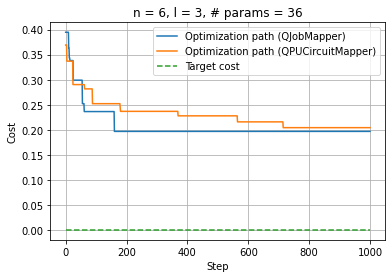

In [9]:
%matplotlib inline
plt.clf()
plt.plot(np.linspace(0, result1.nit, result1.nit), energies1, label="Optimization path (QJobMapper)")
upper_bound = result1.nit
plt.plot(np.linspace(0, result2.nit, result2.nit), energies2, label="Optimization path (QPUCircuitMapper)")
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost");
plt.legend(loc="upper right");
plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {ansatz.num_parameters}")
plt.grid(True)
plt.show()

qdrop(family)

In [10]:
# TODO: Paralelization of expectation value terms

In [11]:
# TODO: Paralelization for gradient optimizers